# Descripción general de la red

Importar las librerias de networkx y wntr.

In [1]:
import networkx as nx
import wntr
import numpy as np
import matplotlib.pylab as plt

ModuleNotFoundError: No module named 'wntr'

Importar el archivo de la red (*.inp) y se guarda en la variable 'wn'.

In [3]:
wn = wntr.network.WaterNetworkModel('nets/Chihuahua.inp')

NameError: name 'wntr' is not defined

Detalle de la red

In [ ]:
wn.describe()

## Mostramos la red

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, node_size=20, title='Red Chihuahua',ax=ax1)

# Metricas de Resilencia Topografica de la Red
## Densidad de enlaces

Para aplicar las métricas de resiliencia topográficas requieren que la red sea un grafo simple y no dirigido.
La variable 'wn' se convierte en un multigrafo dirigido representado con la variable 'G', posteriormente se utiliza para transformarla en un multigrafo no dirigido que se representa con la variable 'uG', por último esta variable se transforma en un grafo simple represntado con la variable 'sG'.

In [2]:
G = wn.get_graph() # directed multigraph
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph

NameError: name 'wn' is not defined

## Densidad

In [7]:
link_density = nx.density(G)
print(link_density)

0.0008922472240881744


## Diámetro

In [8]:
diameter = nx.diameter(uG)
print(diameter)

81


## Centralidad de intermediación
Calcular la intermedicación

In [9]:
betweenness_centrality = nx.betweenness_centrality(sG)

Agregamos la intermediacion como atributo de los nodos

In [10]:
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.intermediacion = betweenness_centrality[node_name]

Graficamos la red de acuerdo a la intermediacion

(<matplotlib.collections.PathCollection at 0x14f3b777550>,
 <matplotlib.collections.LineCollection at 0x14f3b64c790>)

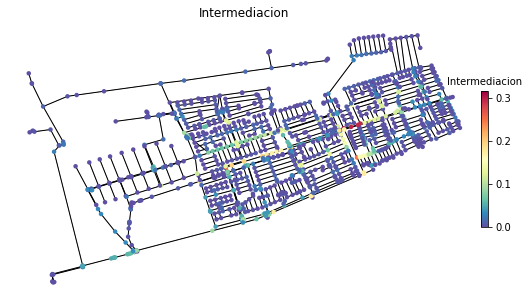

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Intermediacion', node_attribute='intermediacion', node_colorbar_label='Intermediacion',ax=ax1)

## Excentricidad
Distancia al nodo más lejano

(<matplotlib.collections.PathCollection at 0x14f3b3c2280>,
 <matplotlib.collections.LineCollection at 0x14f3b679970>)

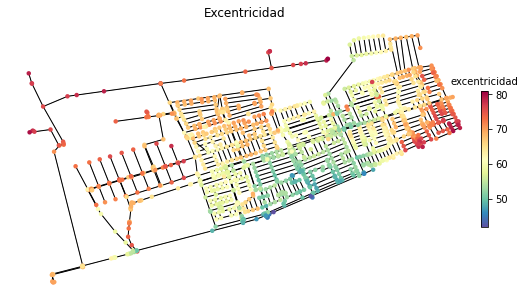

In [14]:
eccentricity = nx.eccentricity(uG)
for node_name, node in wn.nodes():
    node.excentricidad = eccentricity[node_name]
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Excentricidad', node_attribute='excentricidad', node_colorbar_label='excentricidad',ax=ax1)

## Centralidad de cercanía
Reciproco de la suma de las distancias a todos los nodos

(<matplotlib.collections.PathCollection at 0x14f3bf1ebb0>,
 <matplotlib.collections.LineCollection at 0x14f3bf0adc0>)

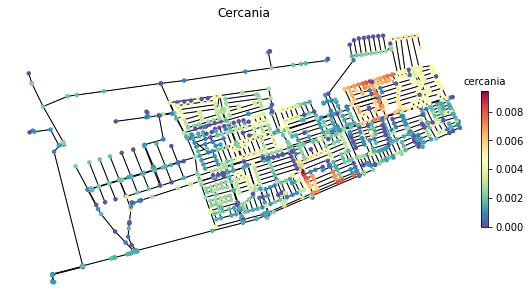

In [16]:
closeness_centrality = nx.closeness_centrality(G)
for node_name, node in wn.nodes():
    node.cercania = closeness_centrality[node_name]
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Cercania', node_attribute='cercania', node_colorbar_label='cercania',ax=ax1)

## Grado de nodo
Cantidad de enlaces que tiene un nodo

Calculamos el grado nodal

<ipython-input-18-a547b5b95220>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))


(<matplotlib.collections.PathCollection at 0x14f4678ba00>,
 <matplotlib.collections.LineCollection at 0x14f46772580>)

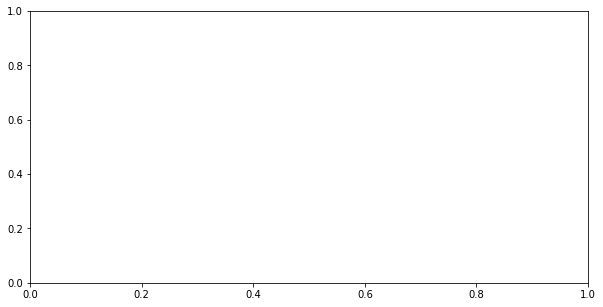

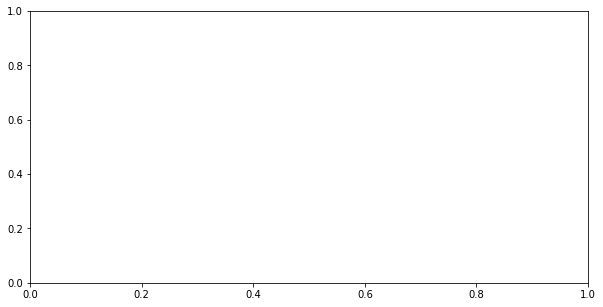

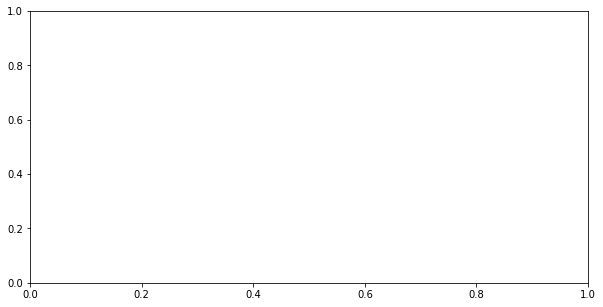

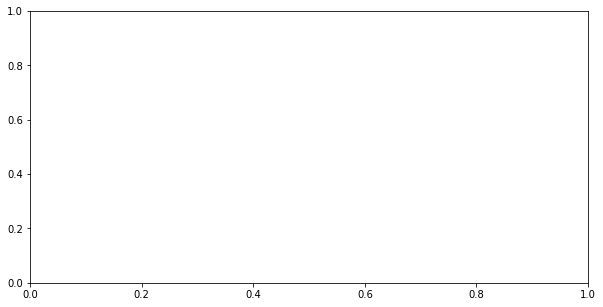

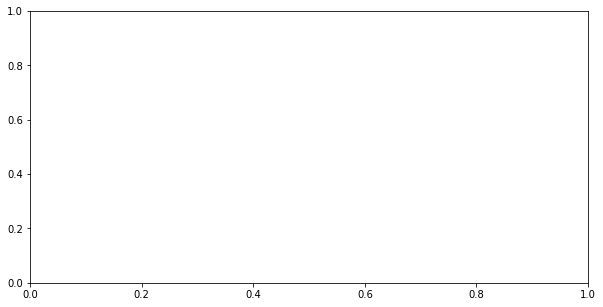

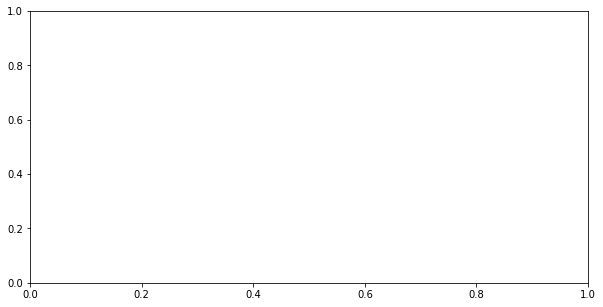

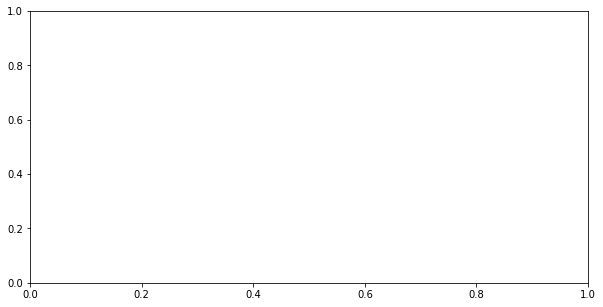

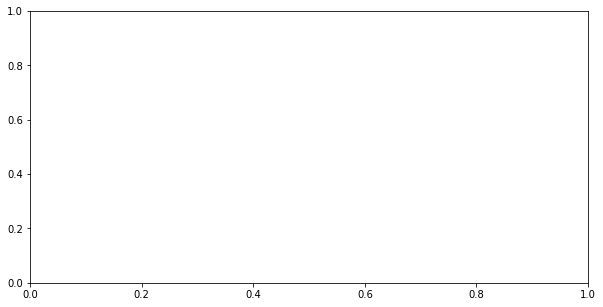

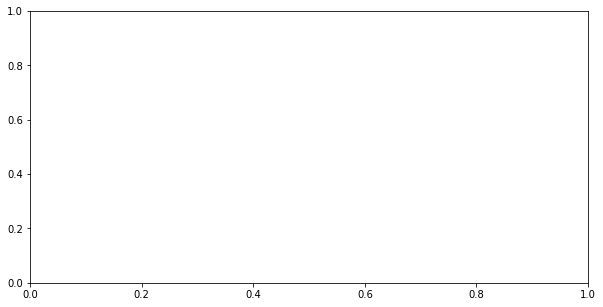

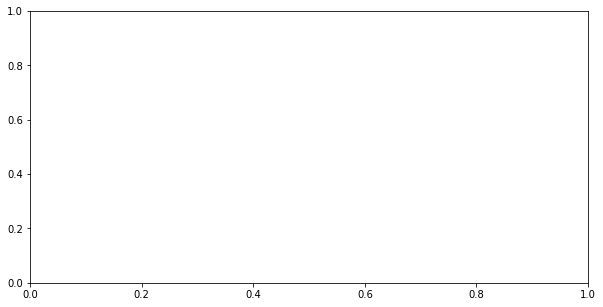

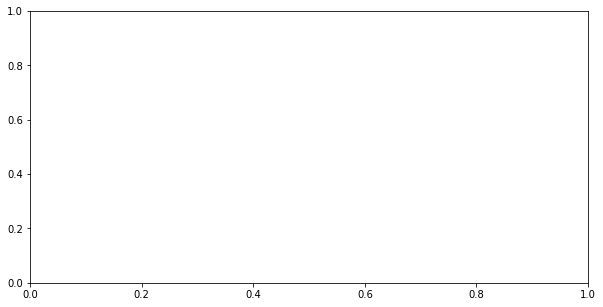

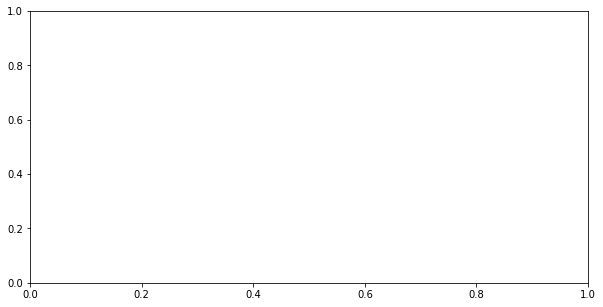

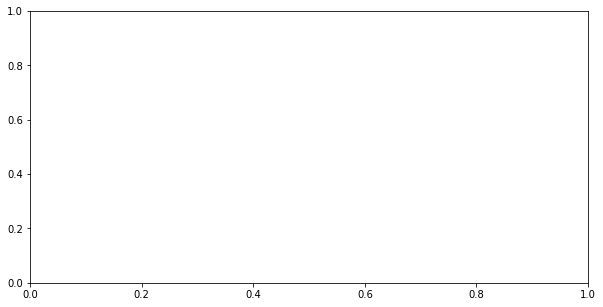

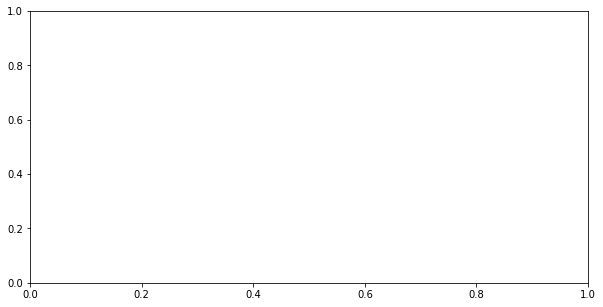

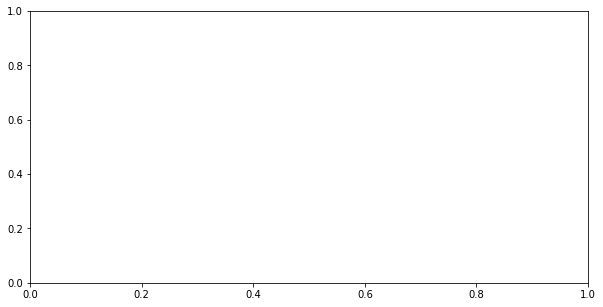

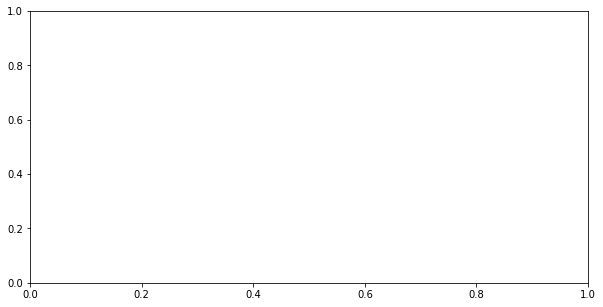

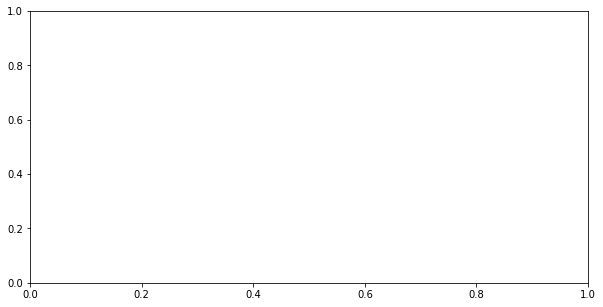

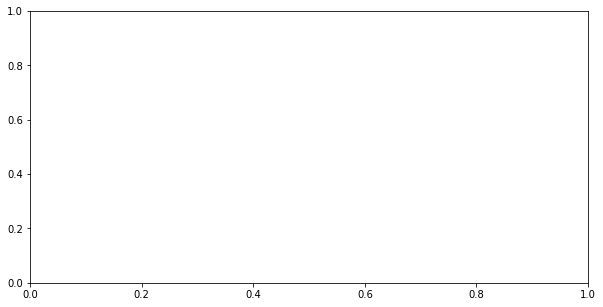

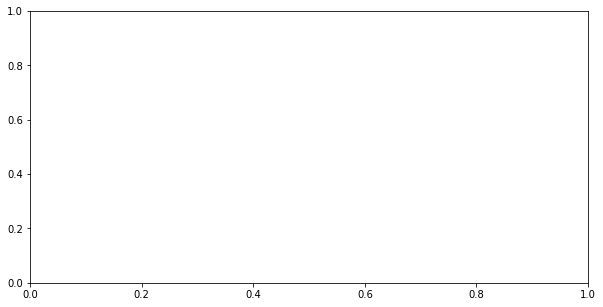

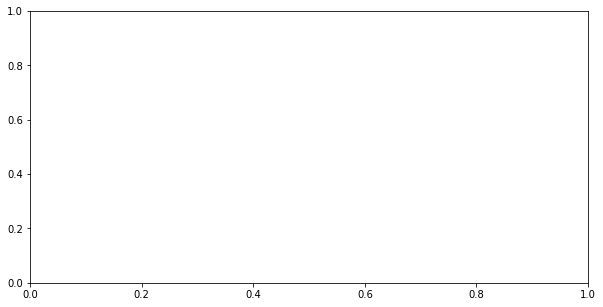

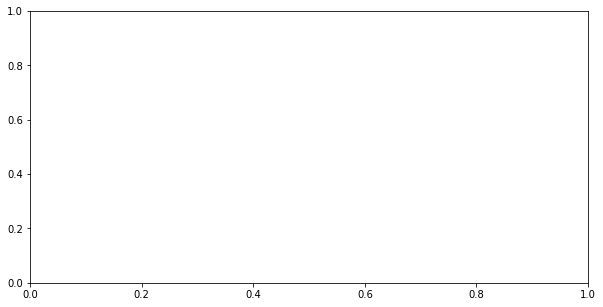

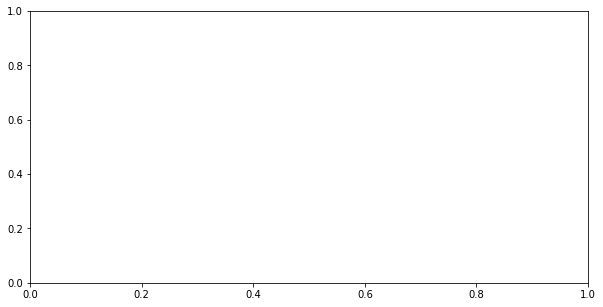

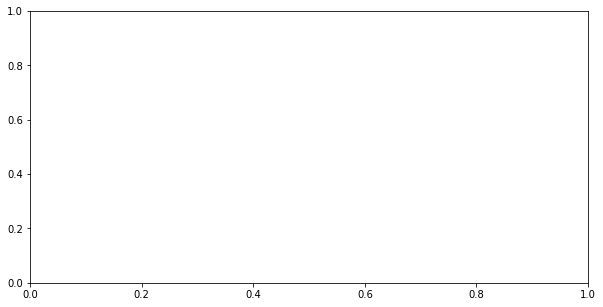

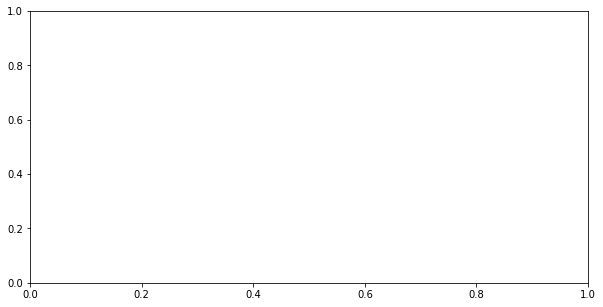

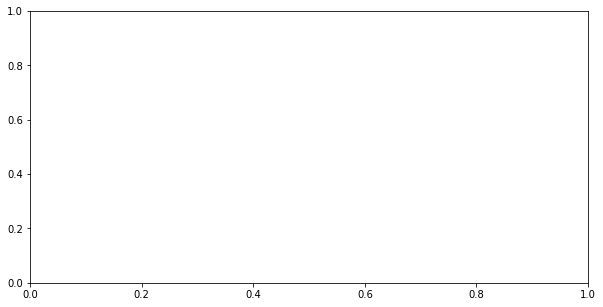

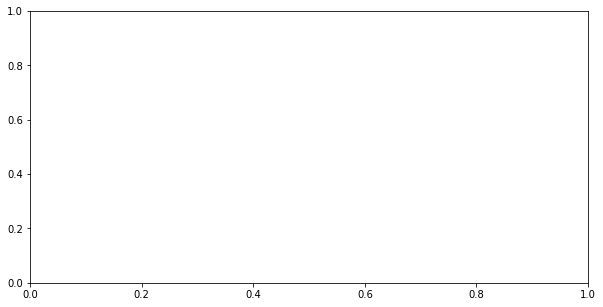

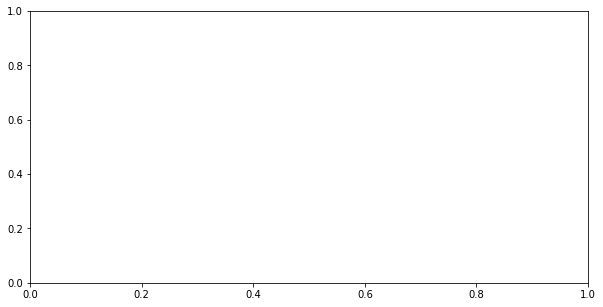

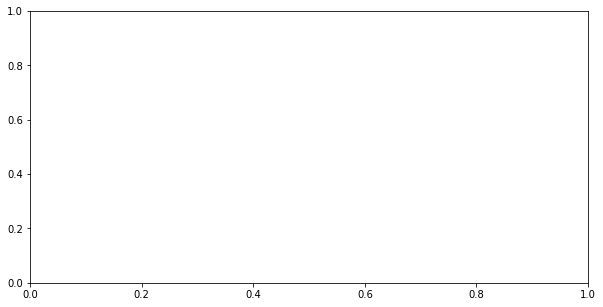

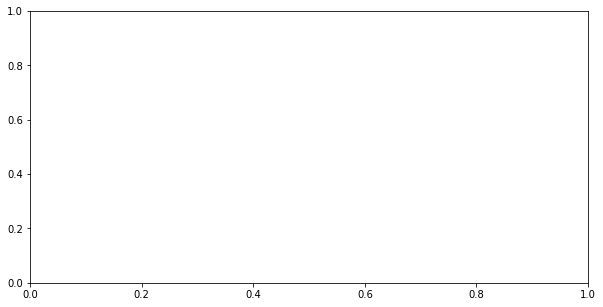

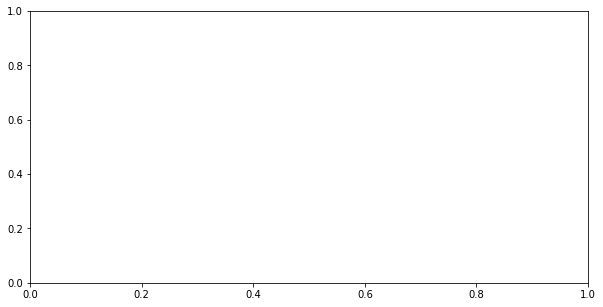

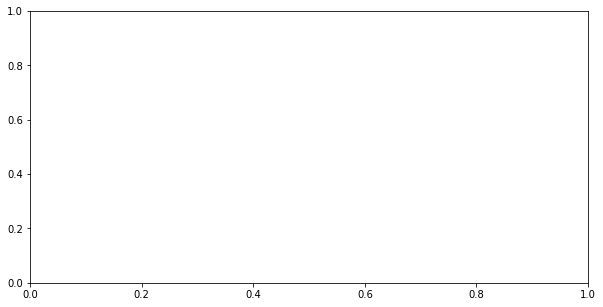

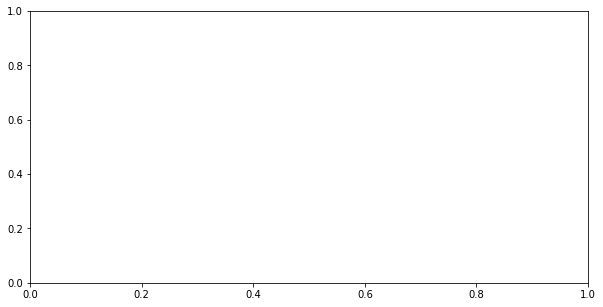

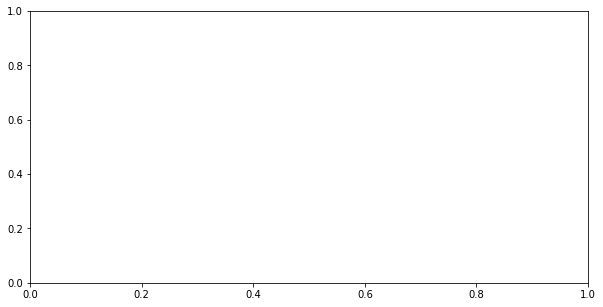

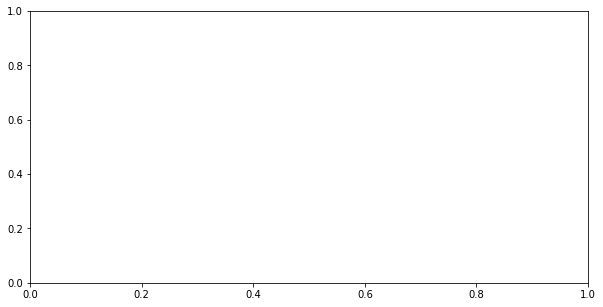

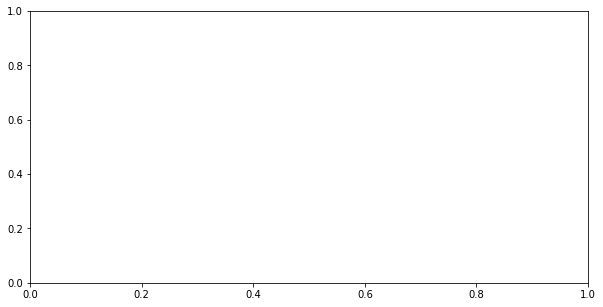

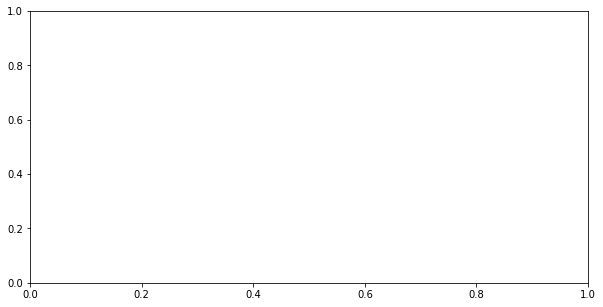

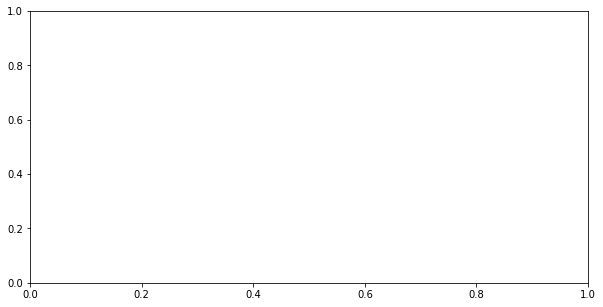

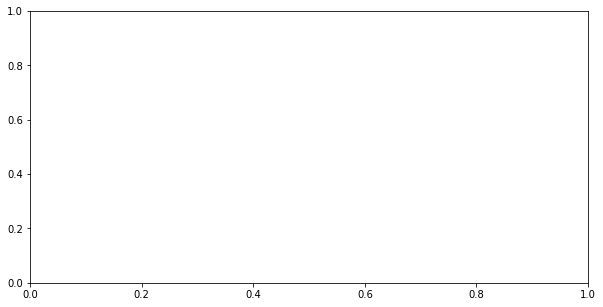

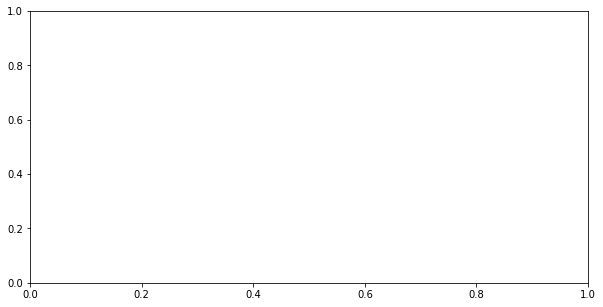

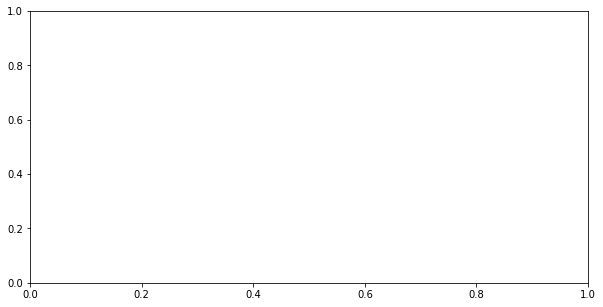

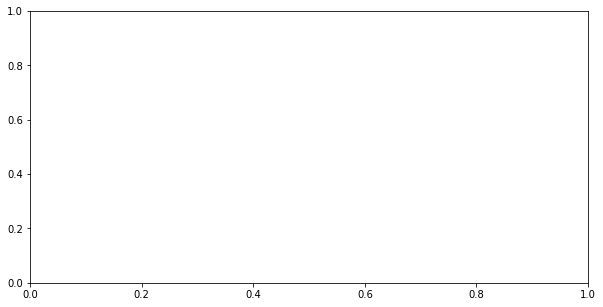

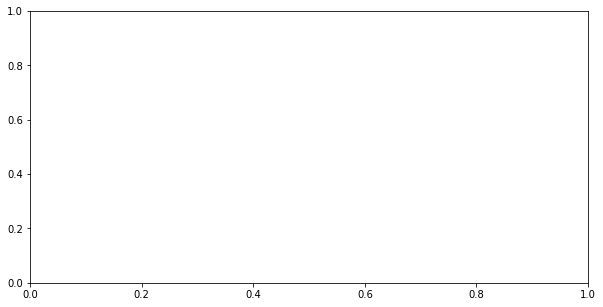

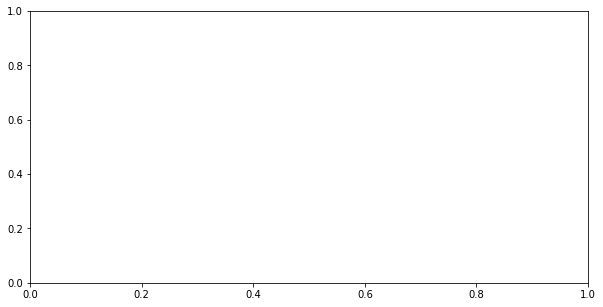

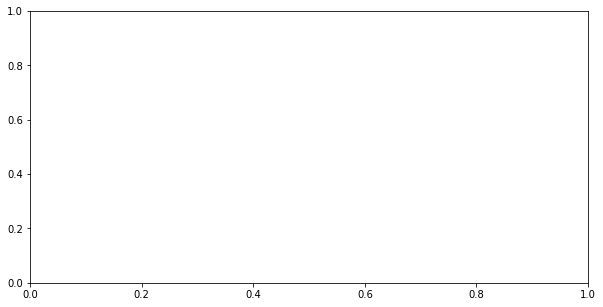

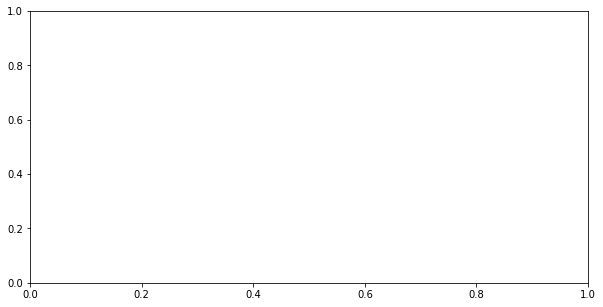

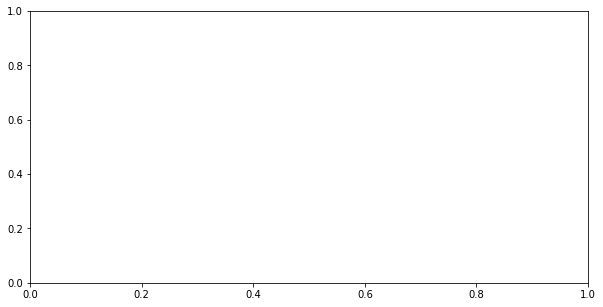

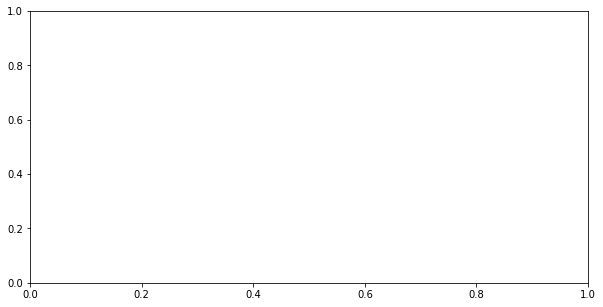

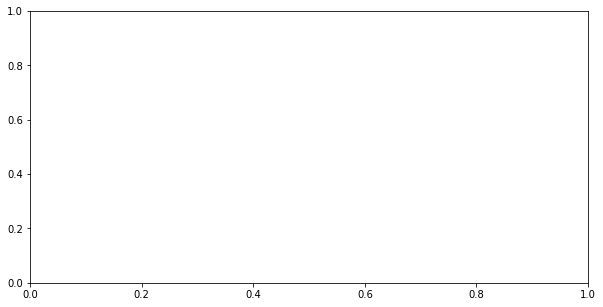

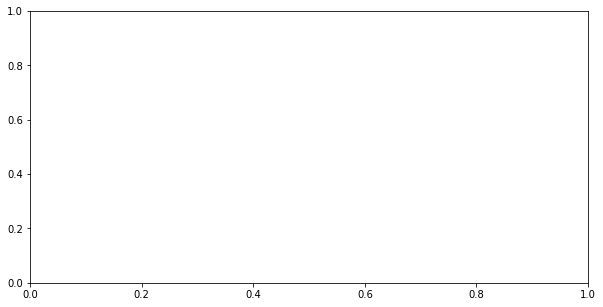

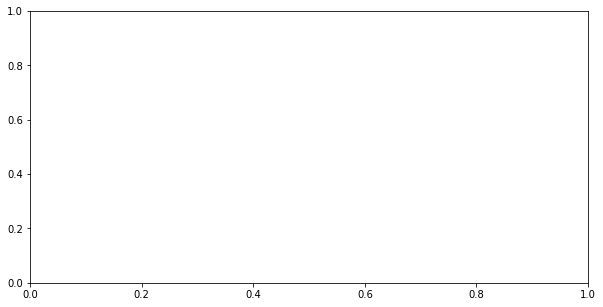

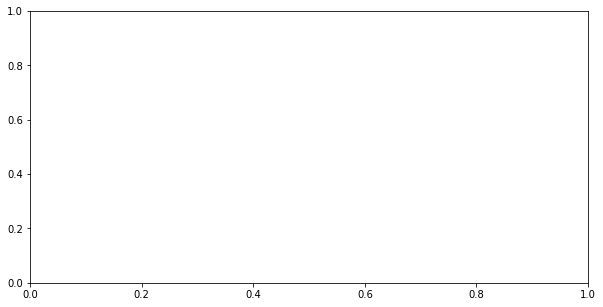

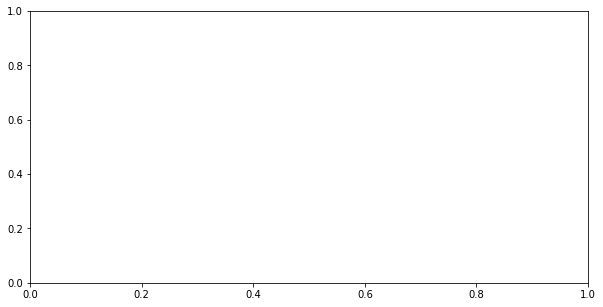

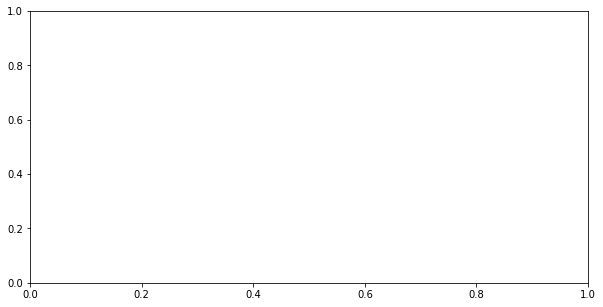

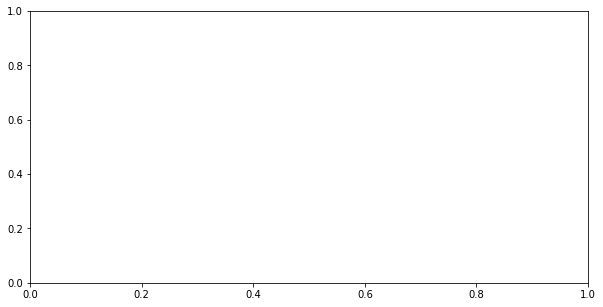

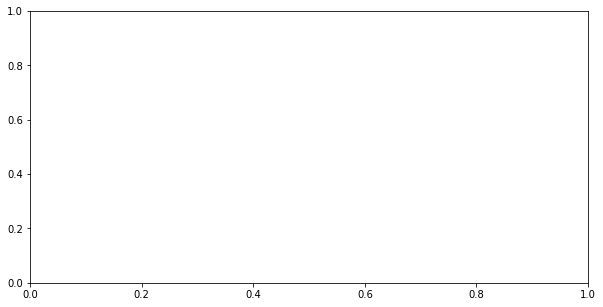

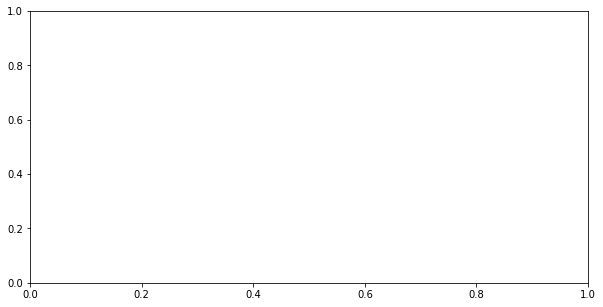

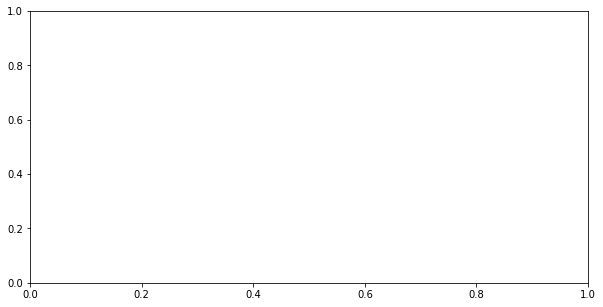

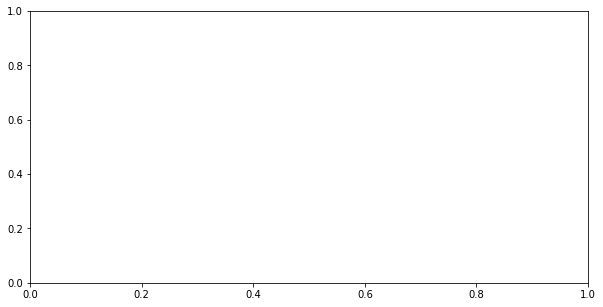

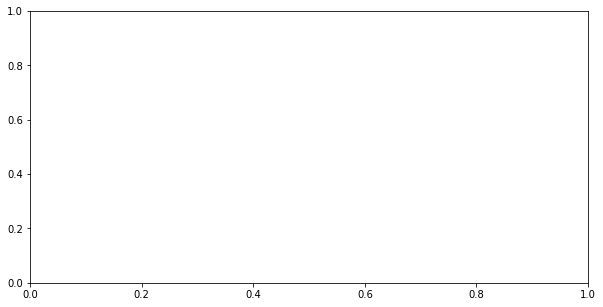

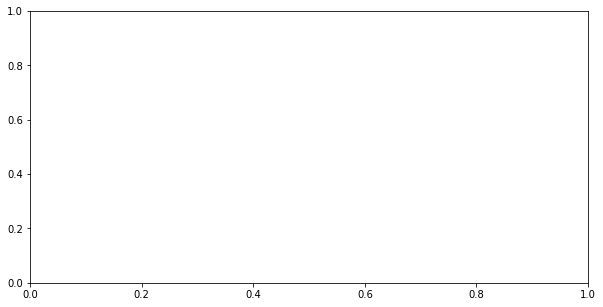

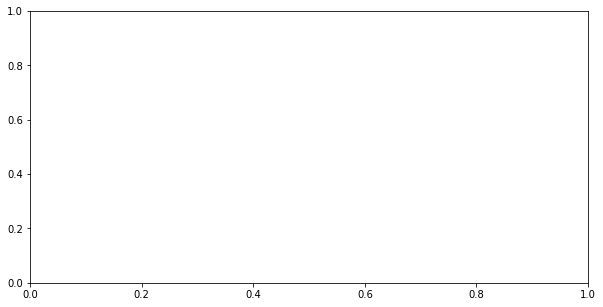

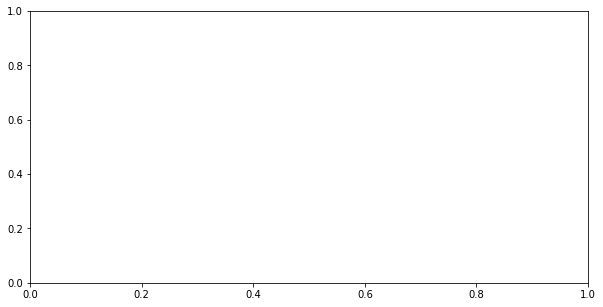

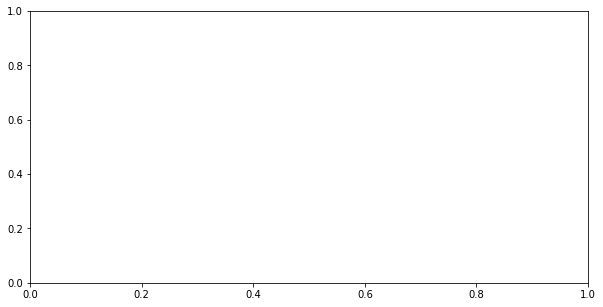

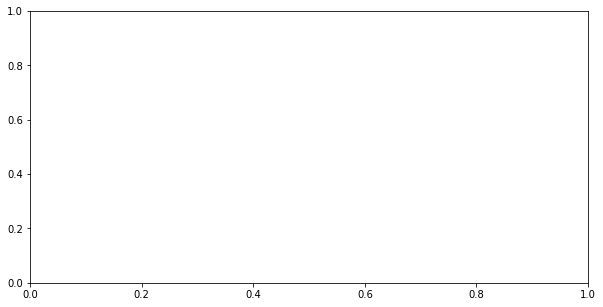

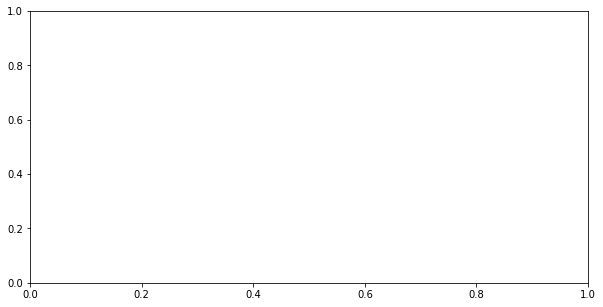

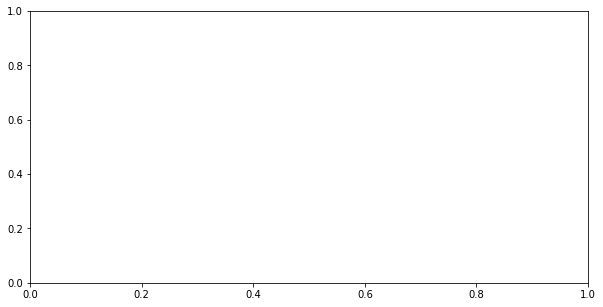

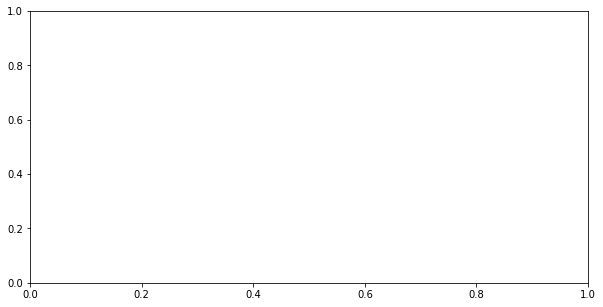

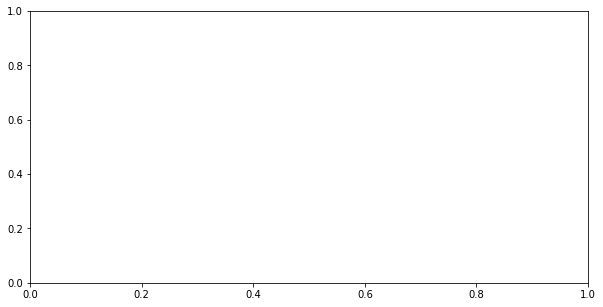

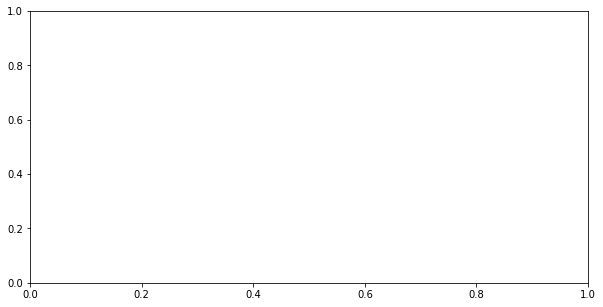

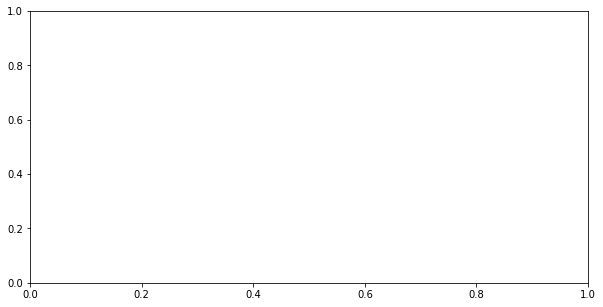

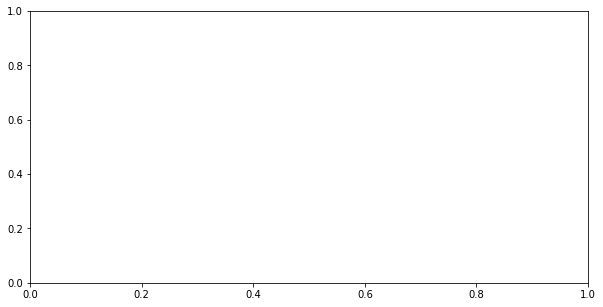

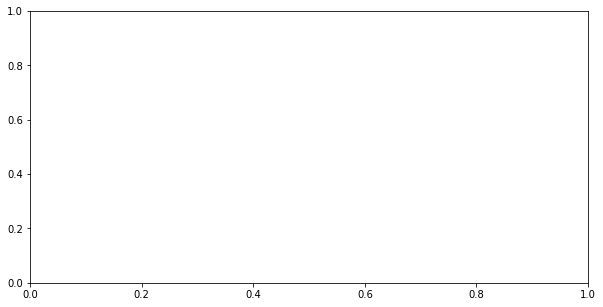

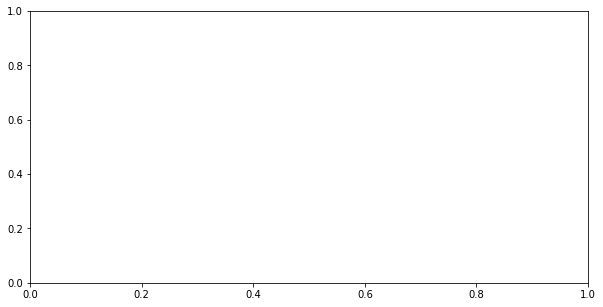

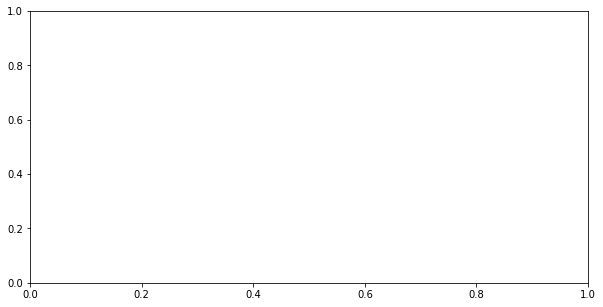

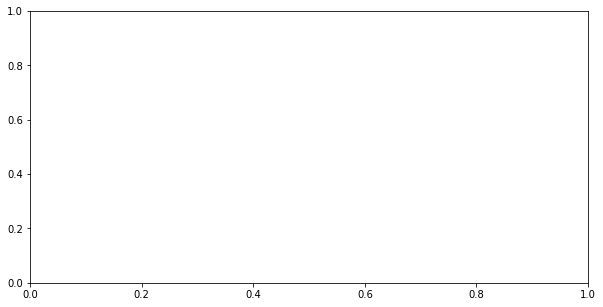

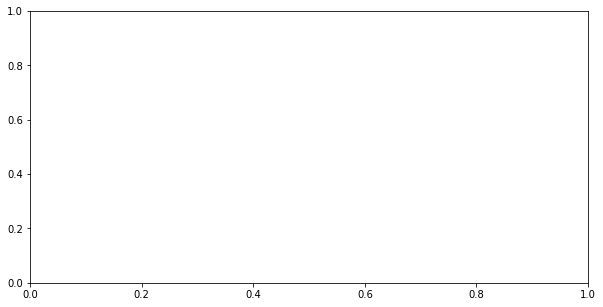

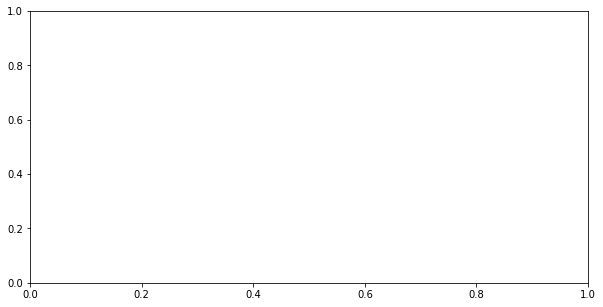

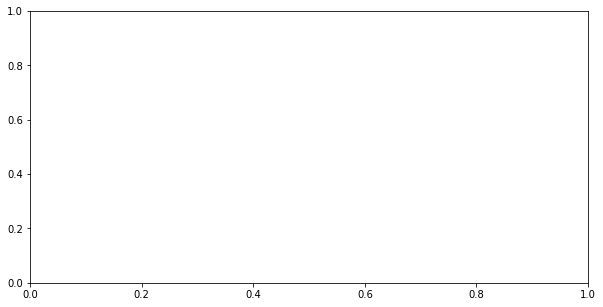

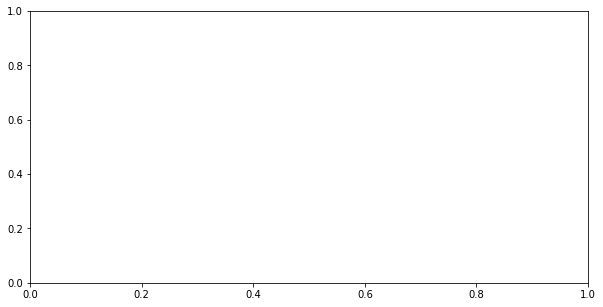

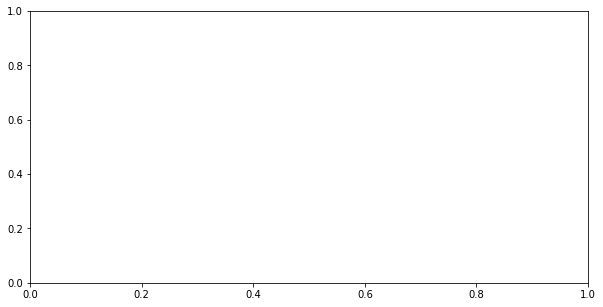

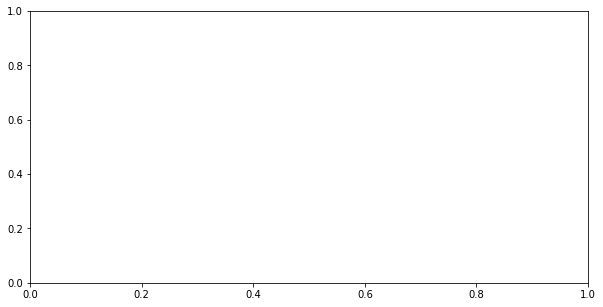

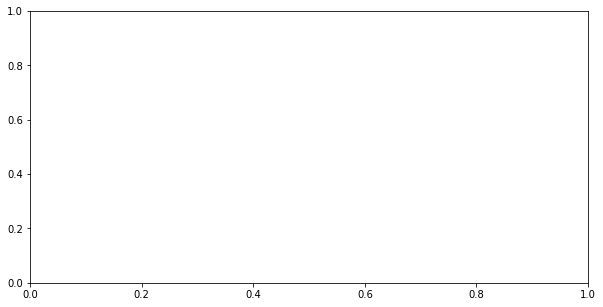

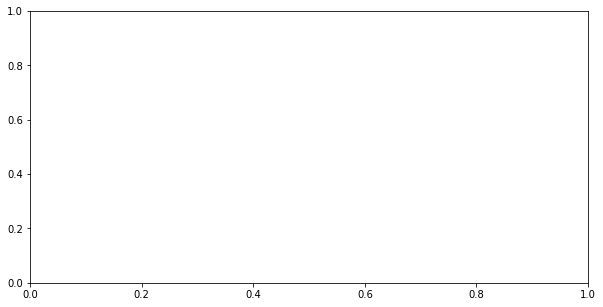

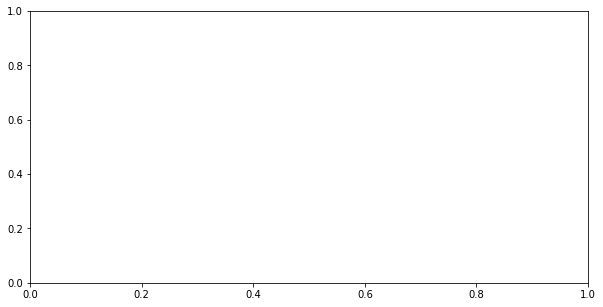

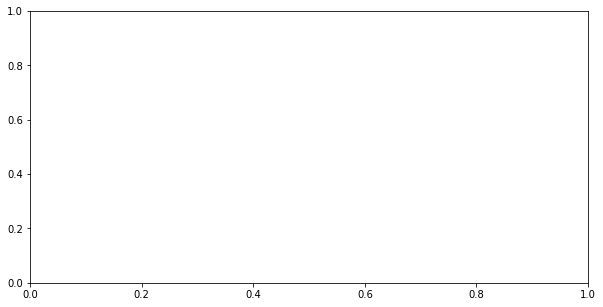

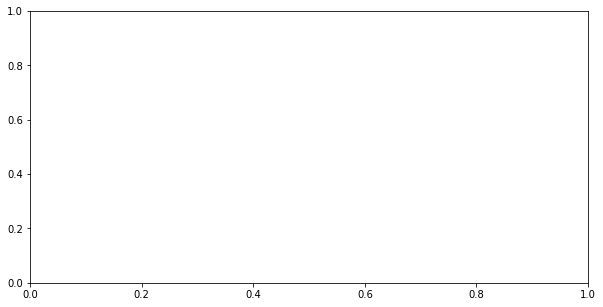

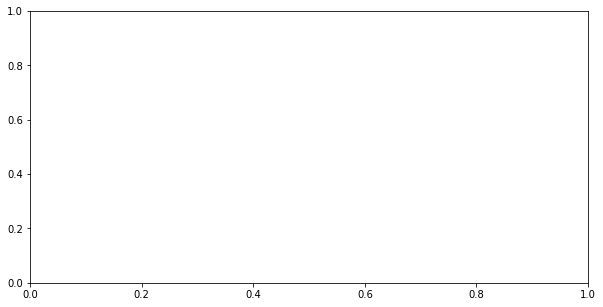

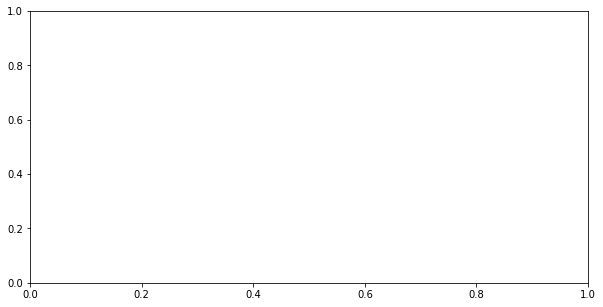

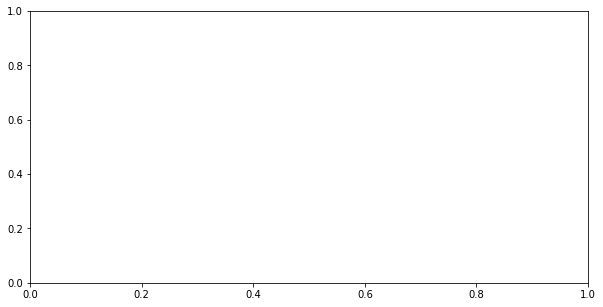

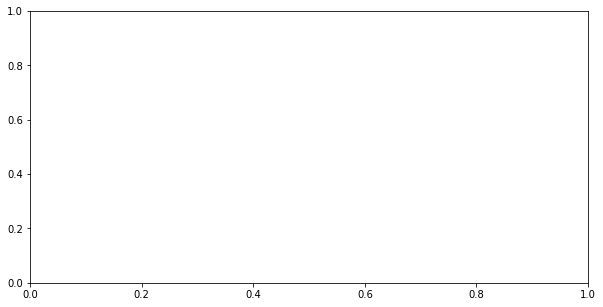

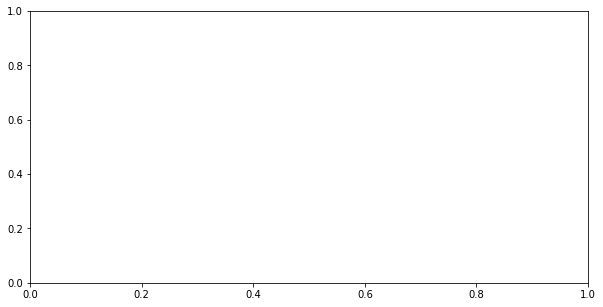

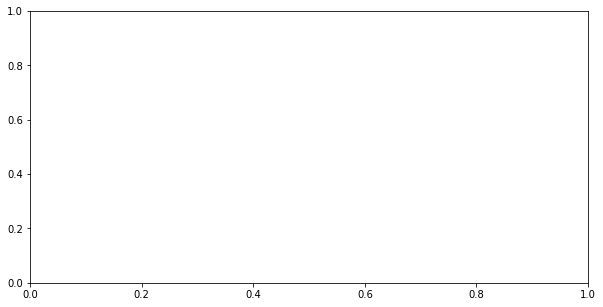

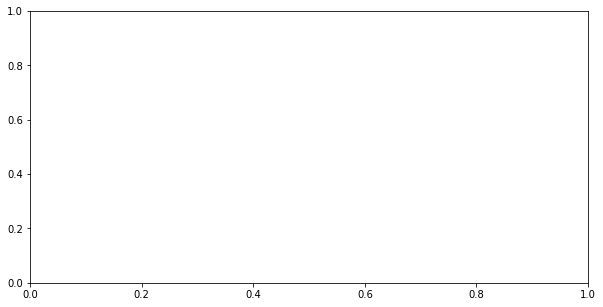

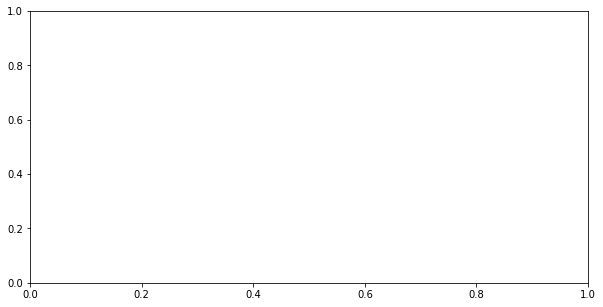

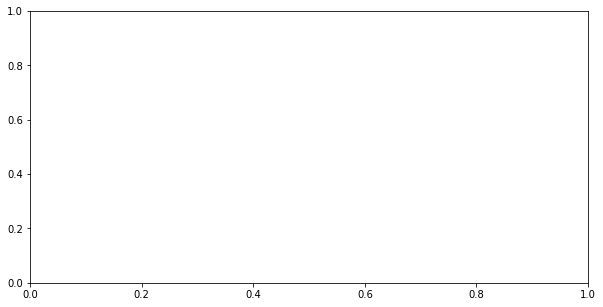

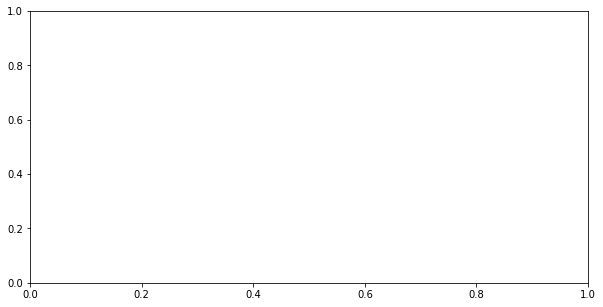

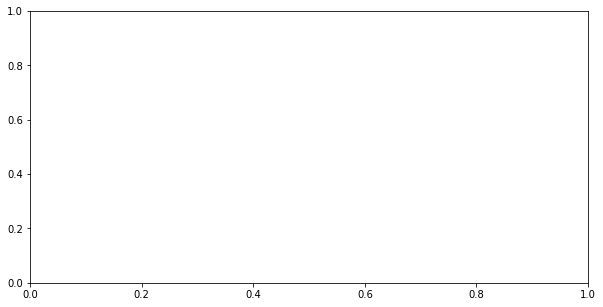

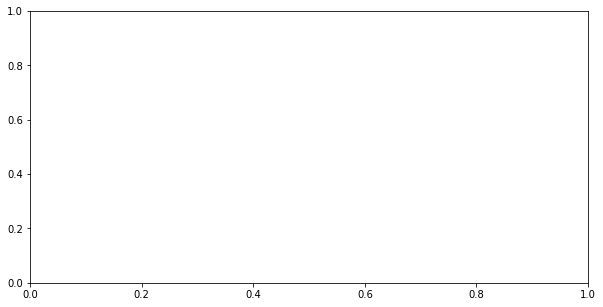

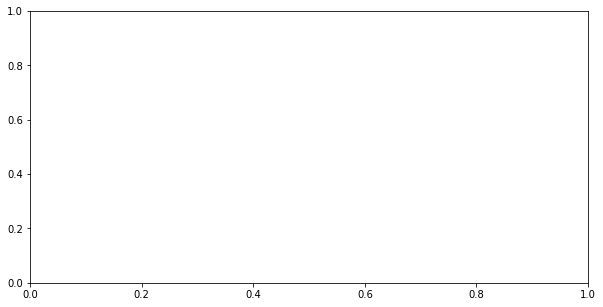

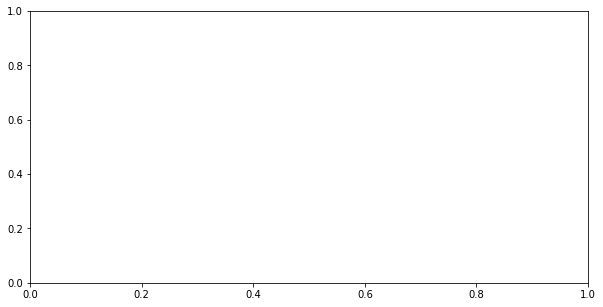

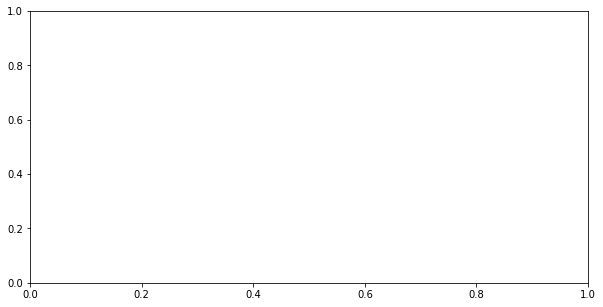

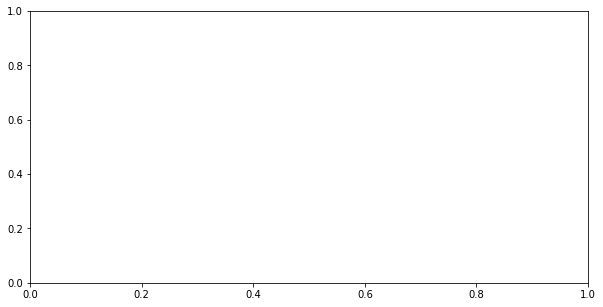

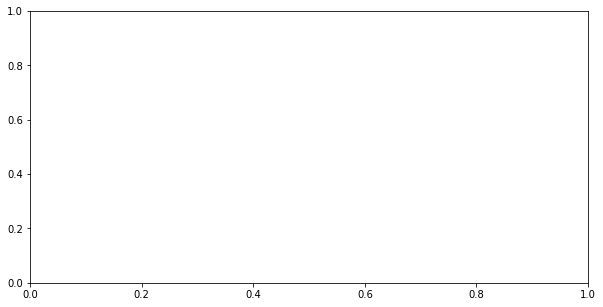

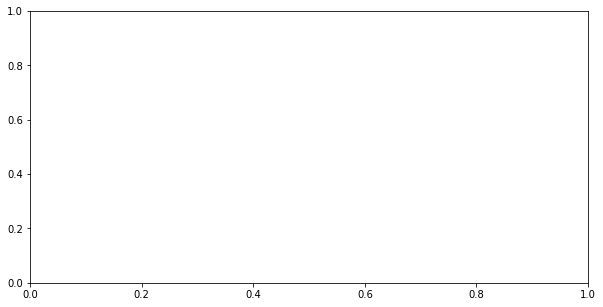

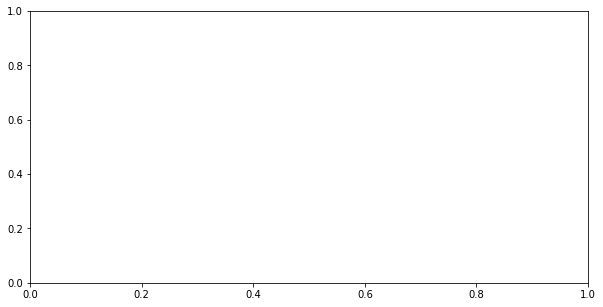

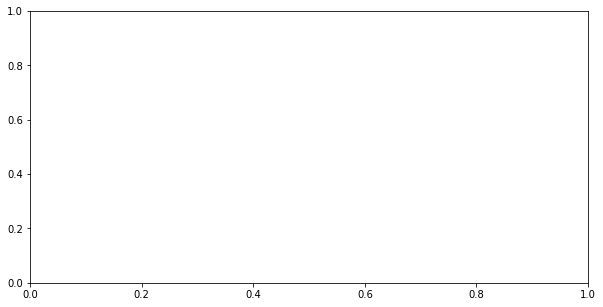

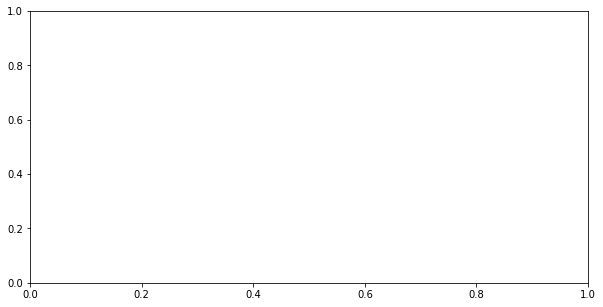

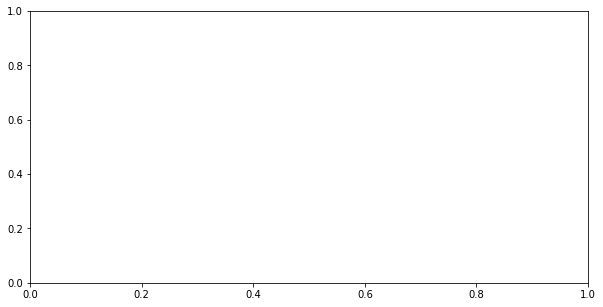

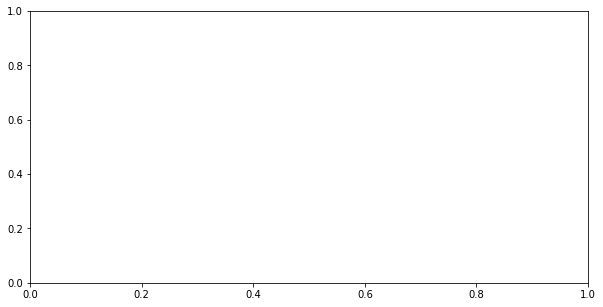

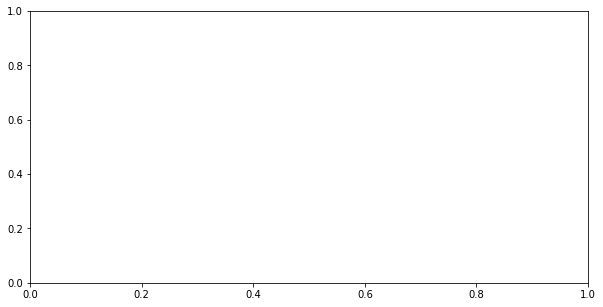

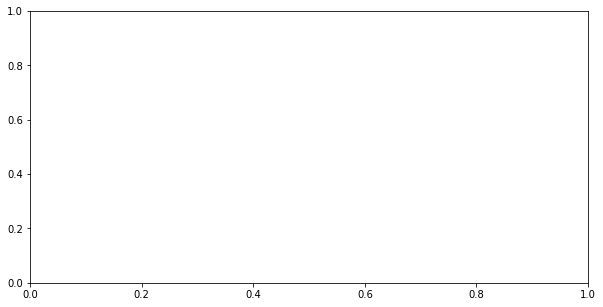

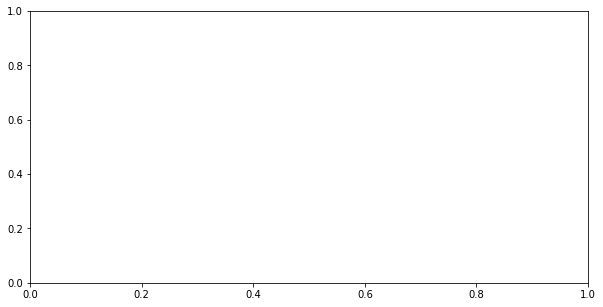

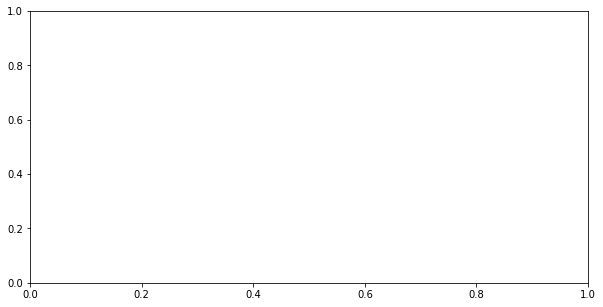

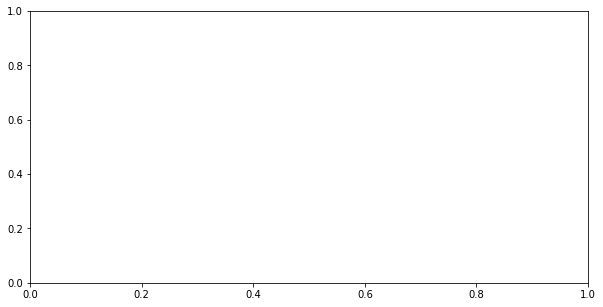

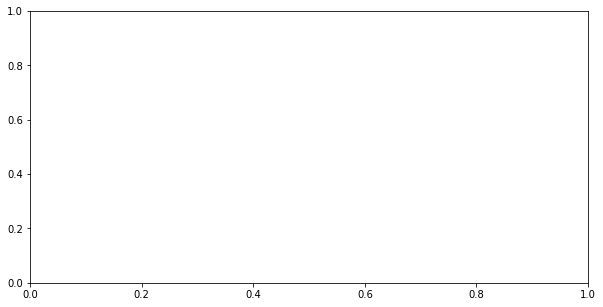

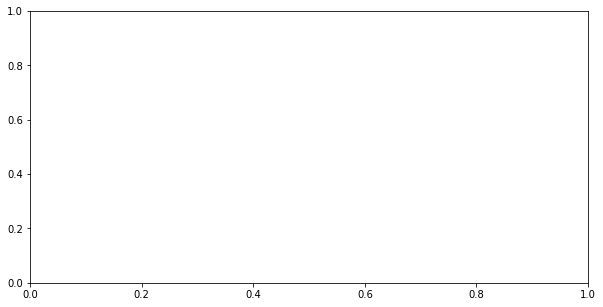

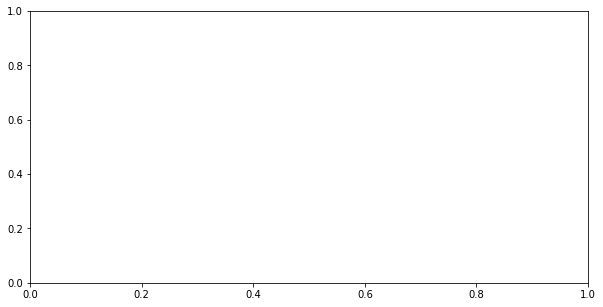

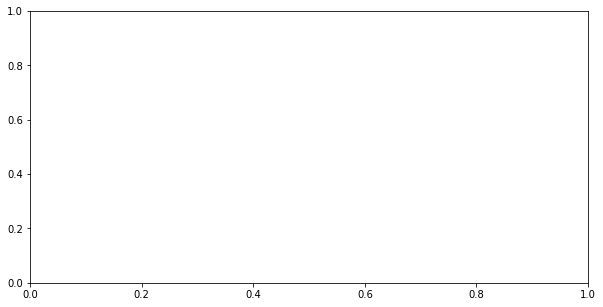

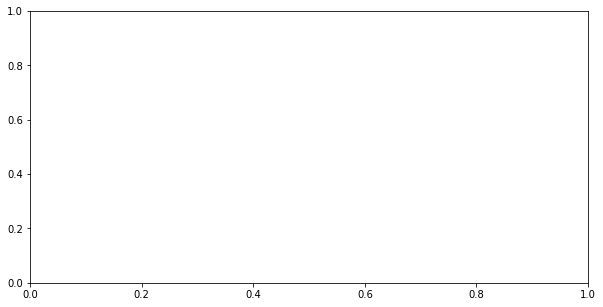

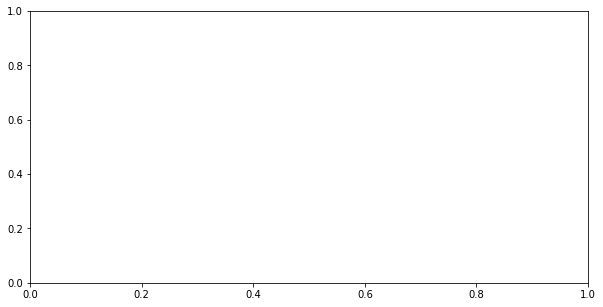

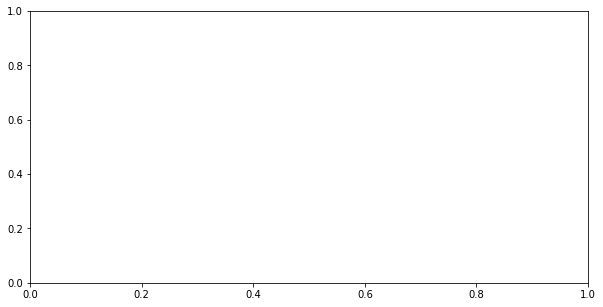

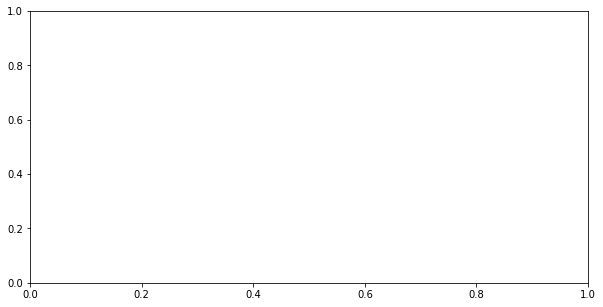

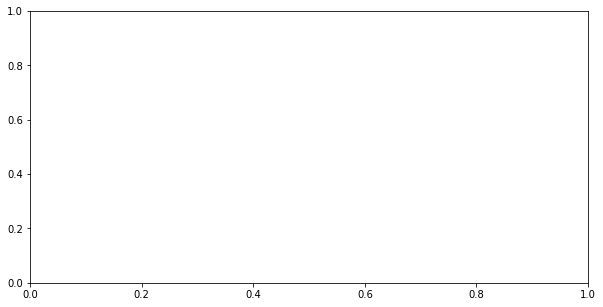

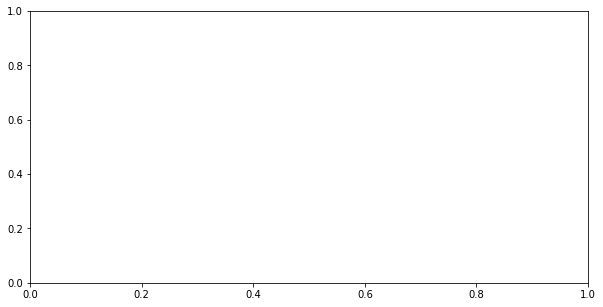

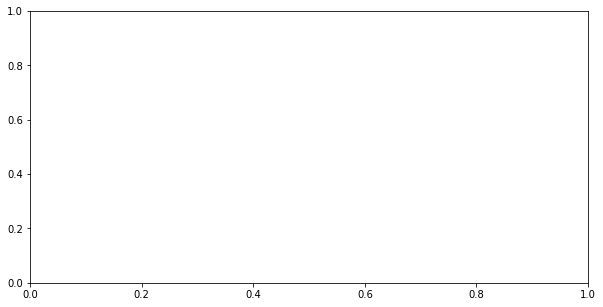

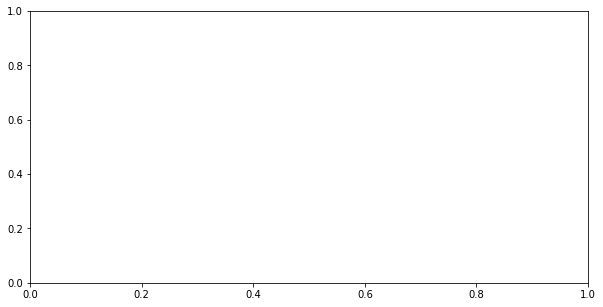

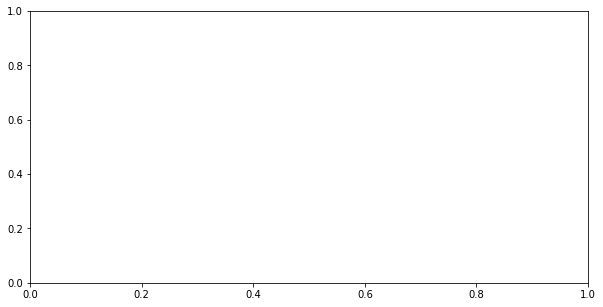

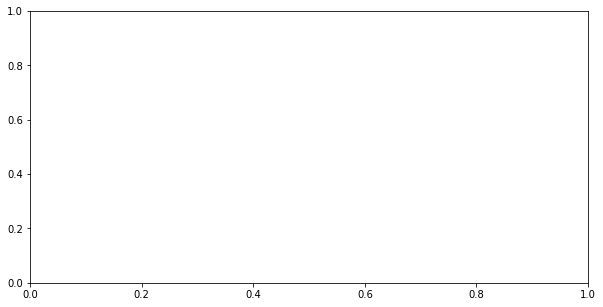

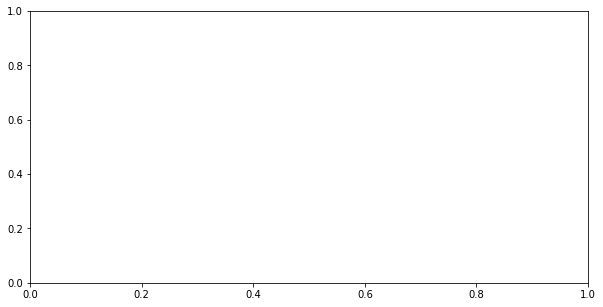

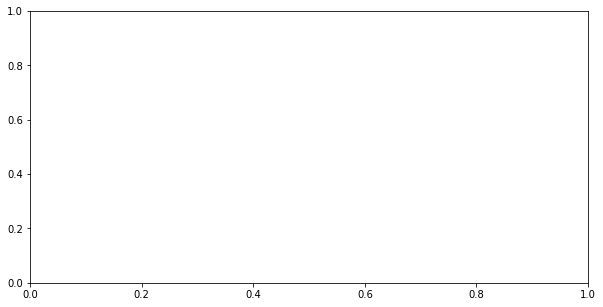

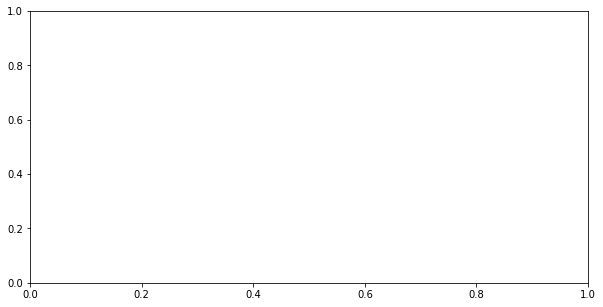

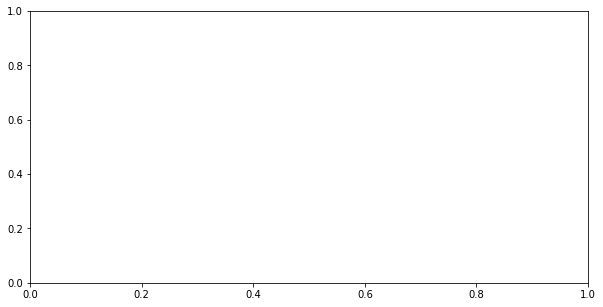

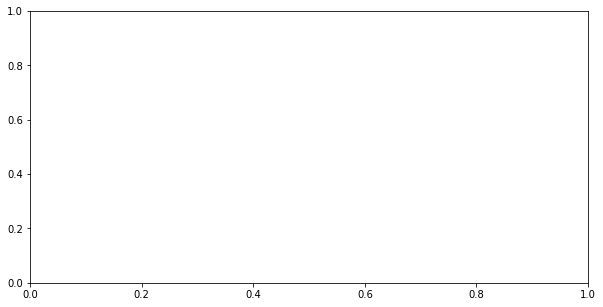

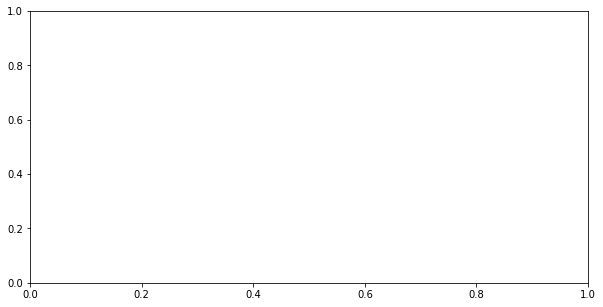

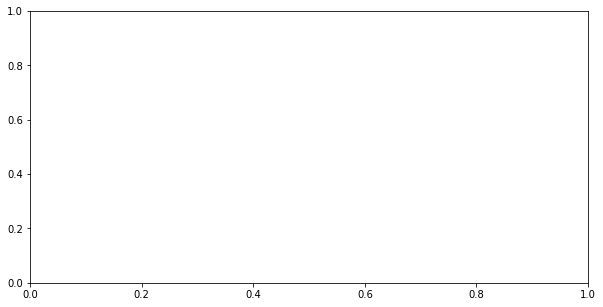

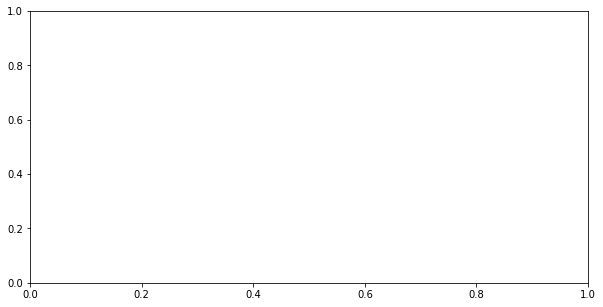

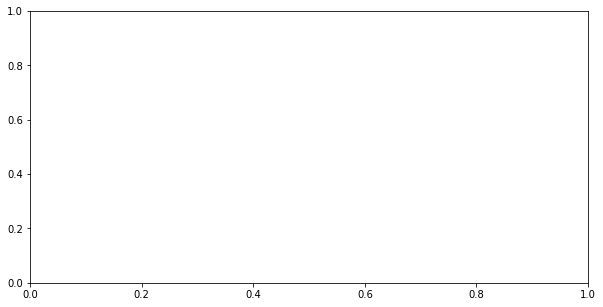

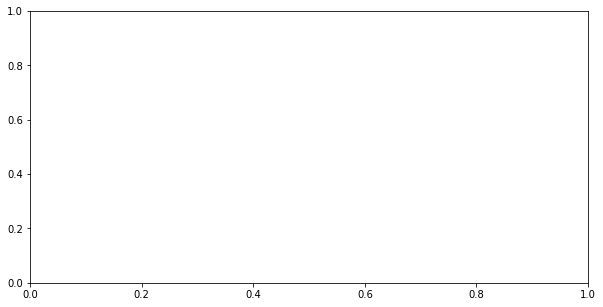

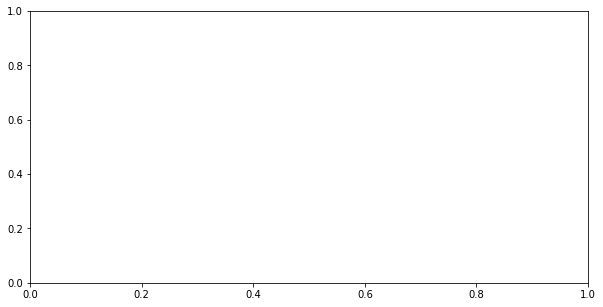

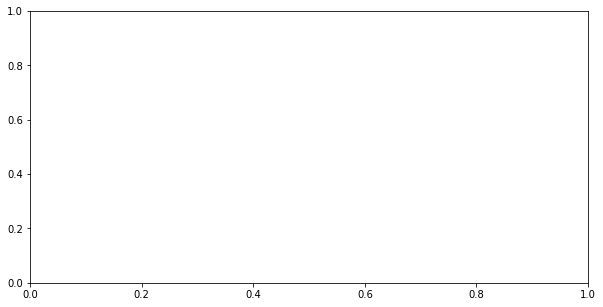

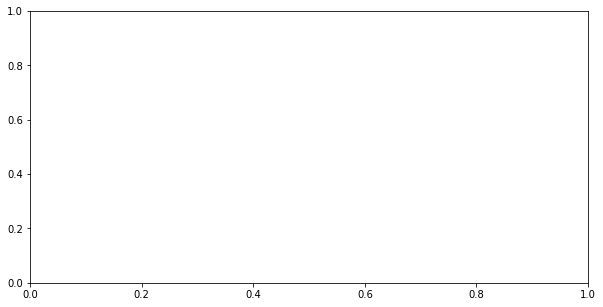

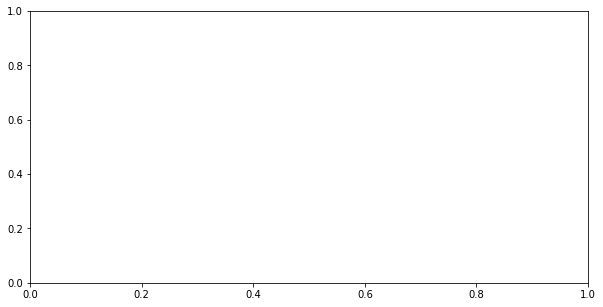

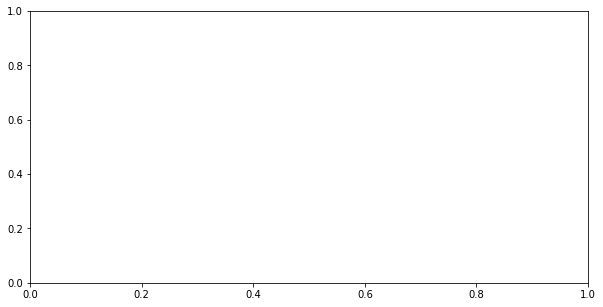

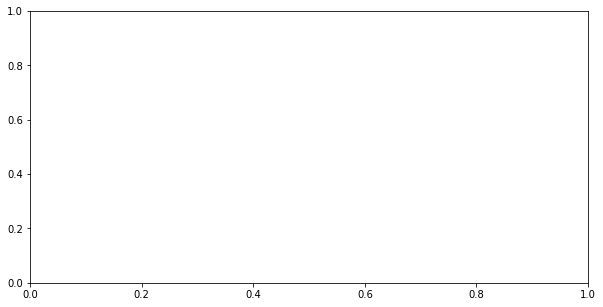

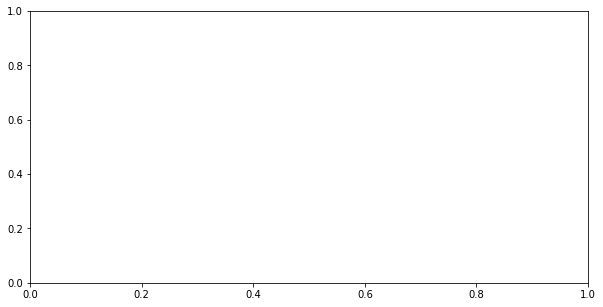

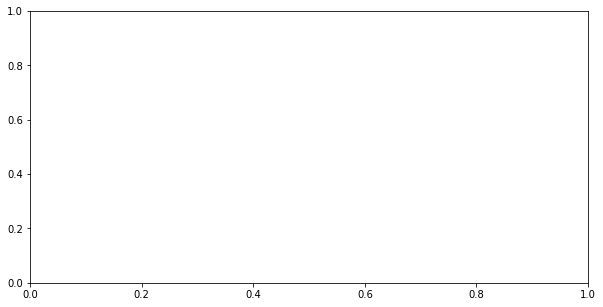

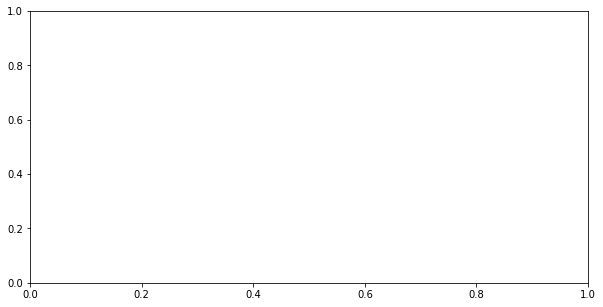

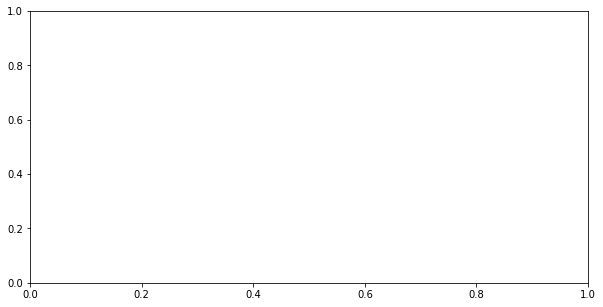

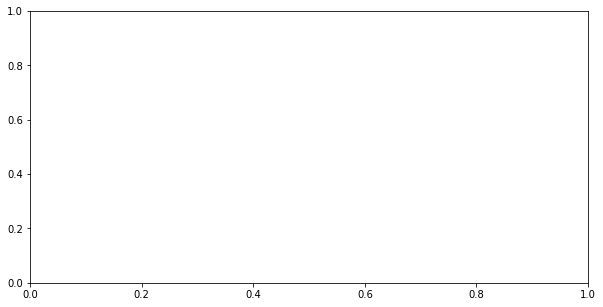

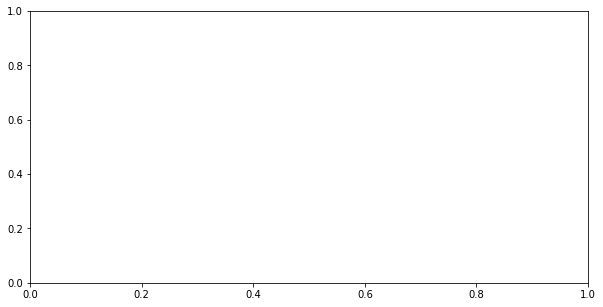

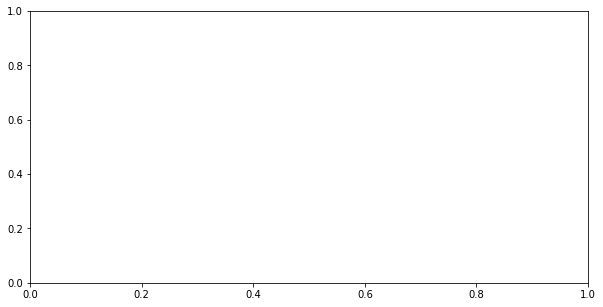

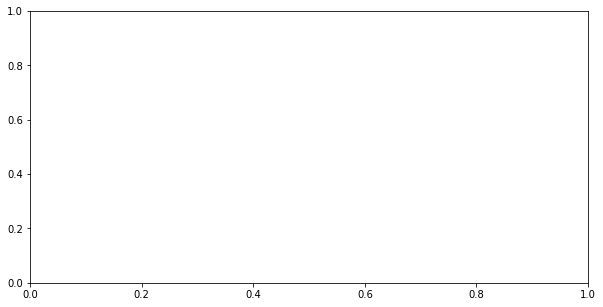

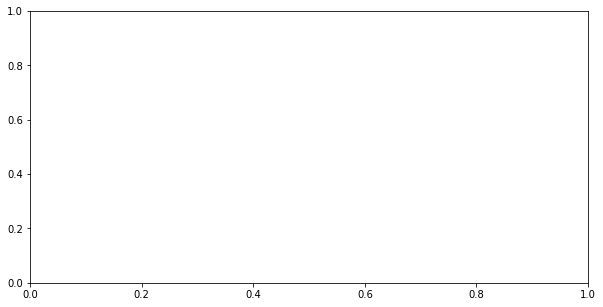

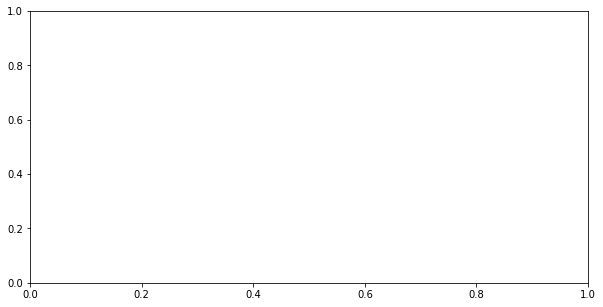

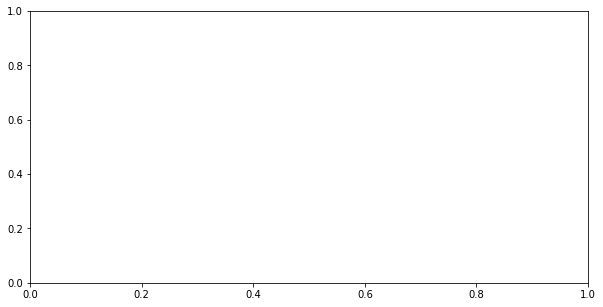

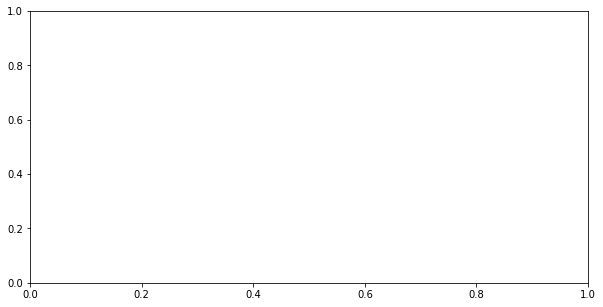

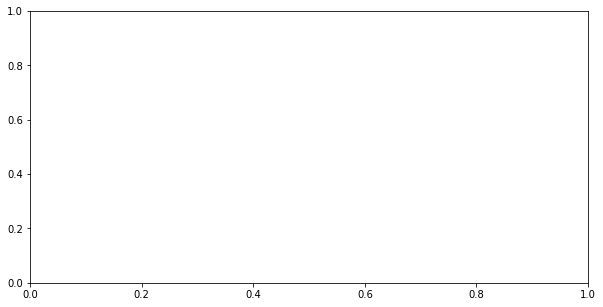

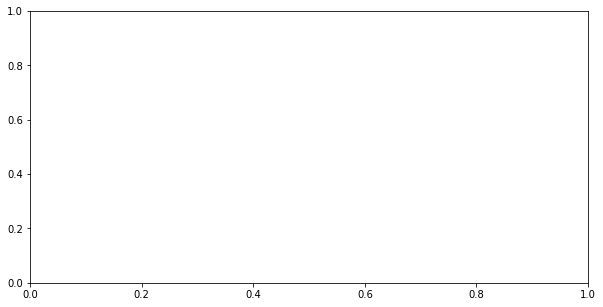

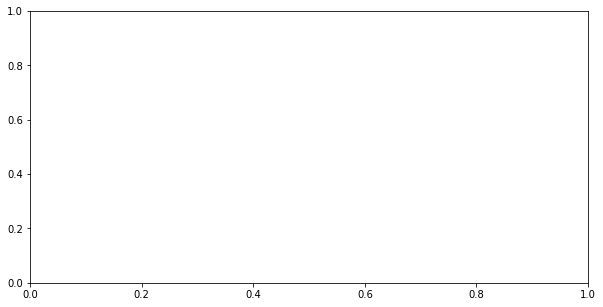

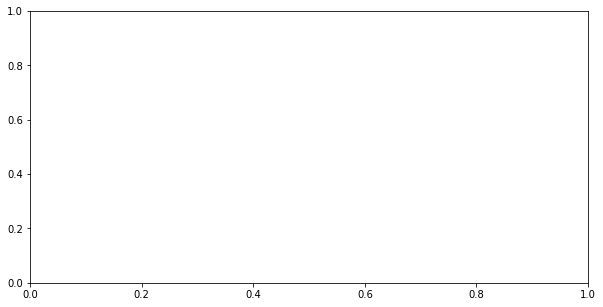

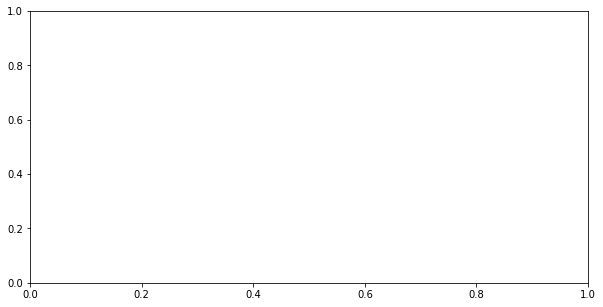

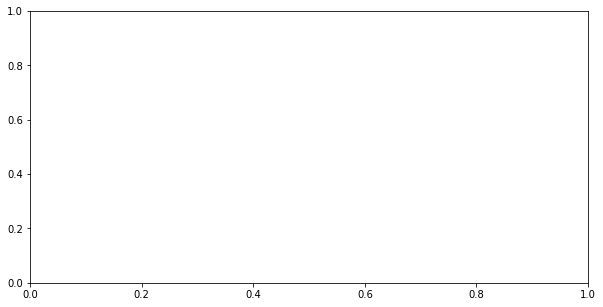

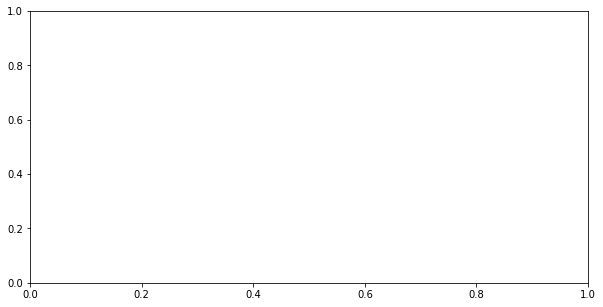

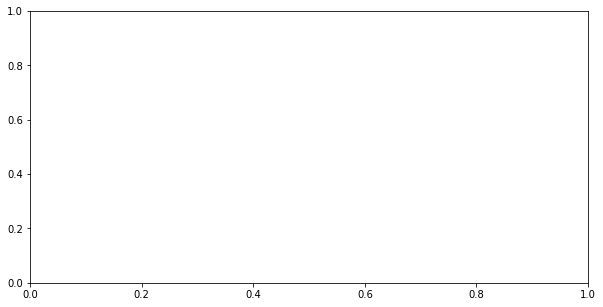

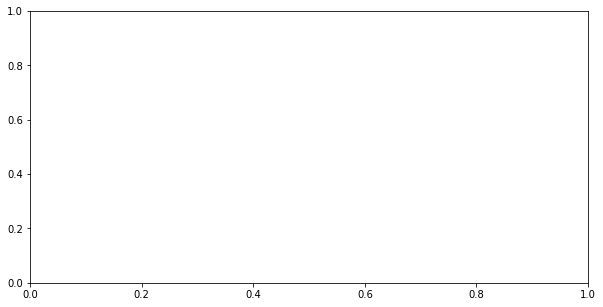

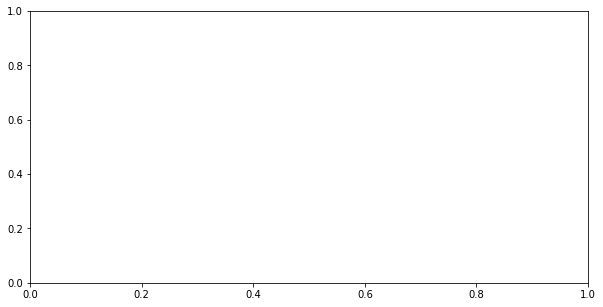

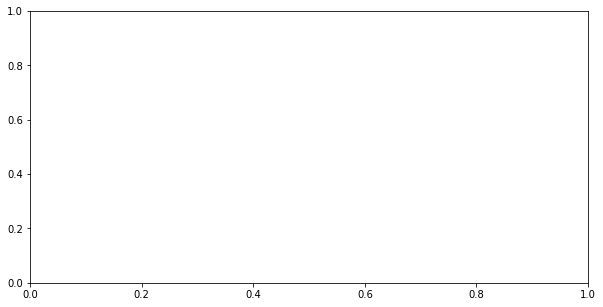

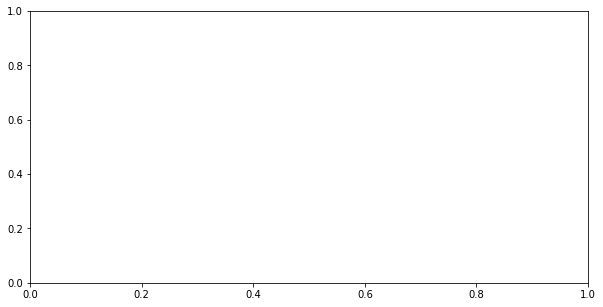

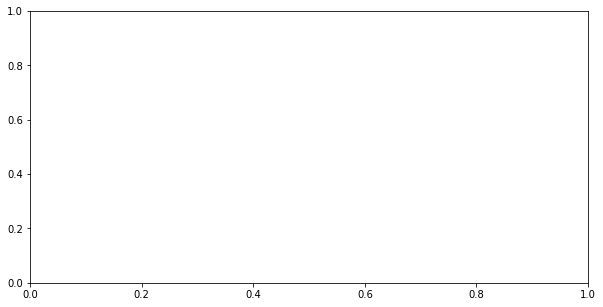

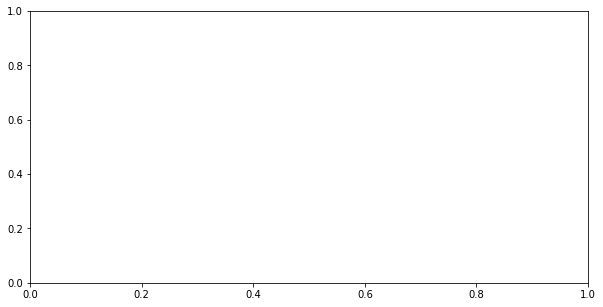

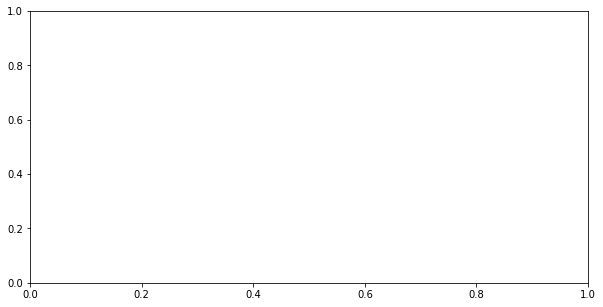

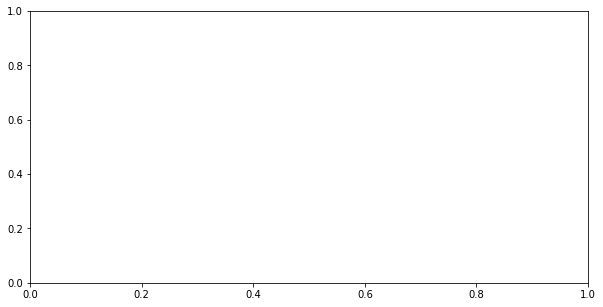

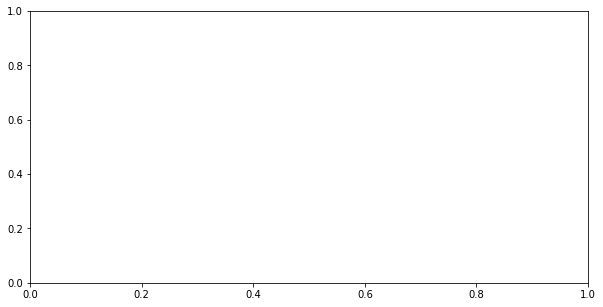

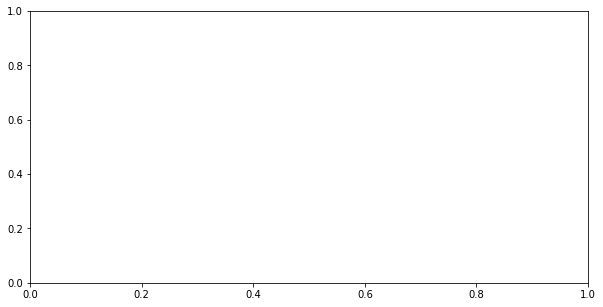

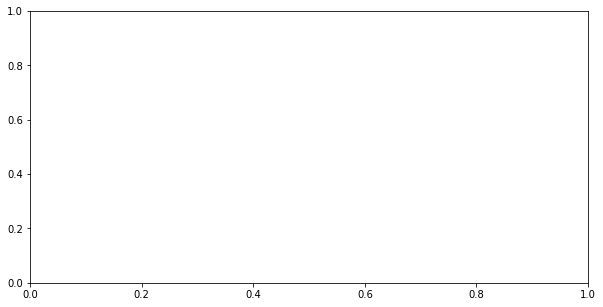

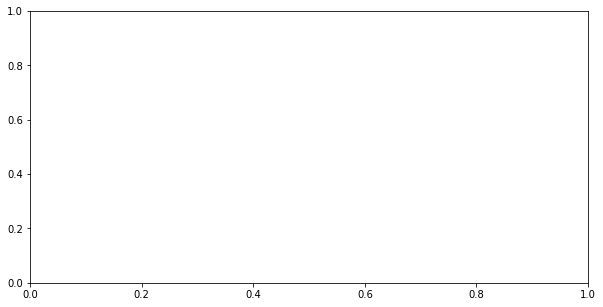

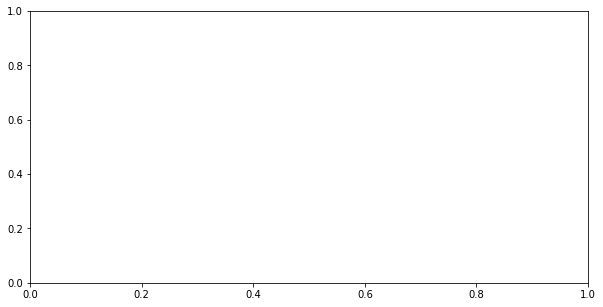

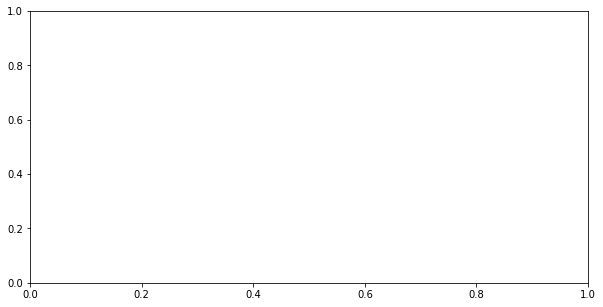

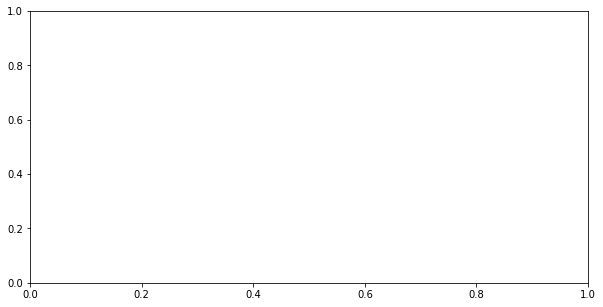

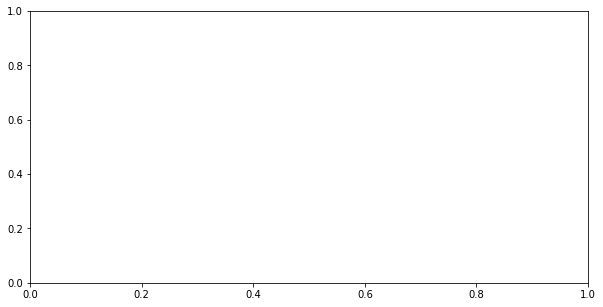

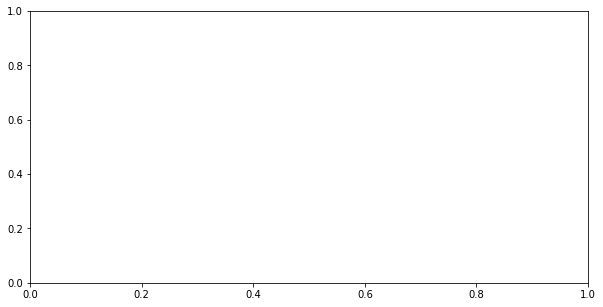

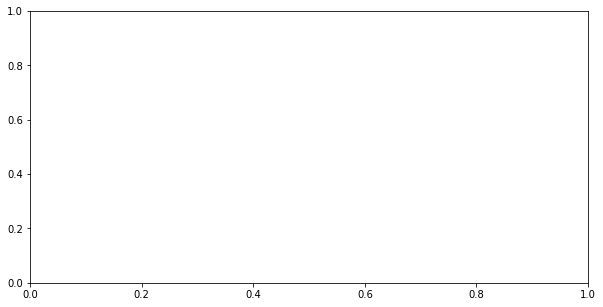

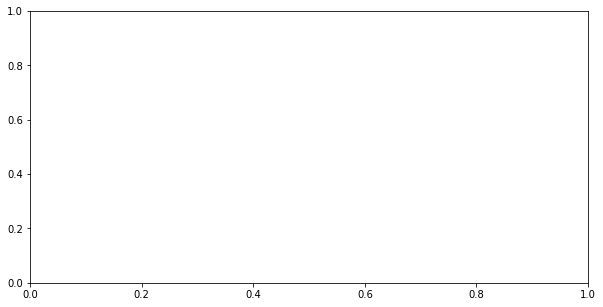

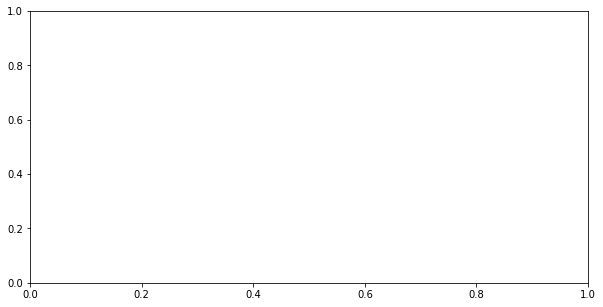

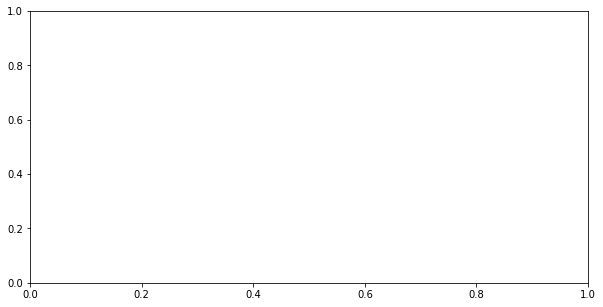

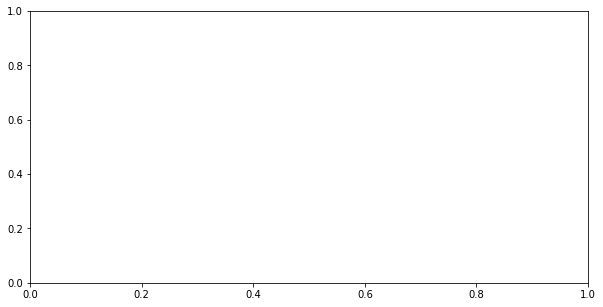

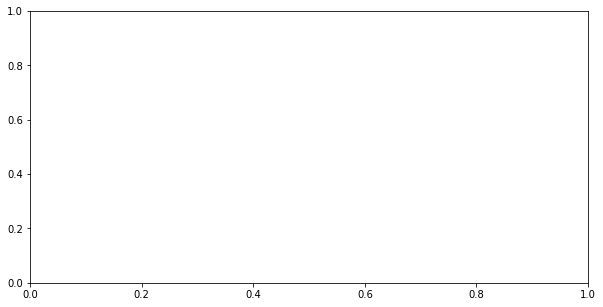

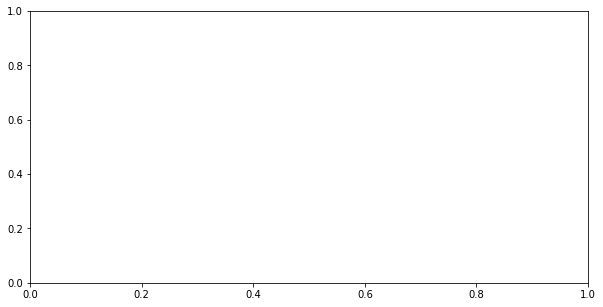

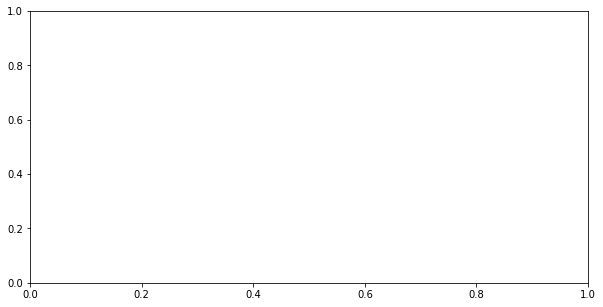

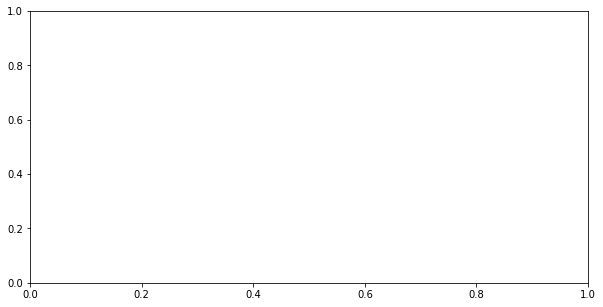

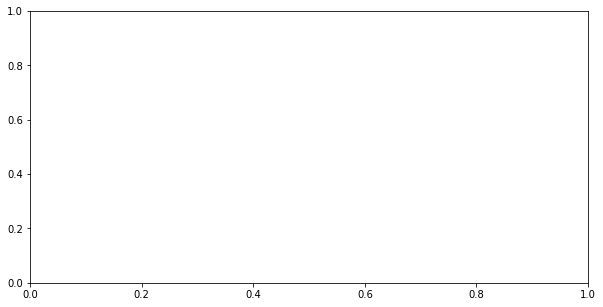

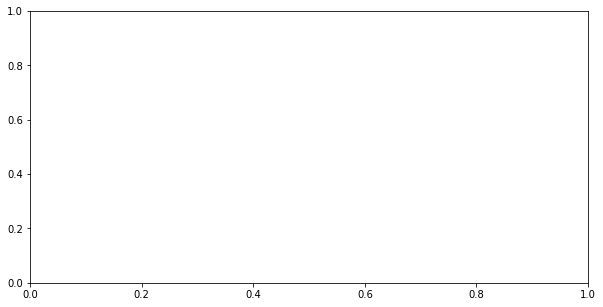

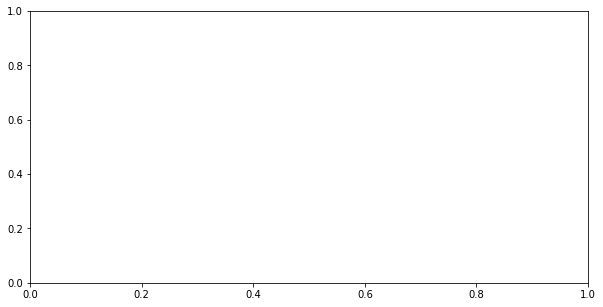

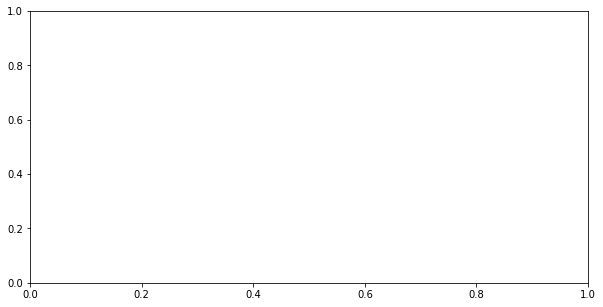

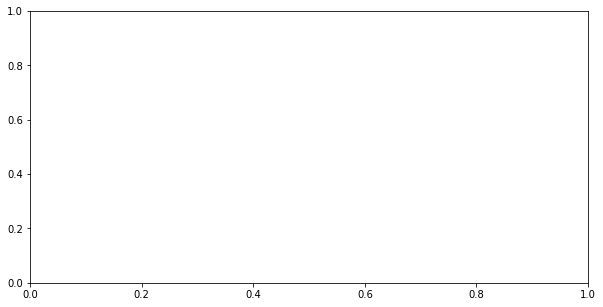

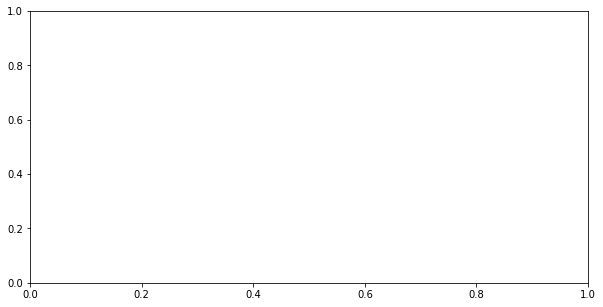

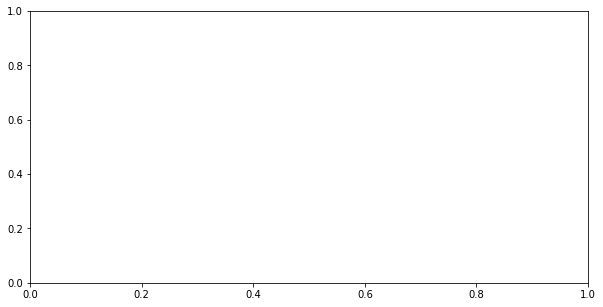

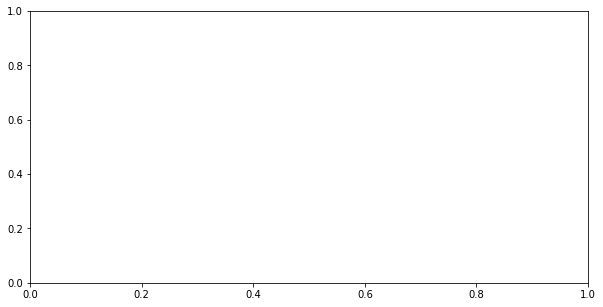

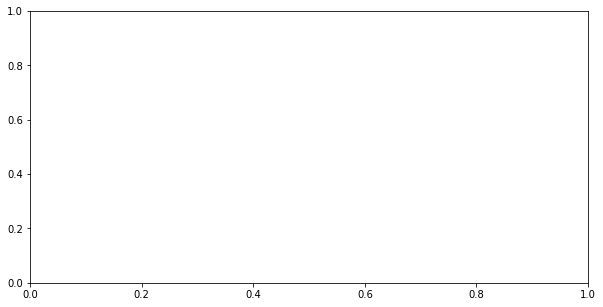

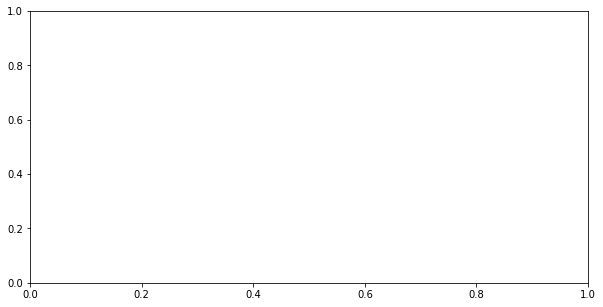

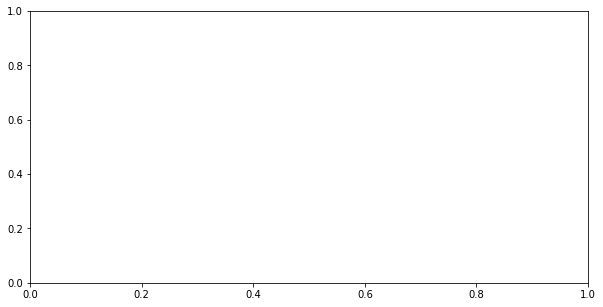

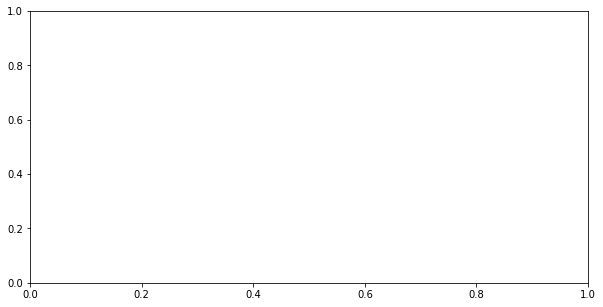

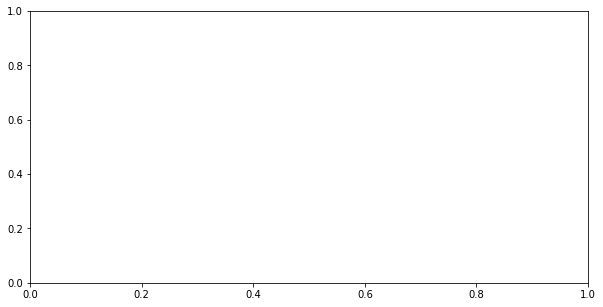

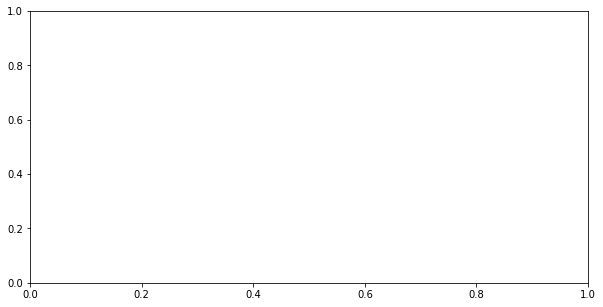

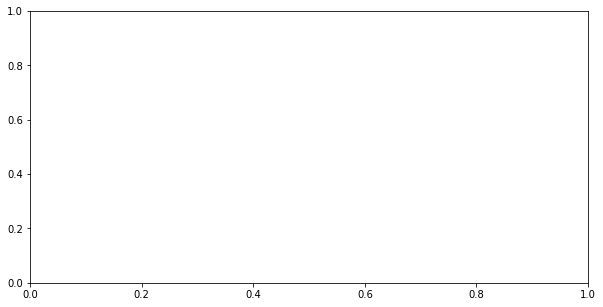

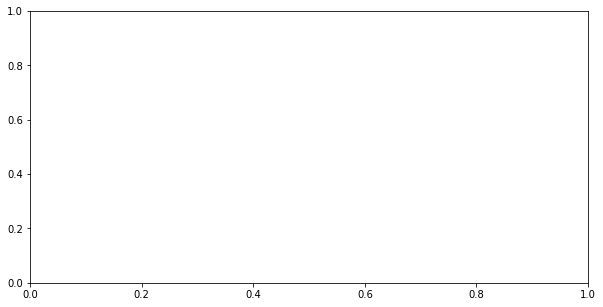

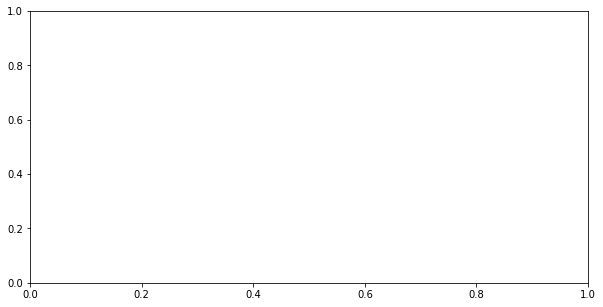

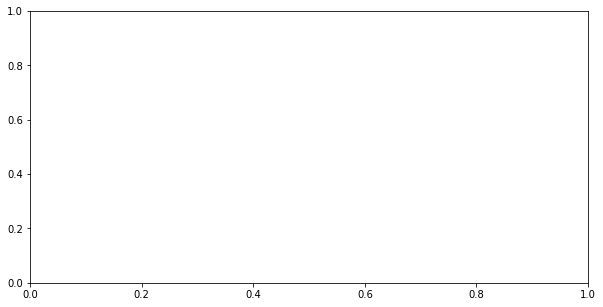

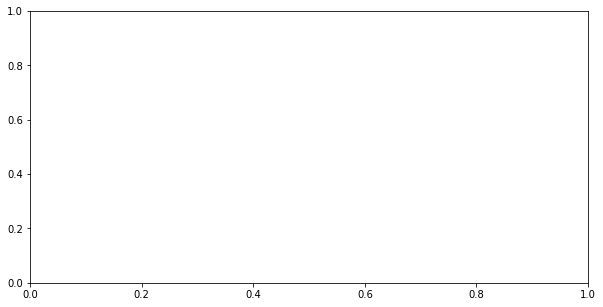

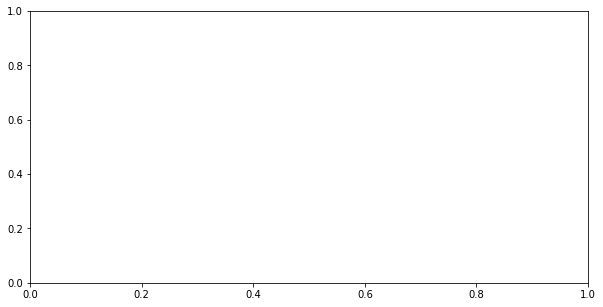

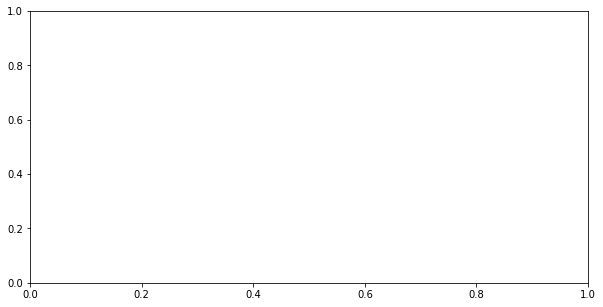

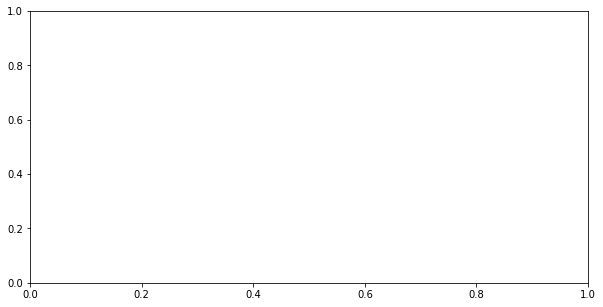

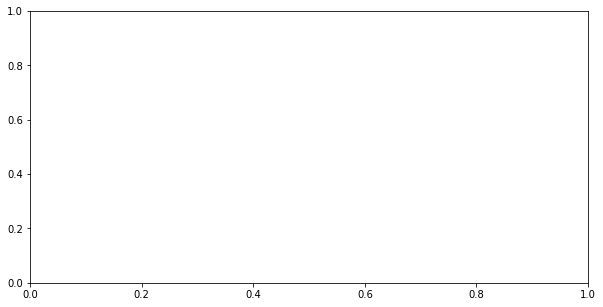

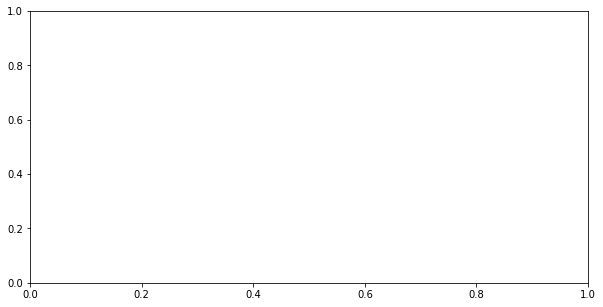

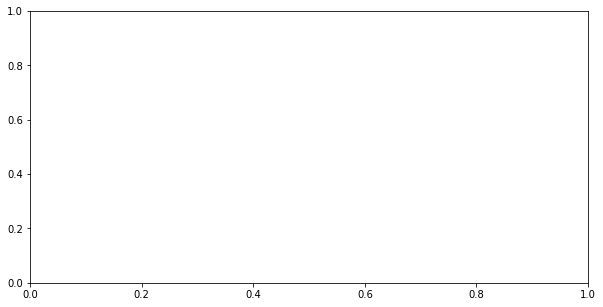

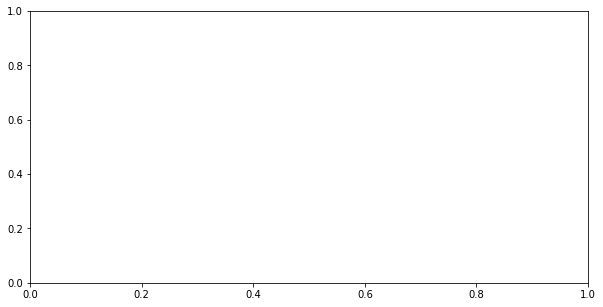

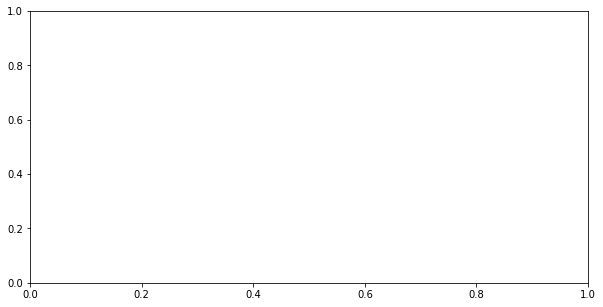

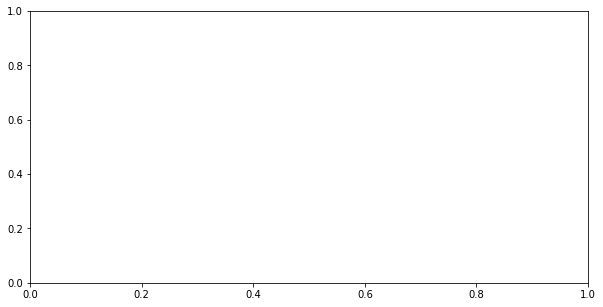

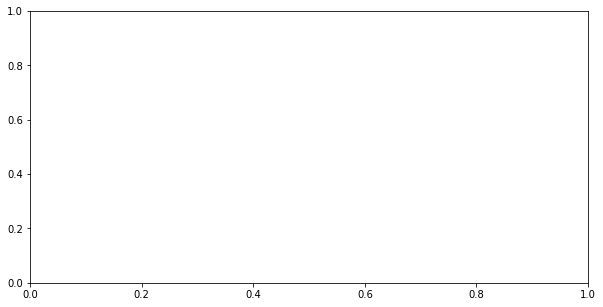

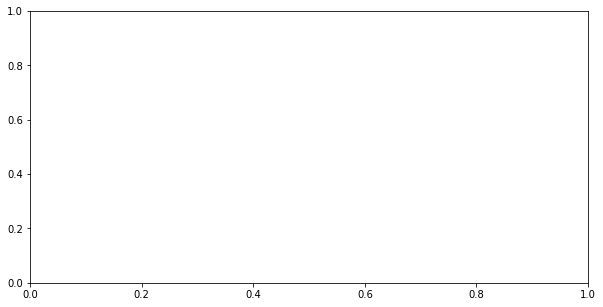

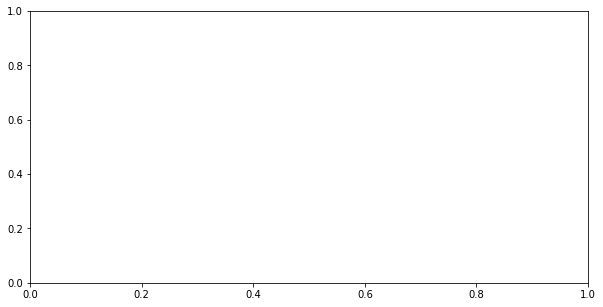

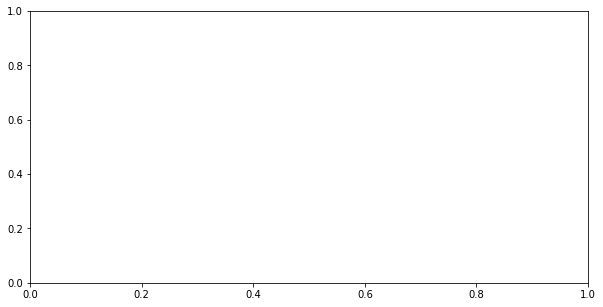

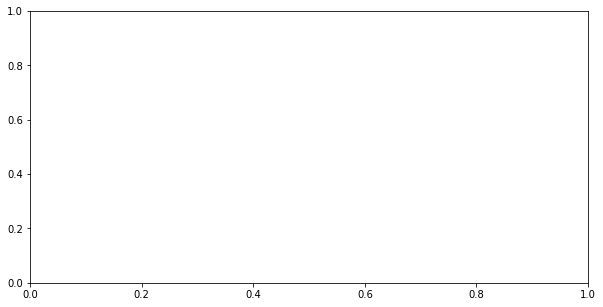

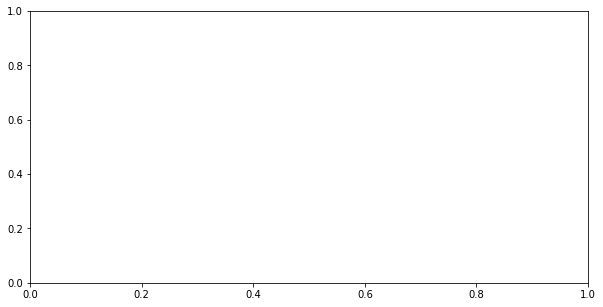

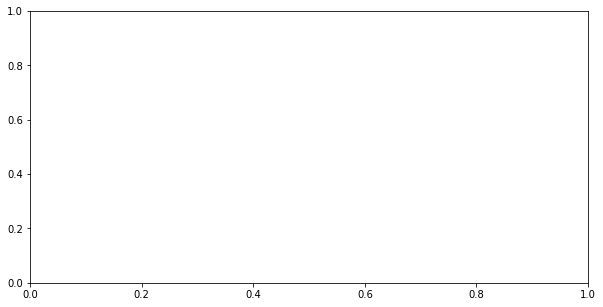

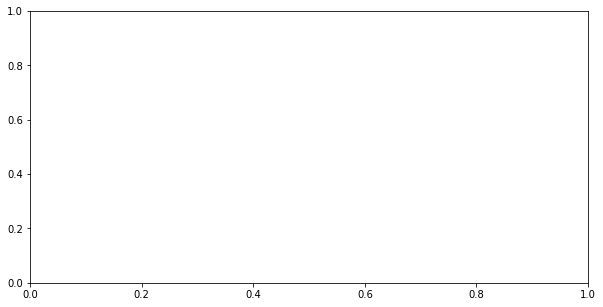

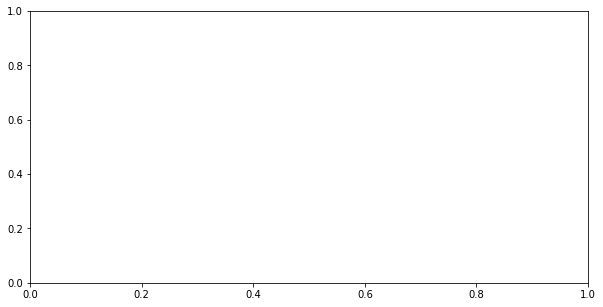

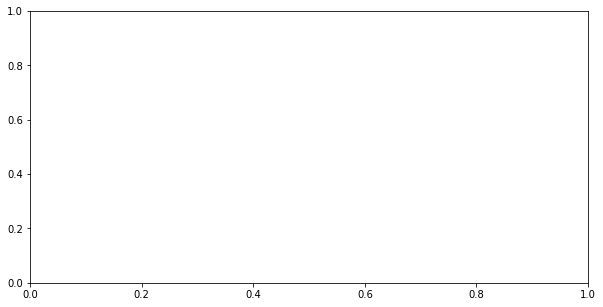

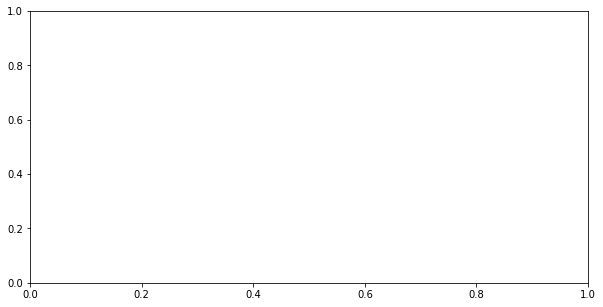

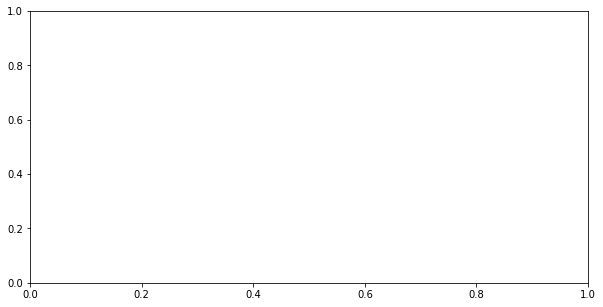

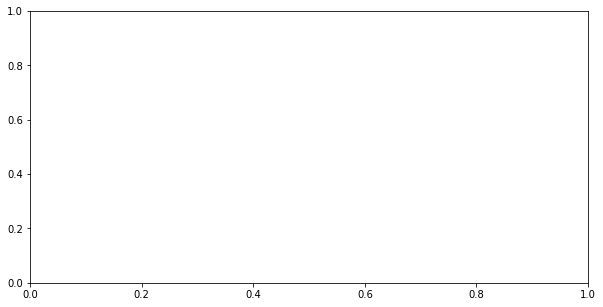

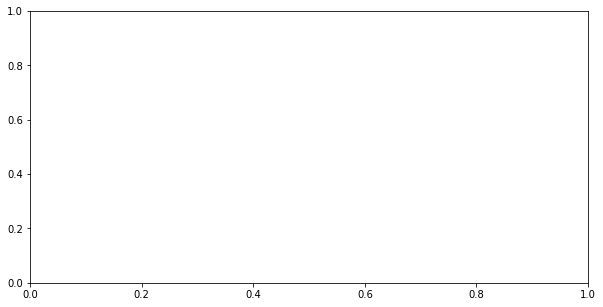

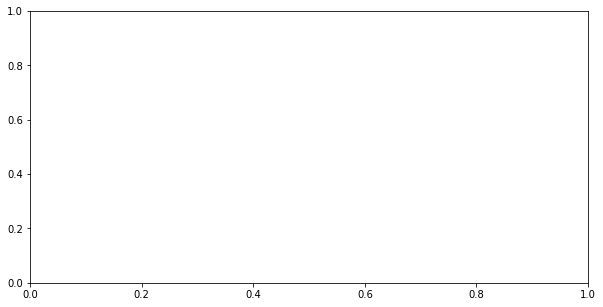

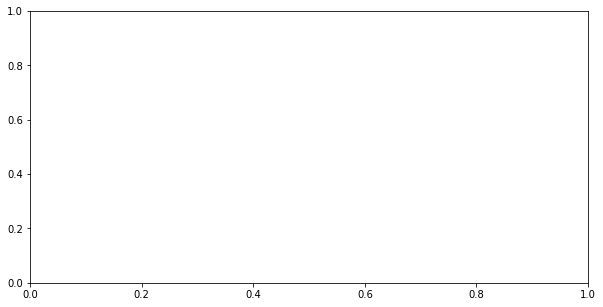

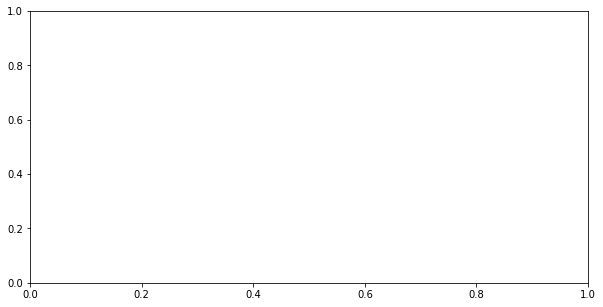

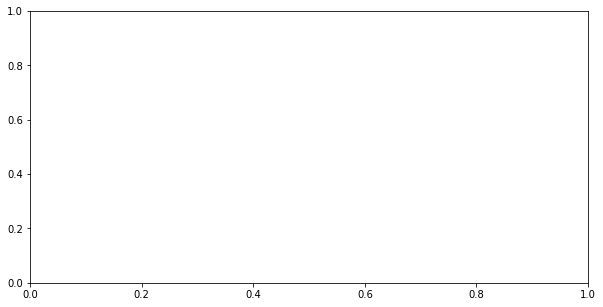

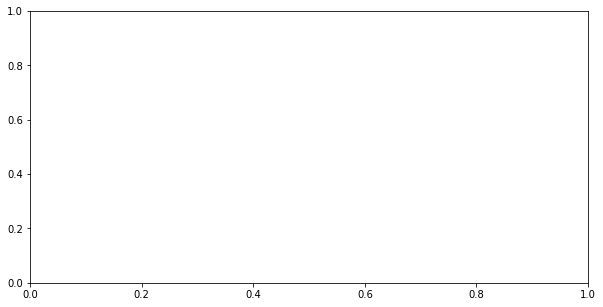

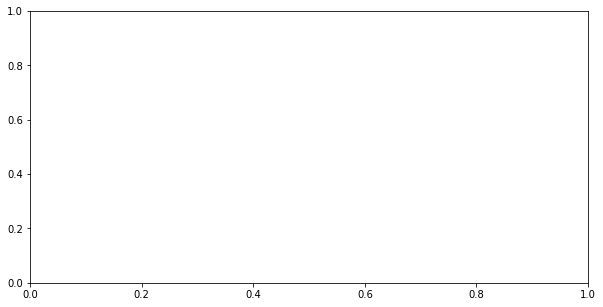

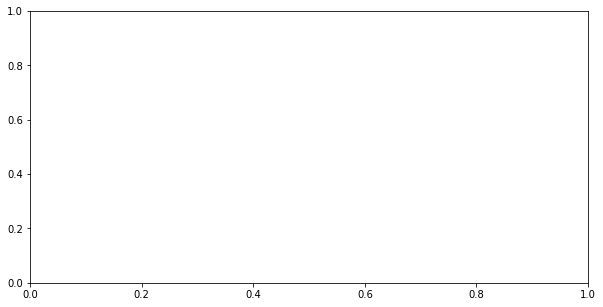

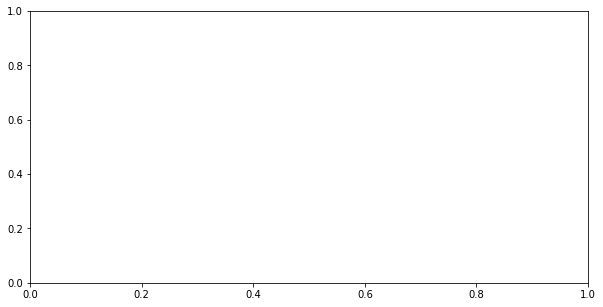

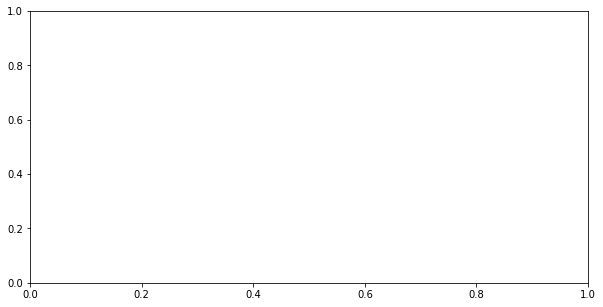

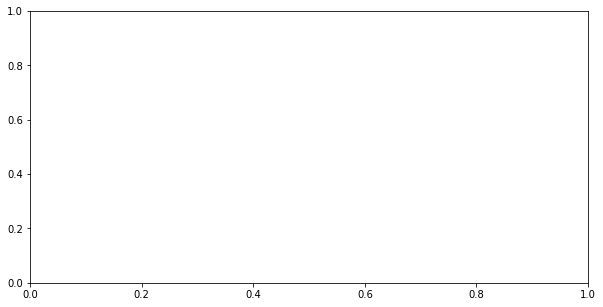

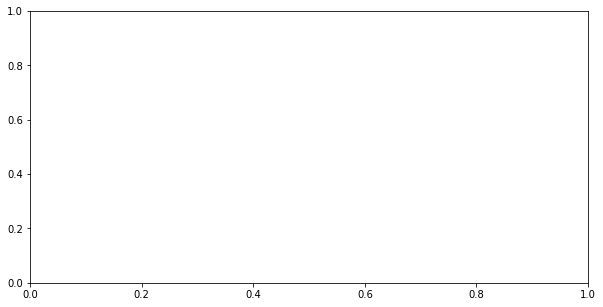

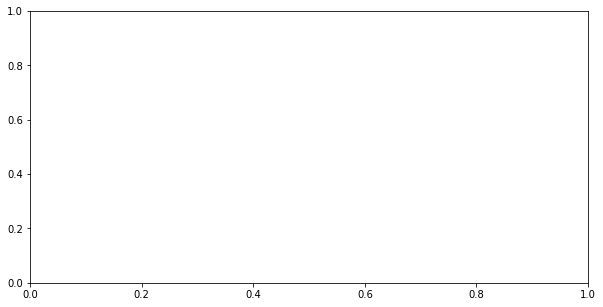

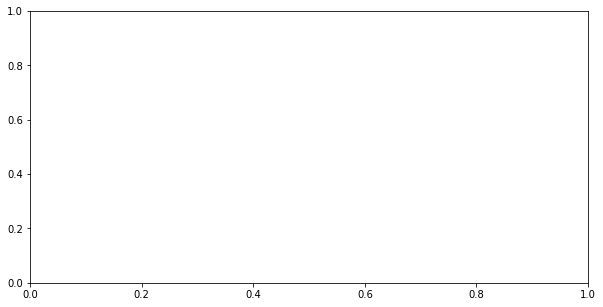

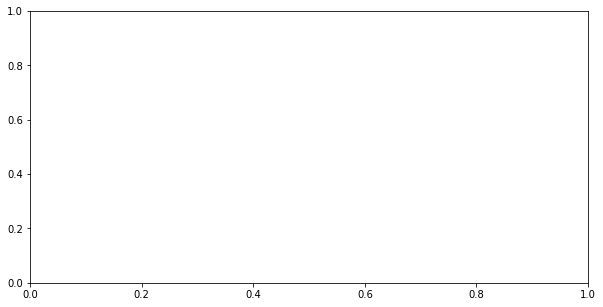

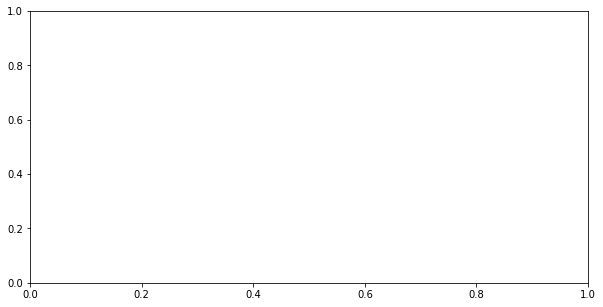

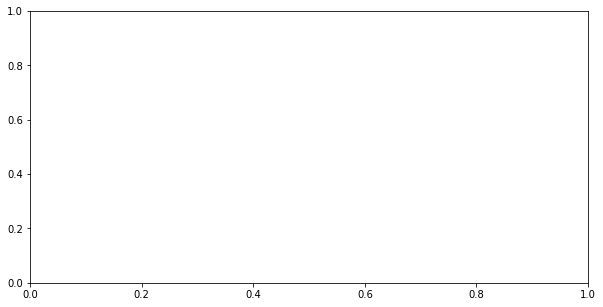

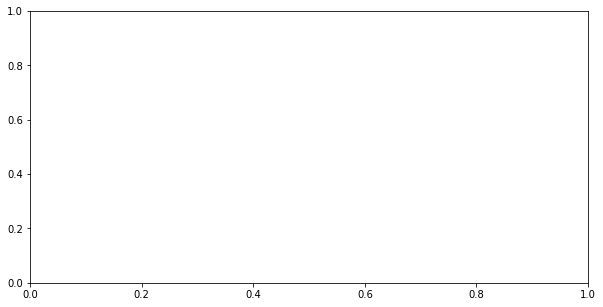

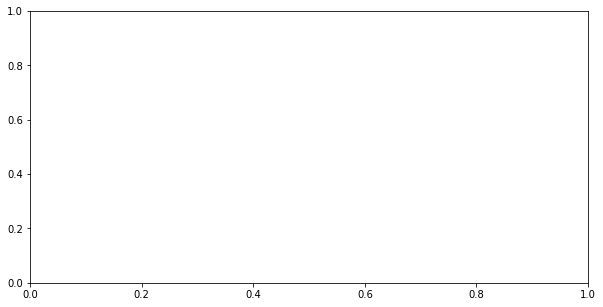

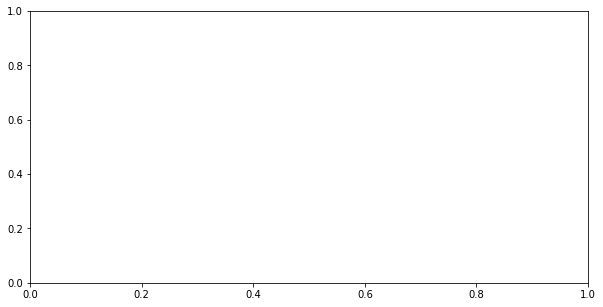

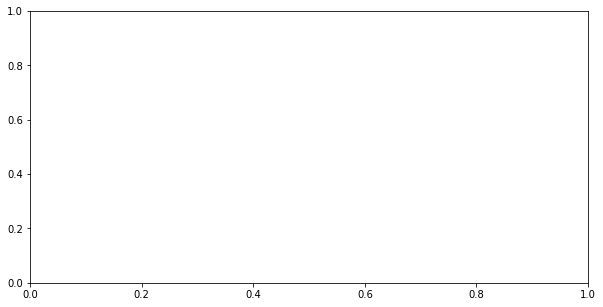

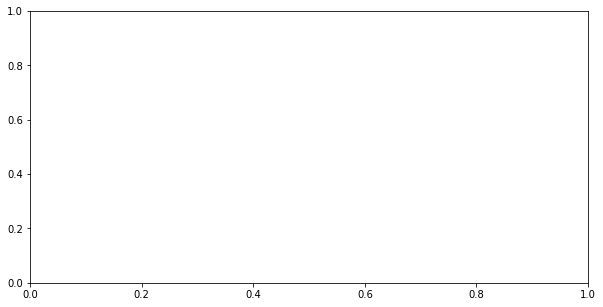

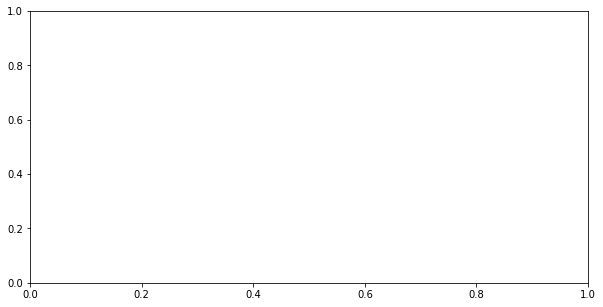

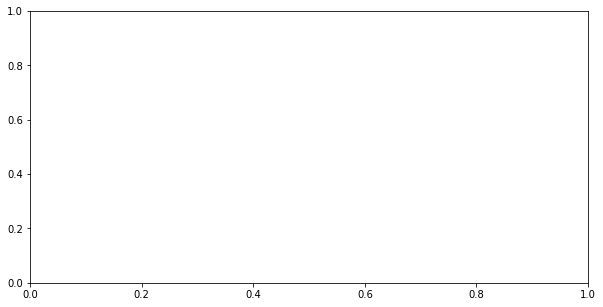

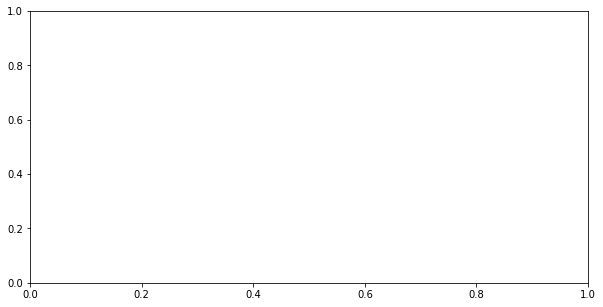

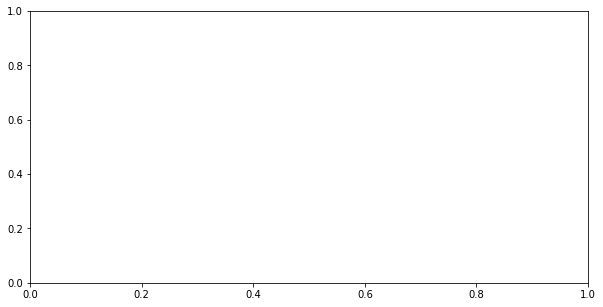

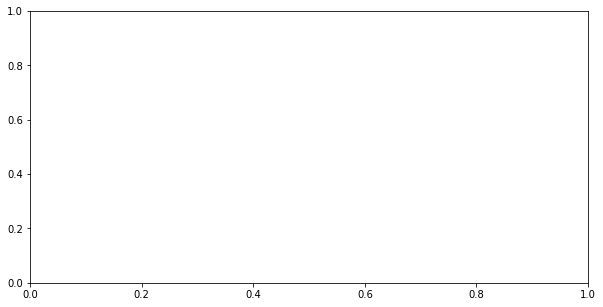

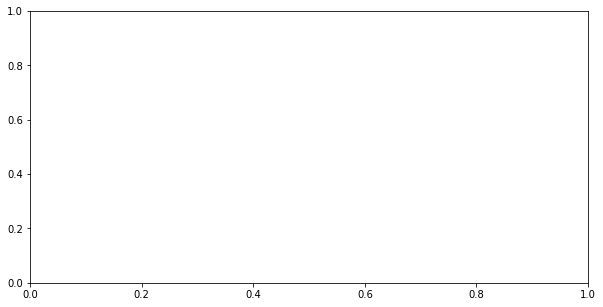

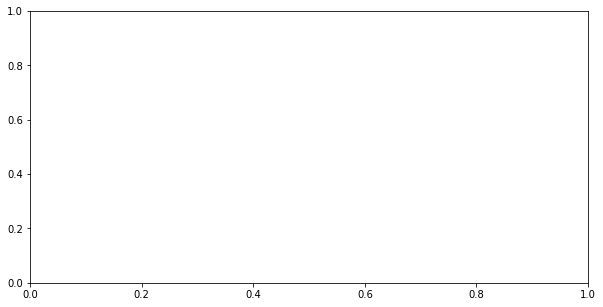

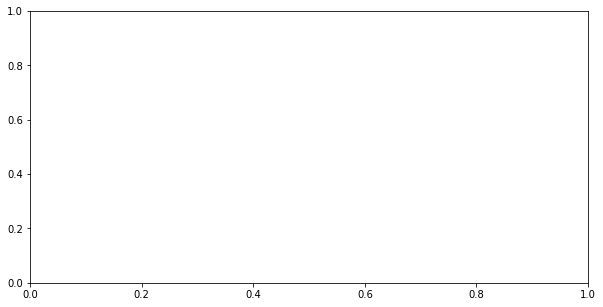

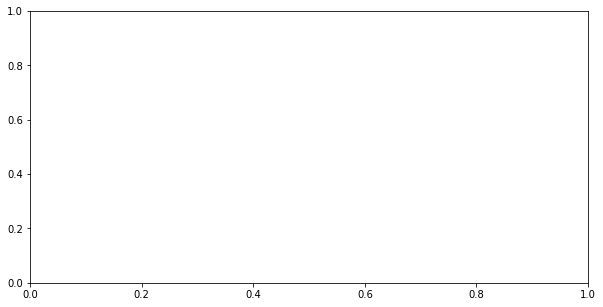

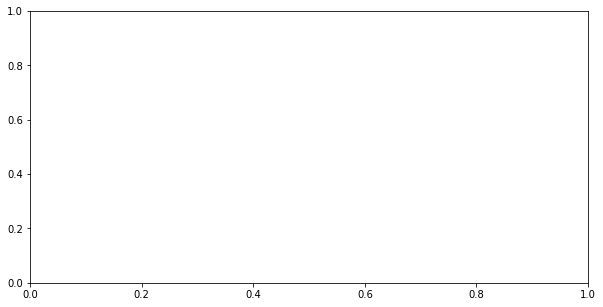

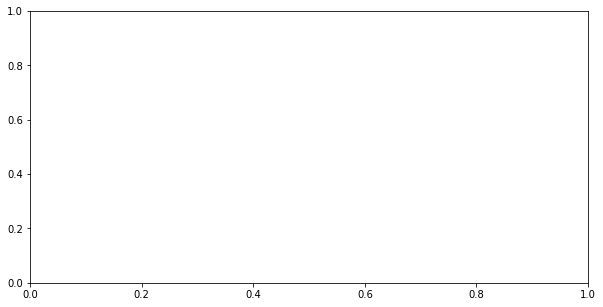

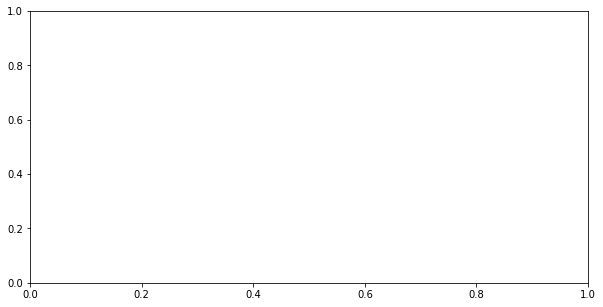

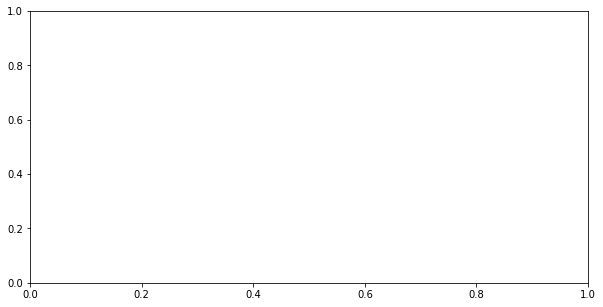

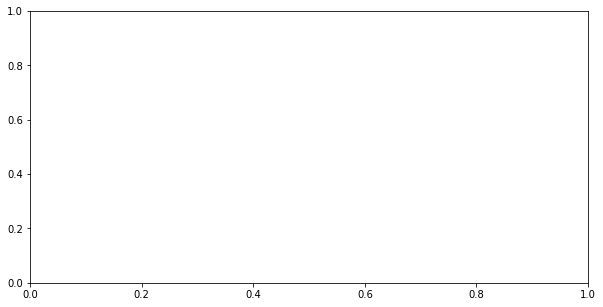

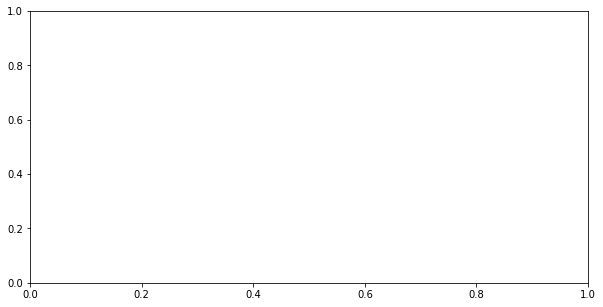

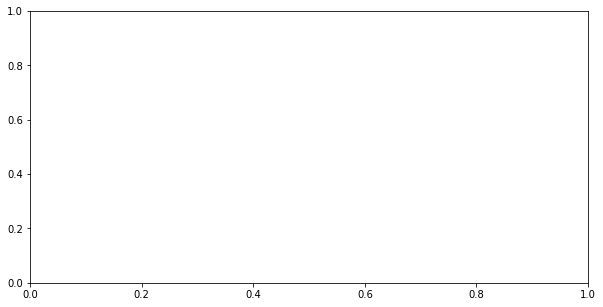

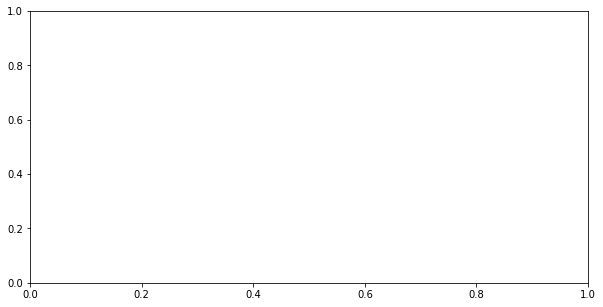

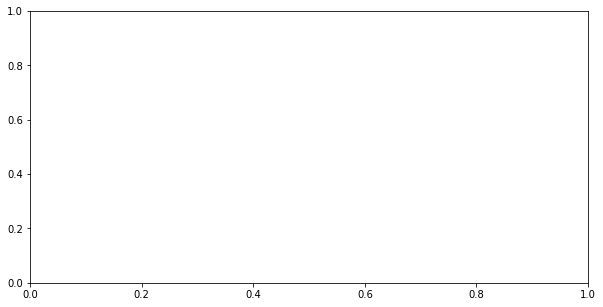

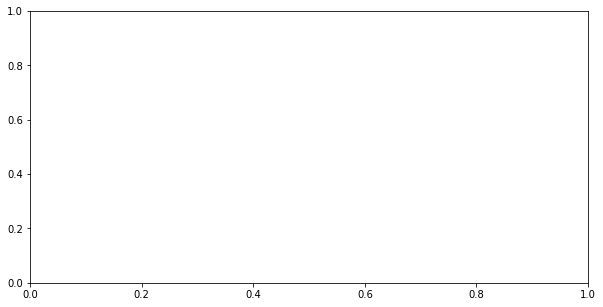

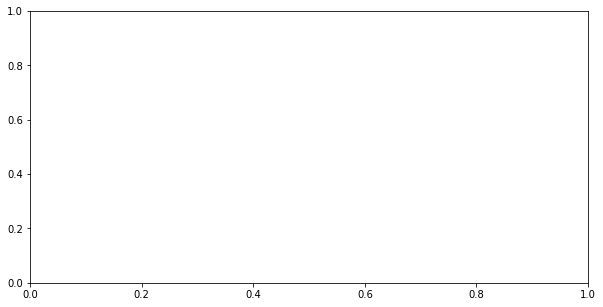

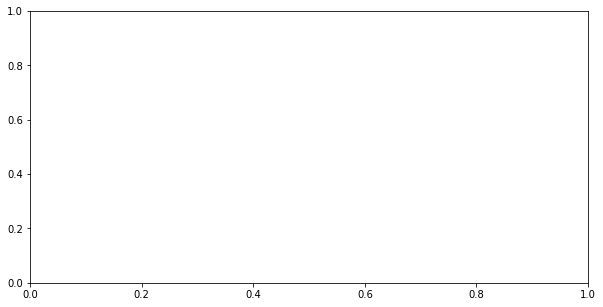

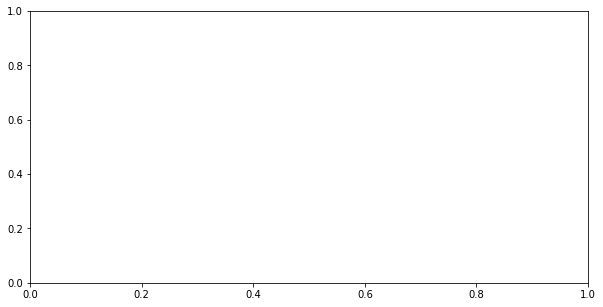

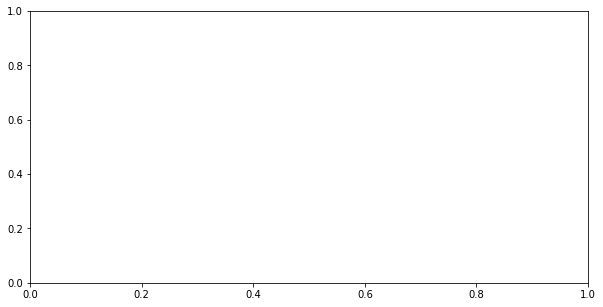

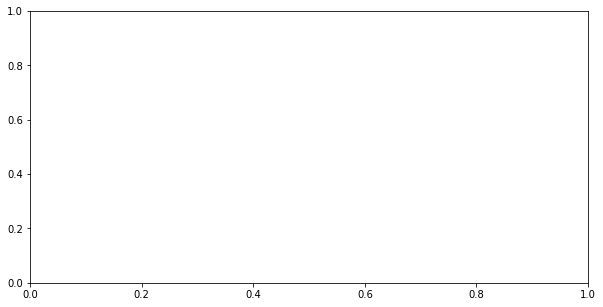

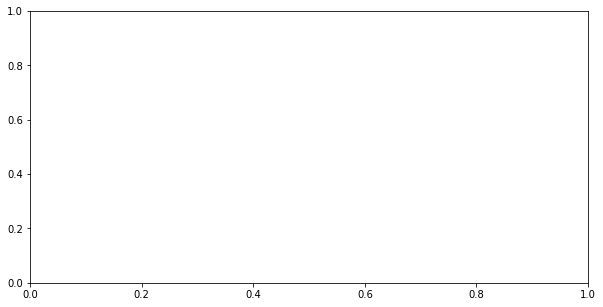

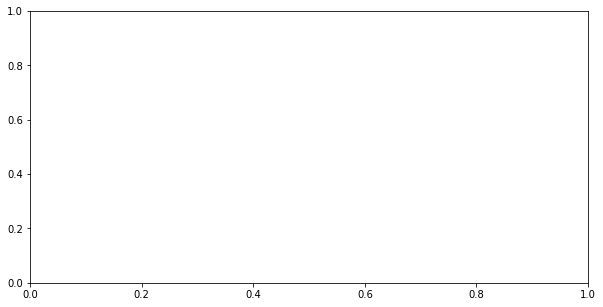

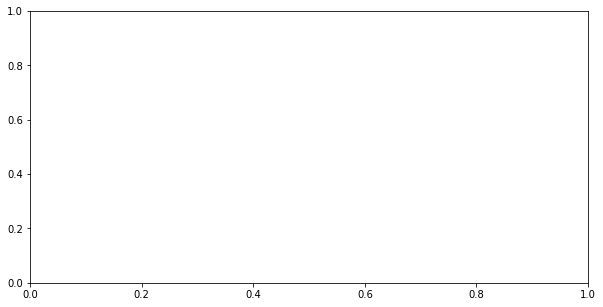

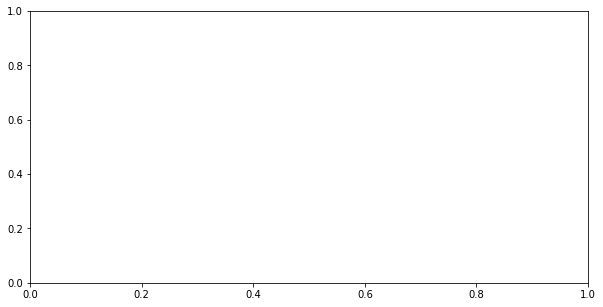

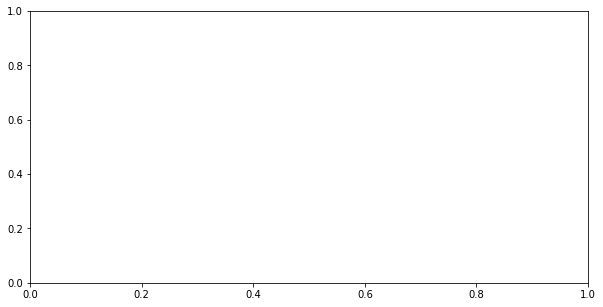

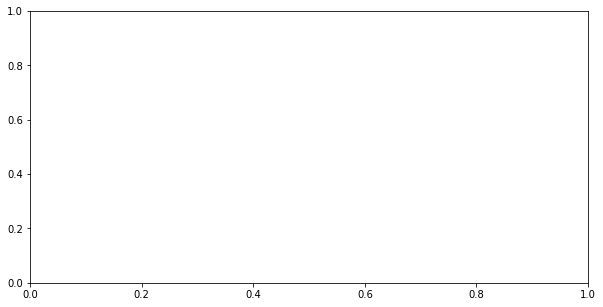

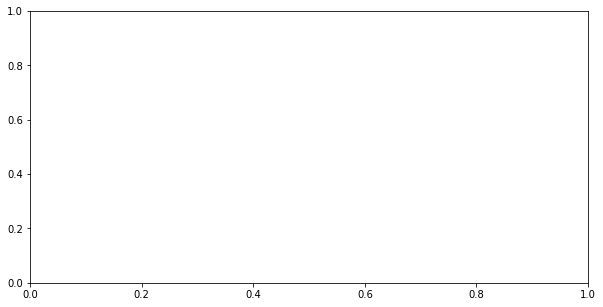

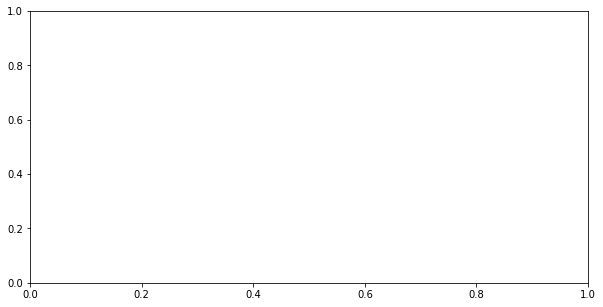

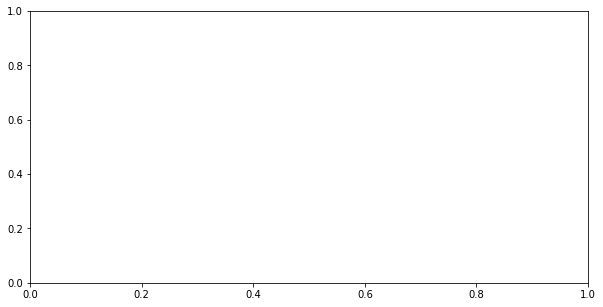

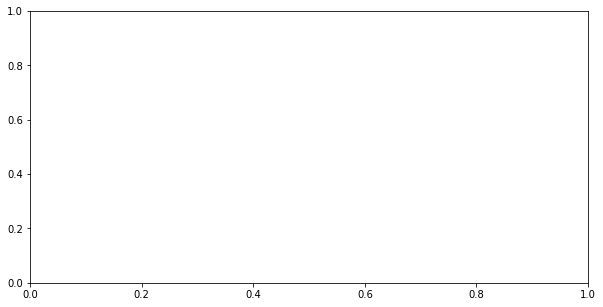

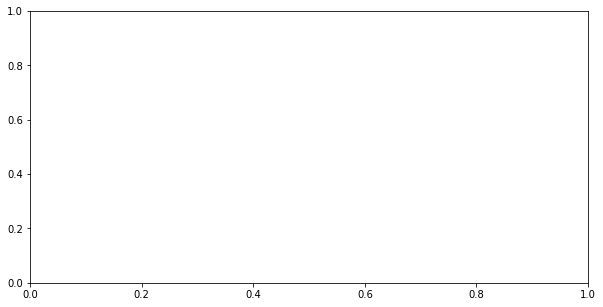

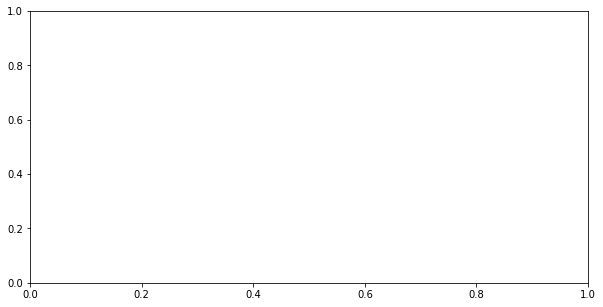

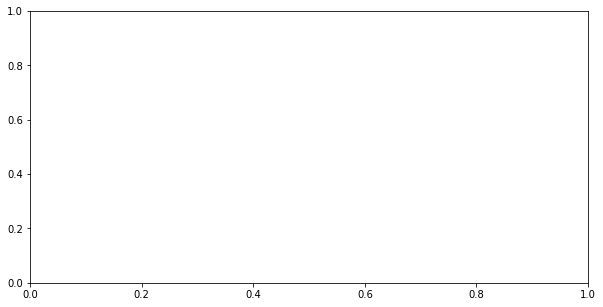

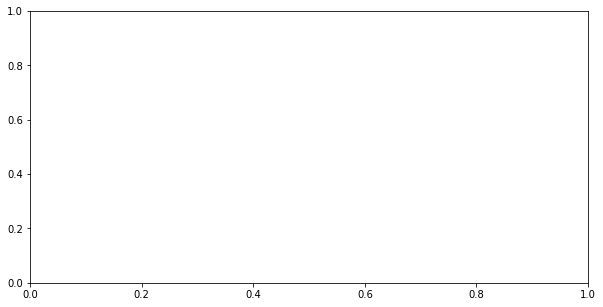

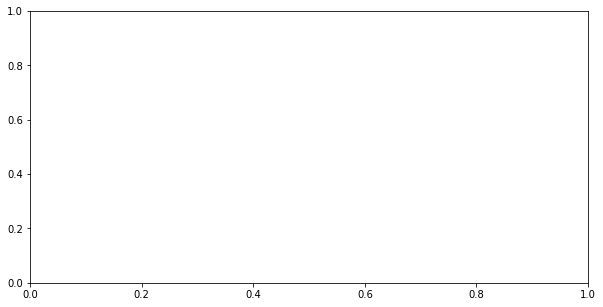

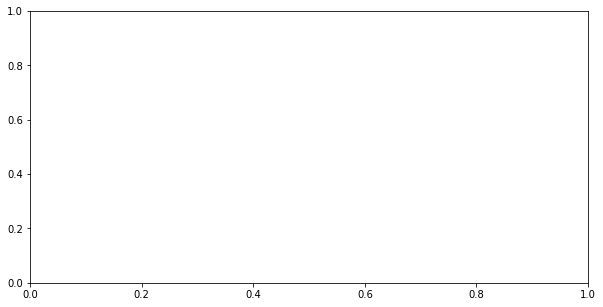

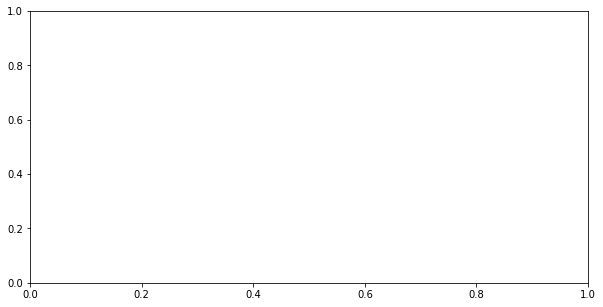

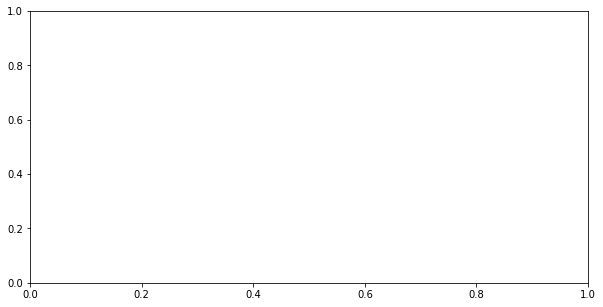

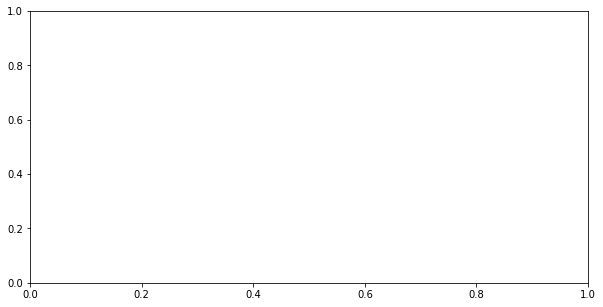

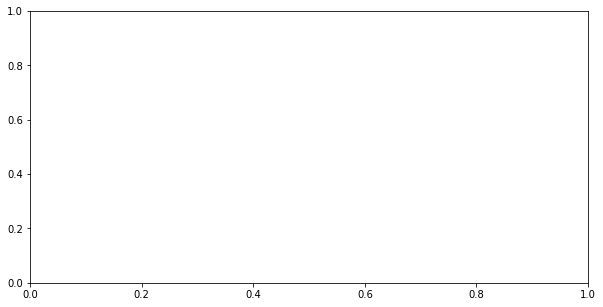

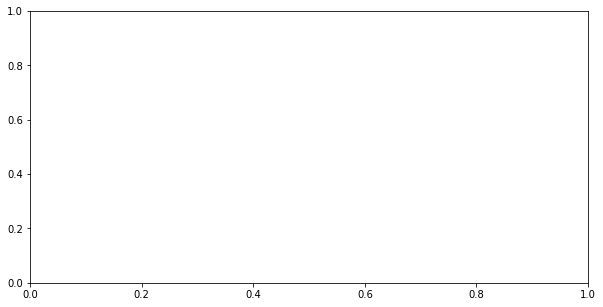

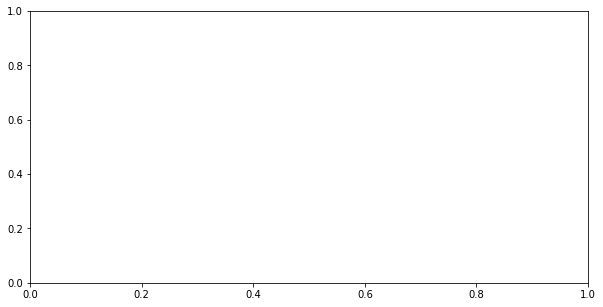

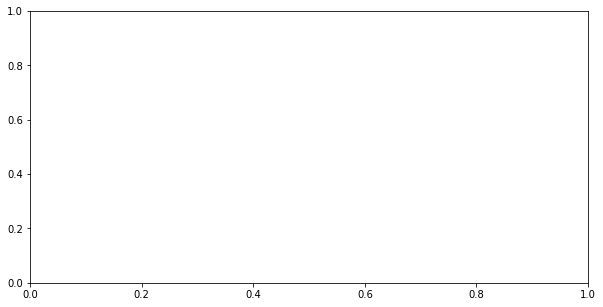

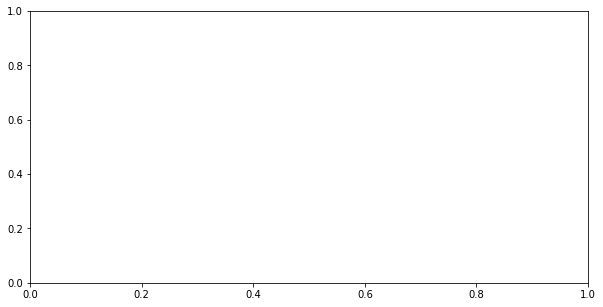

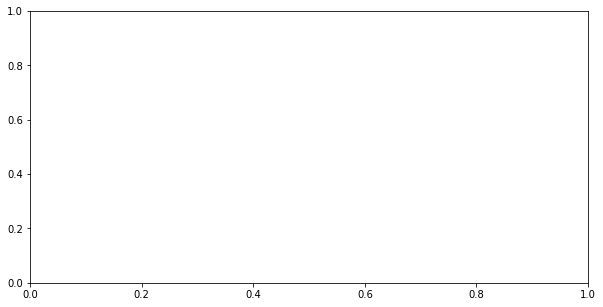

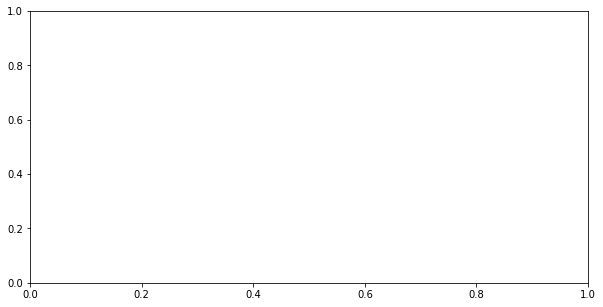

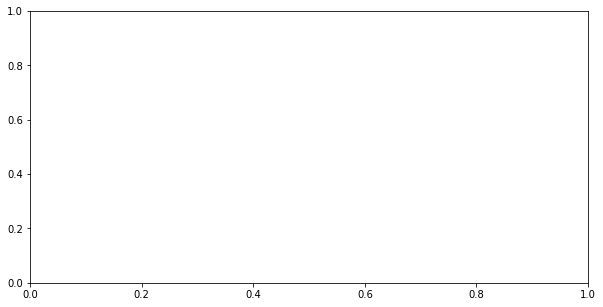

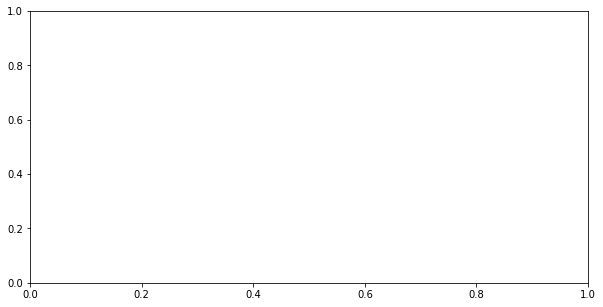

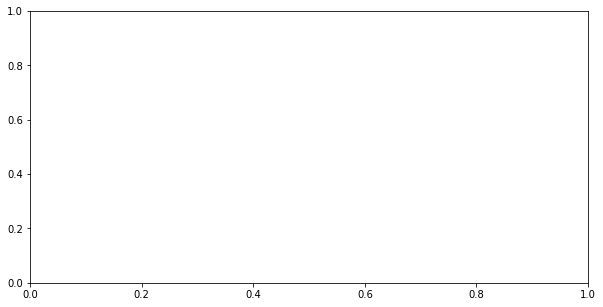

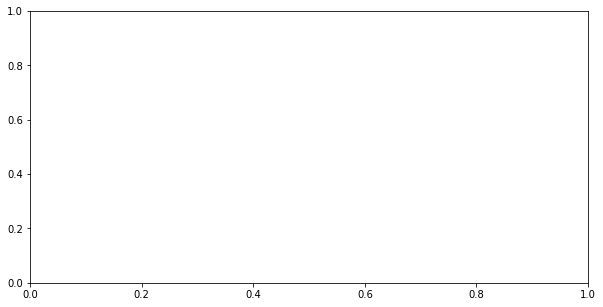

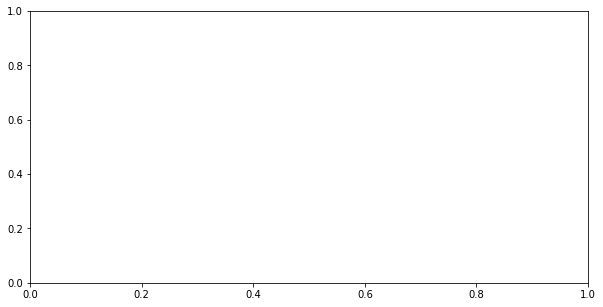

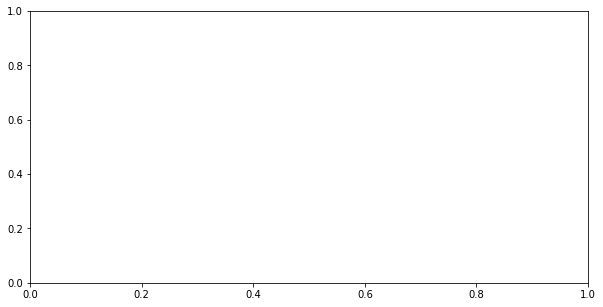

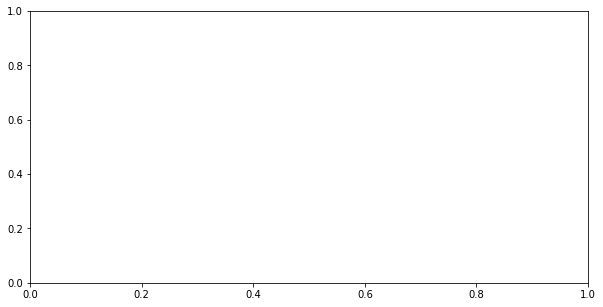

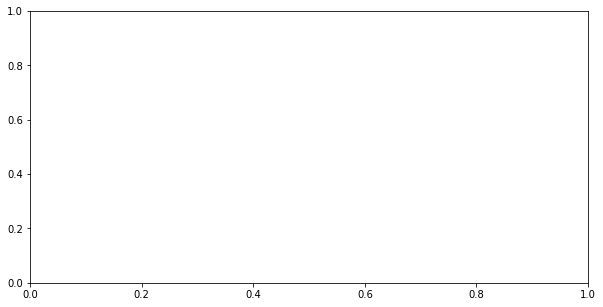

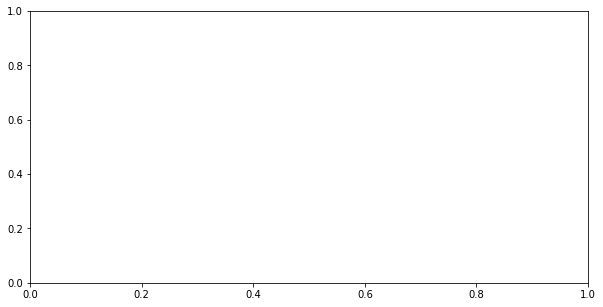

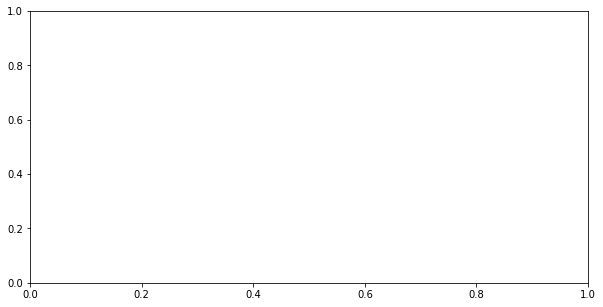

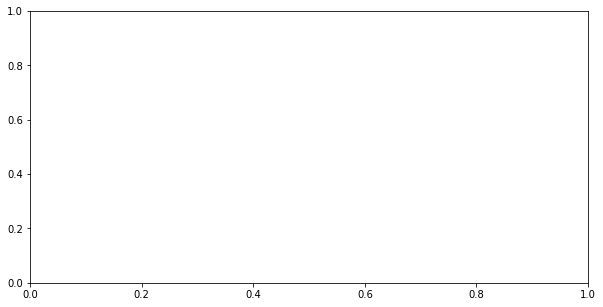

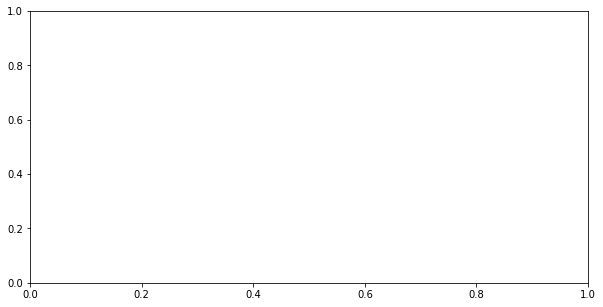

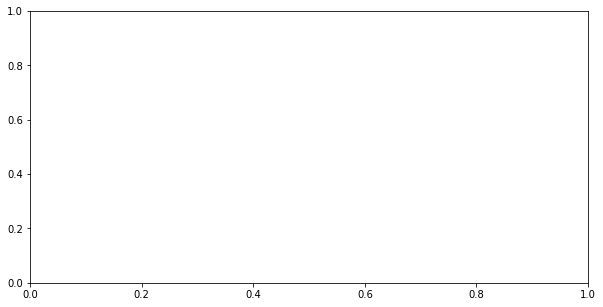

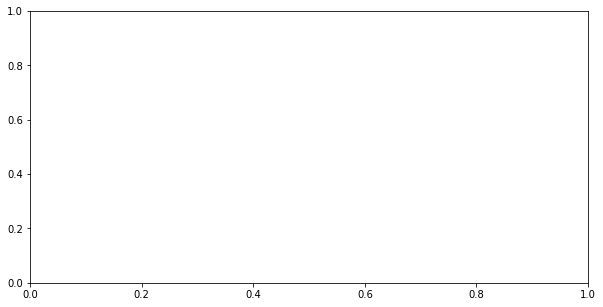

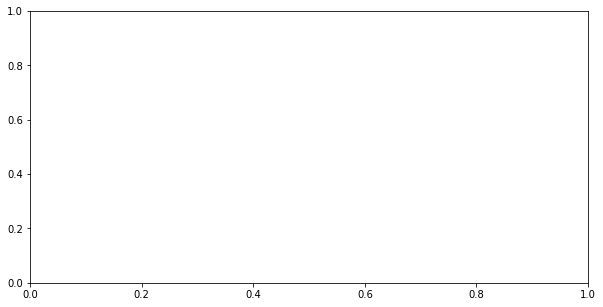

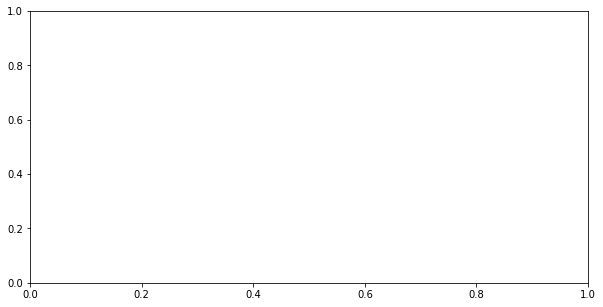

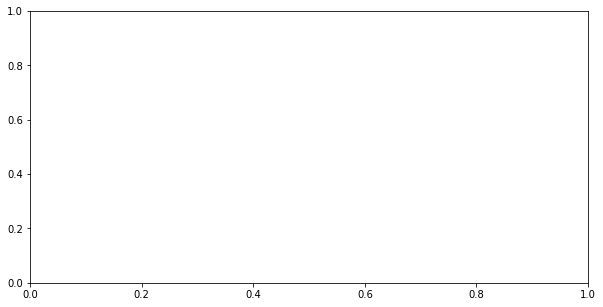

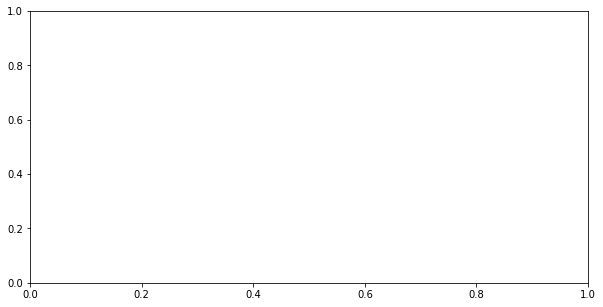

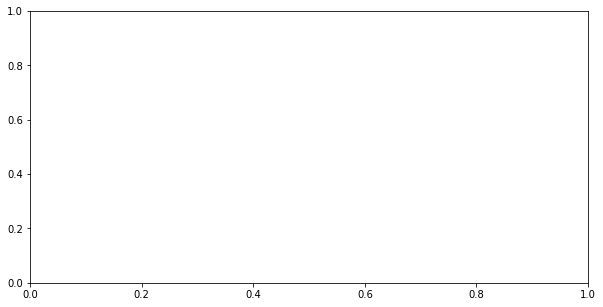

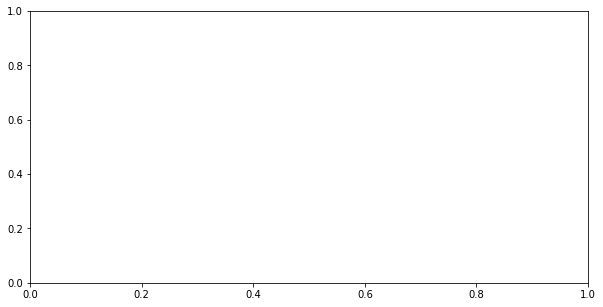

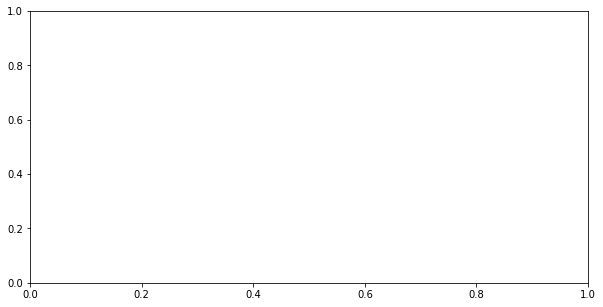

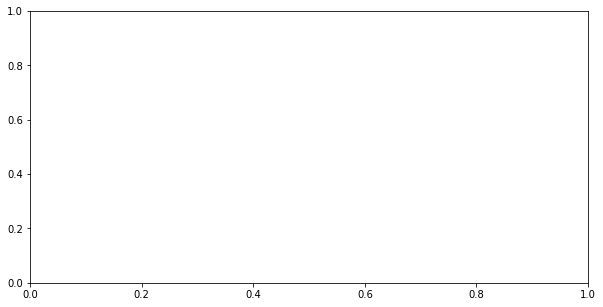

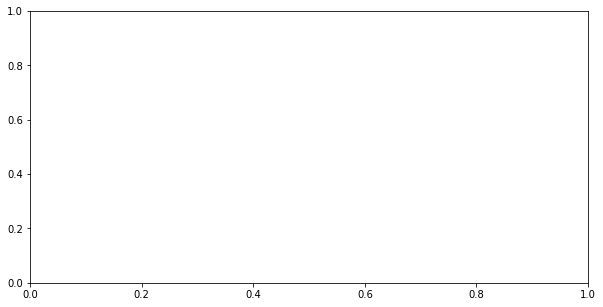

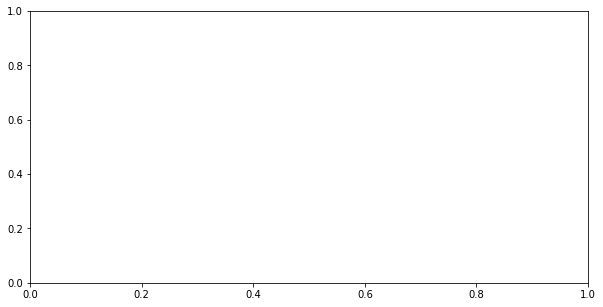

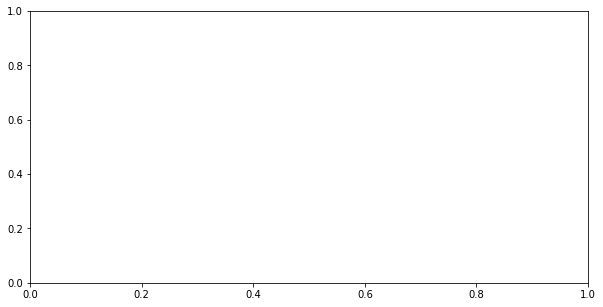

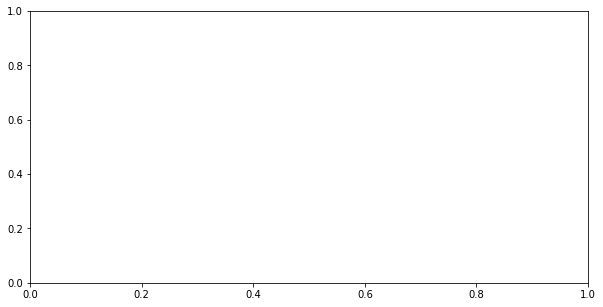

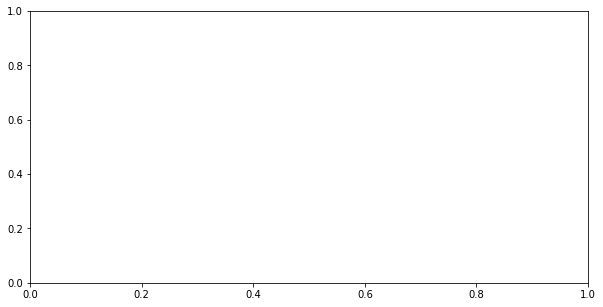

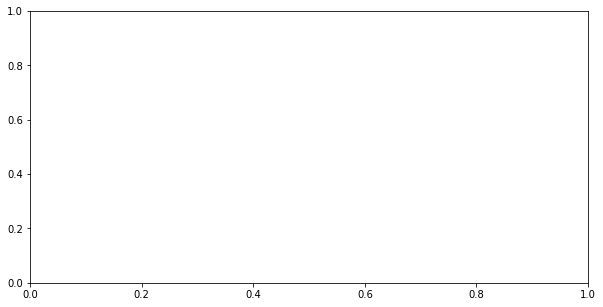

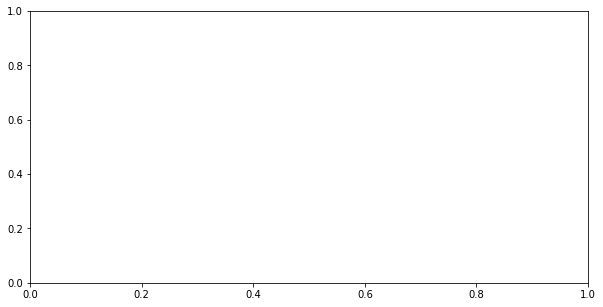

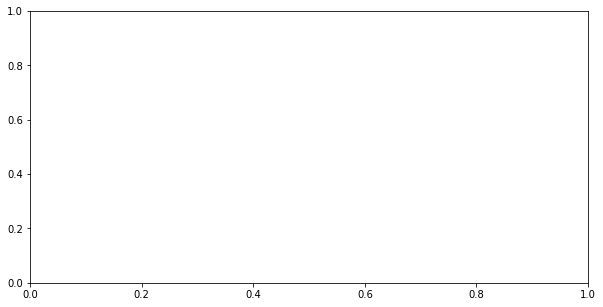

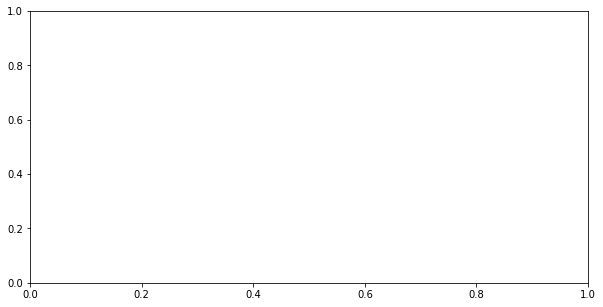

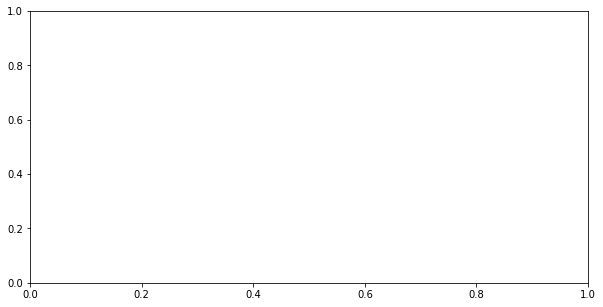

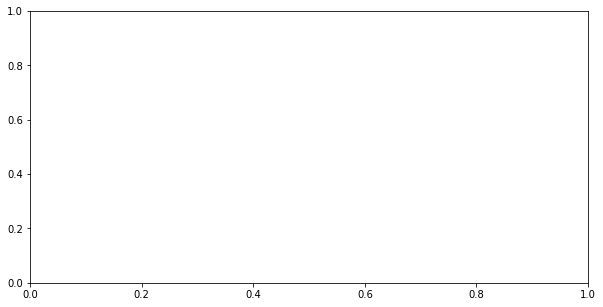

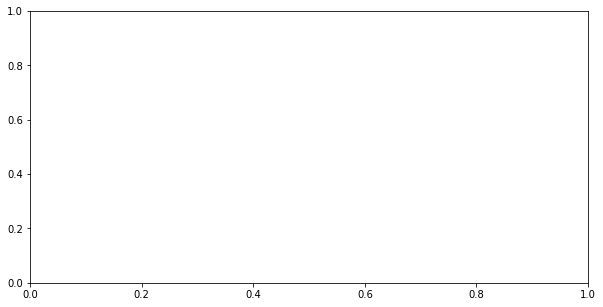

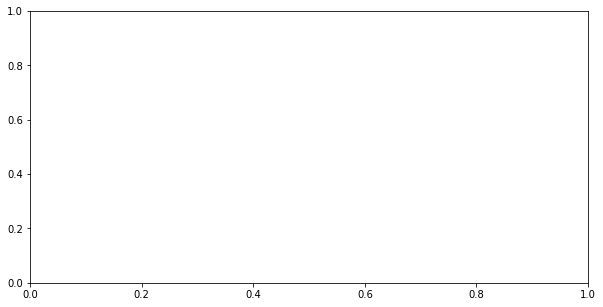

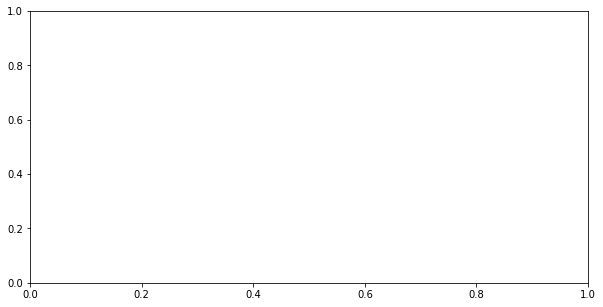

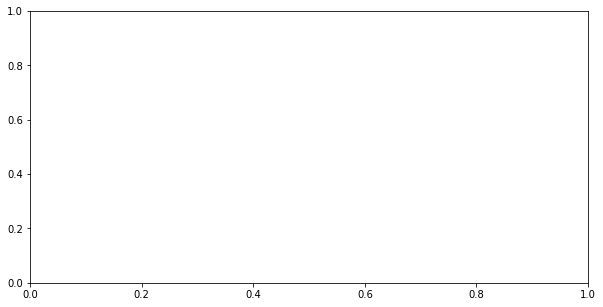

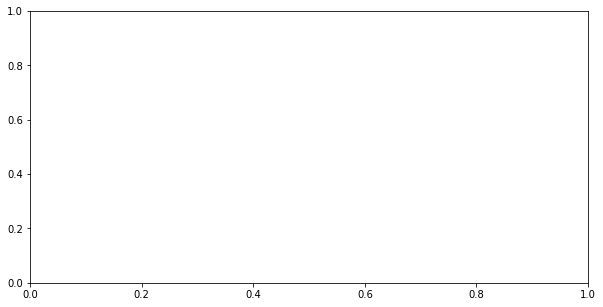

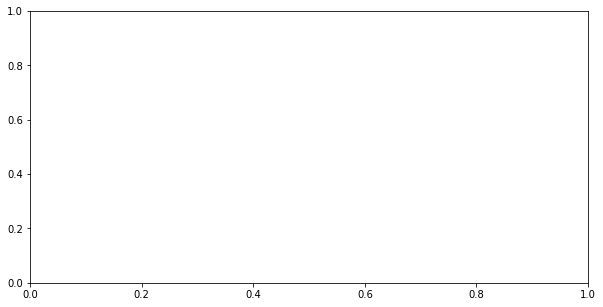

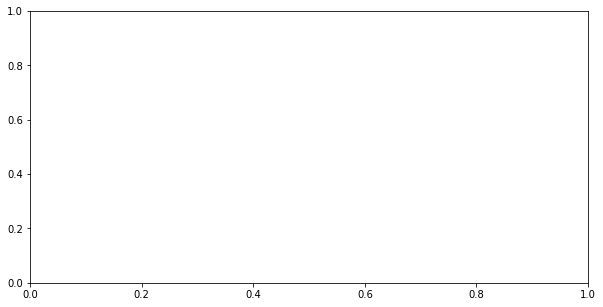

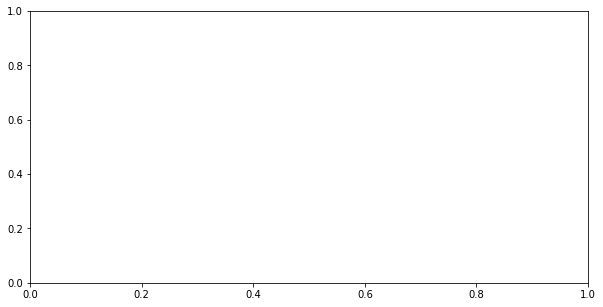

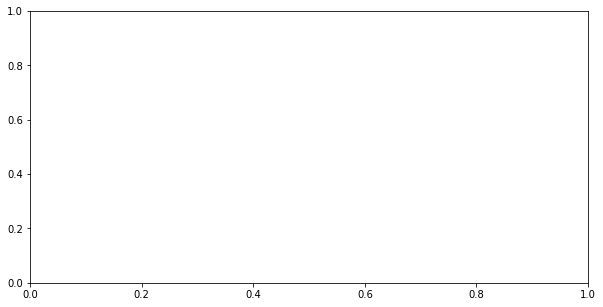

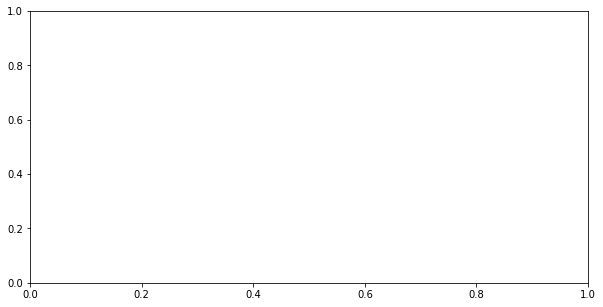

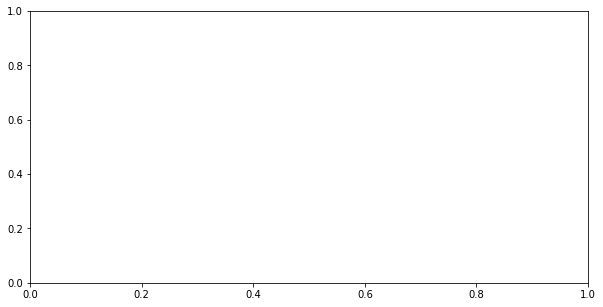

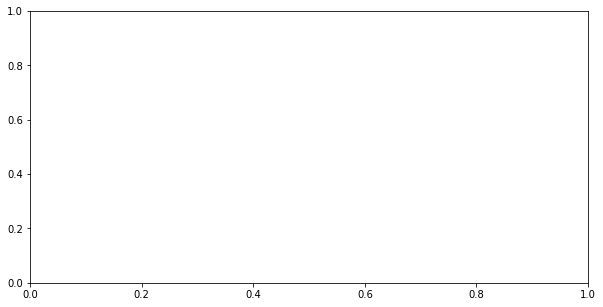

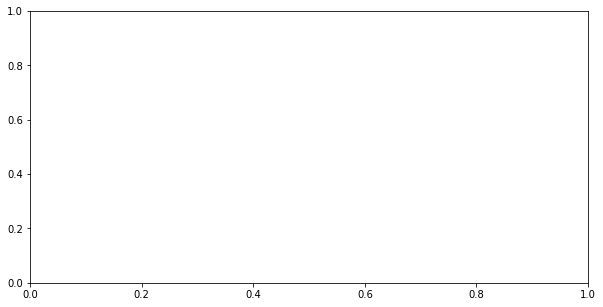

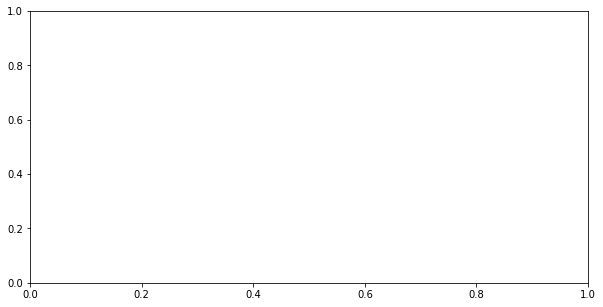

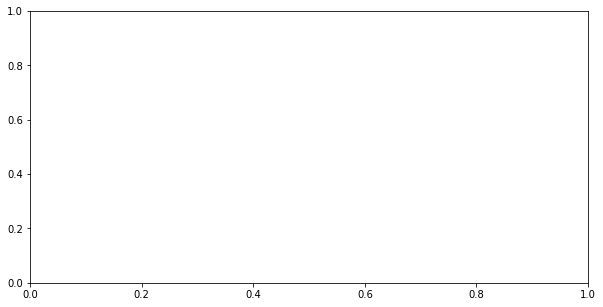

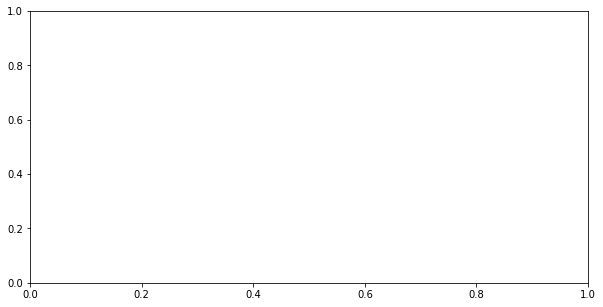

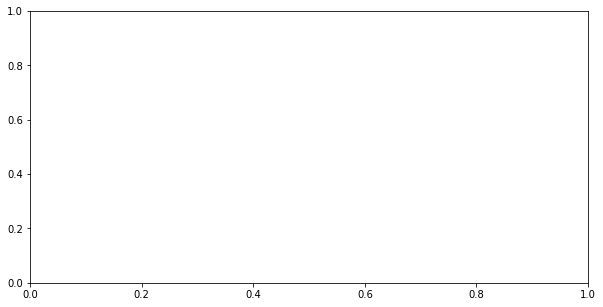

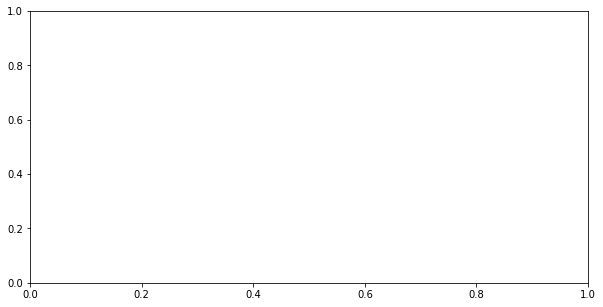

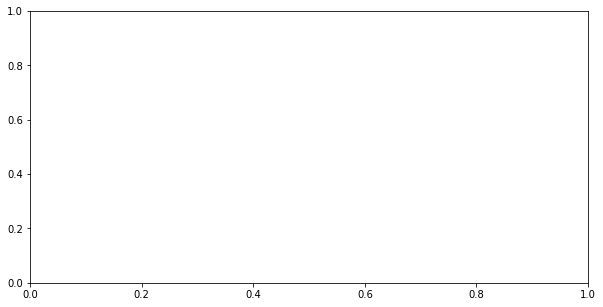

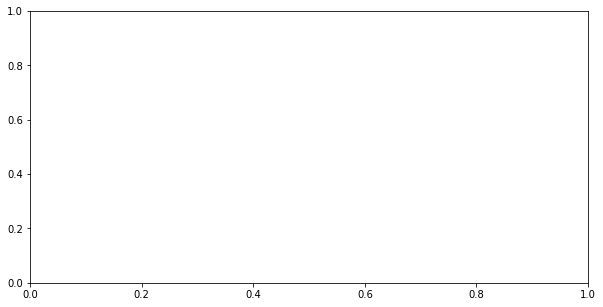

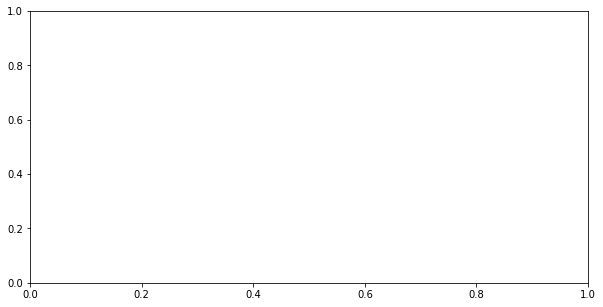

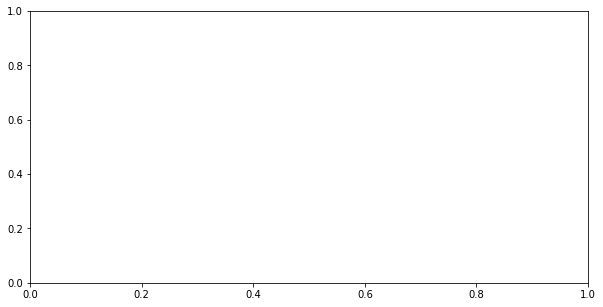

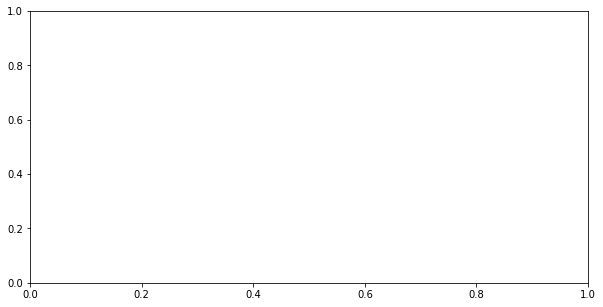

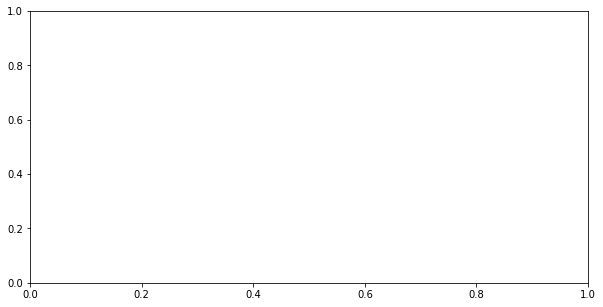

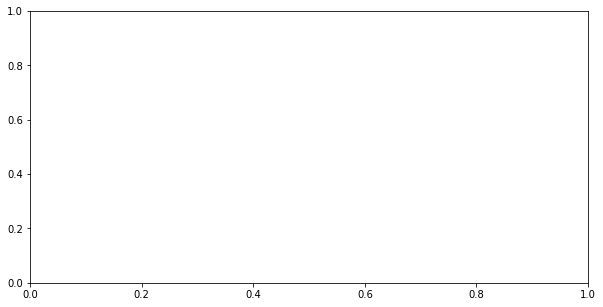

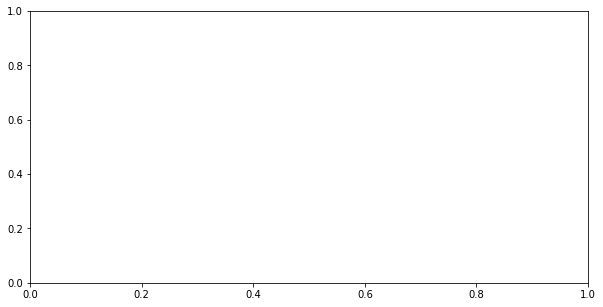

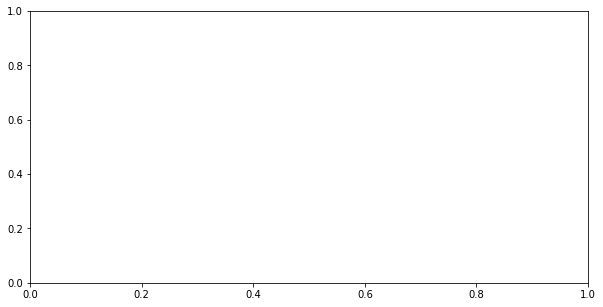

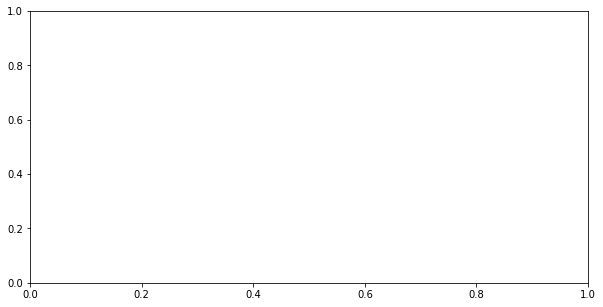

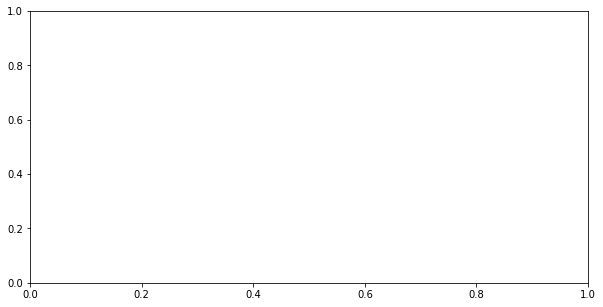

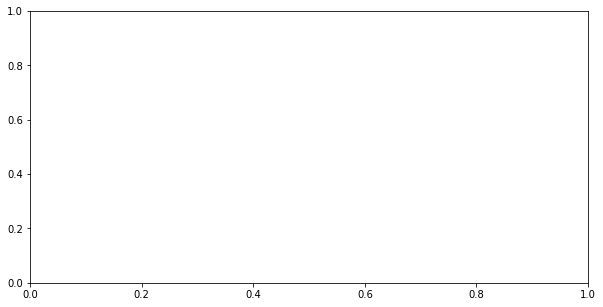

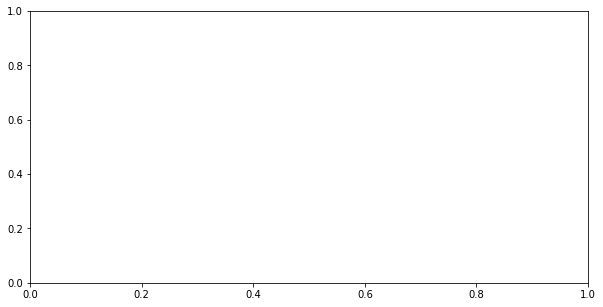

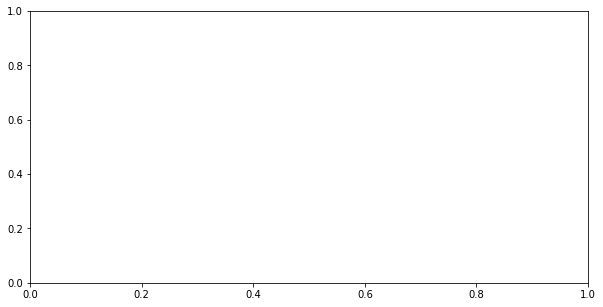

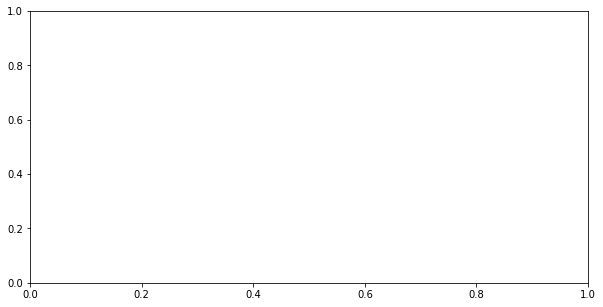

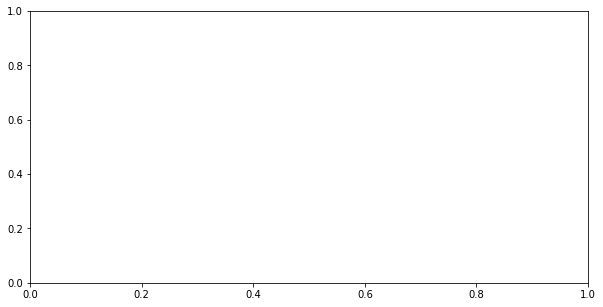

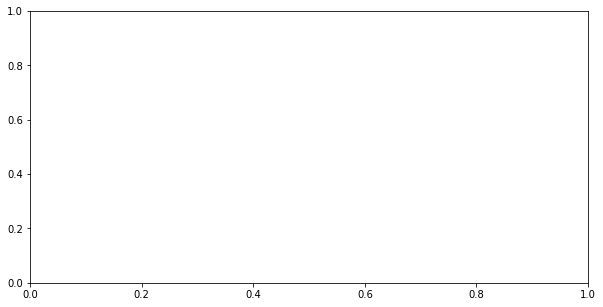

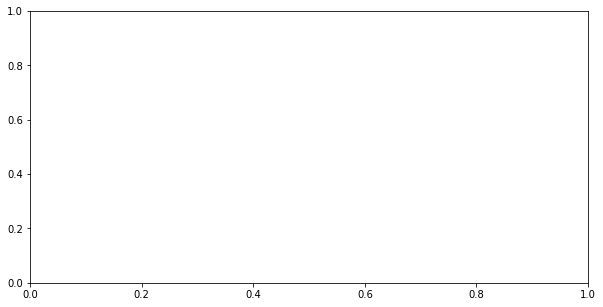

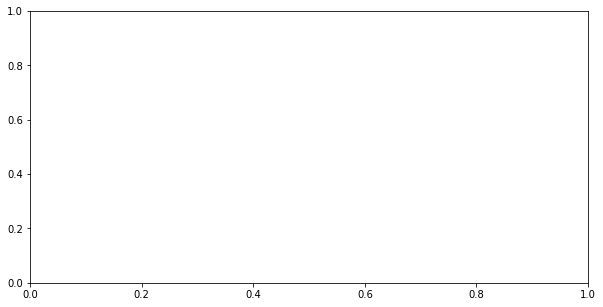

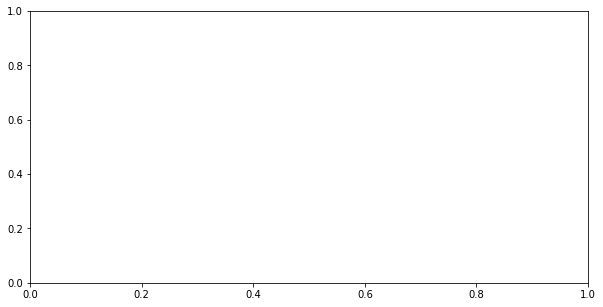

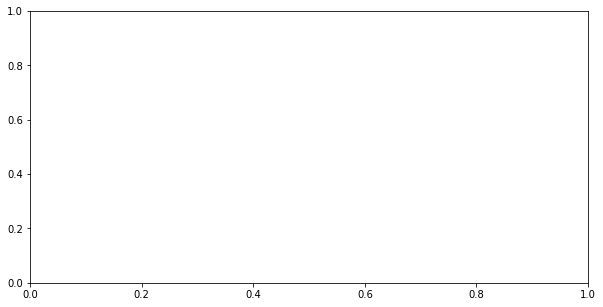

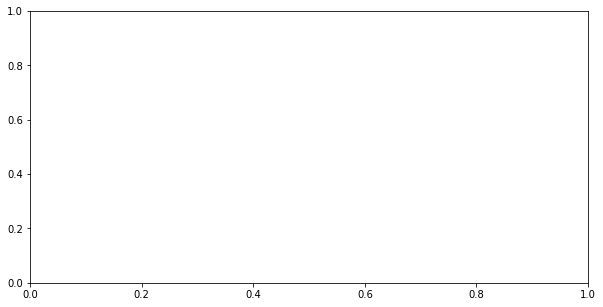

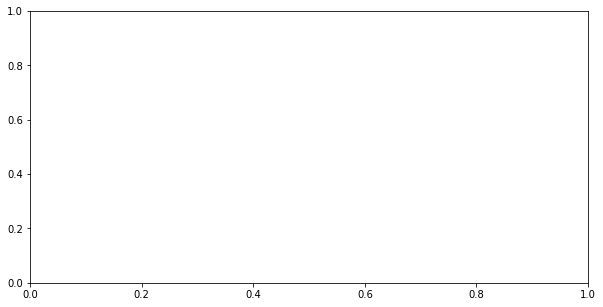

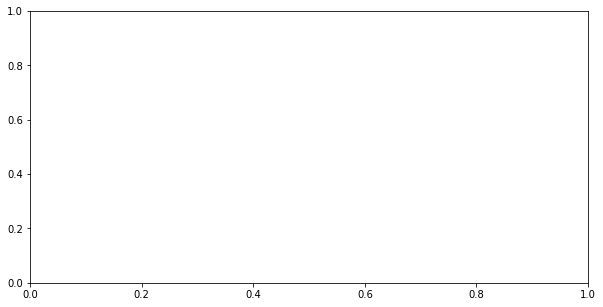

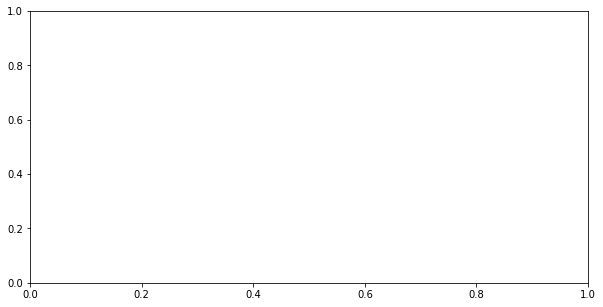

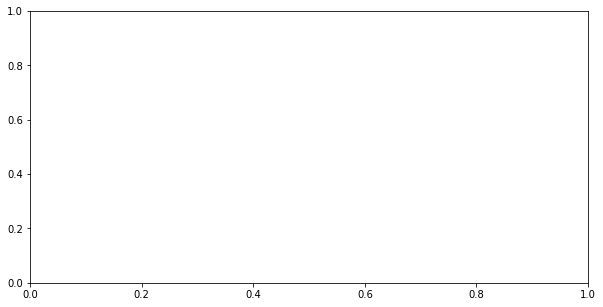

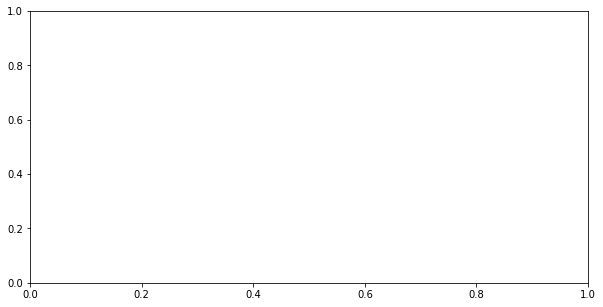

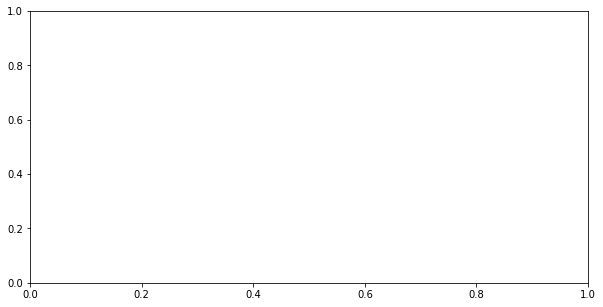

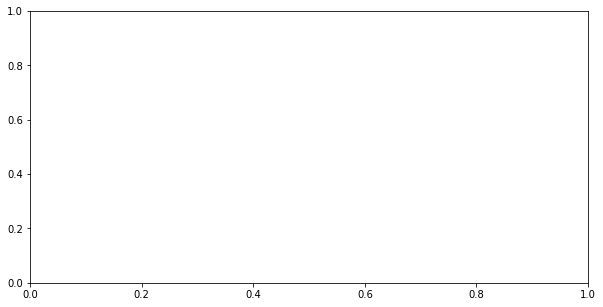

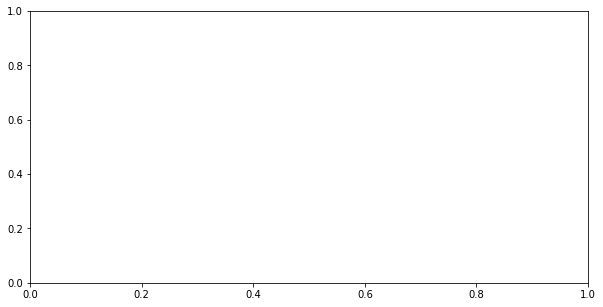

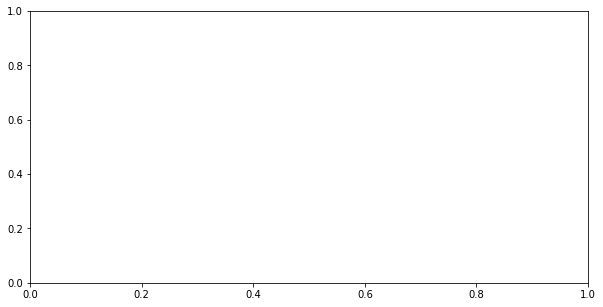

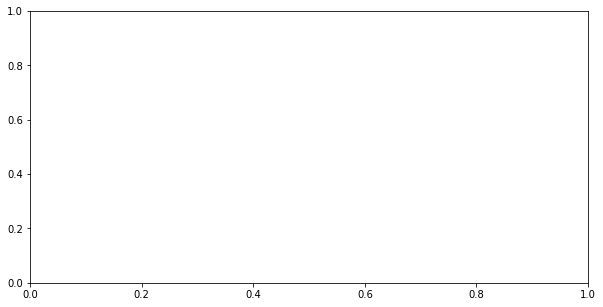

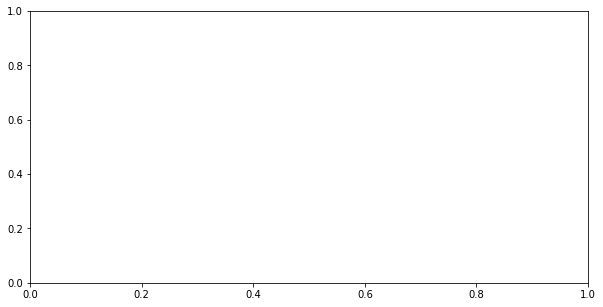

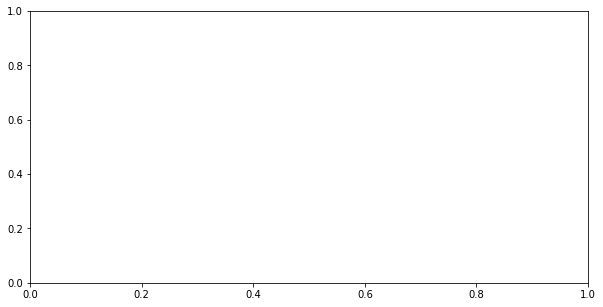

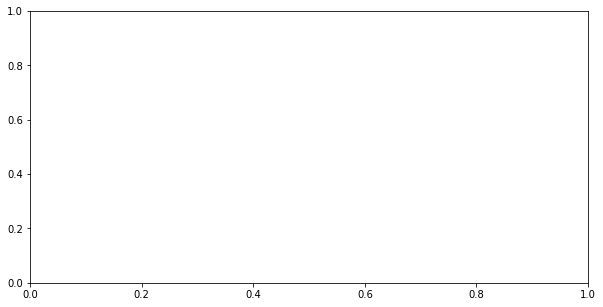

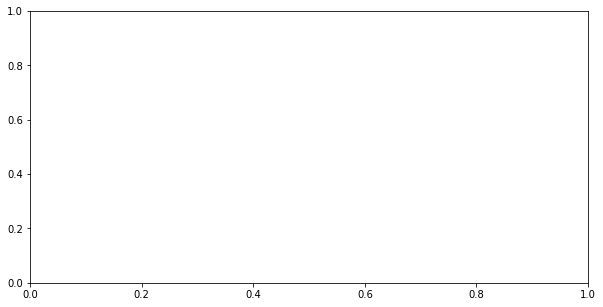

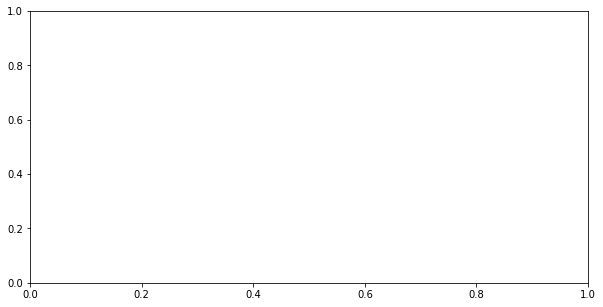

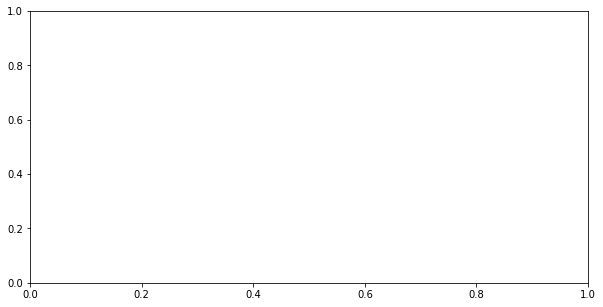

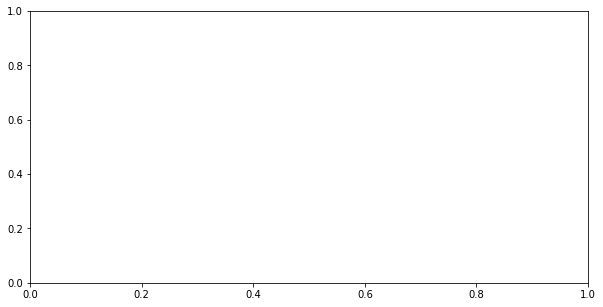

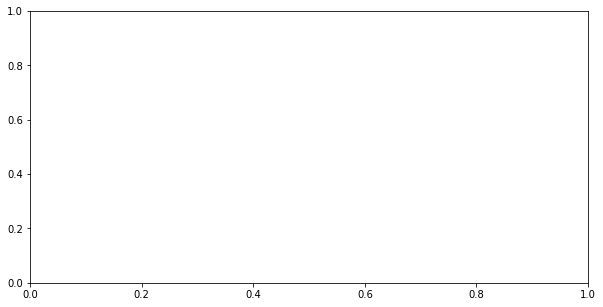

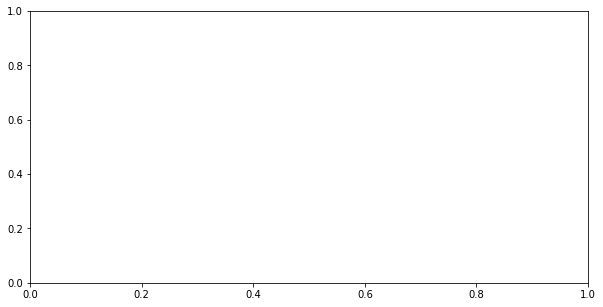

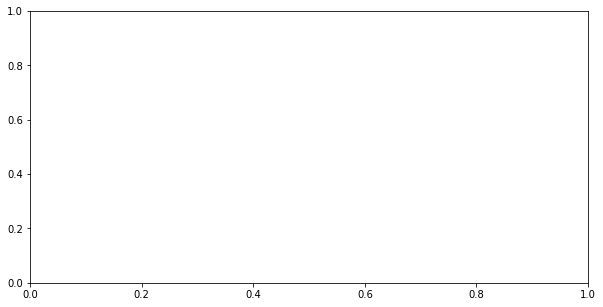

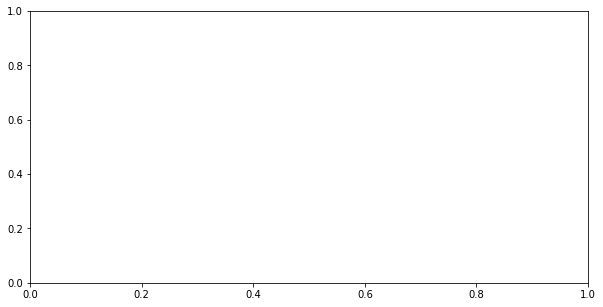

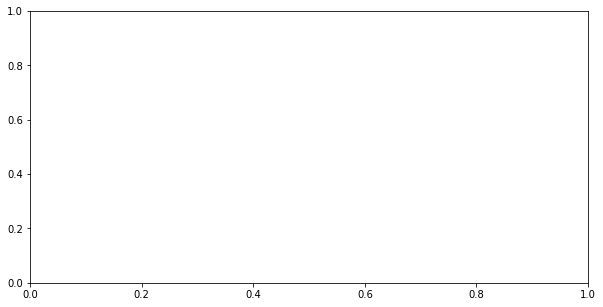

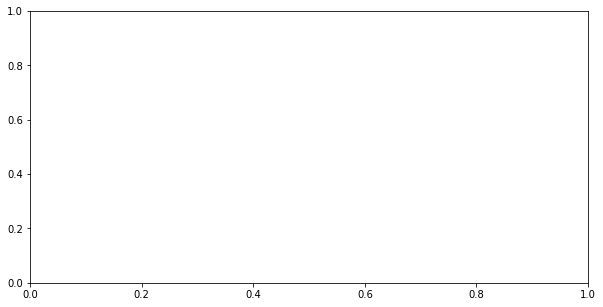

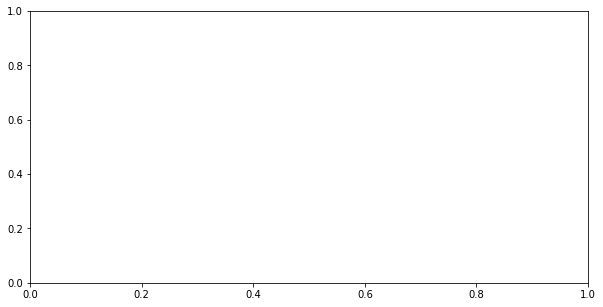

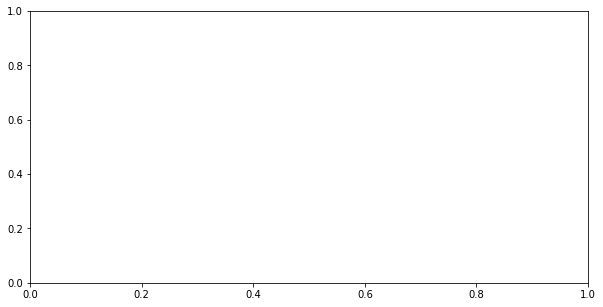

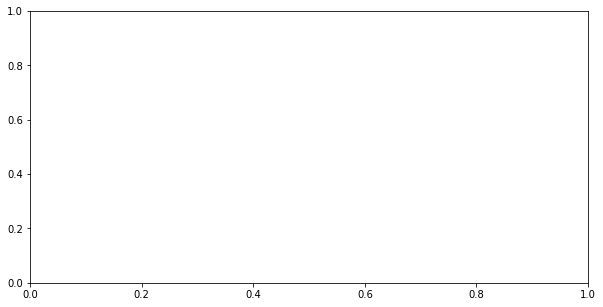

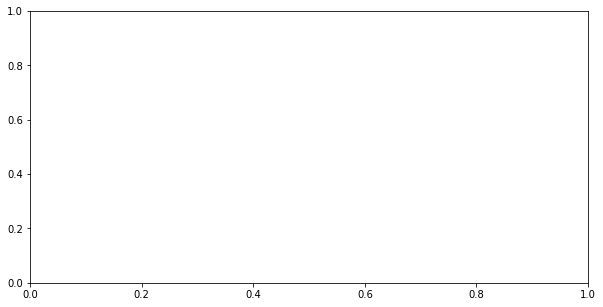

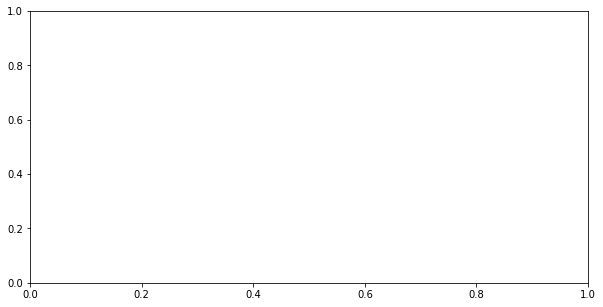

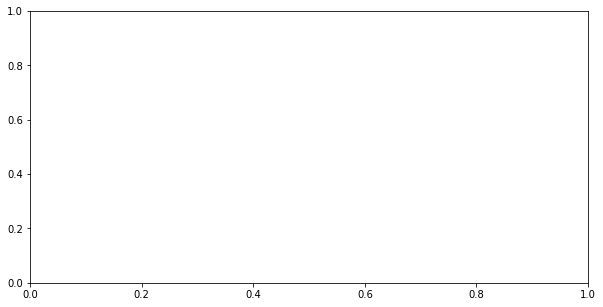

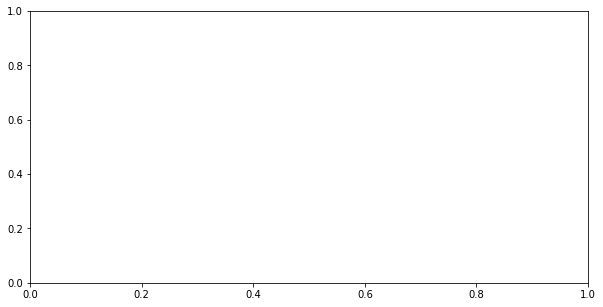

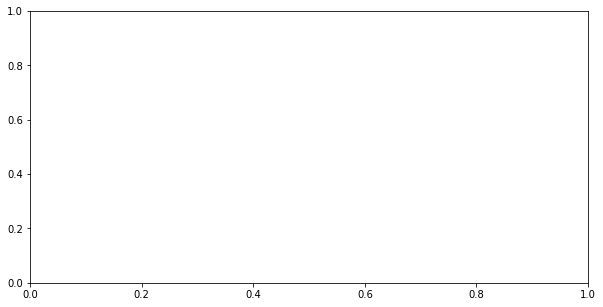

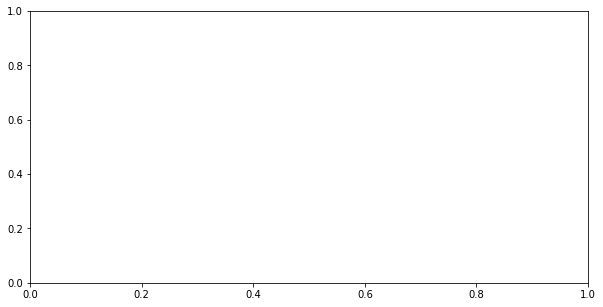

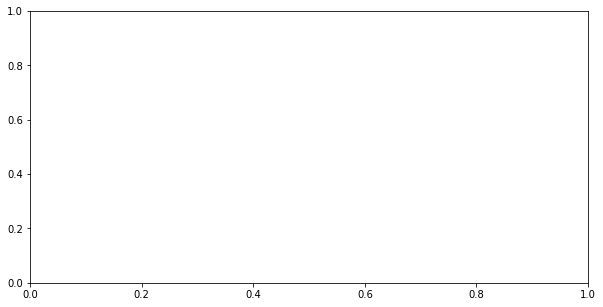

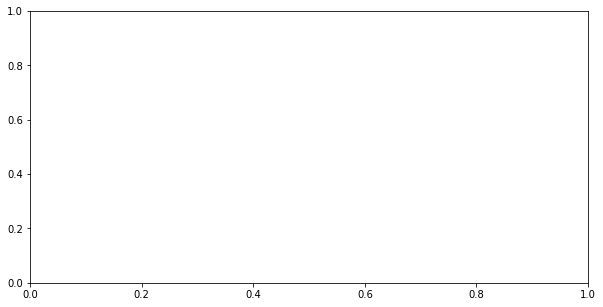

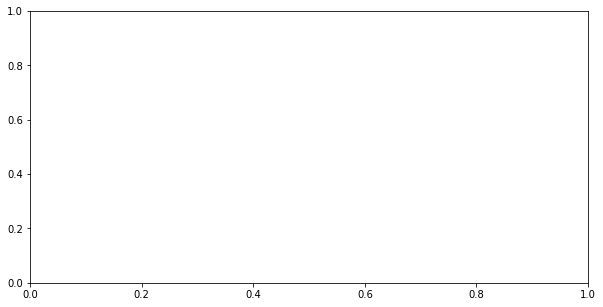

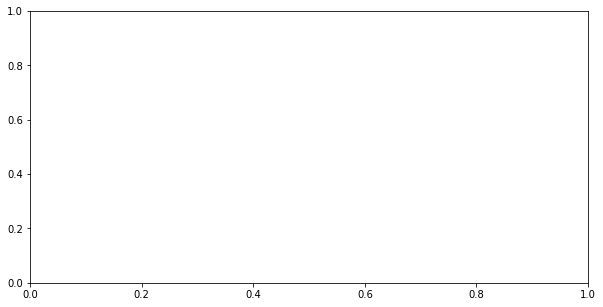

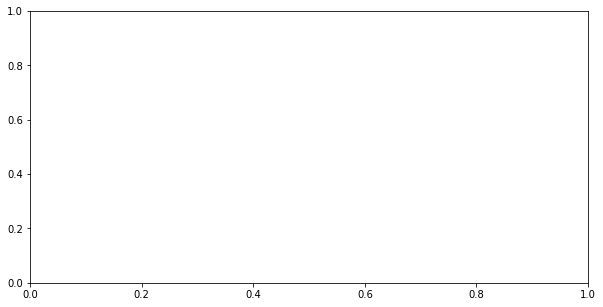

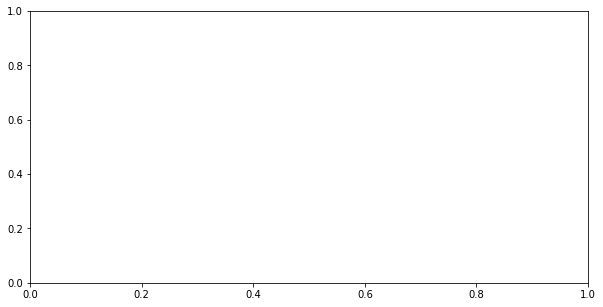

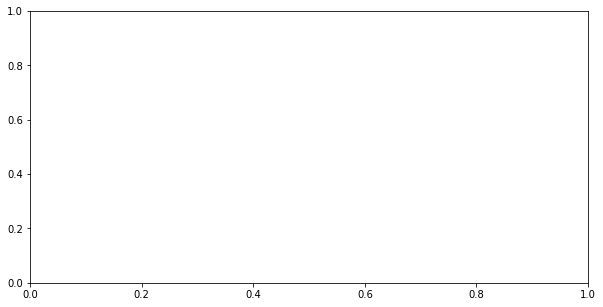

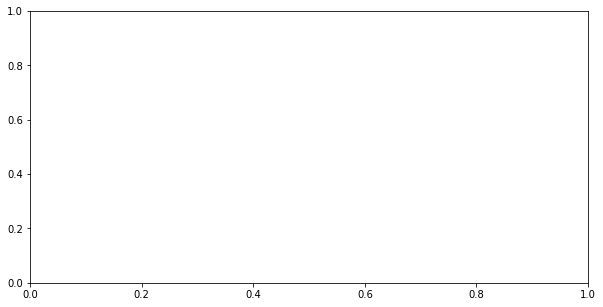

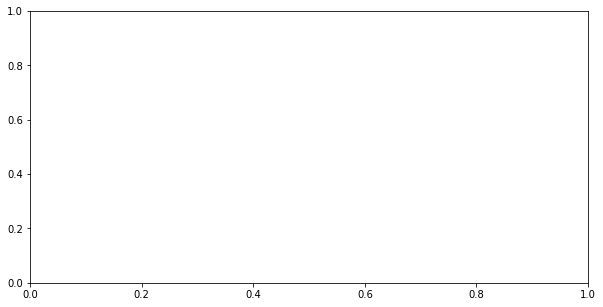

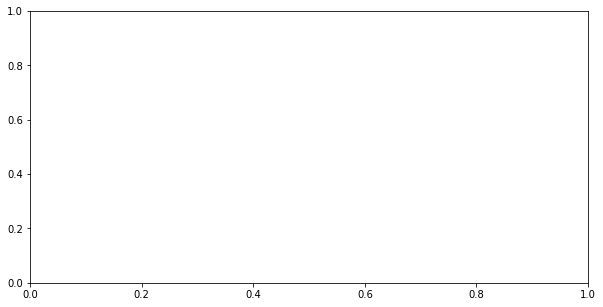

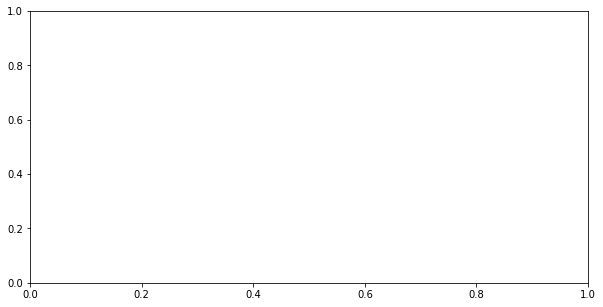

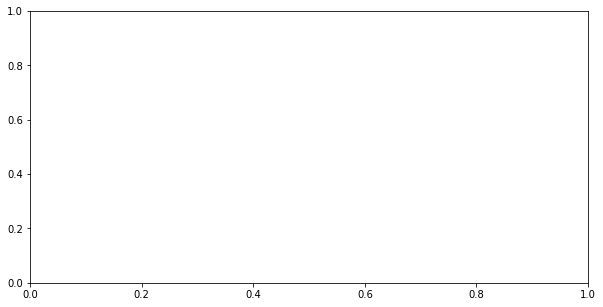

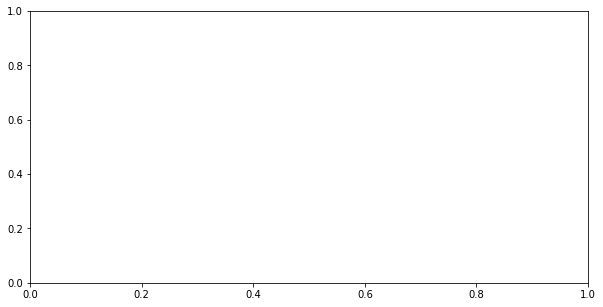

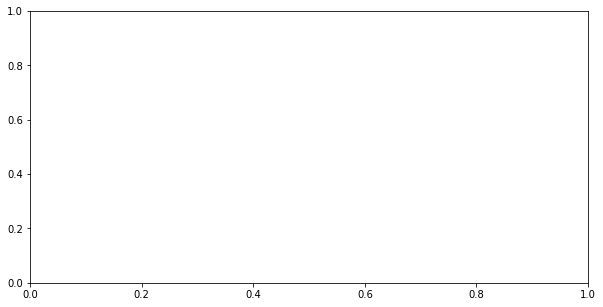

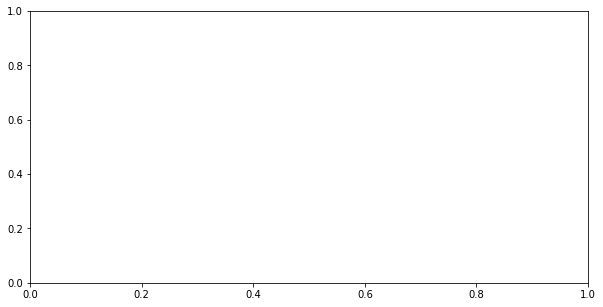

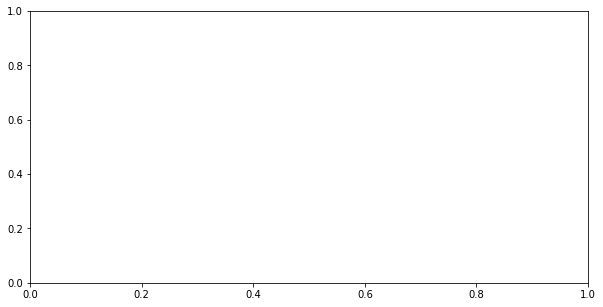

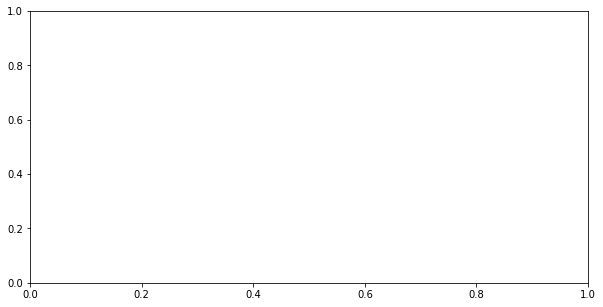

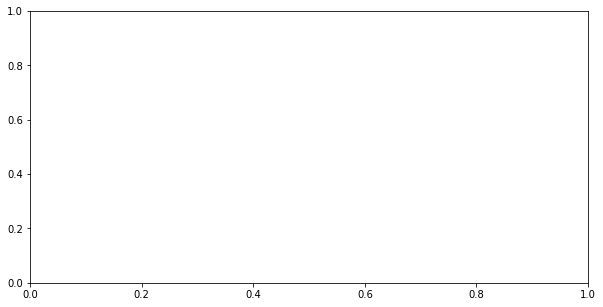

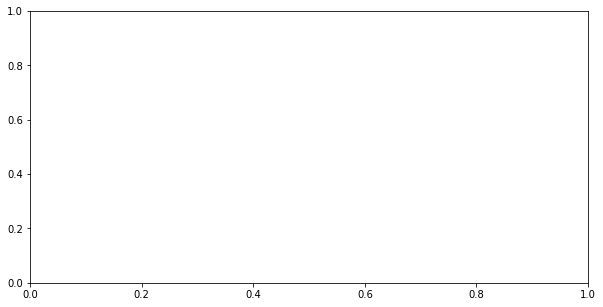

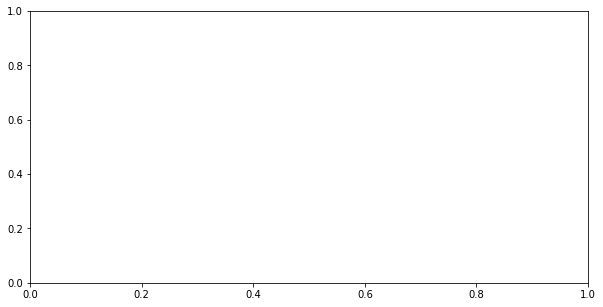

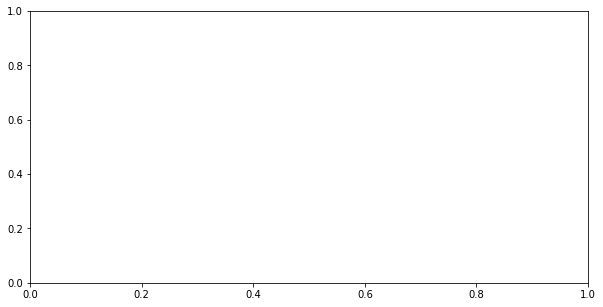

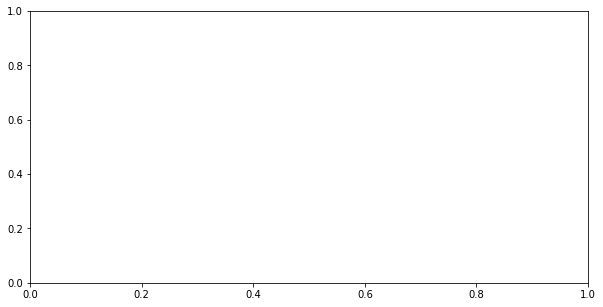

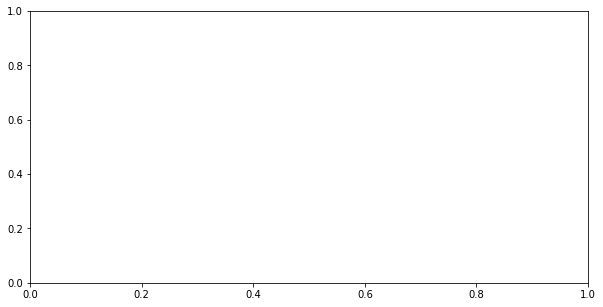

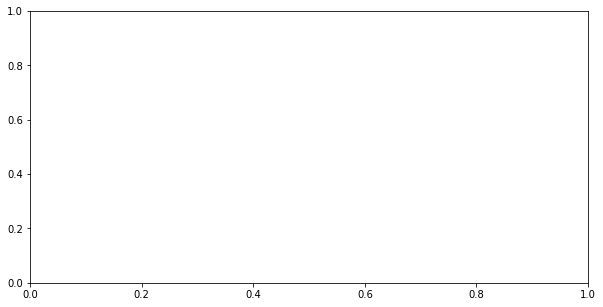

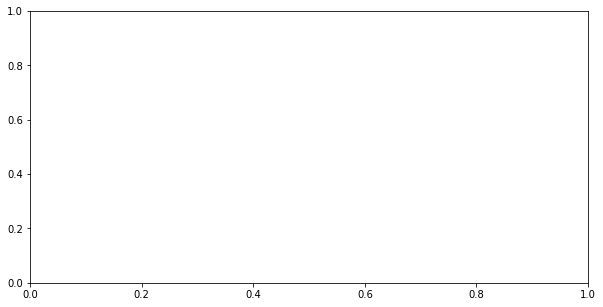

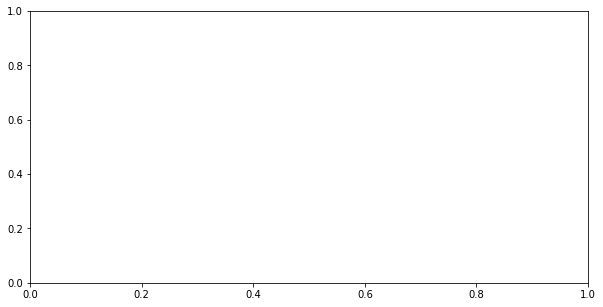

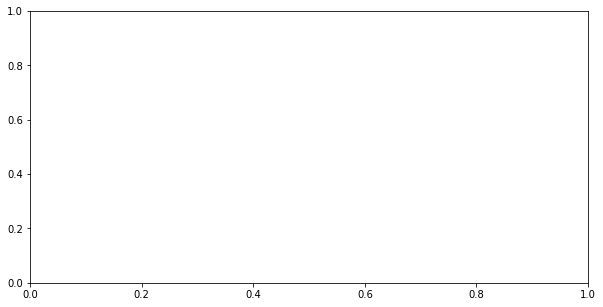

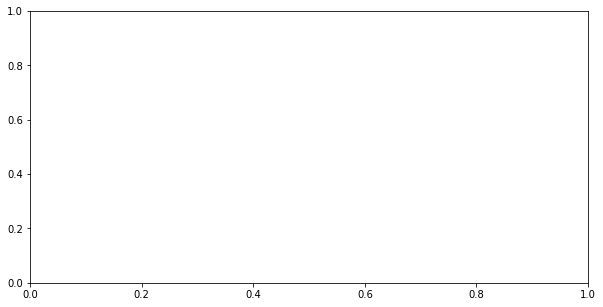

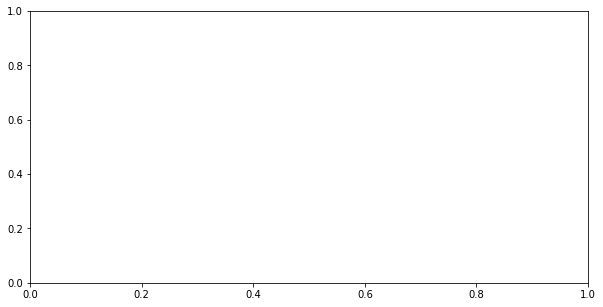

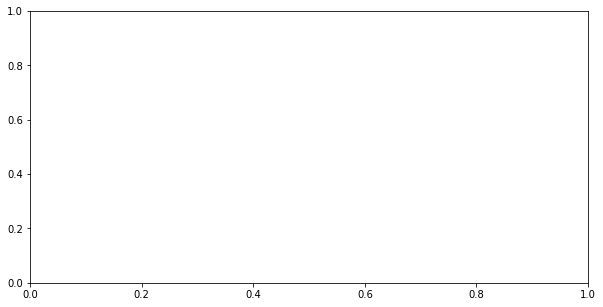

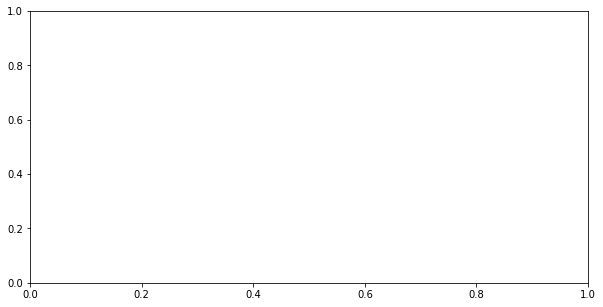

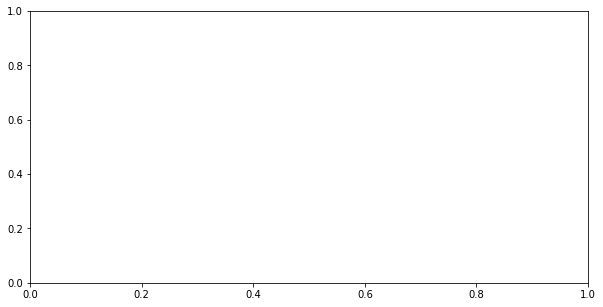

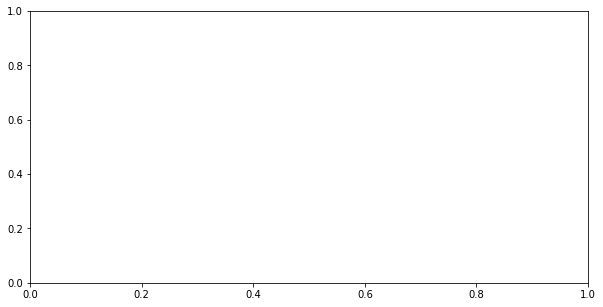

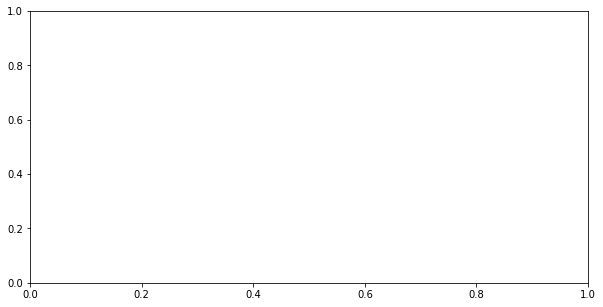

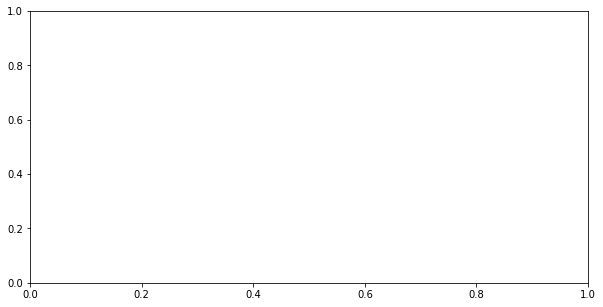

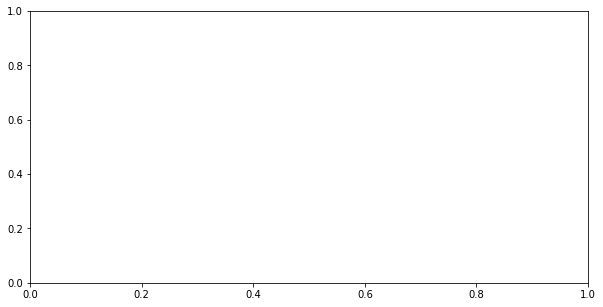

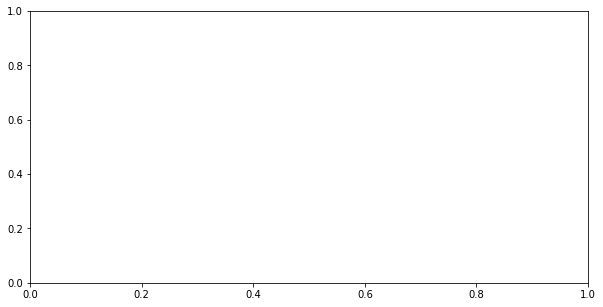

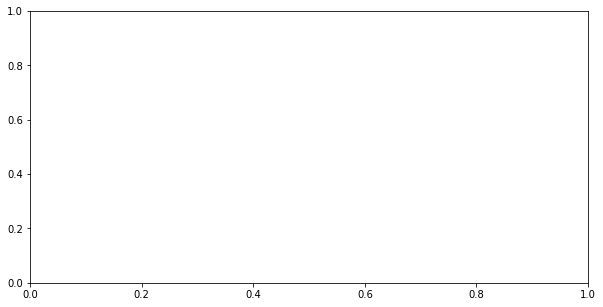

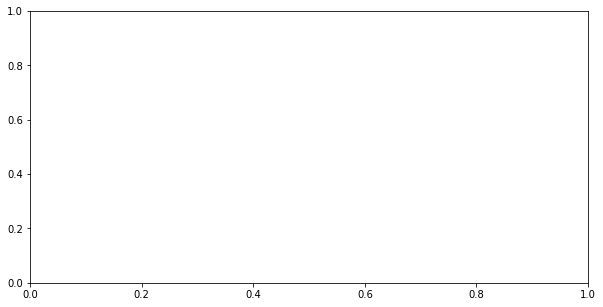

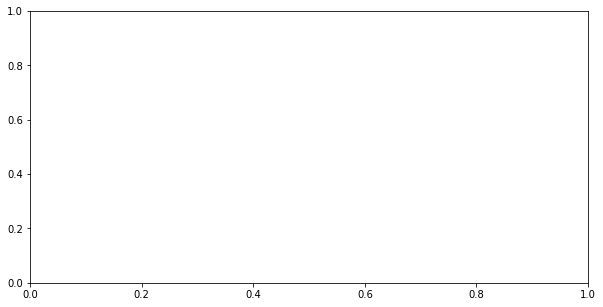

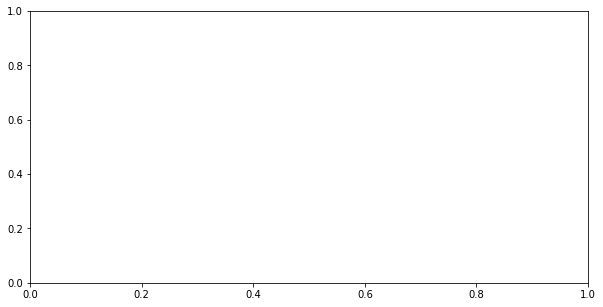

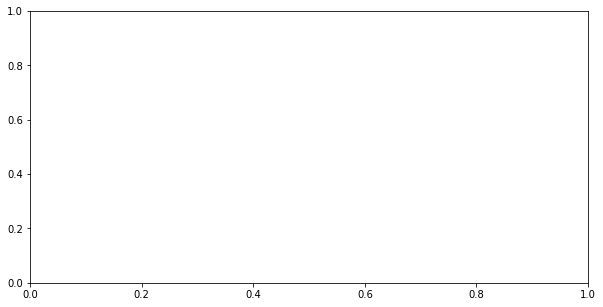

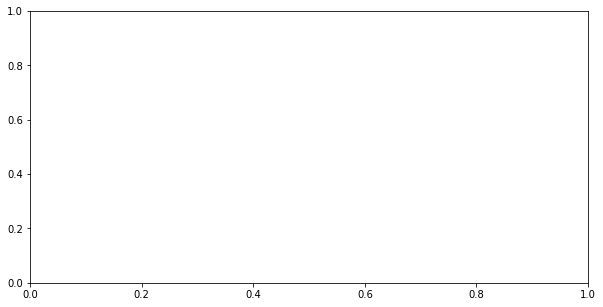

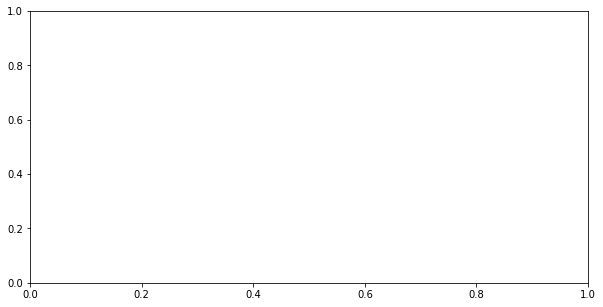

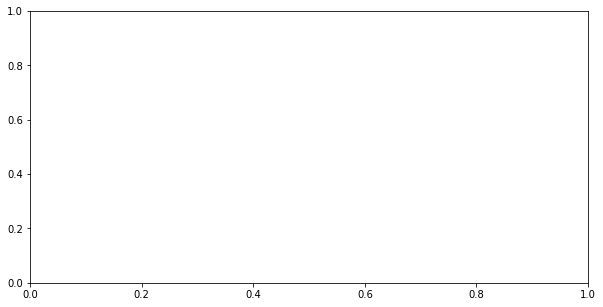

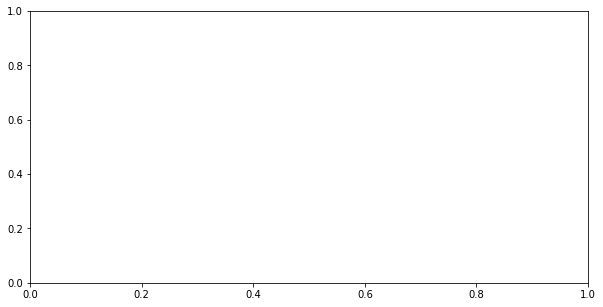

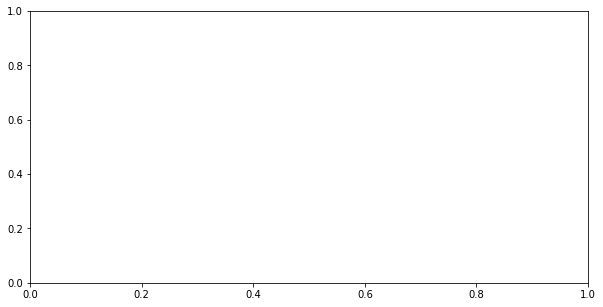

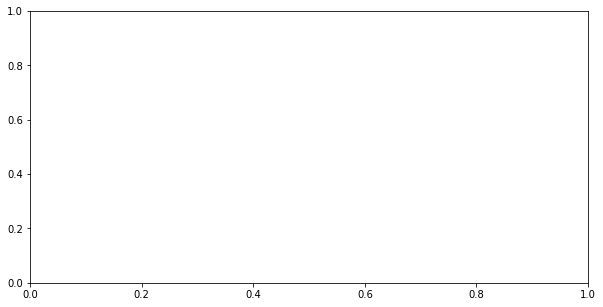

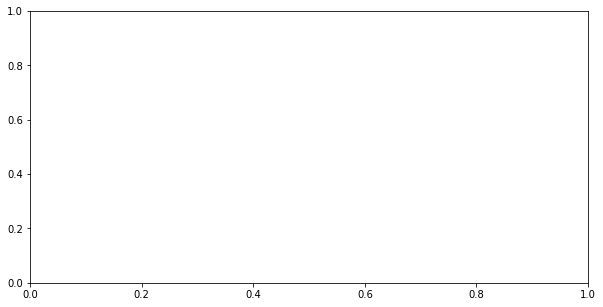

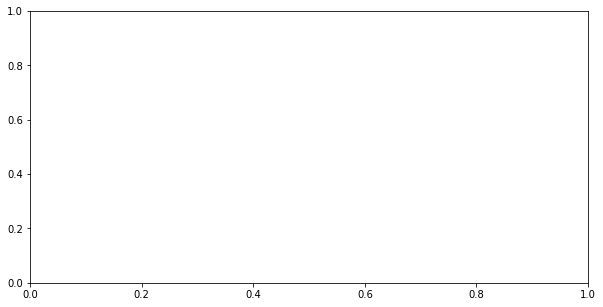

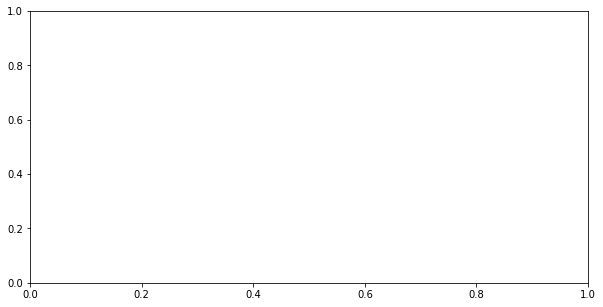

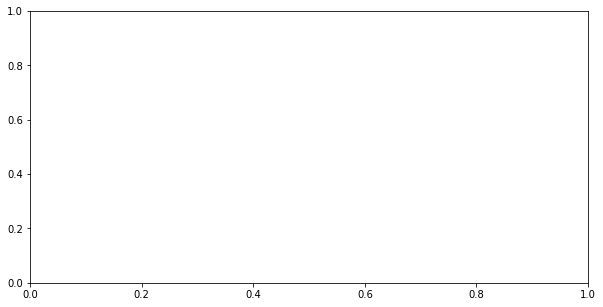

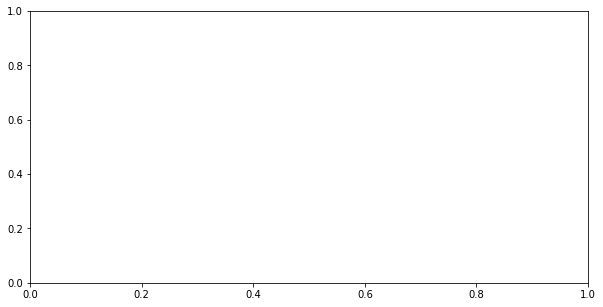

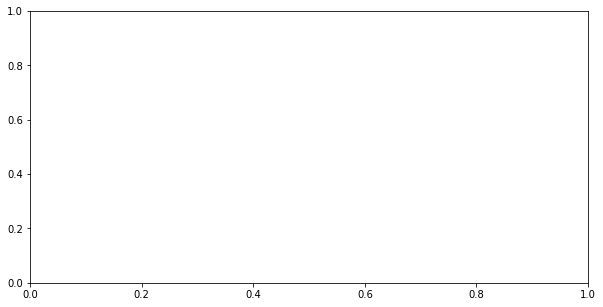

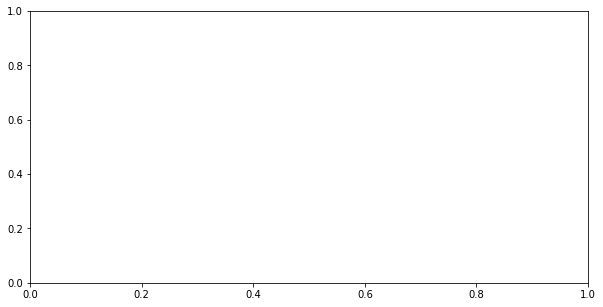

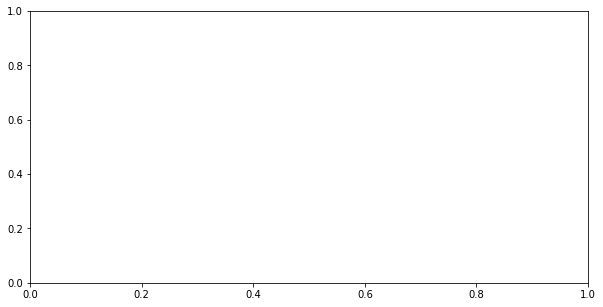

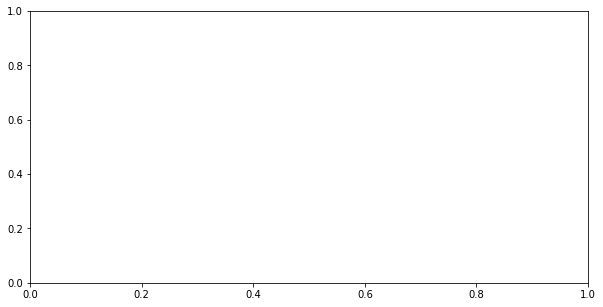

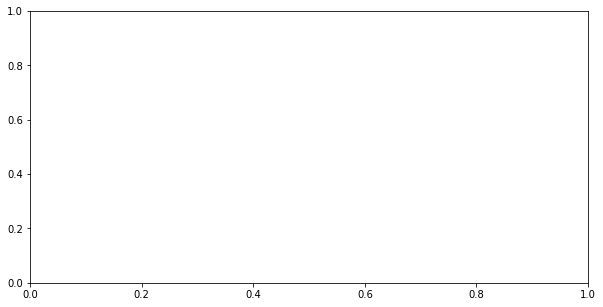

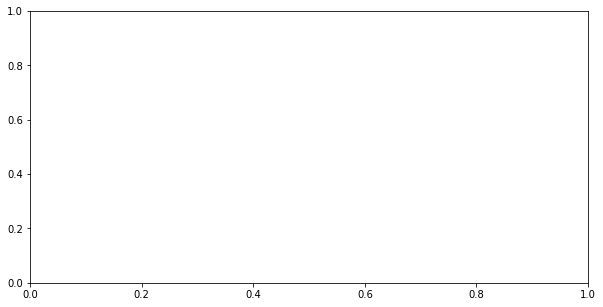

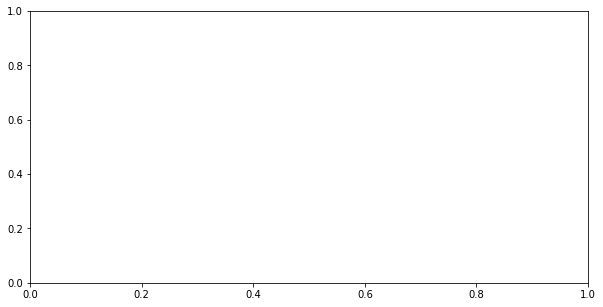

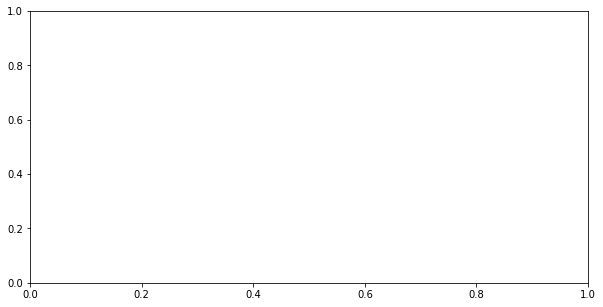

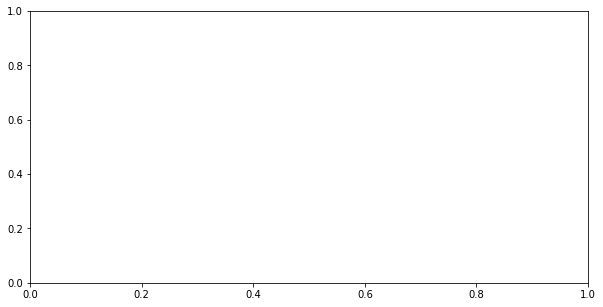

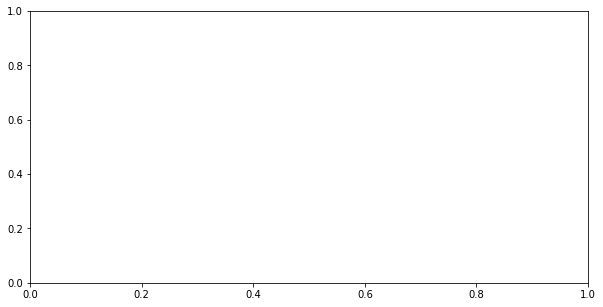

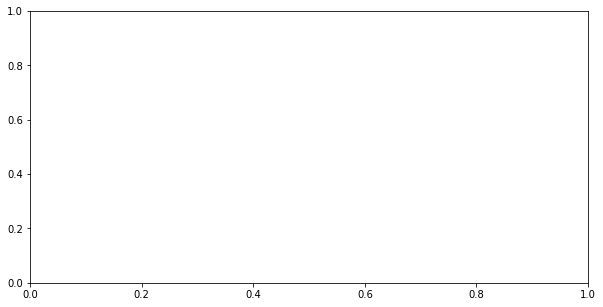

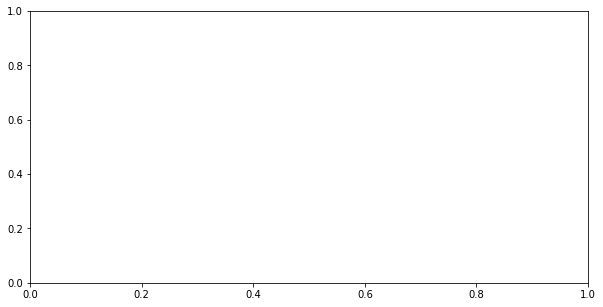

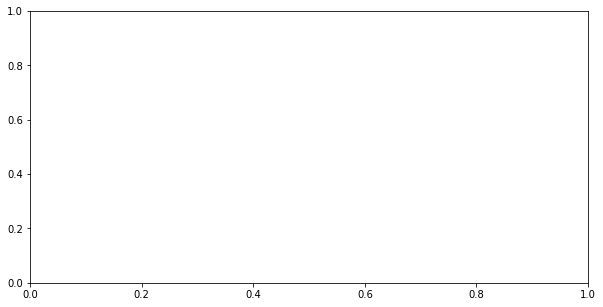

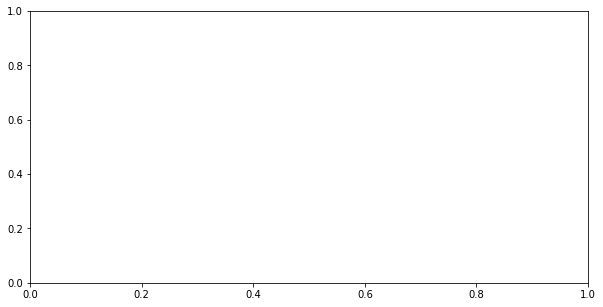

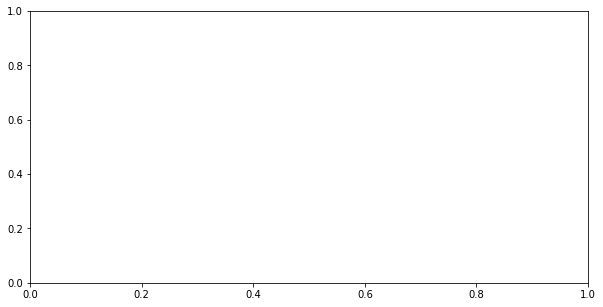

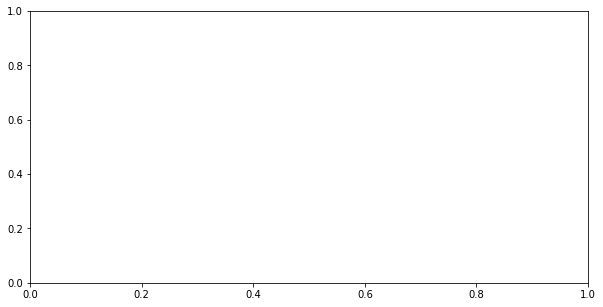

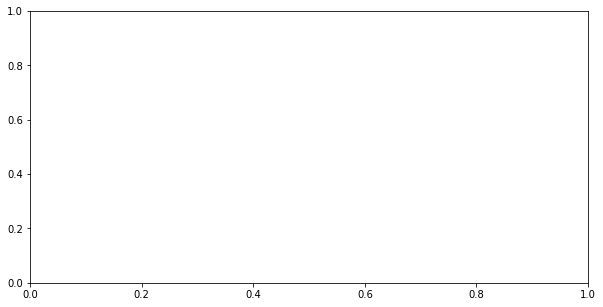

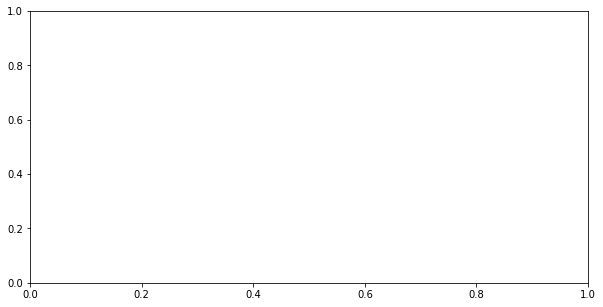

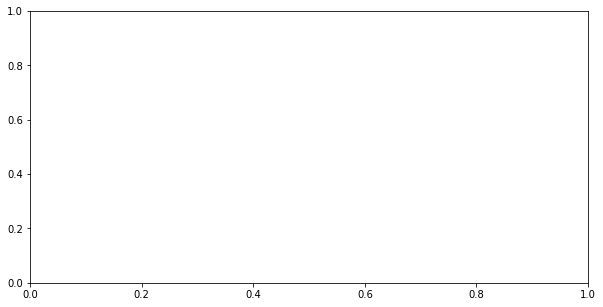

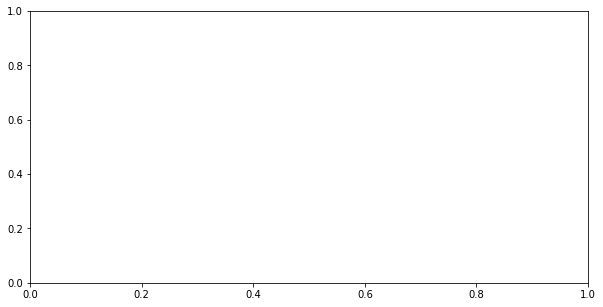

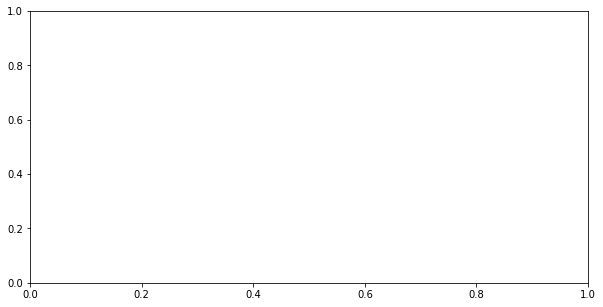

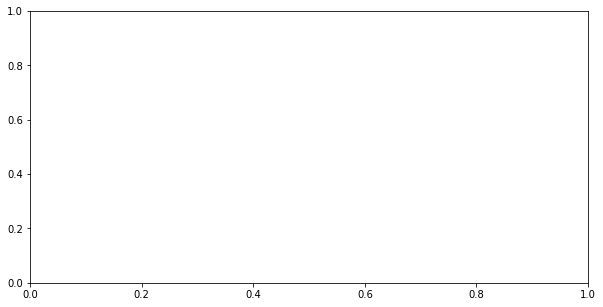

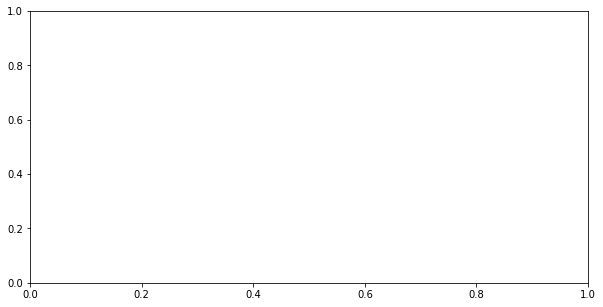

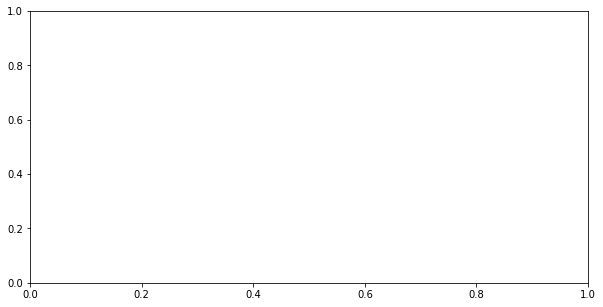

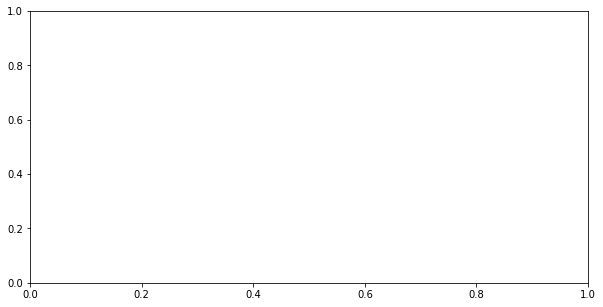

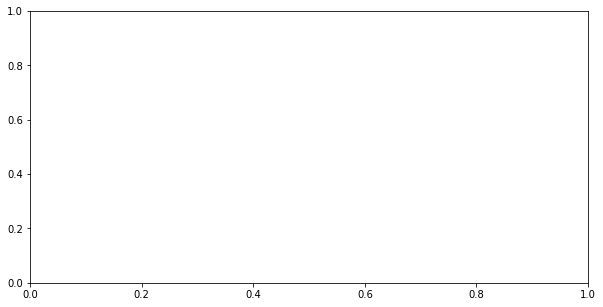

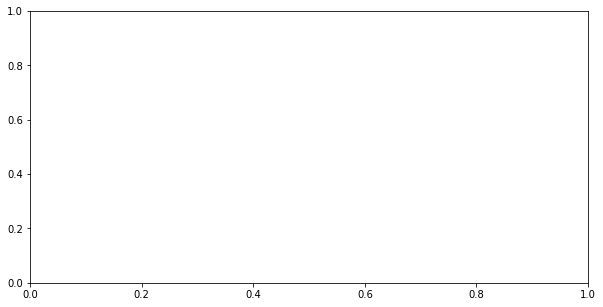

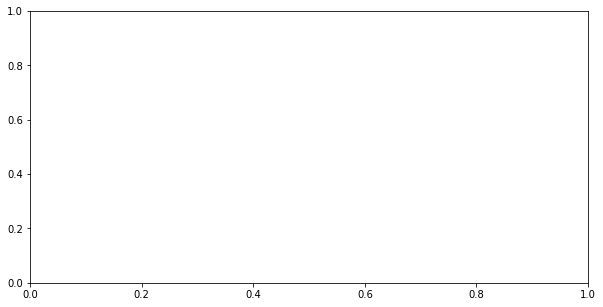

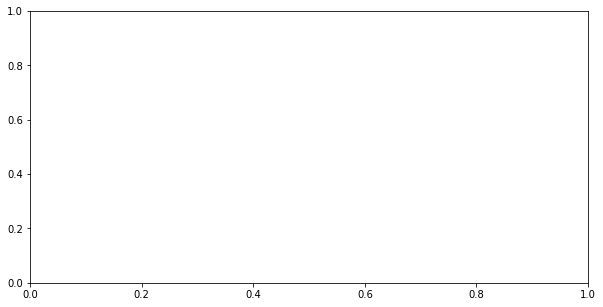

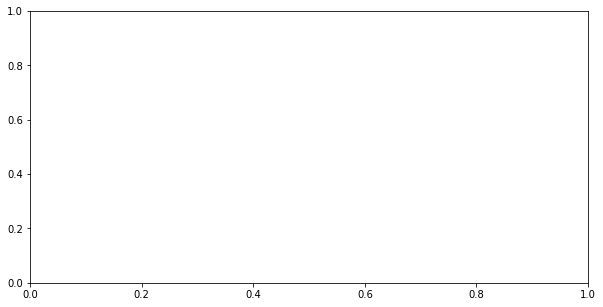

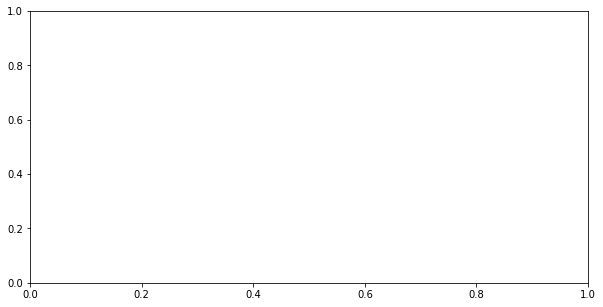

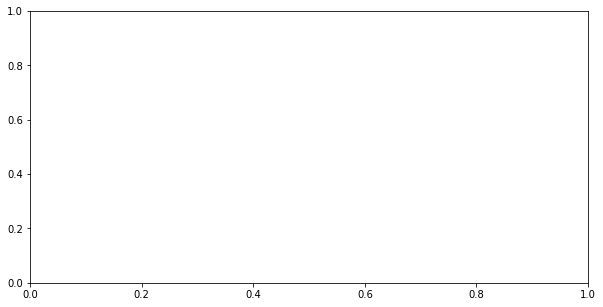

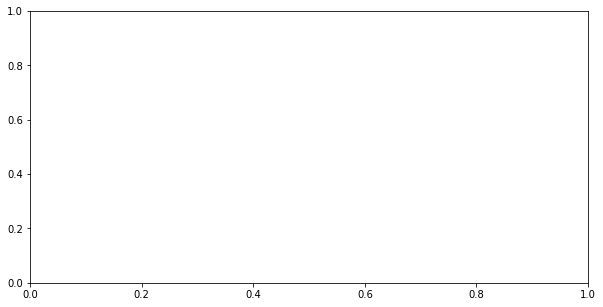

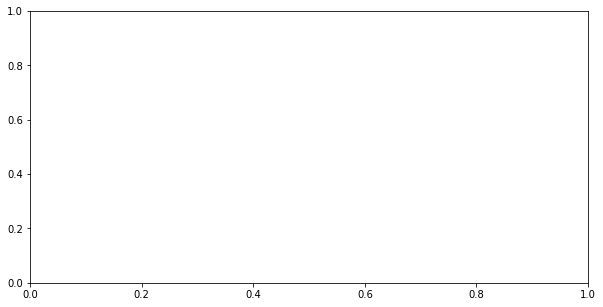

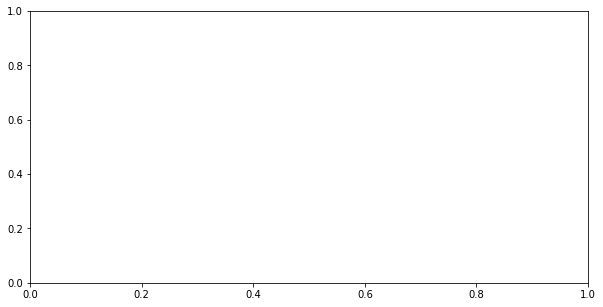

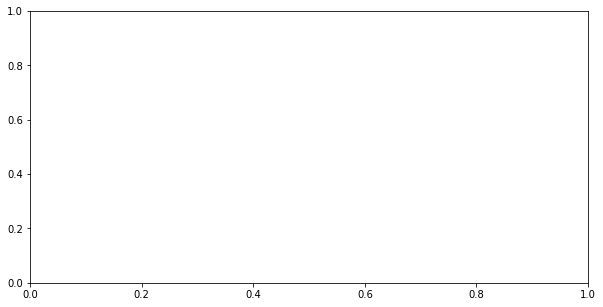

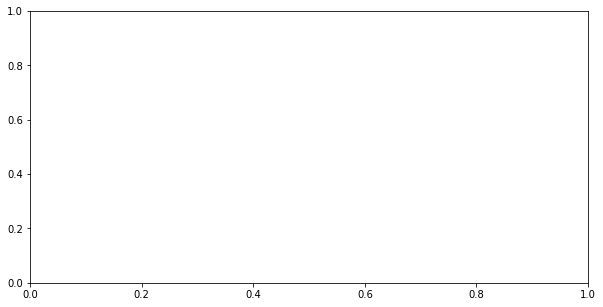

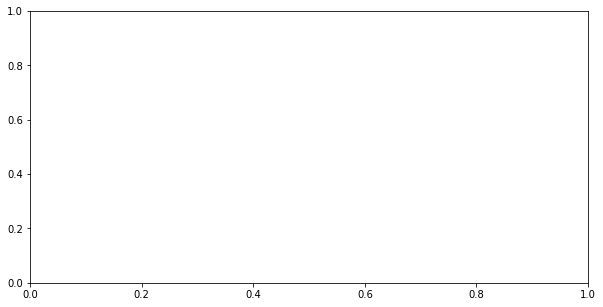

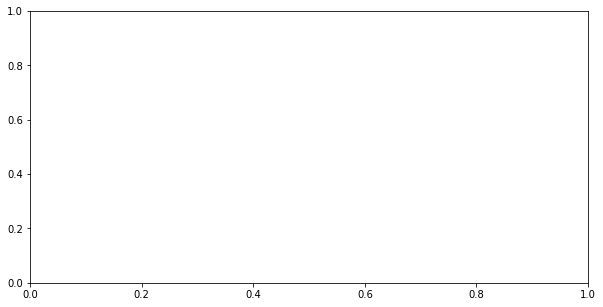

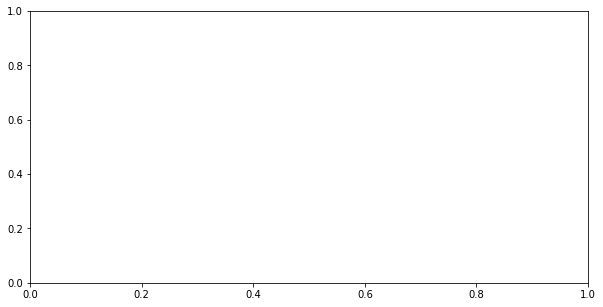

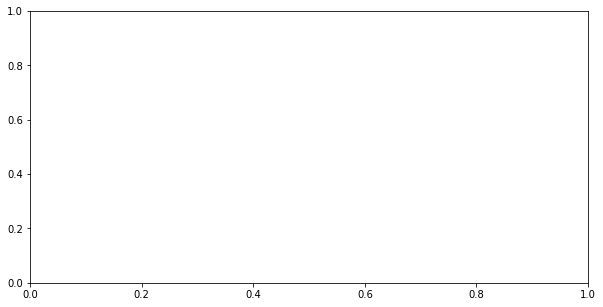

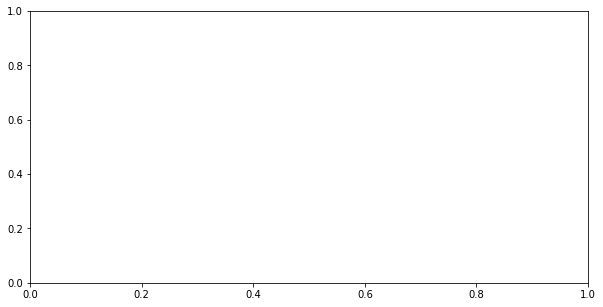

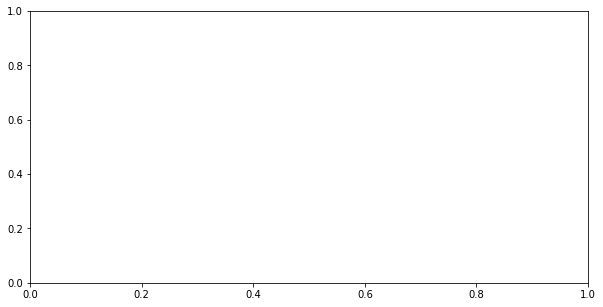

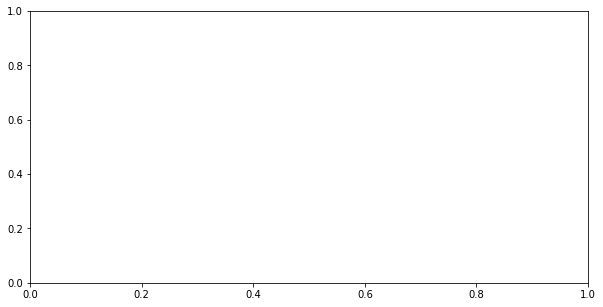

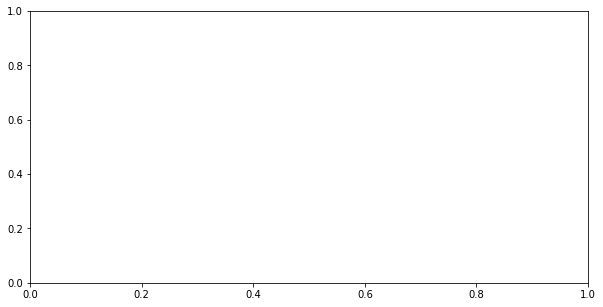

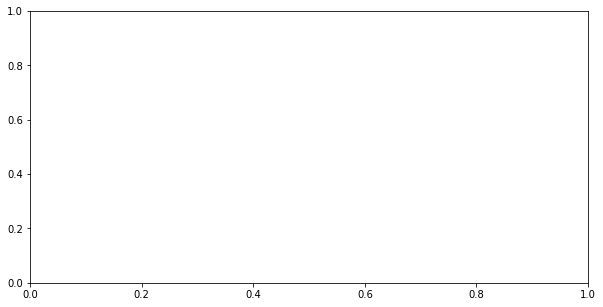

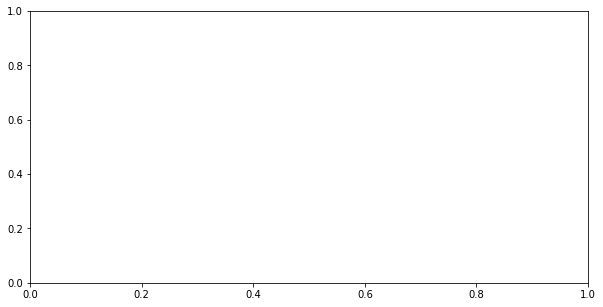

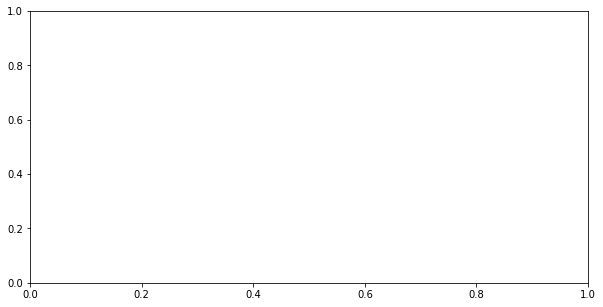

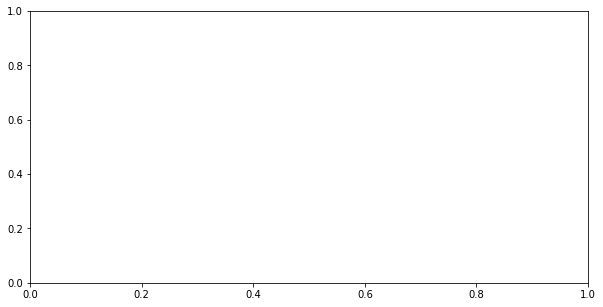

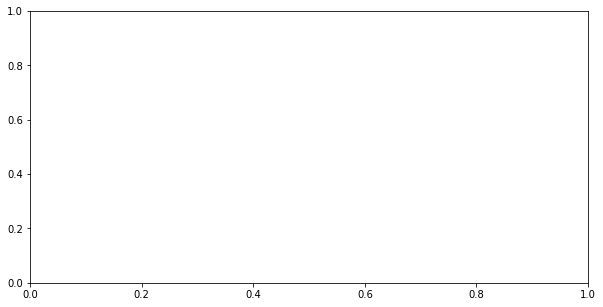

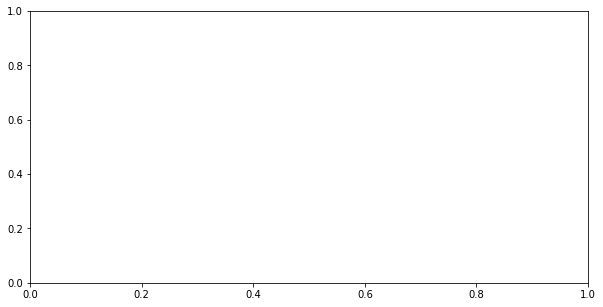

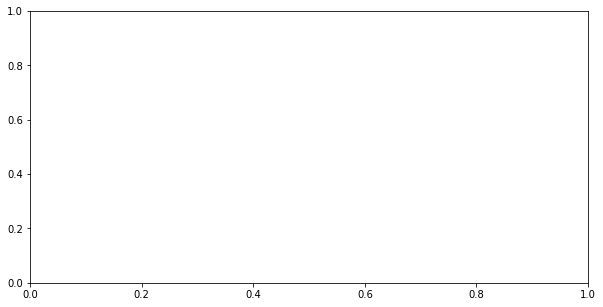

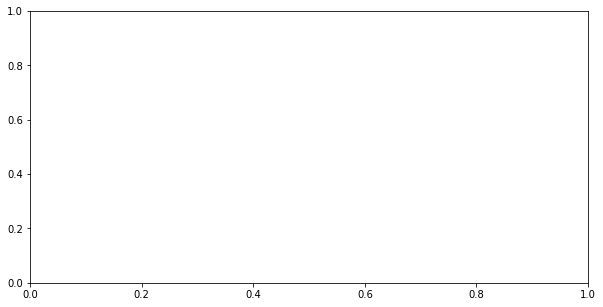

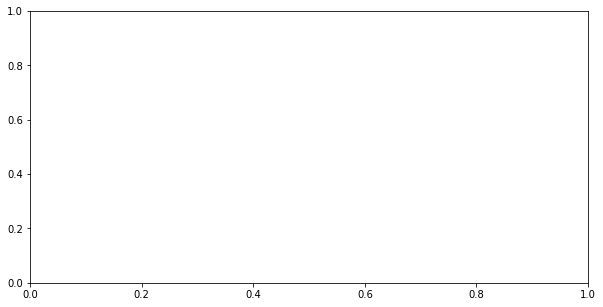

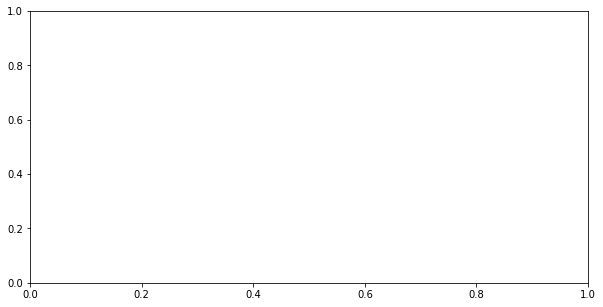

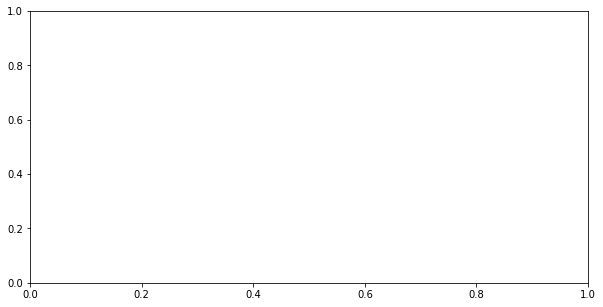

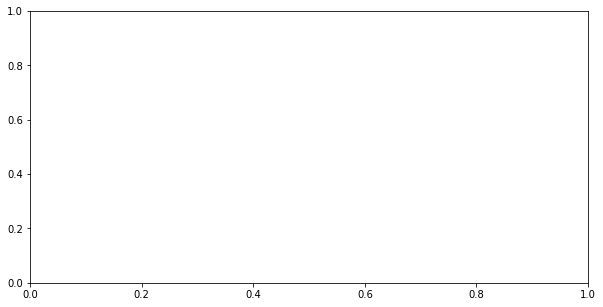

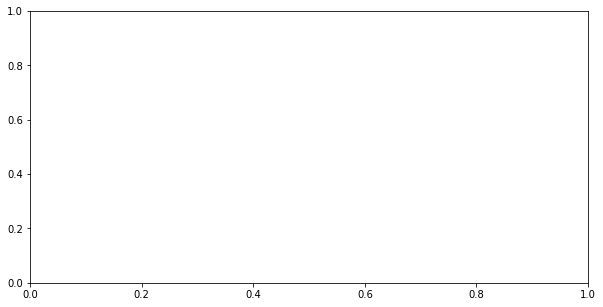

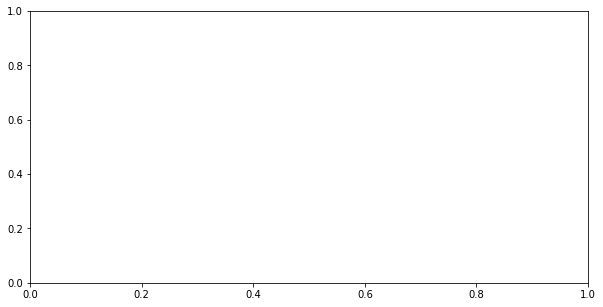

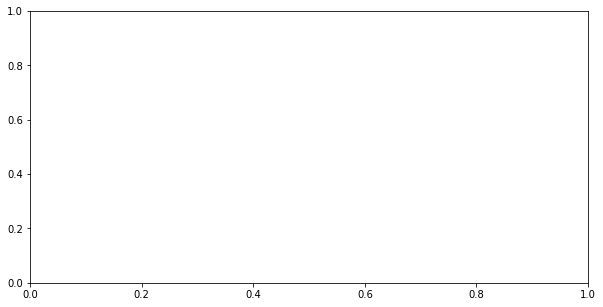

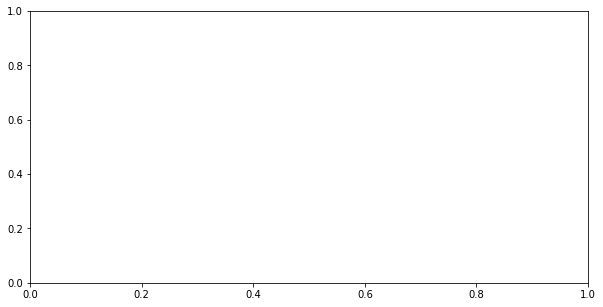

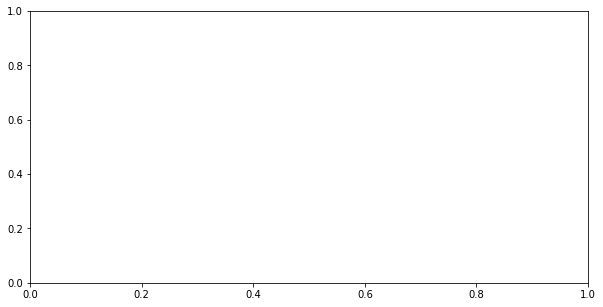

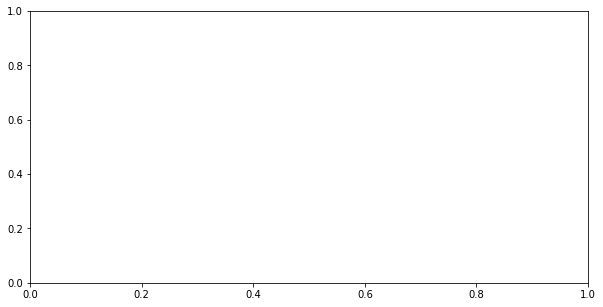

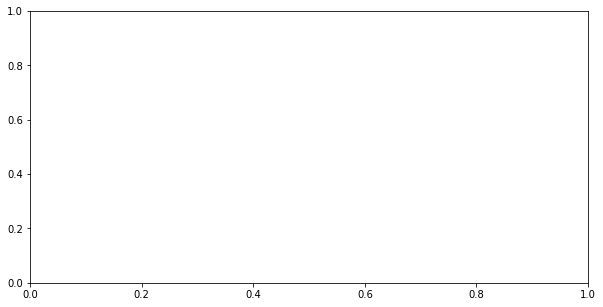

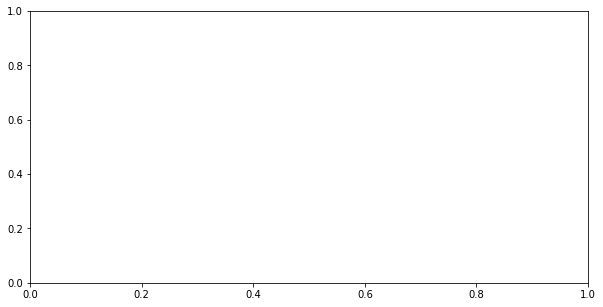

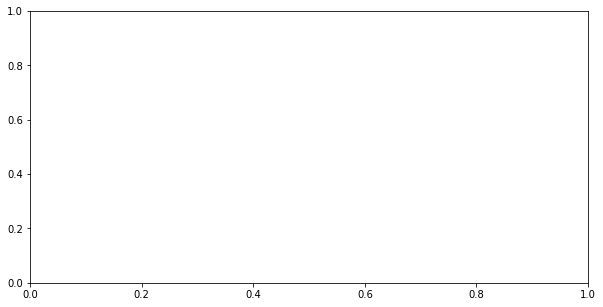

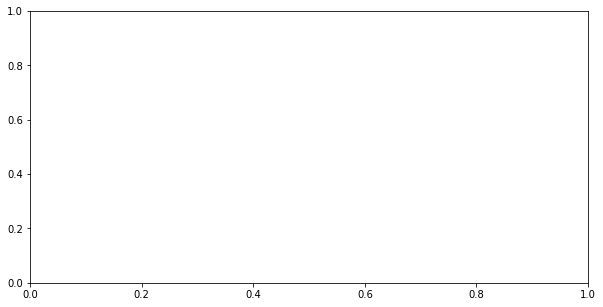

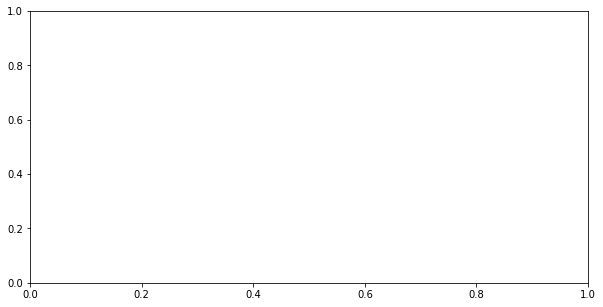

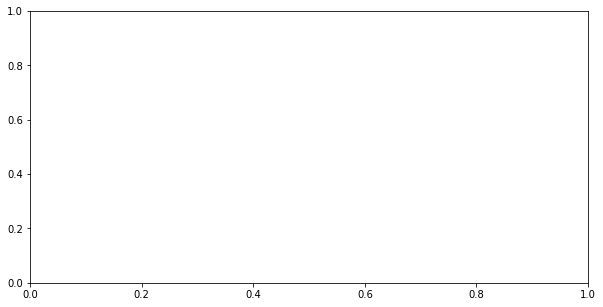

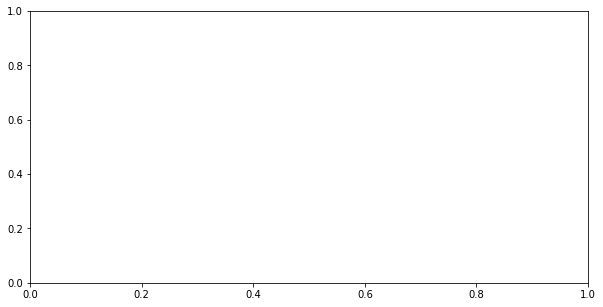

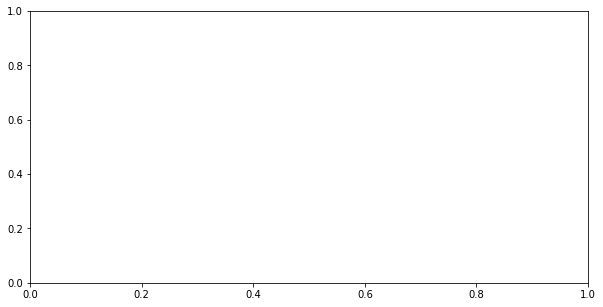

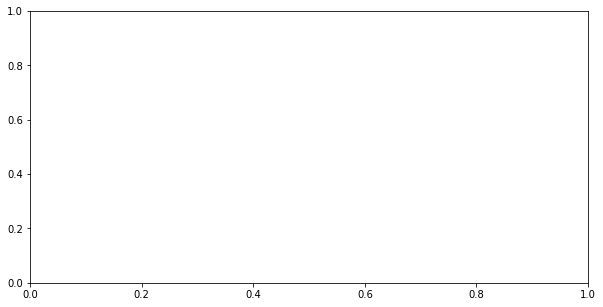

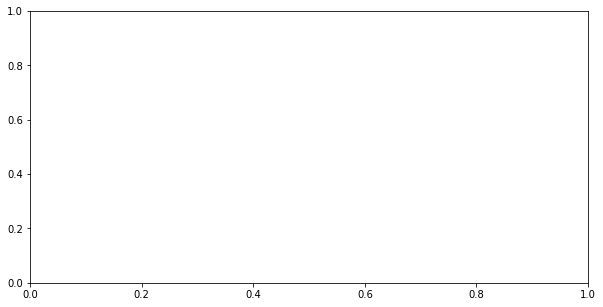

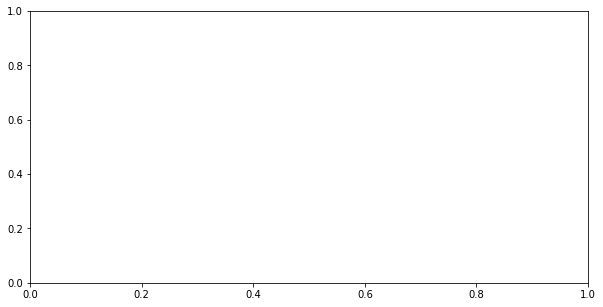

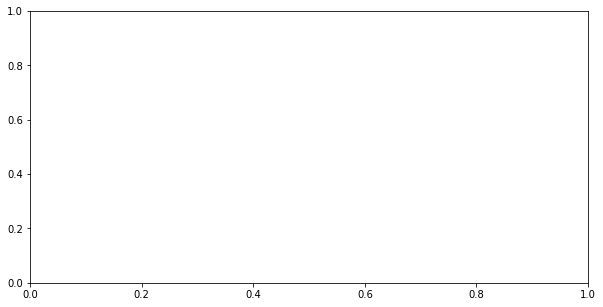

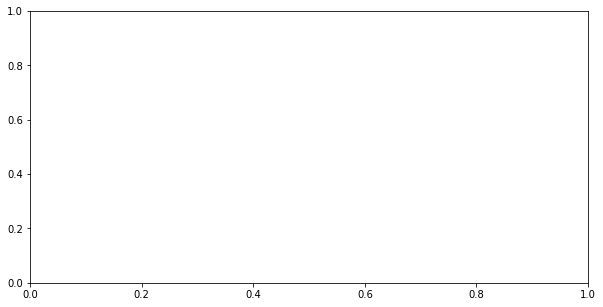

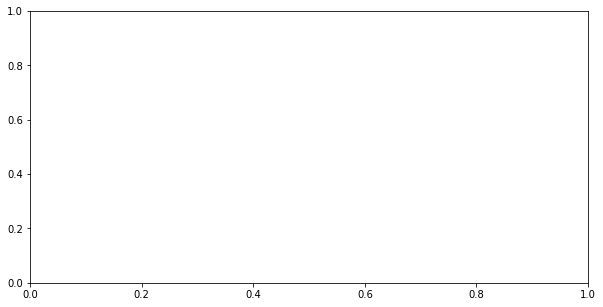

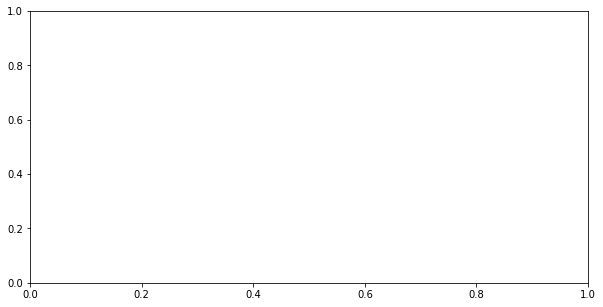

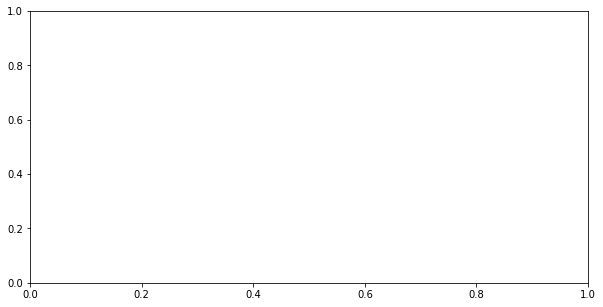

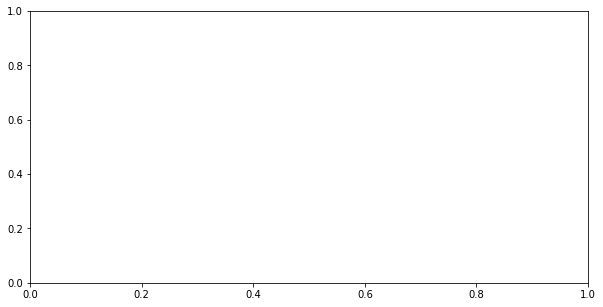

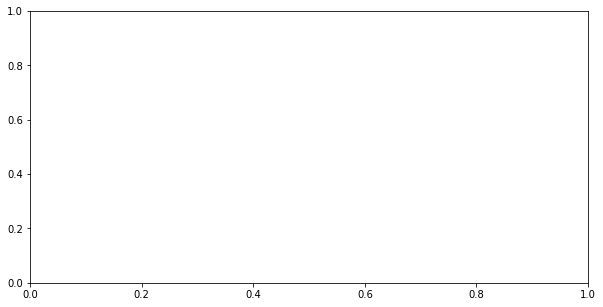

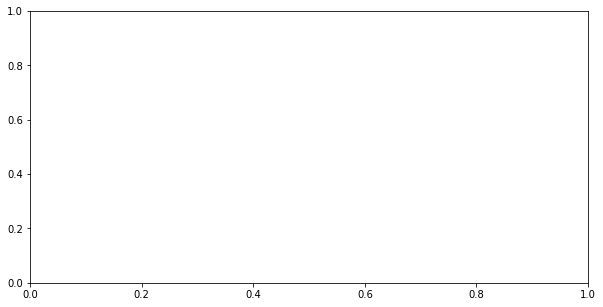

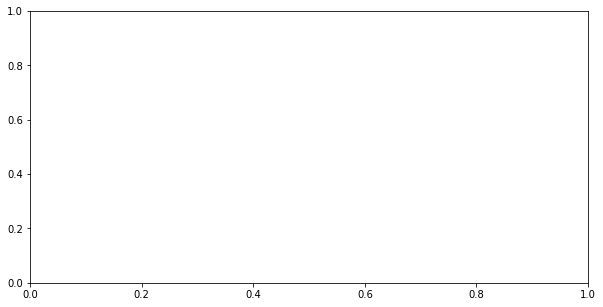

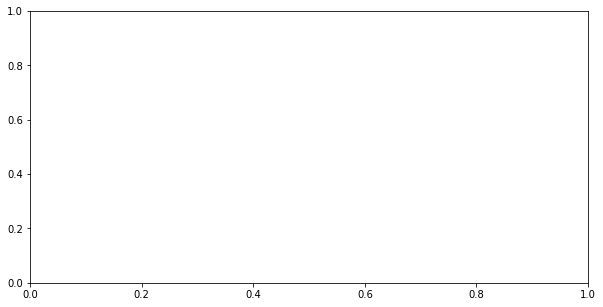

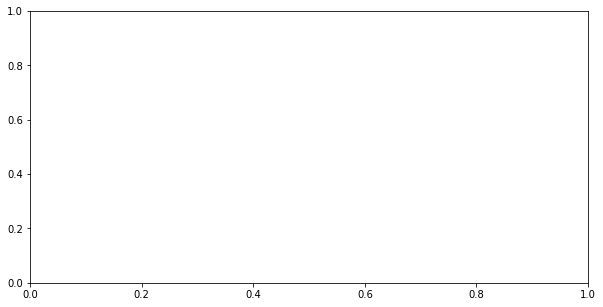

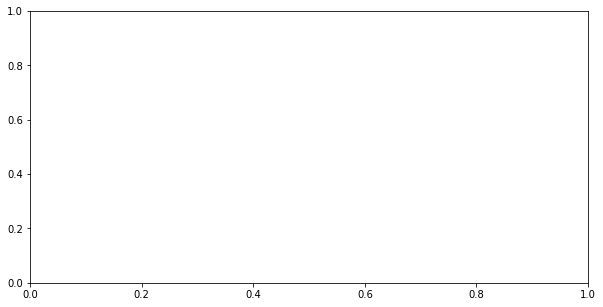

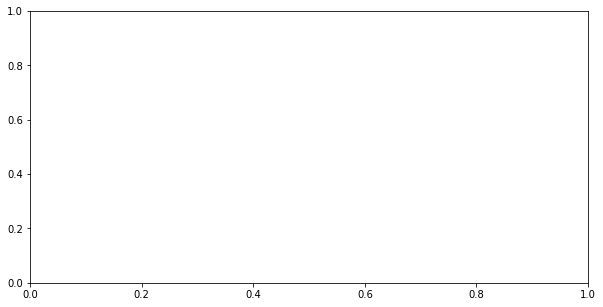

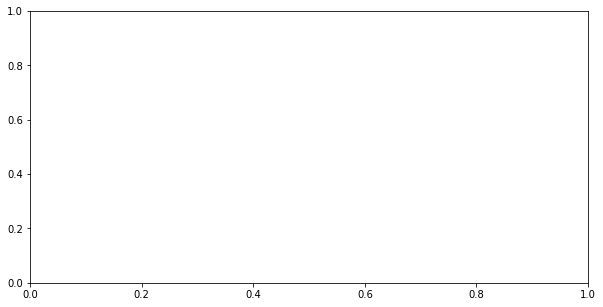

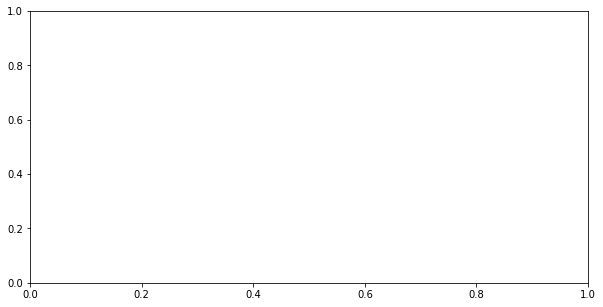

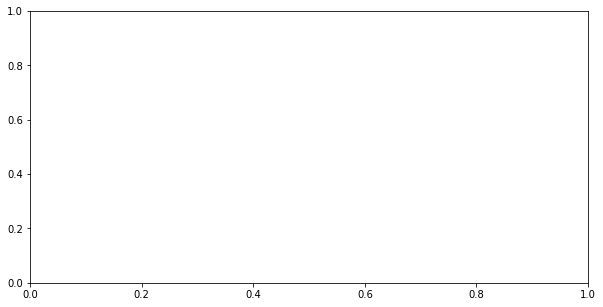

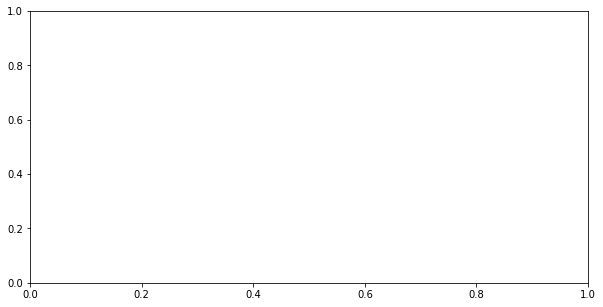

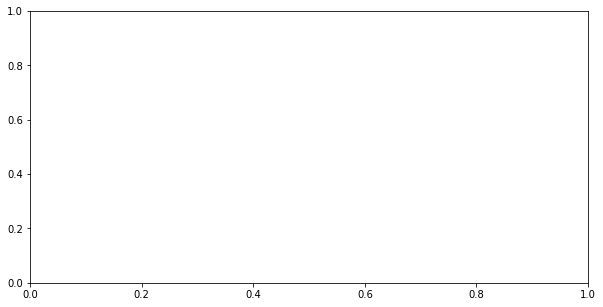

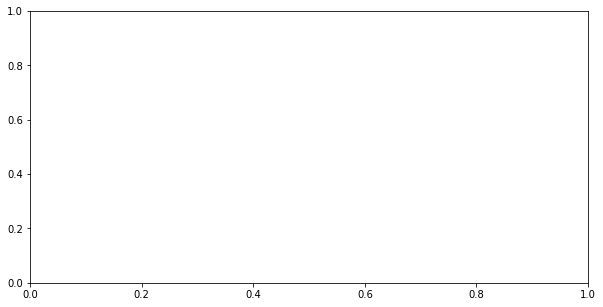

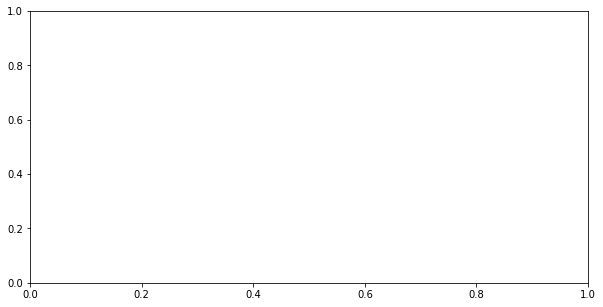

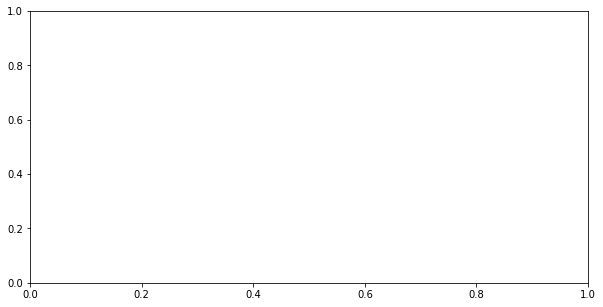

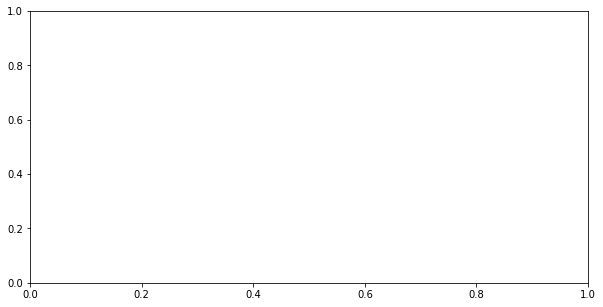

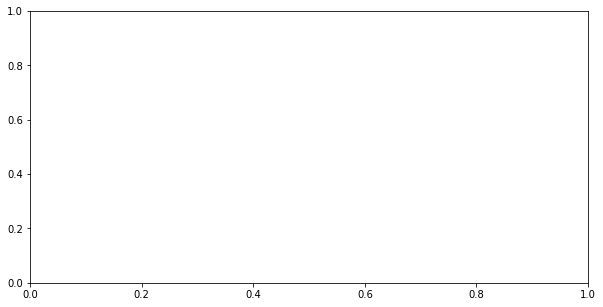

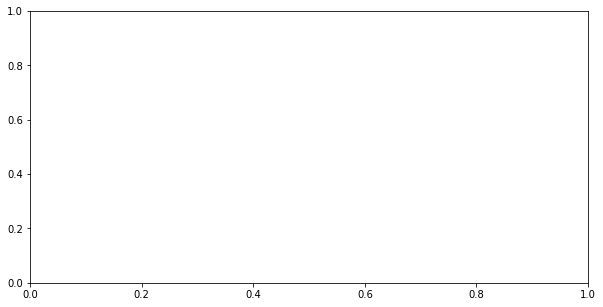

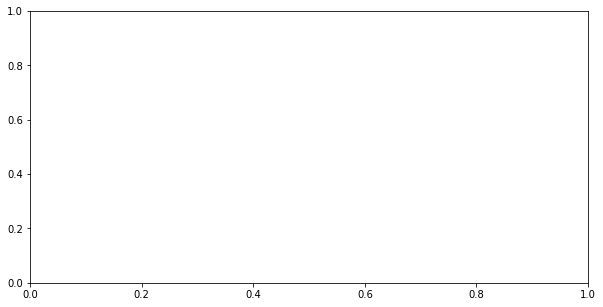

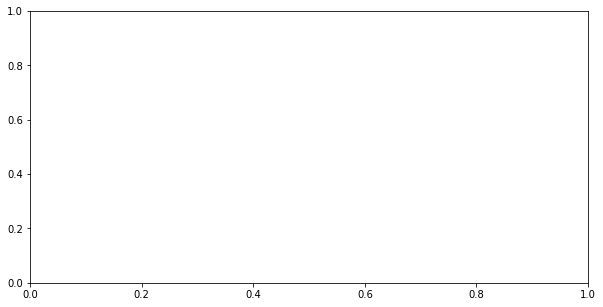

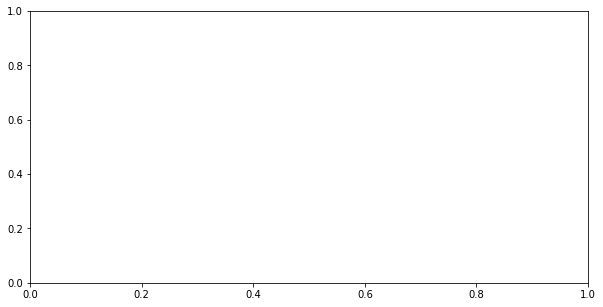

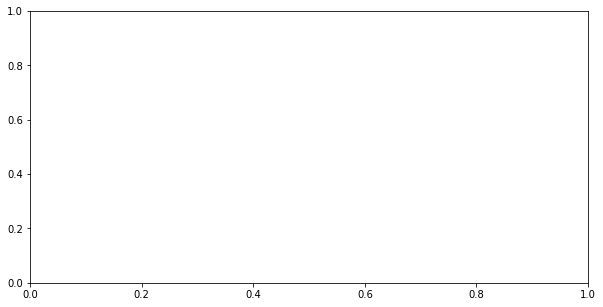

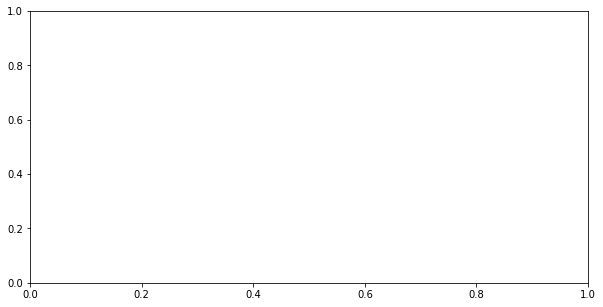

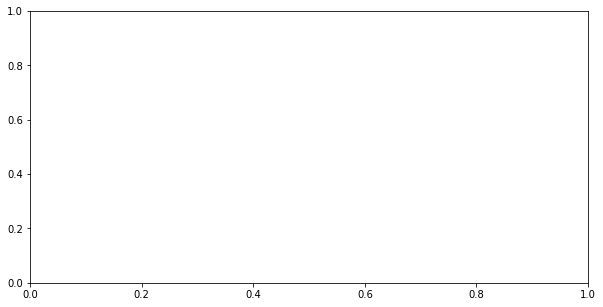

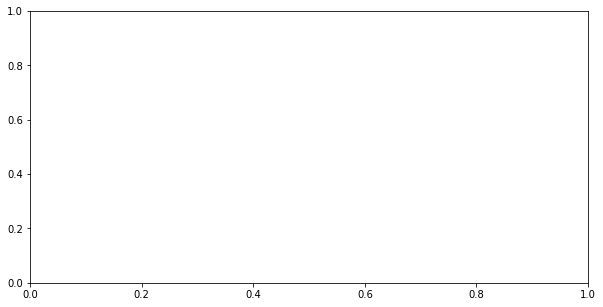

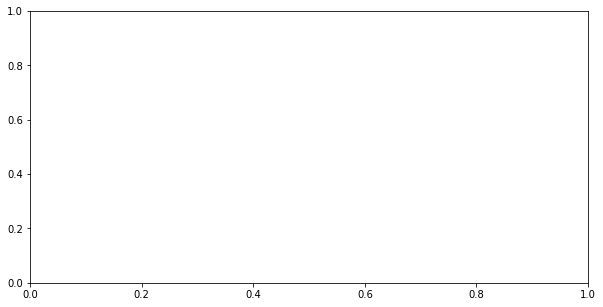

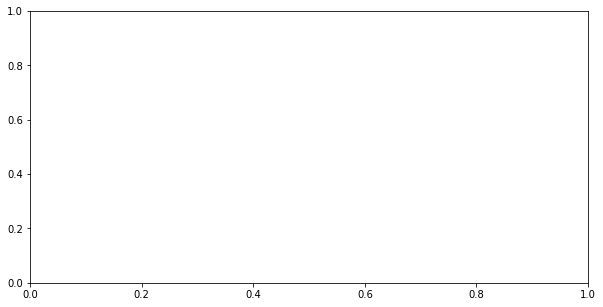

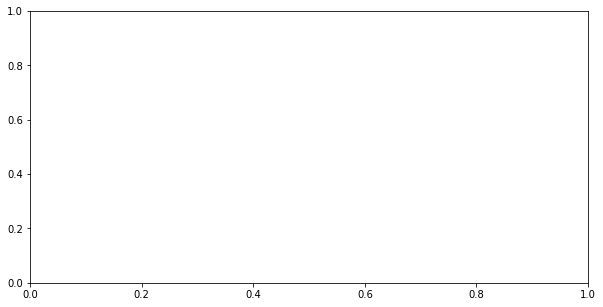

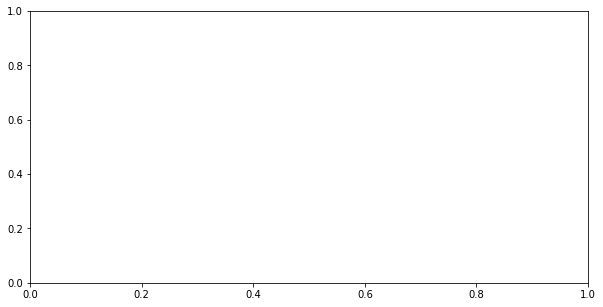

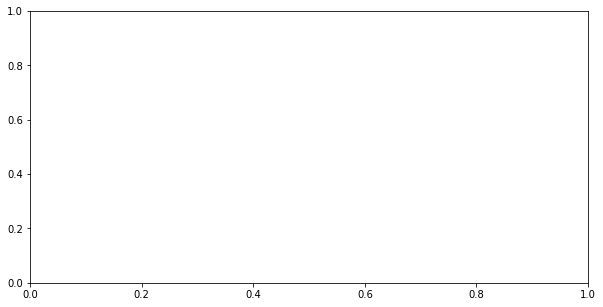

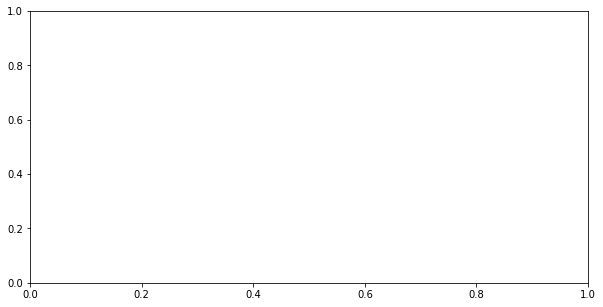

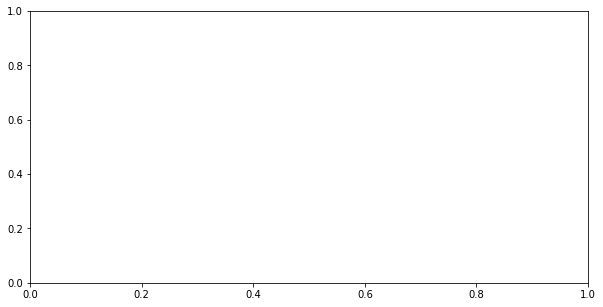

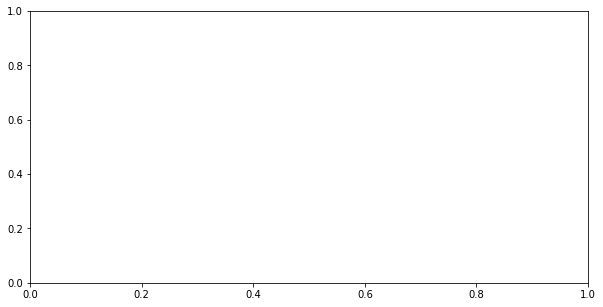

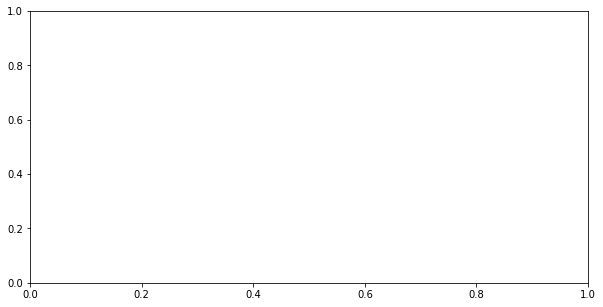

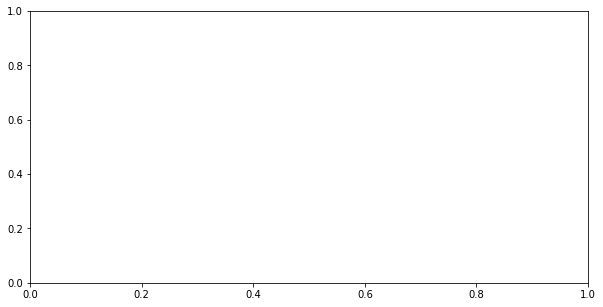

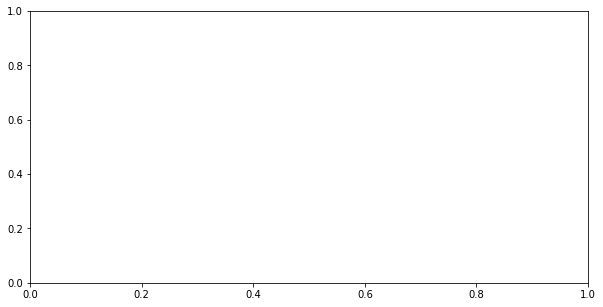

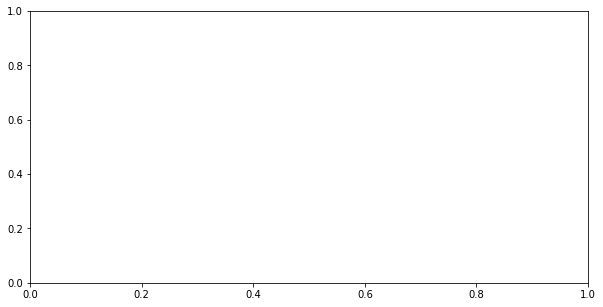

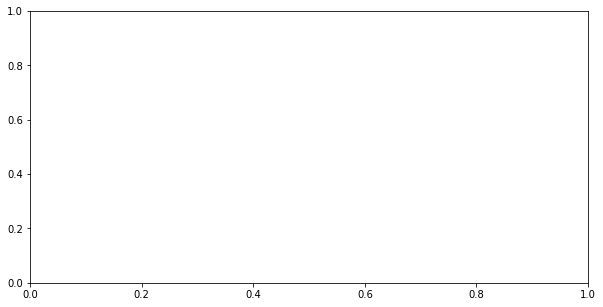

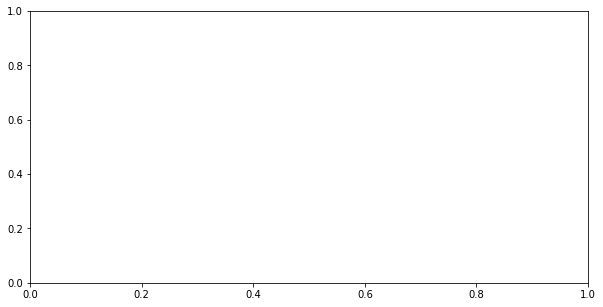

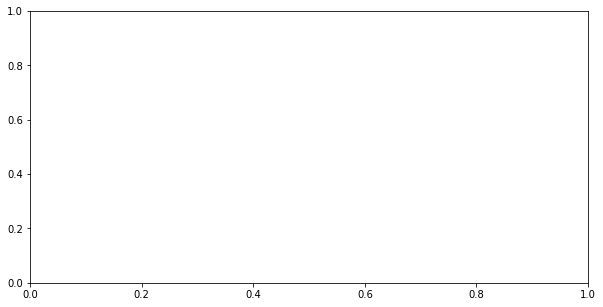

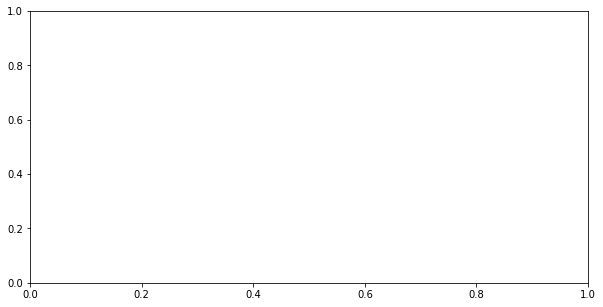

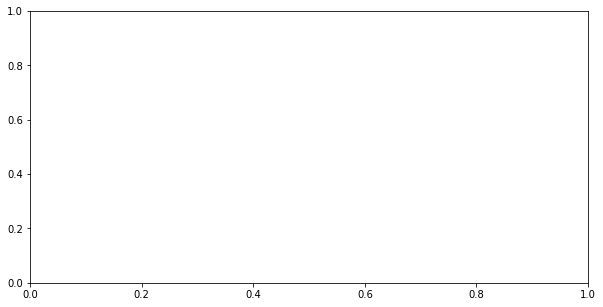

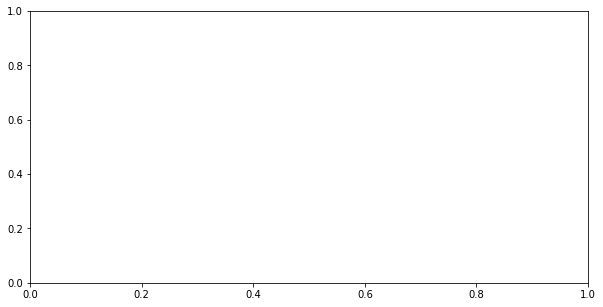

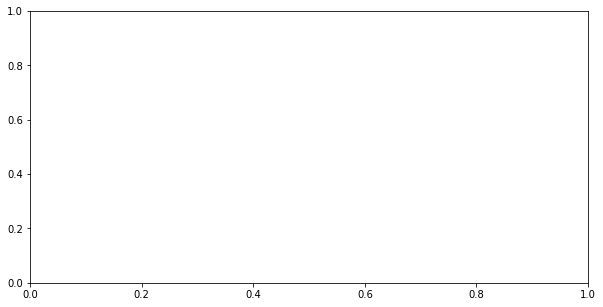

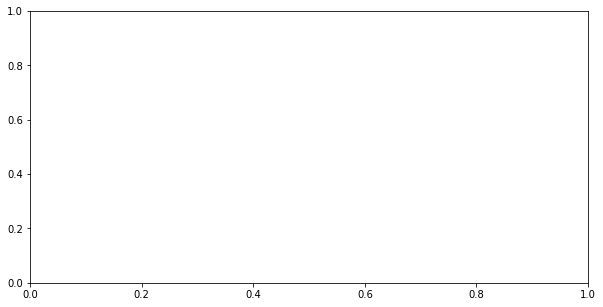

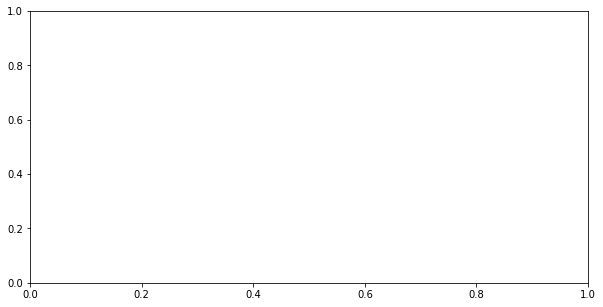

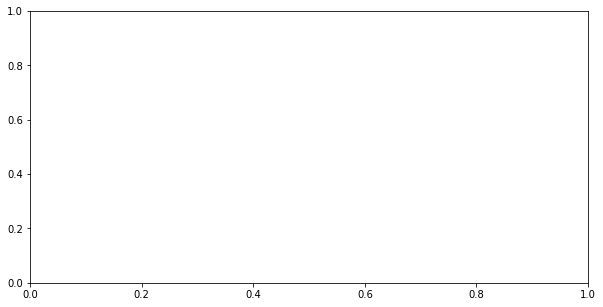

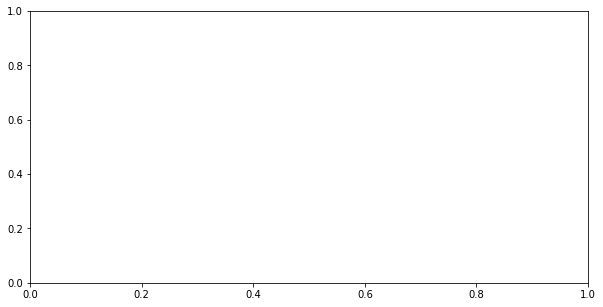

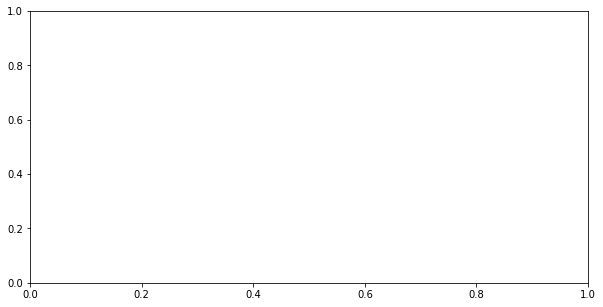

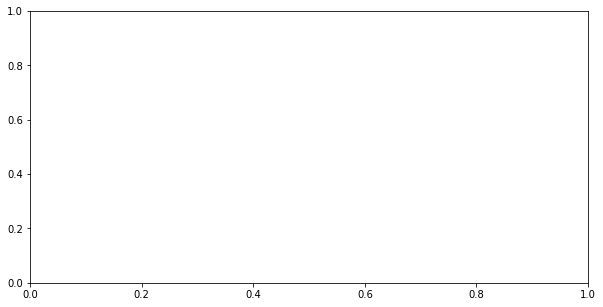

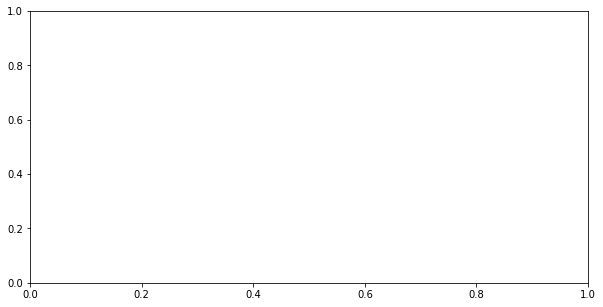

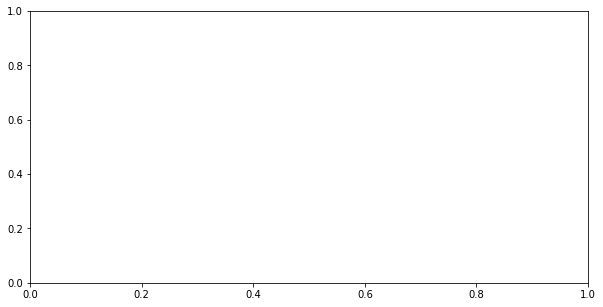

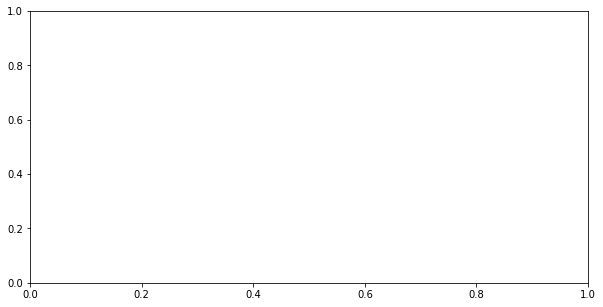

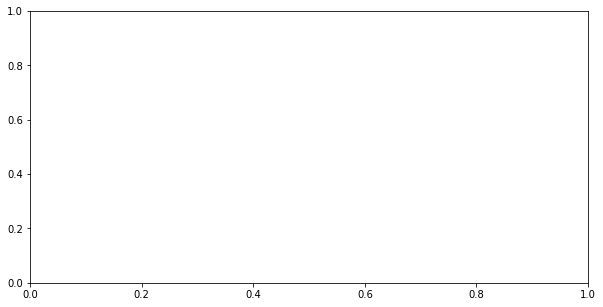

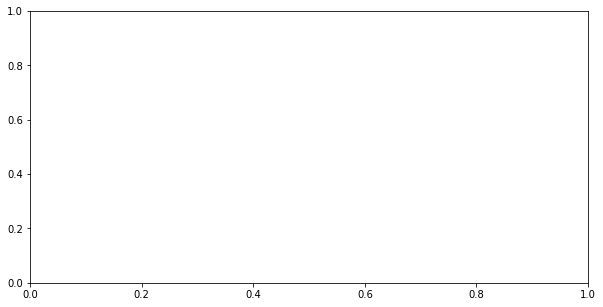

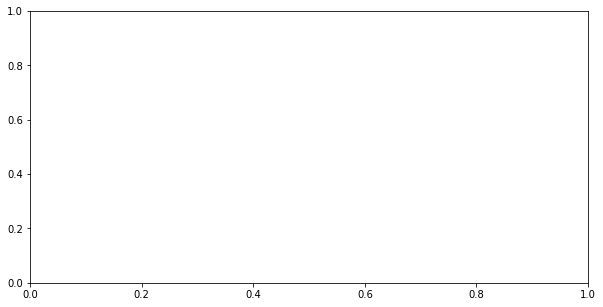

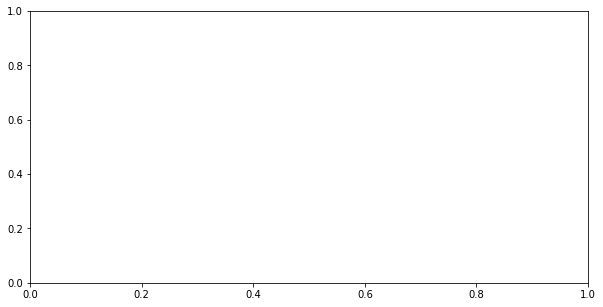

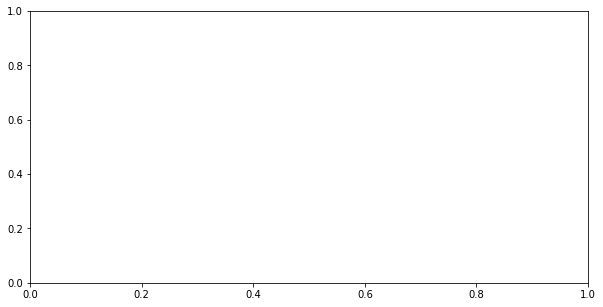

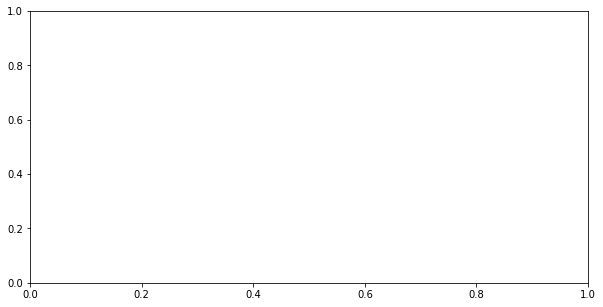

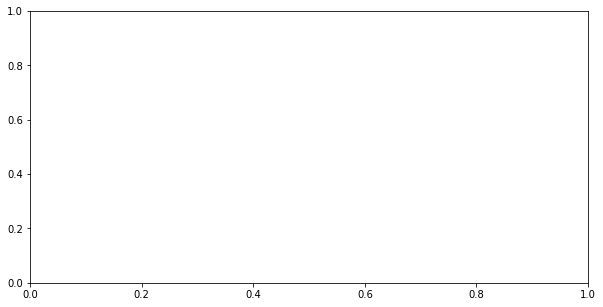

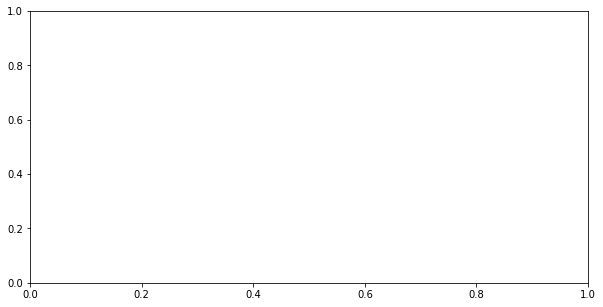

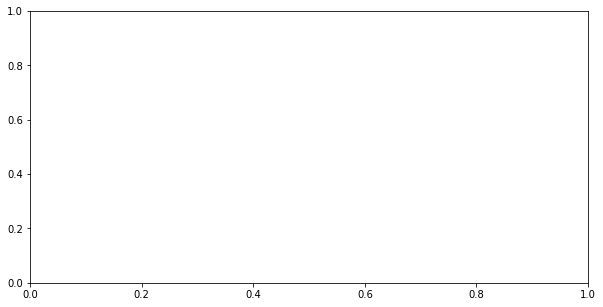

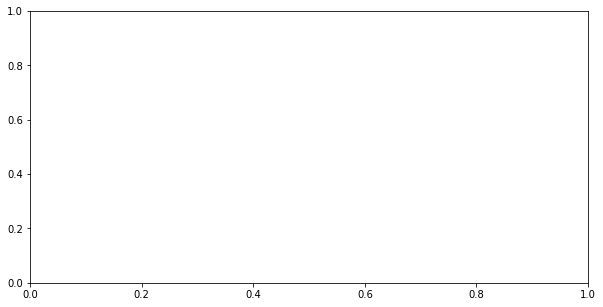

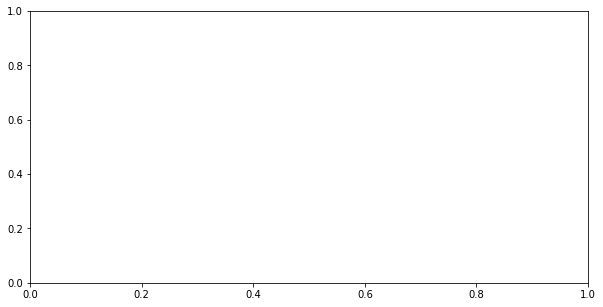

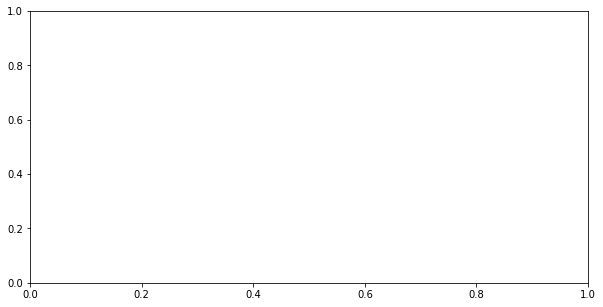

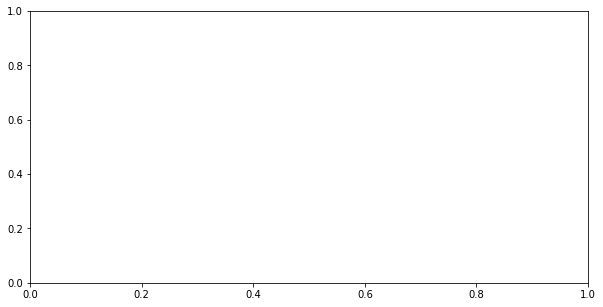

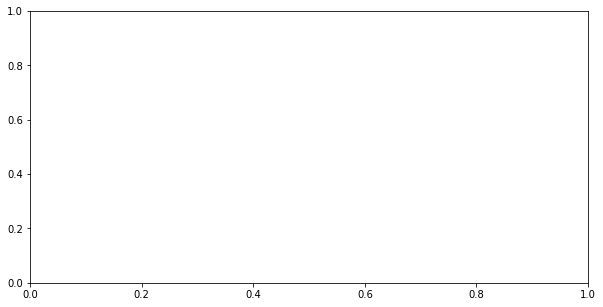

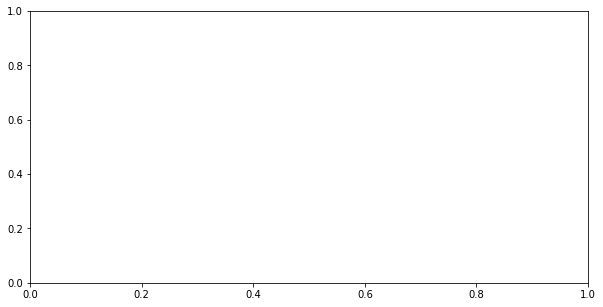

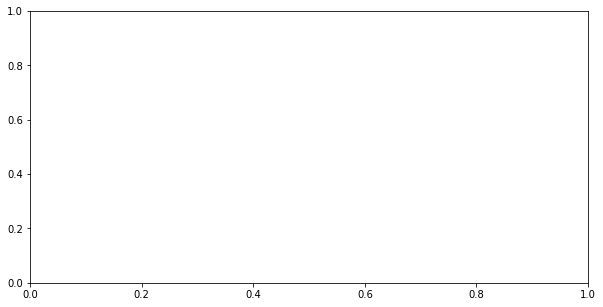

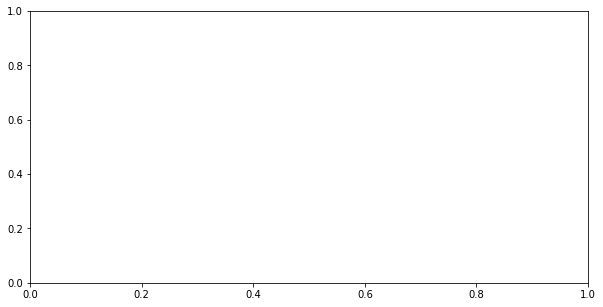

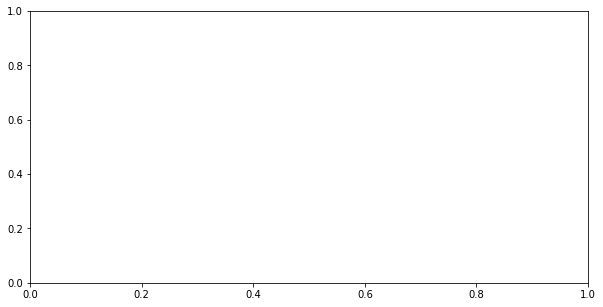

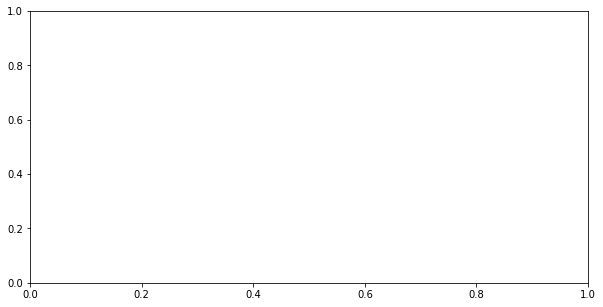

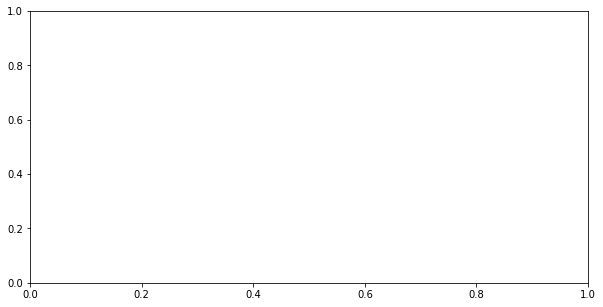

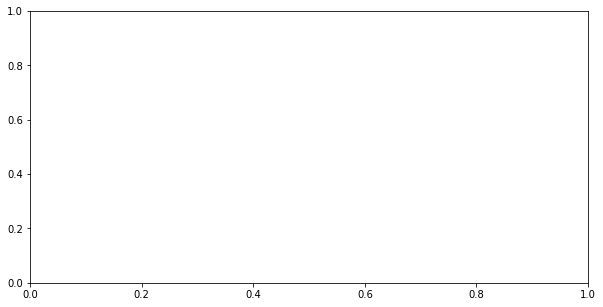

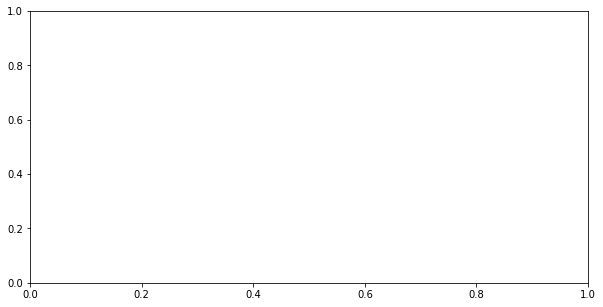

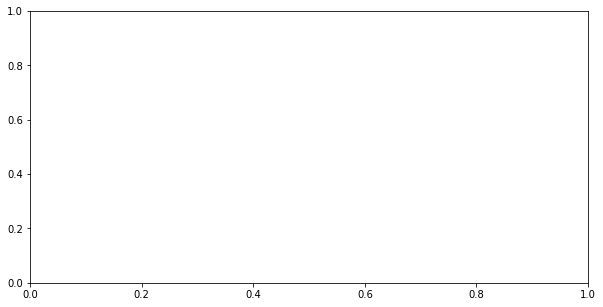

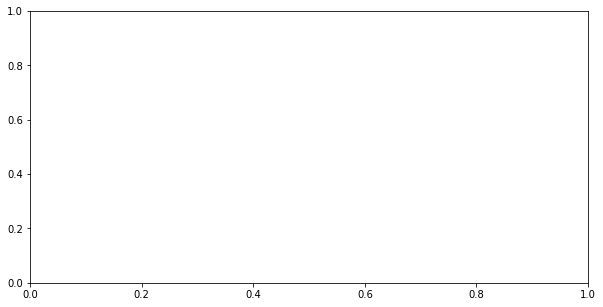

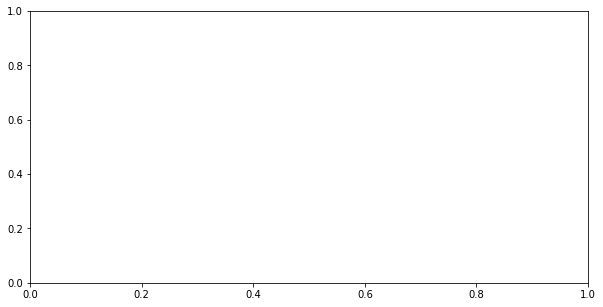

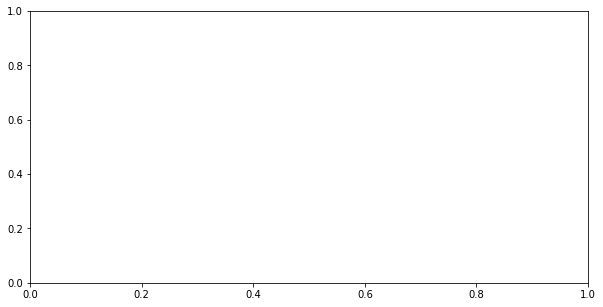

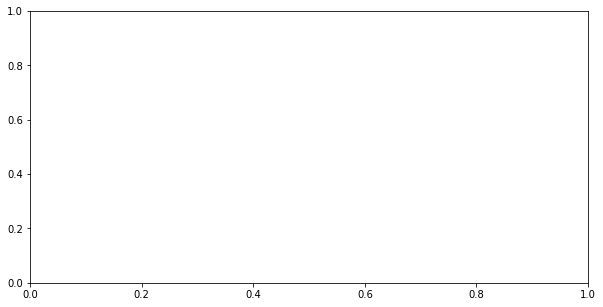

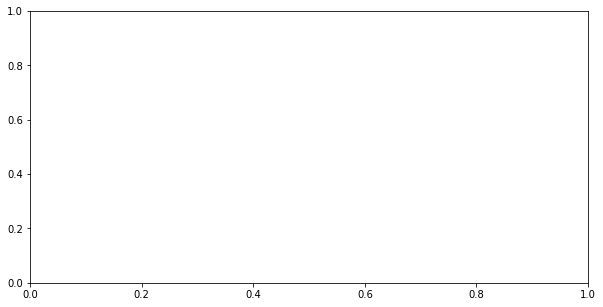

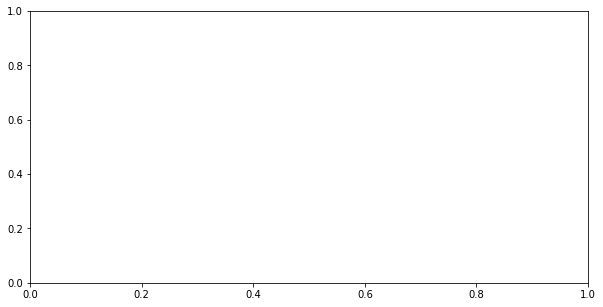

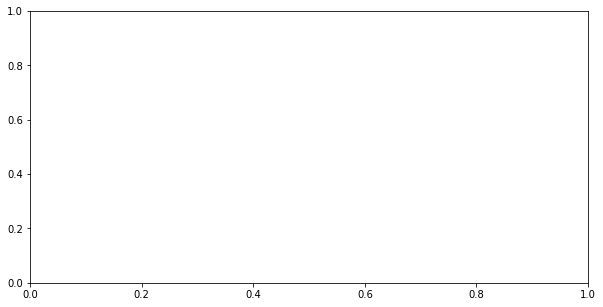

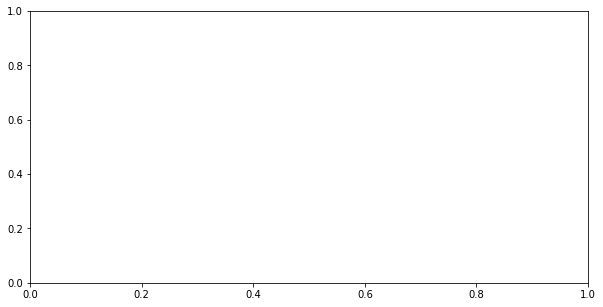

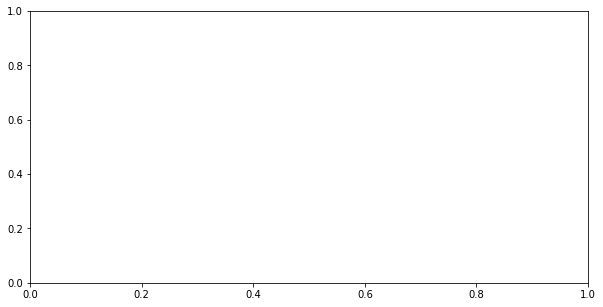

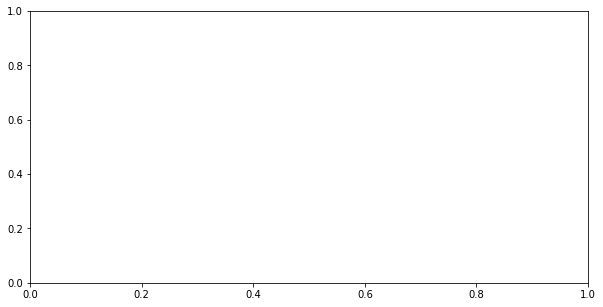

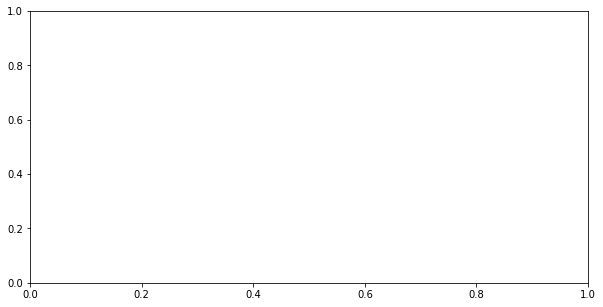

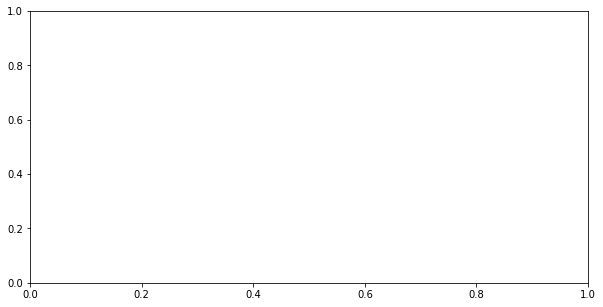

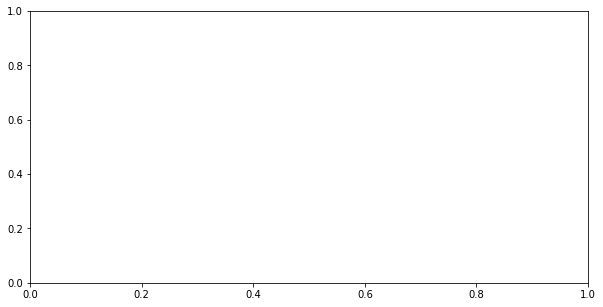

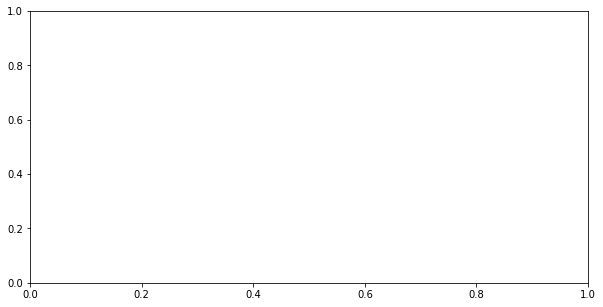

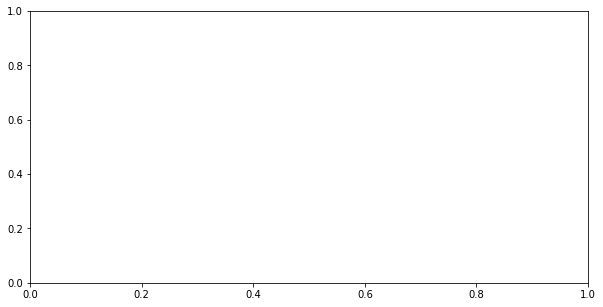

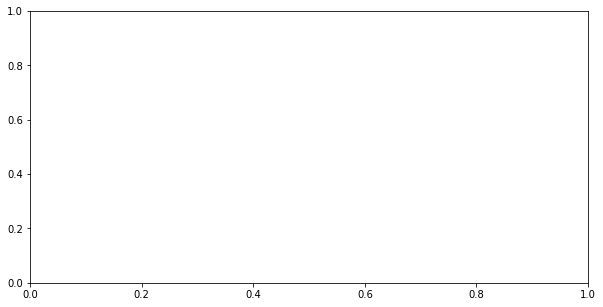

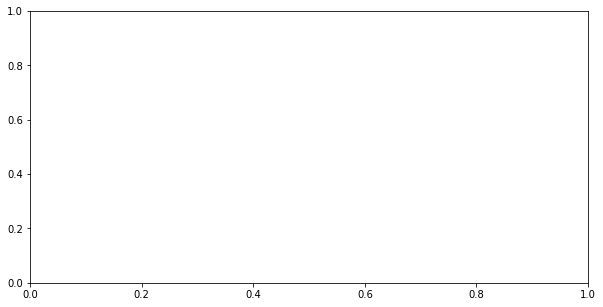

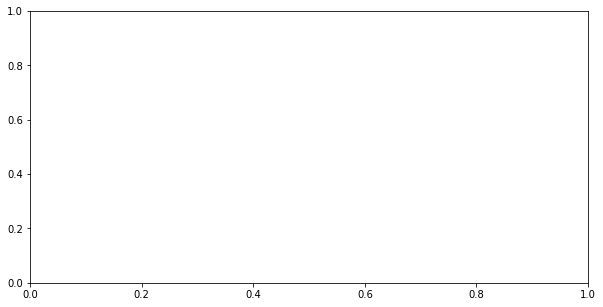

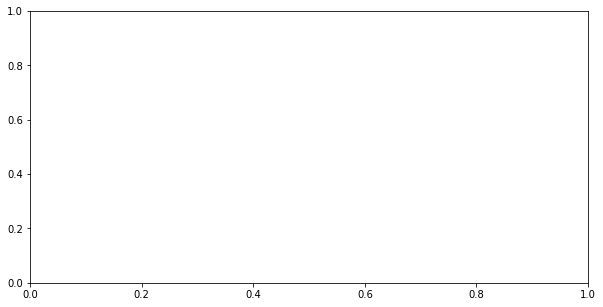

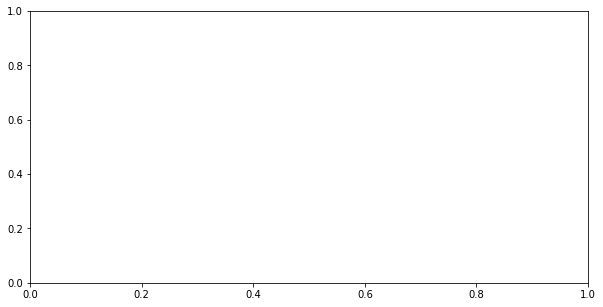

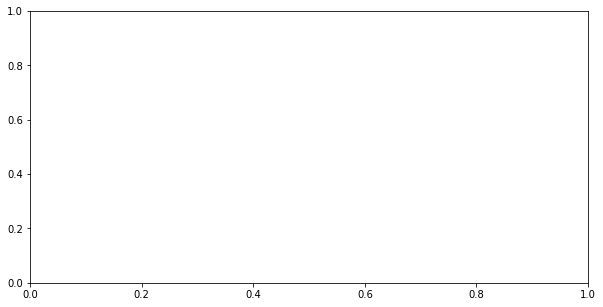

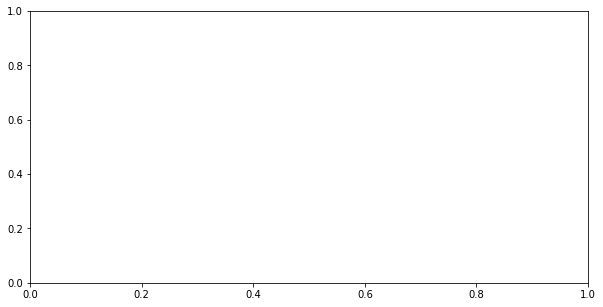

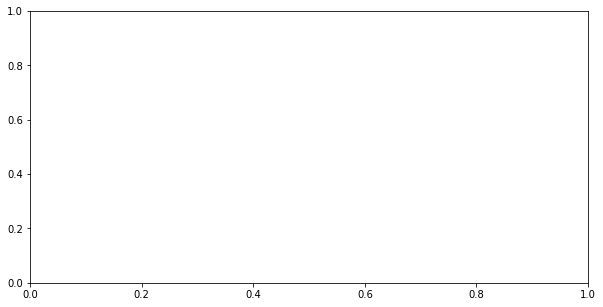

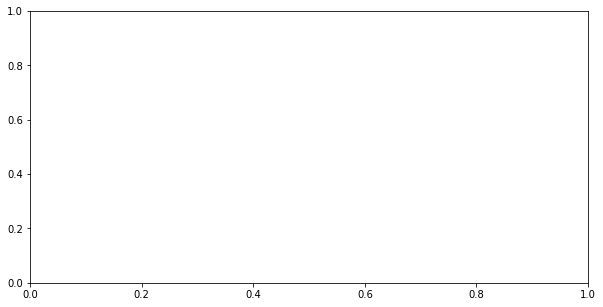

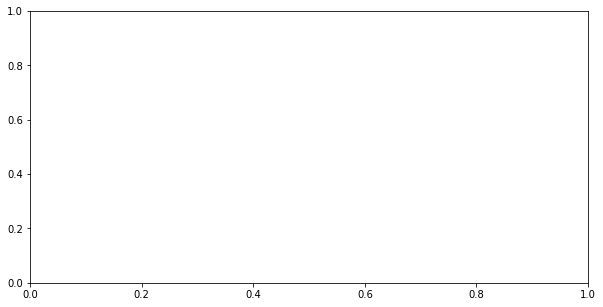

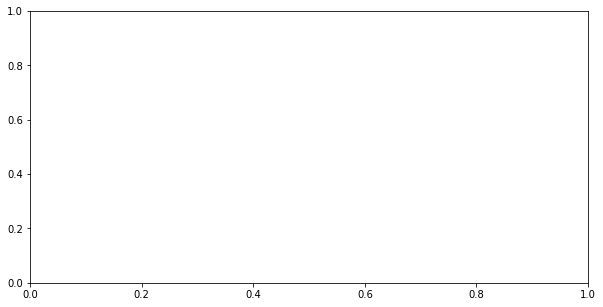

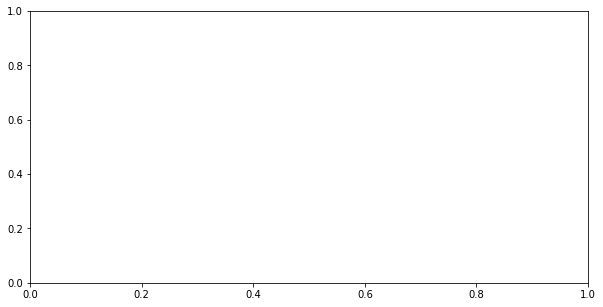

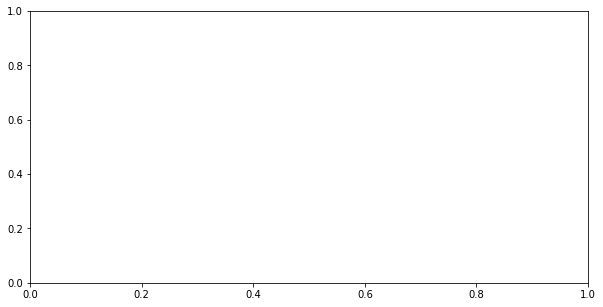

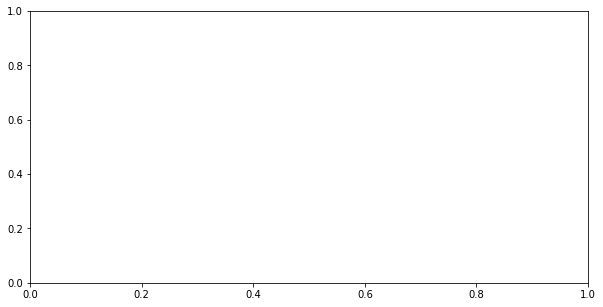

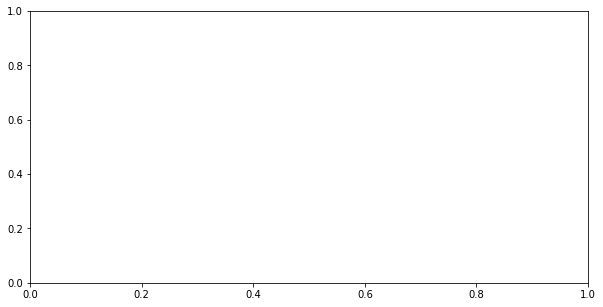

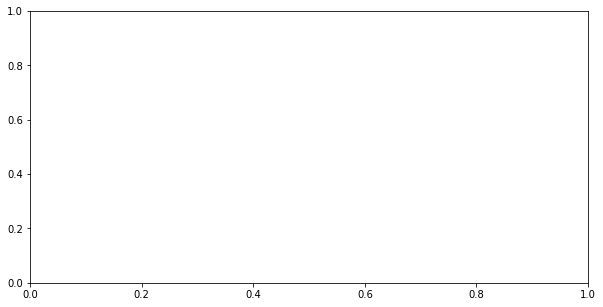

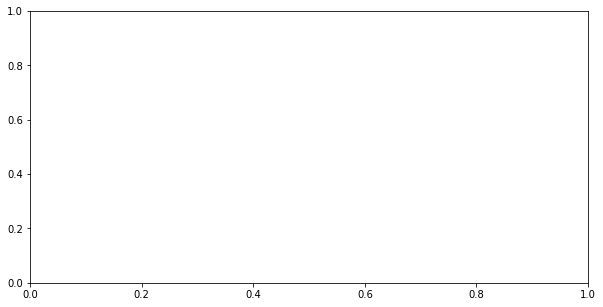

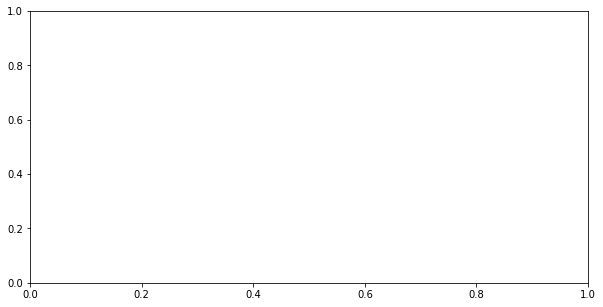

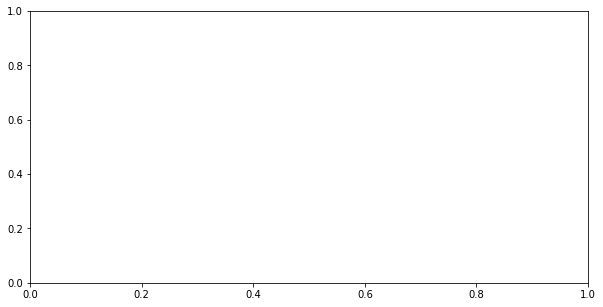

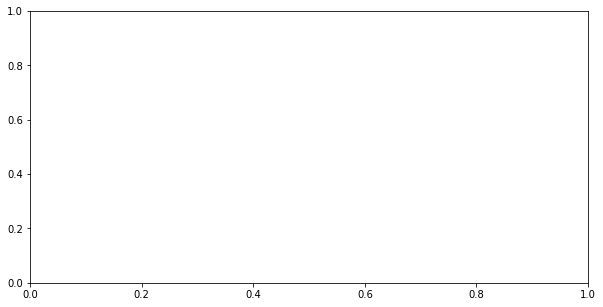

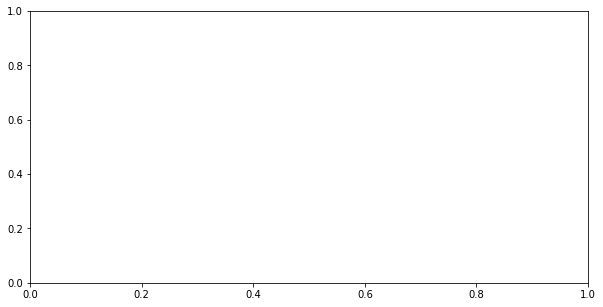

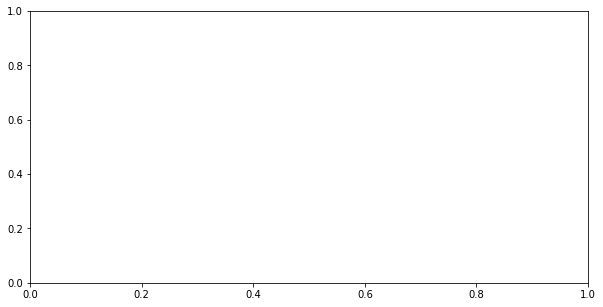

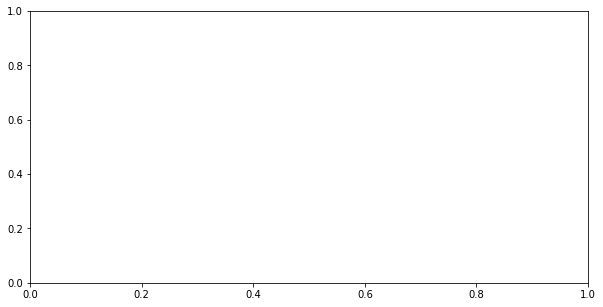

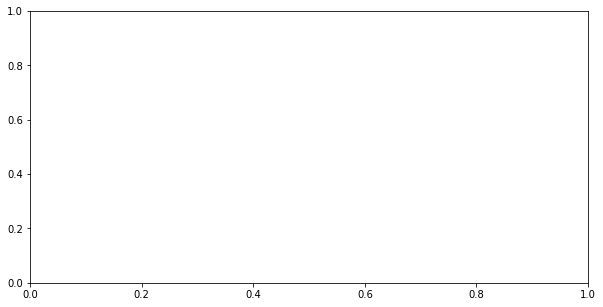

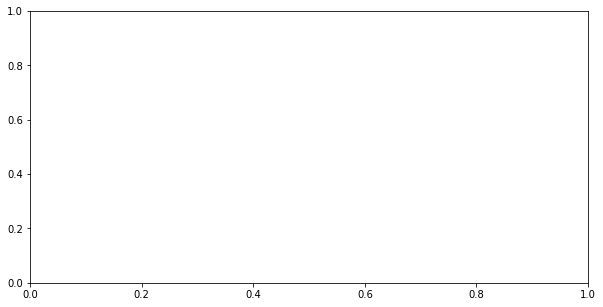

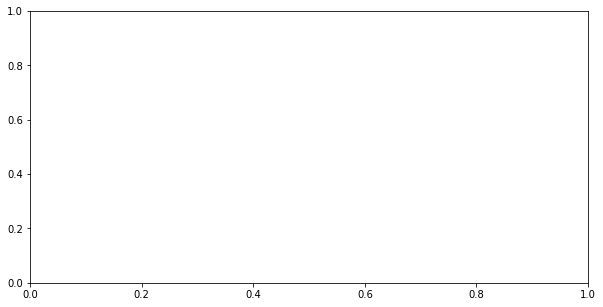

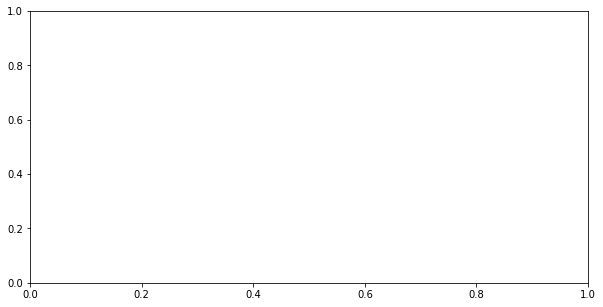

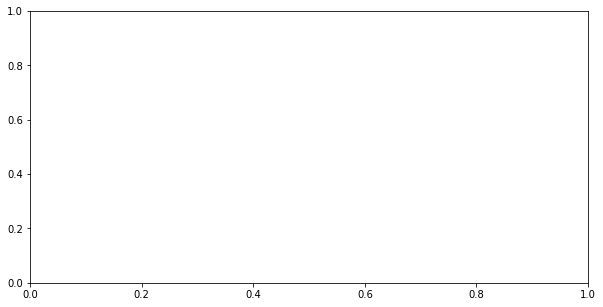

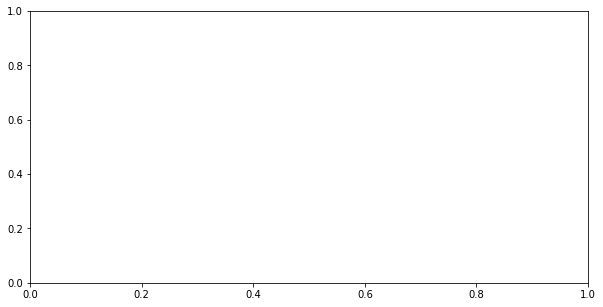

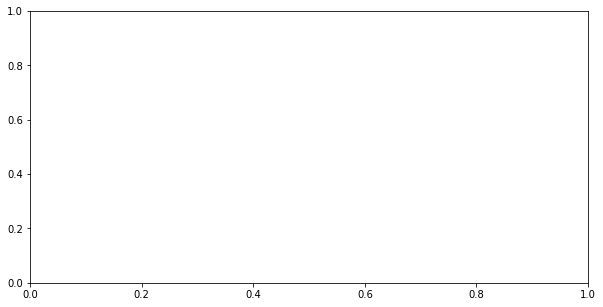

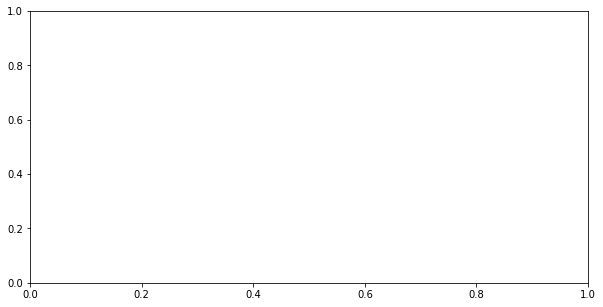

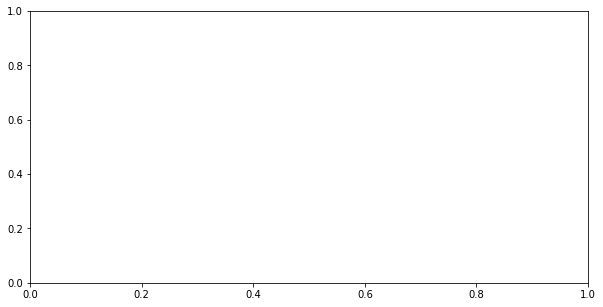

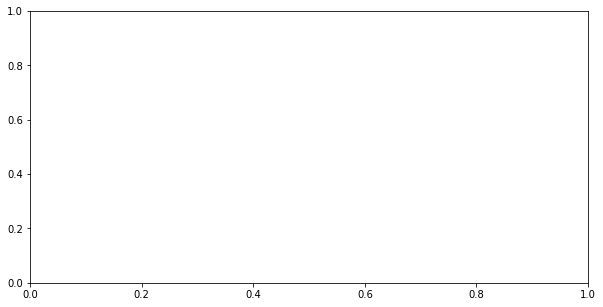

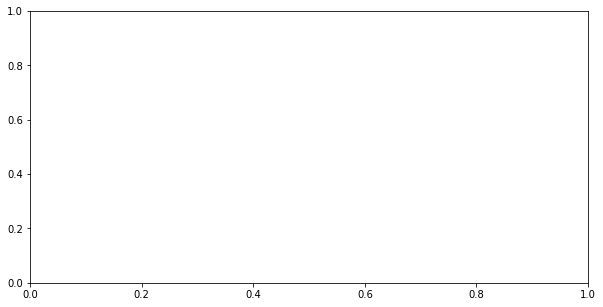

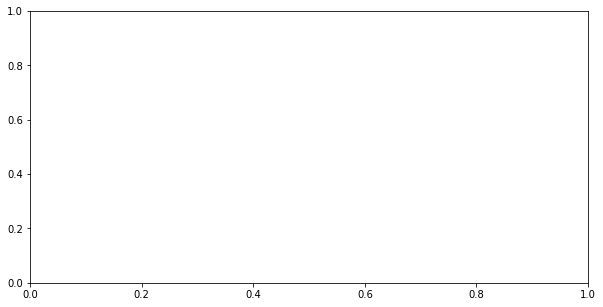

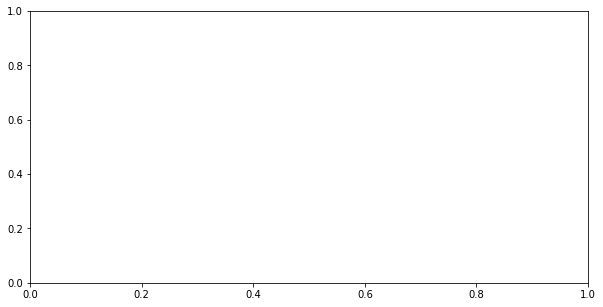

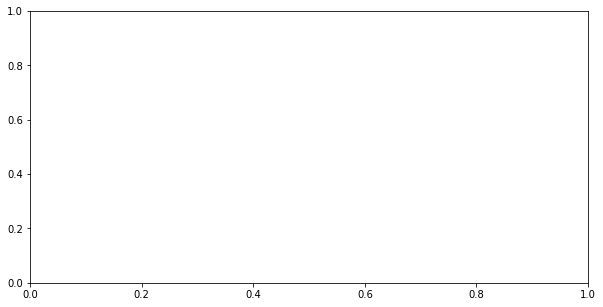

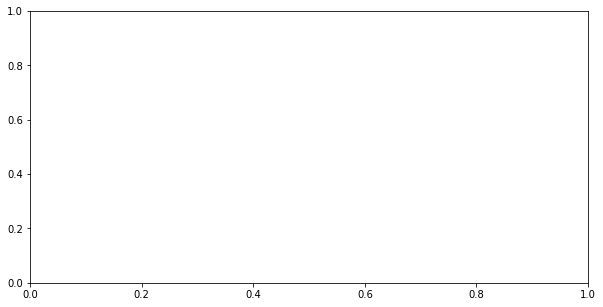

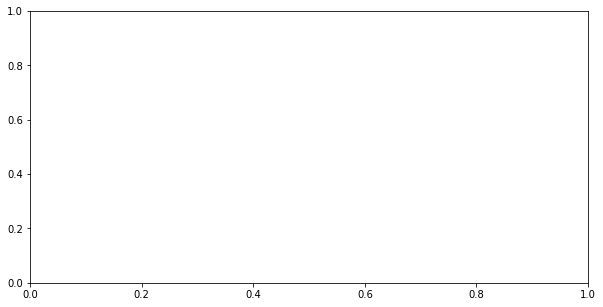

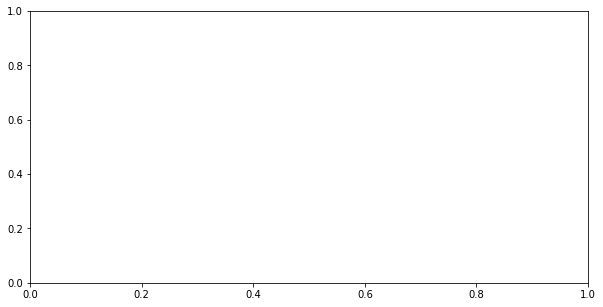

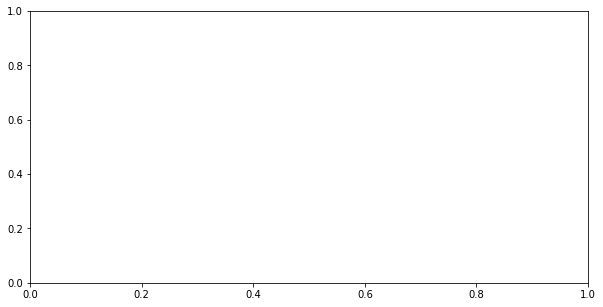

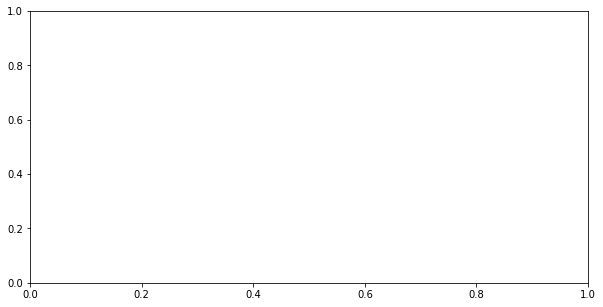

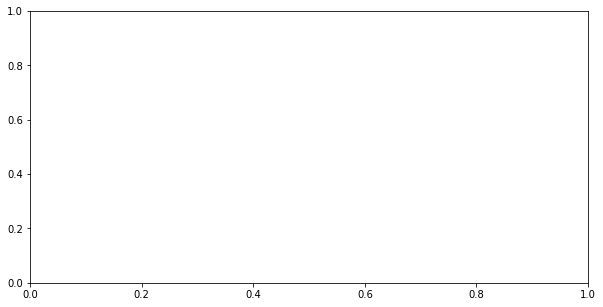

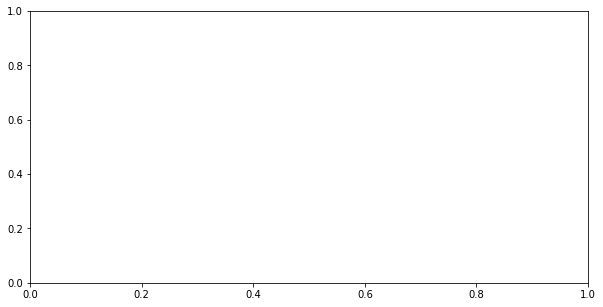

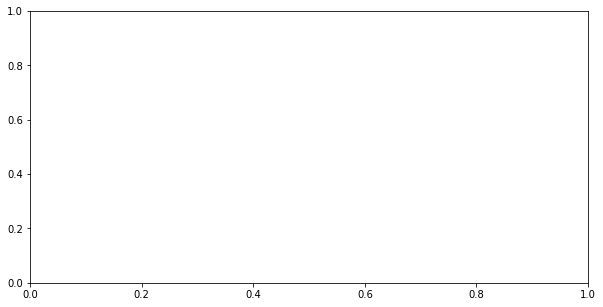

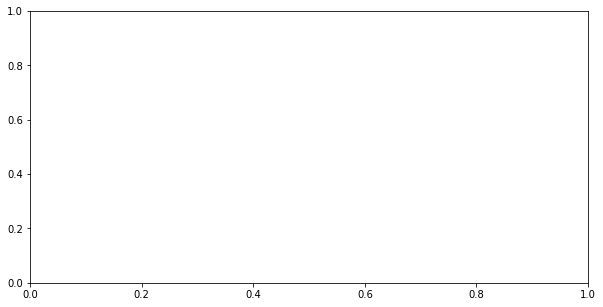

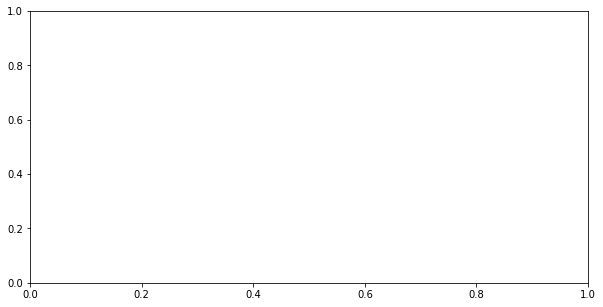

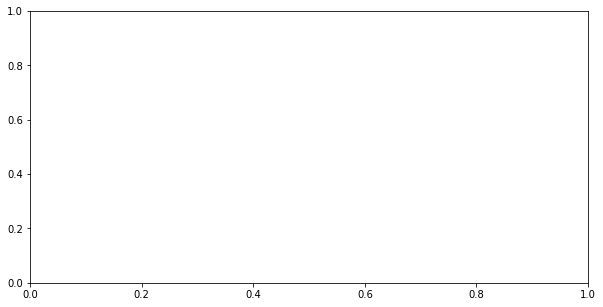

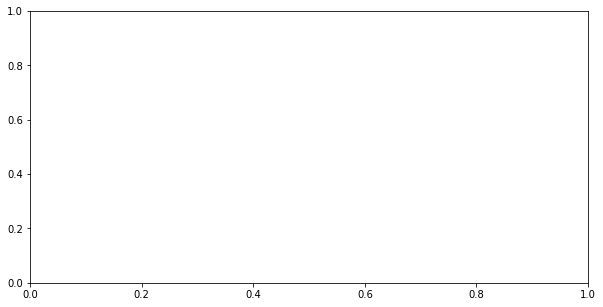

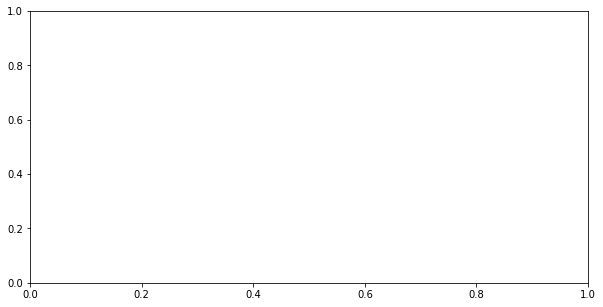

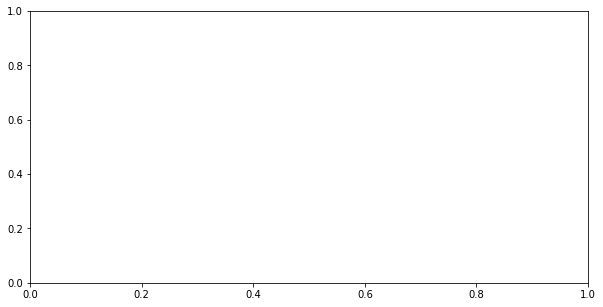

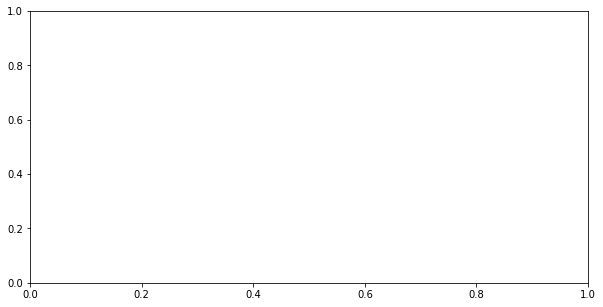

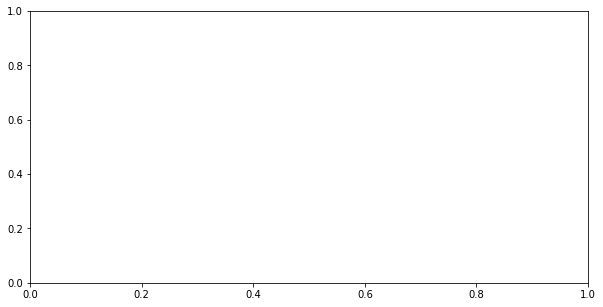

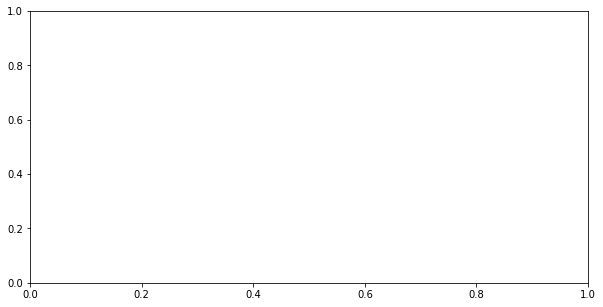

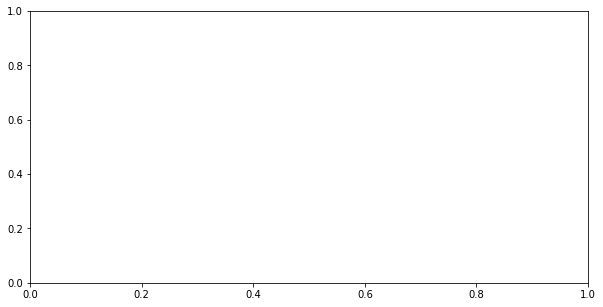

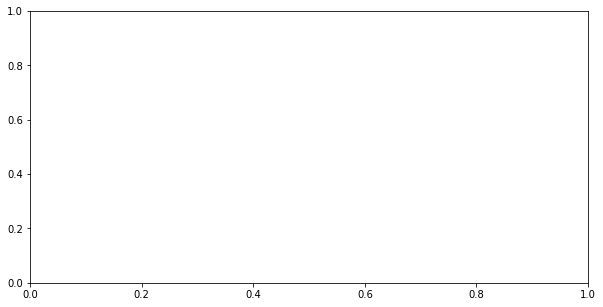

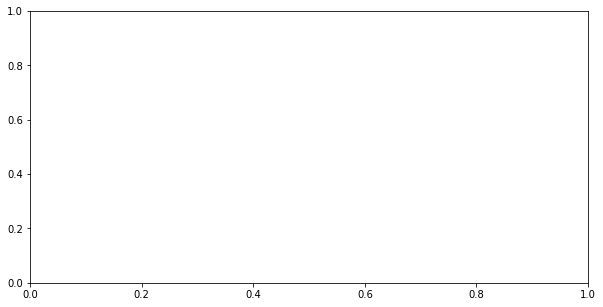

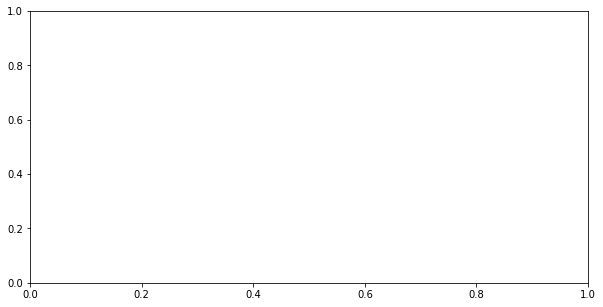

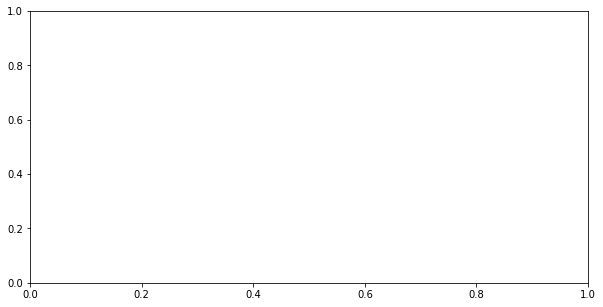

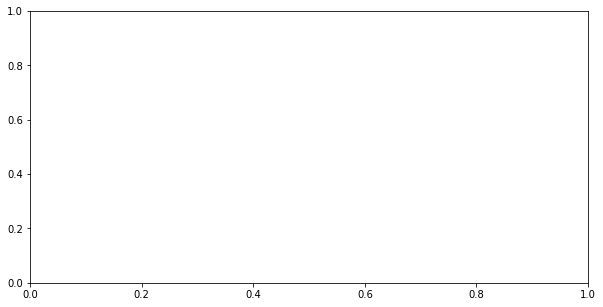

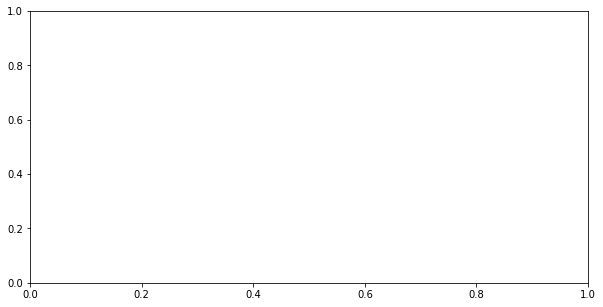

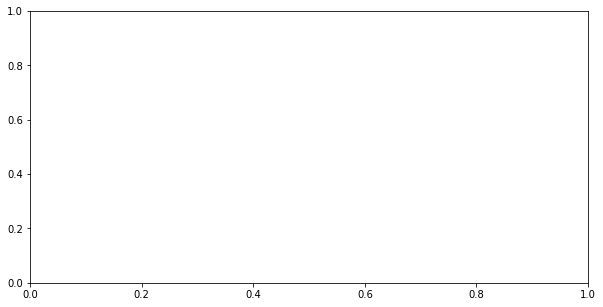

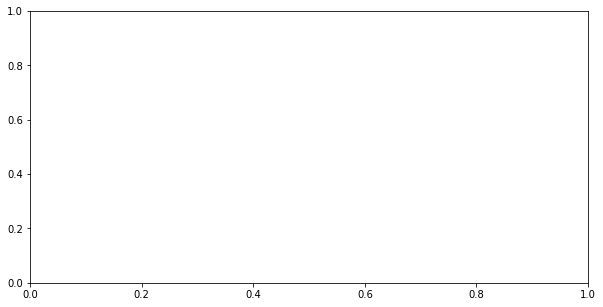

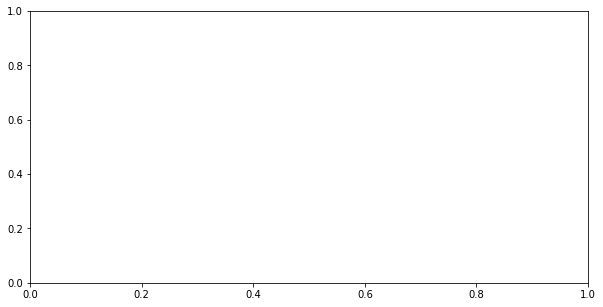

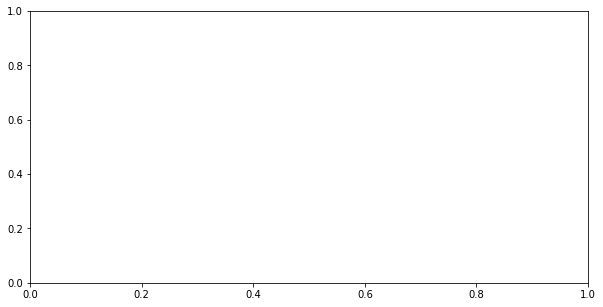

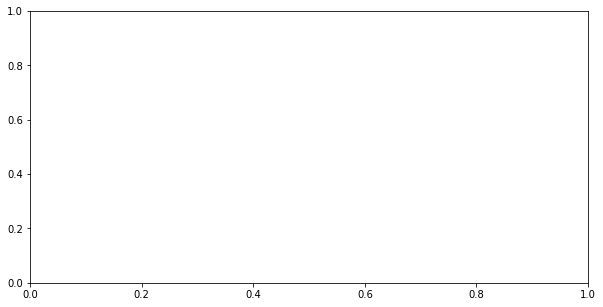

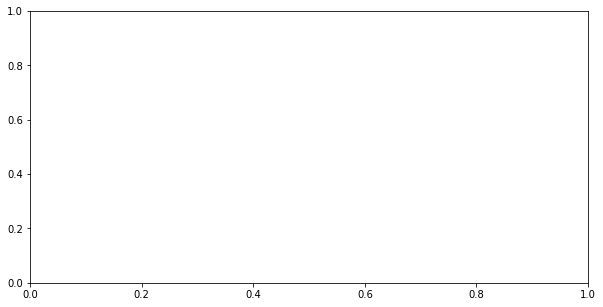

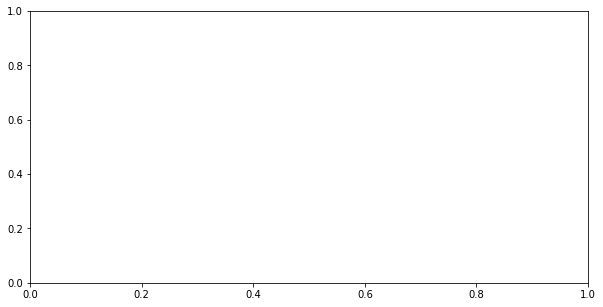

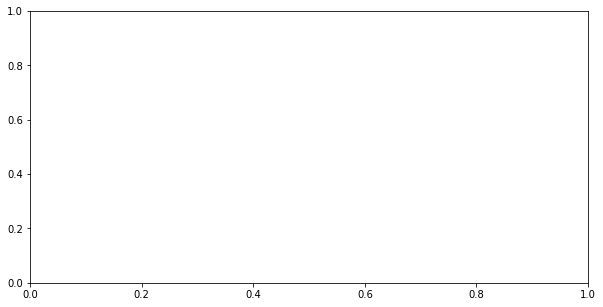

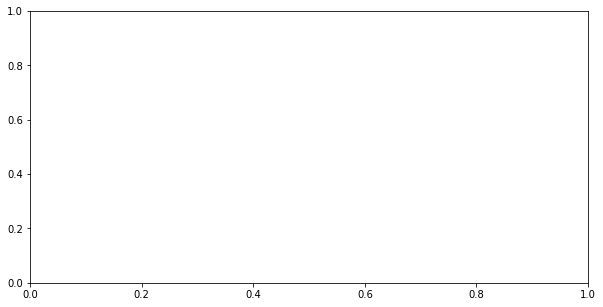

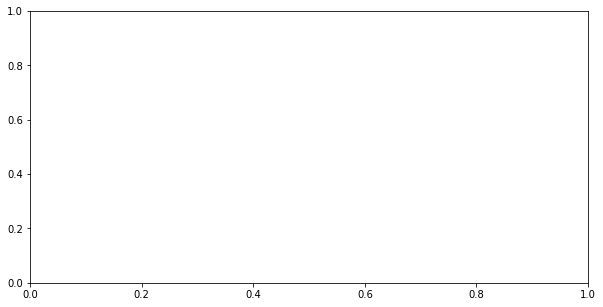

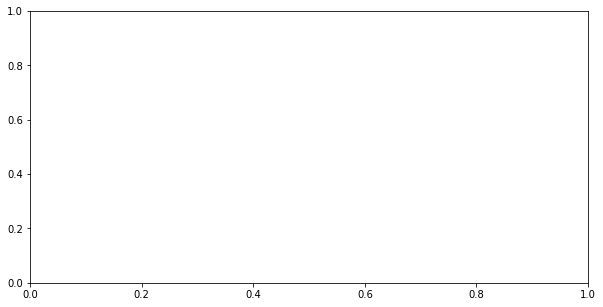

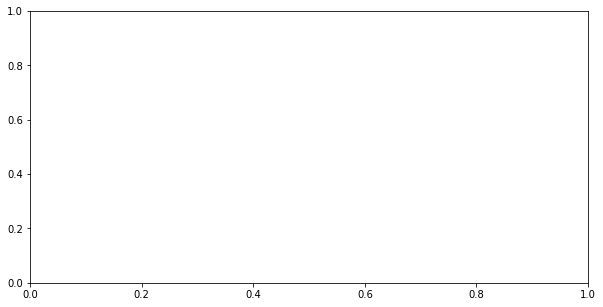

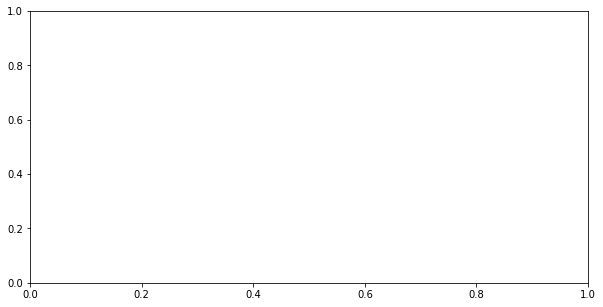

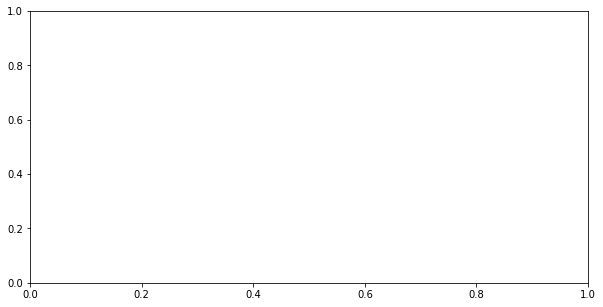

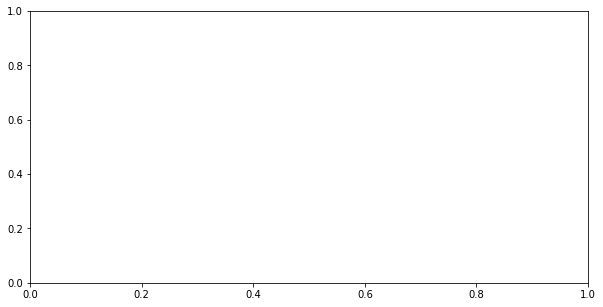

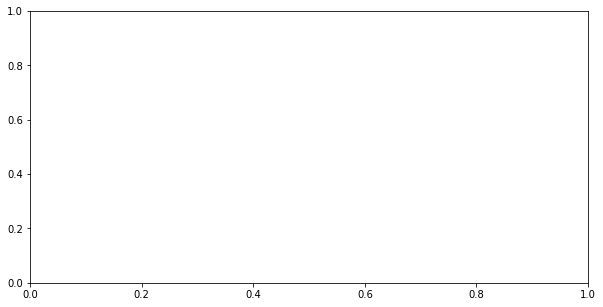

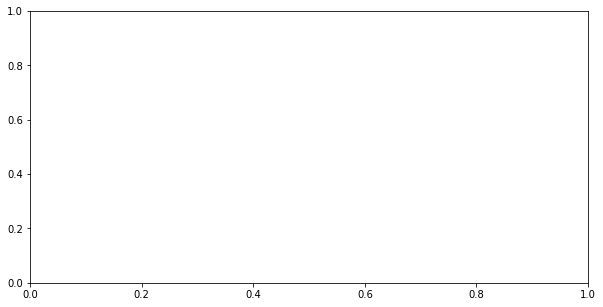

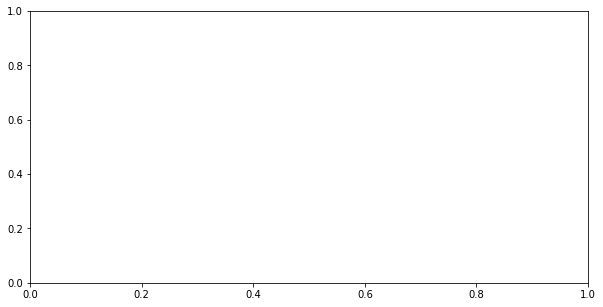

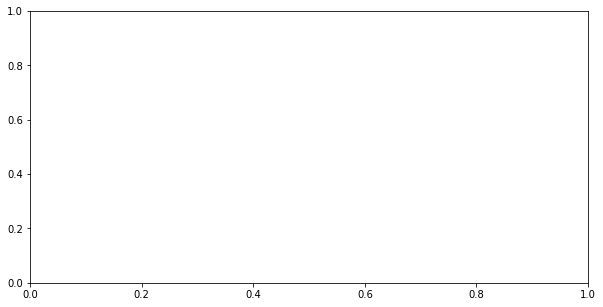

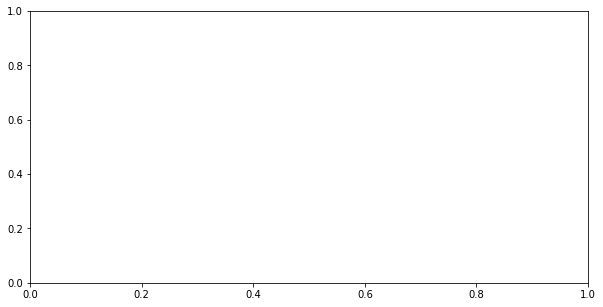

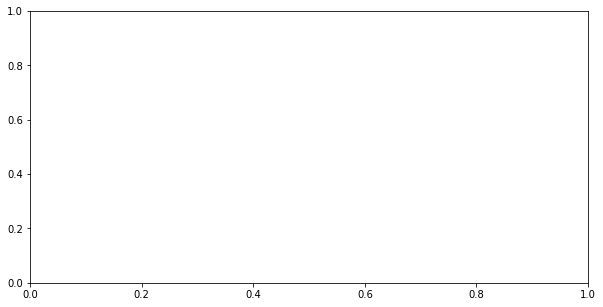

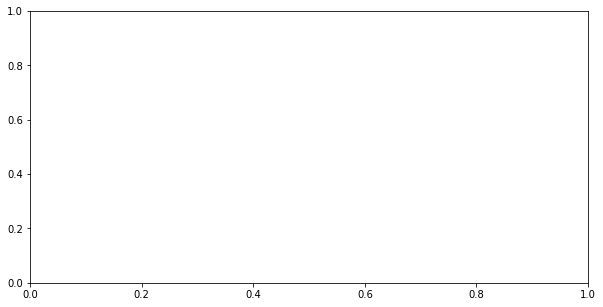

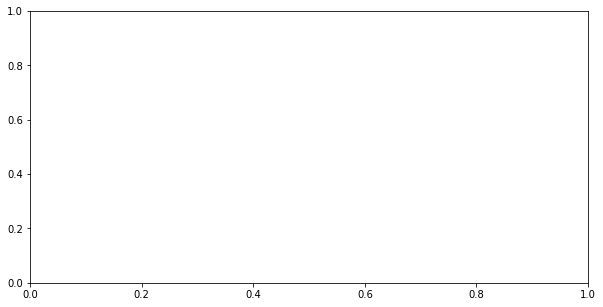

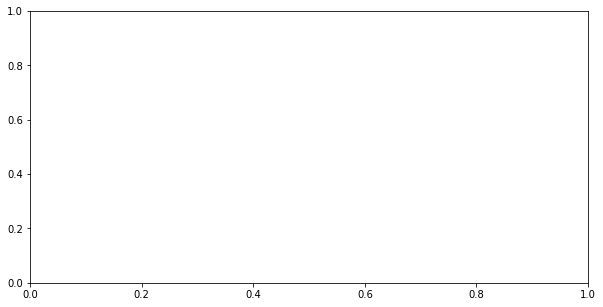

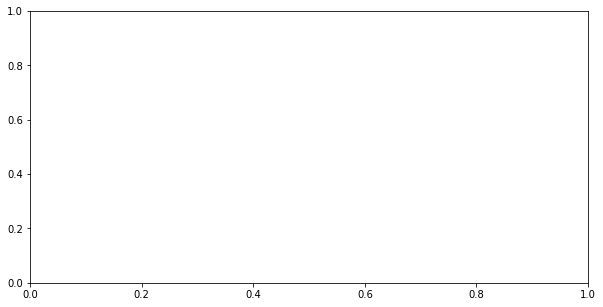

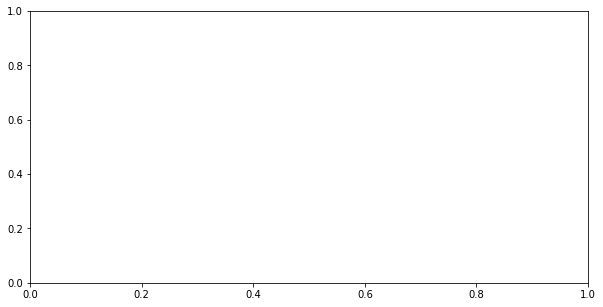

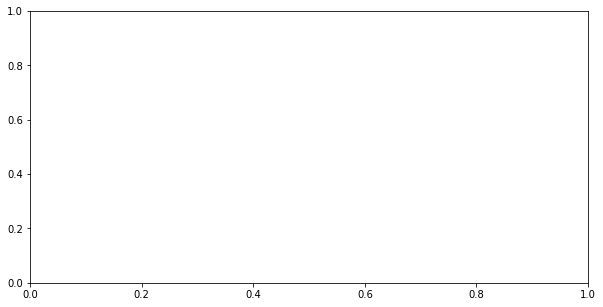

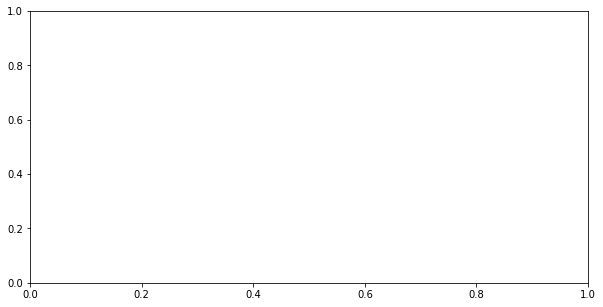

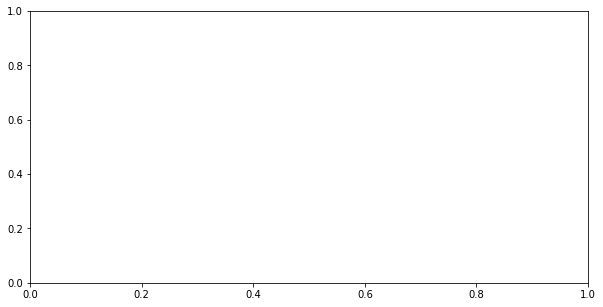

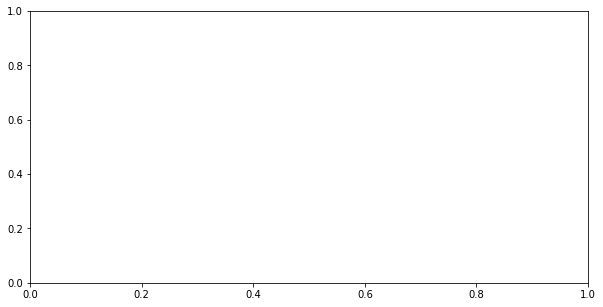

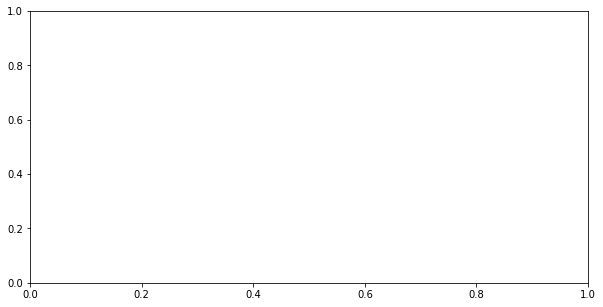

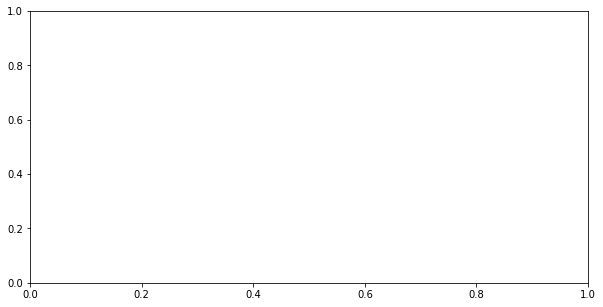

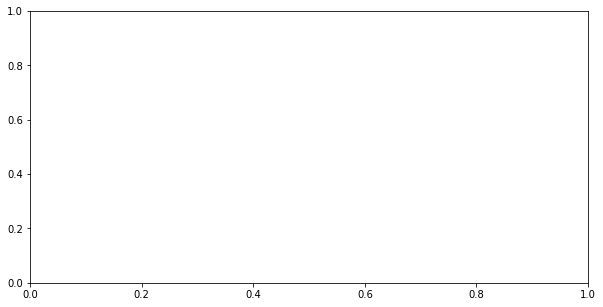

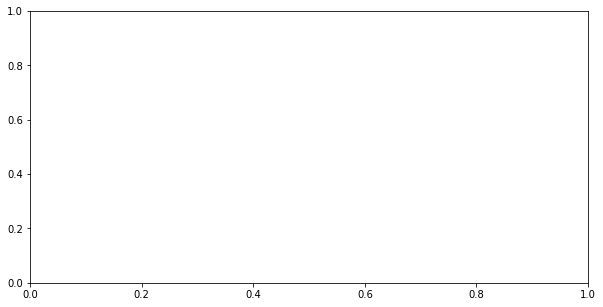

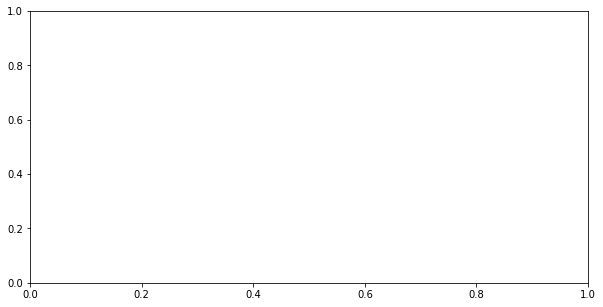

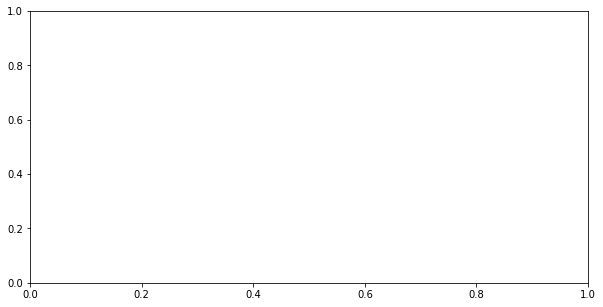

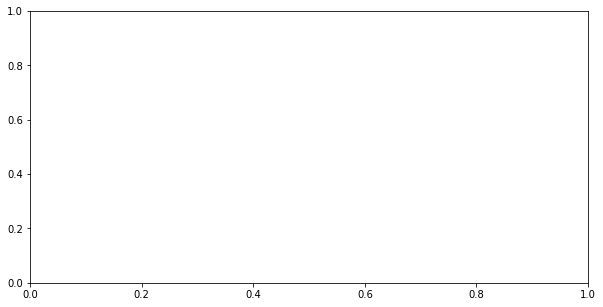

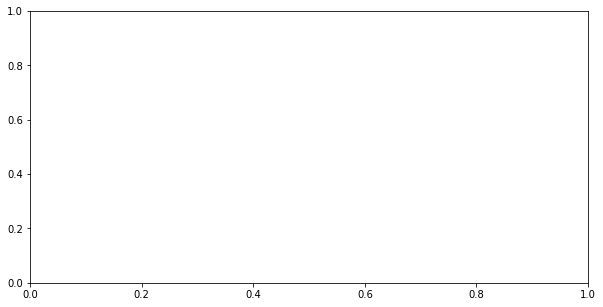

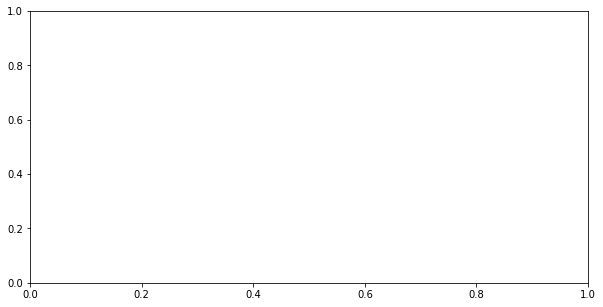

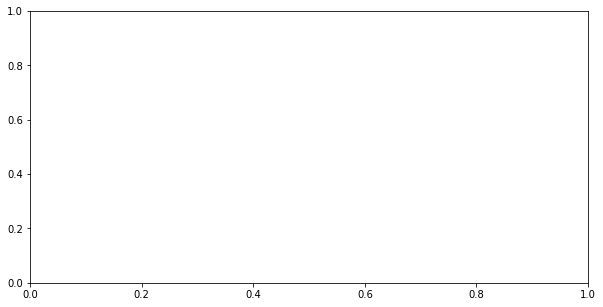

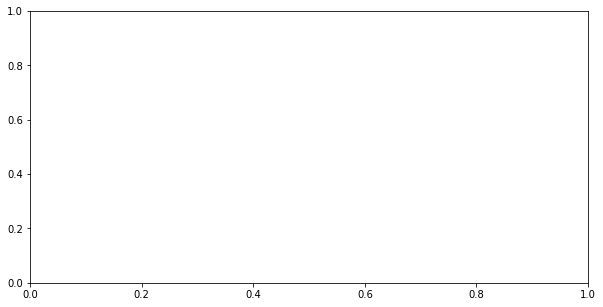

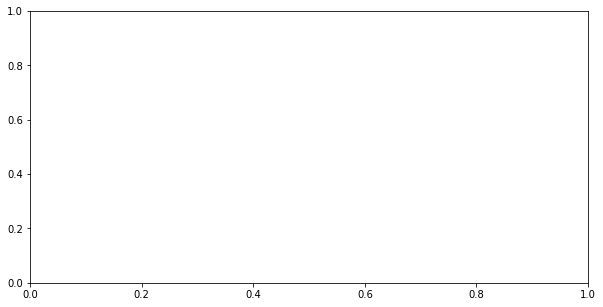

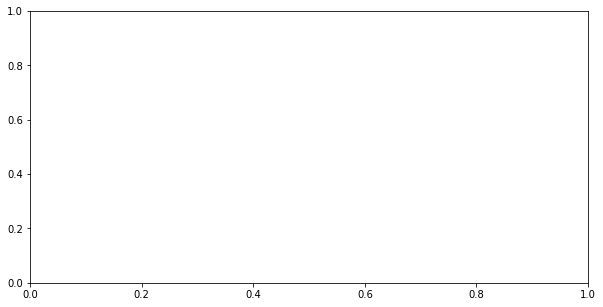

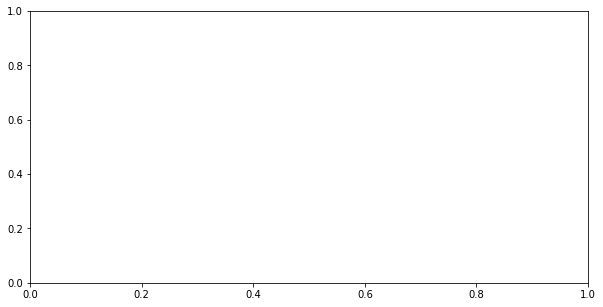

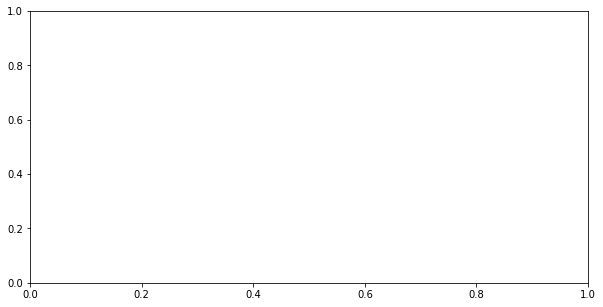

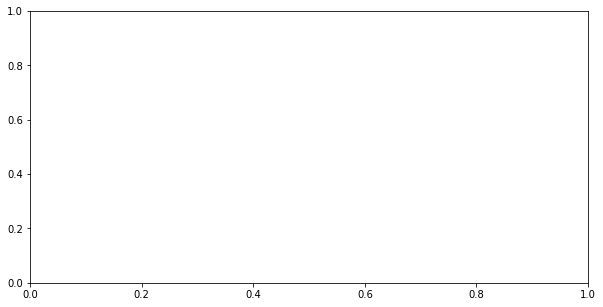

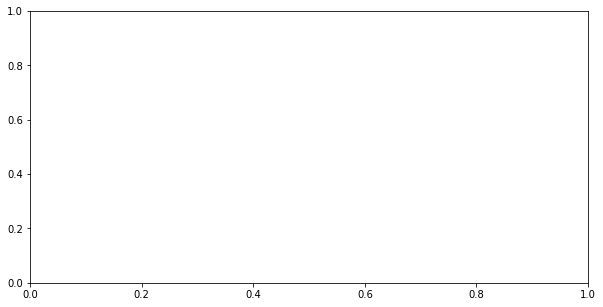

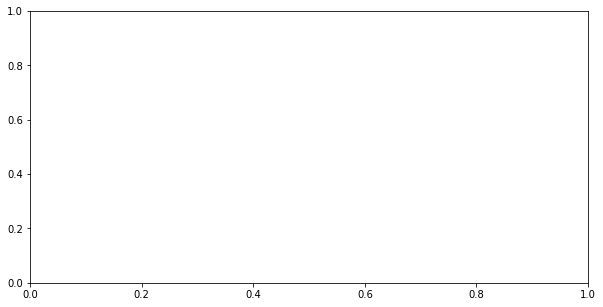

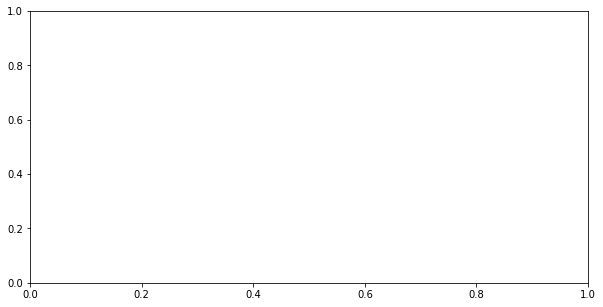

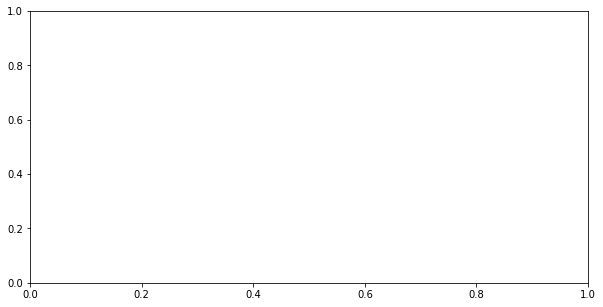

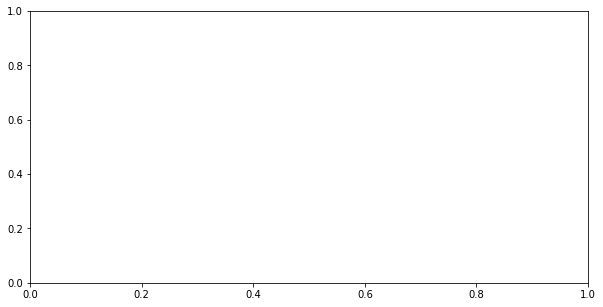

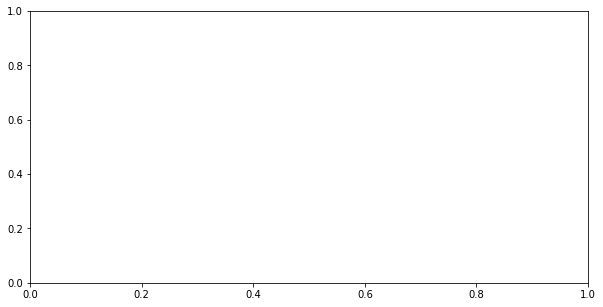

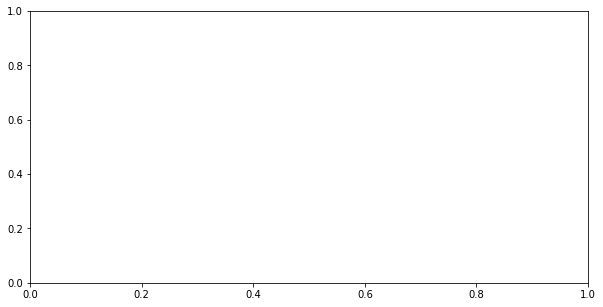

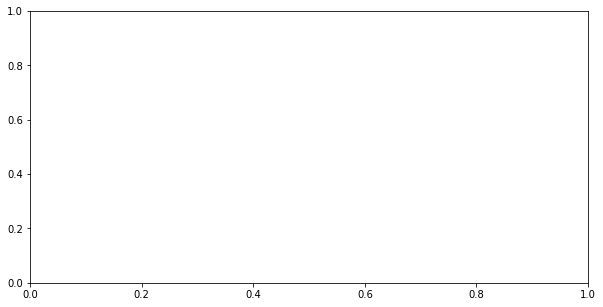

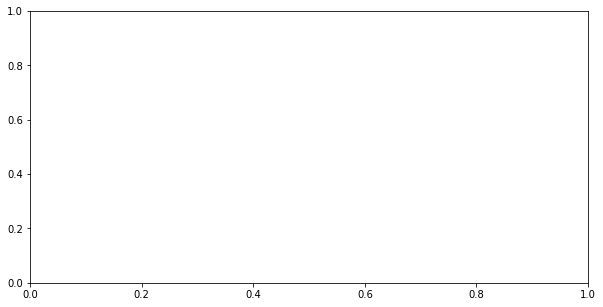

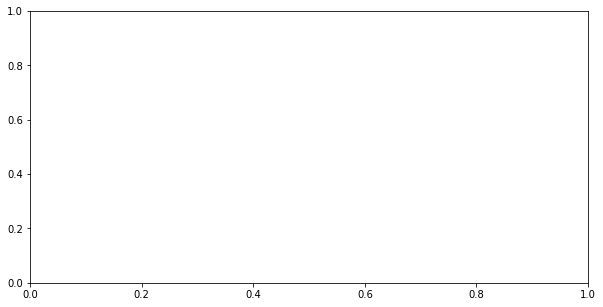

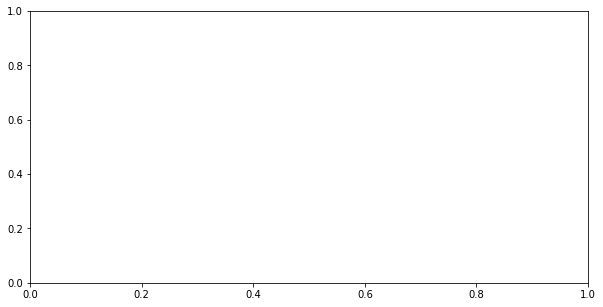

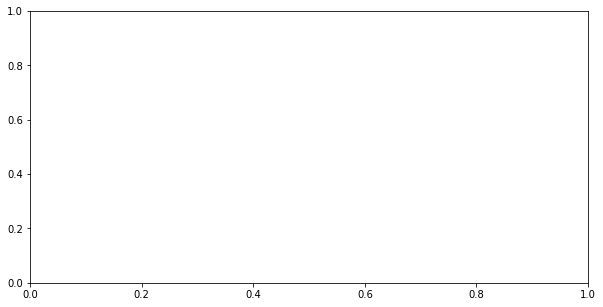

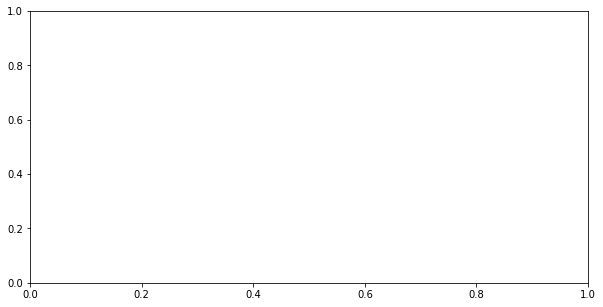

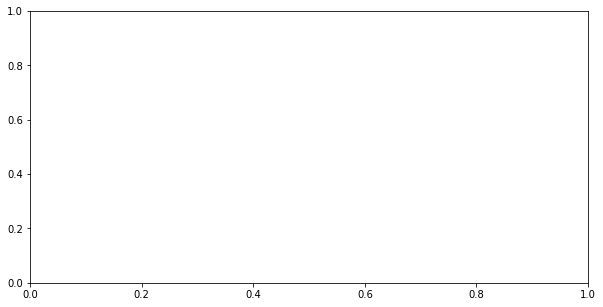

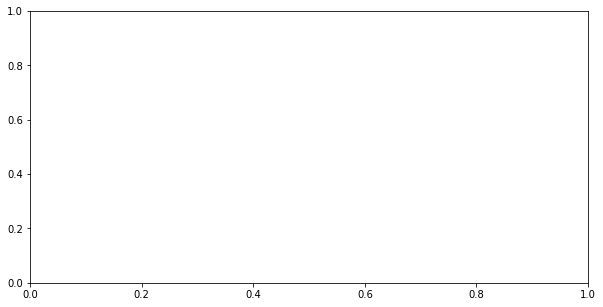

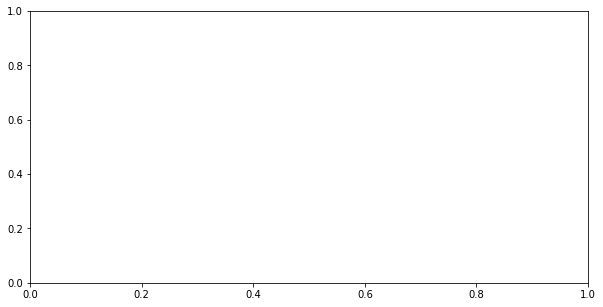

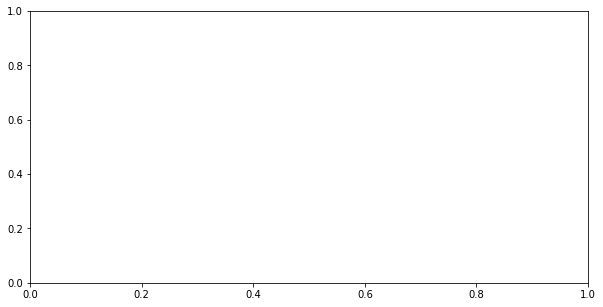

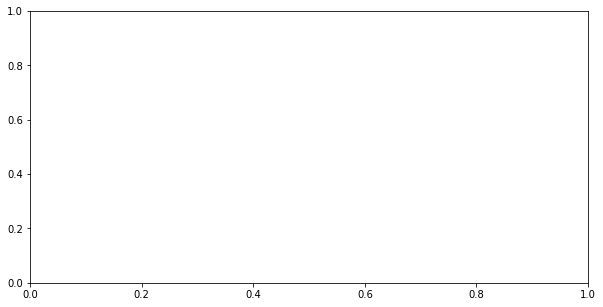

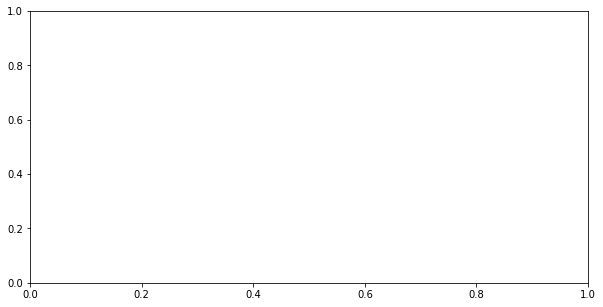

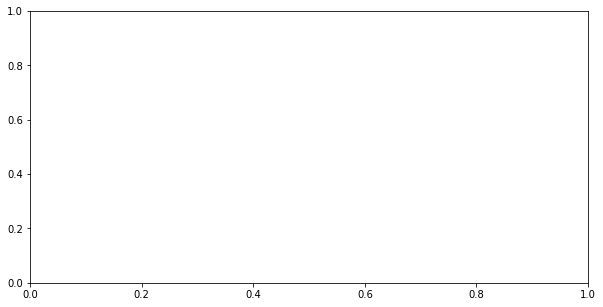

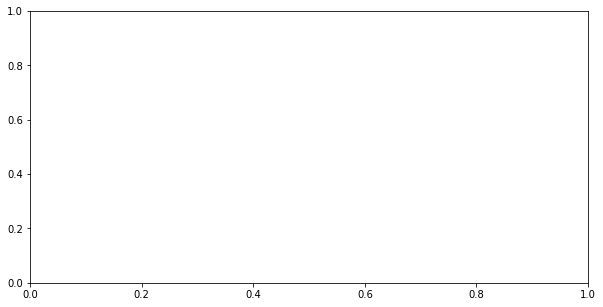

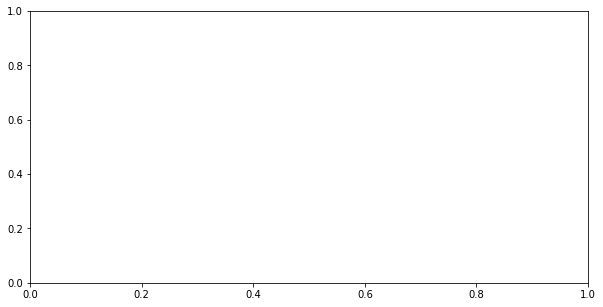

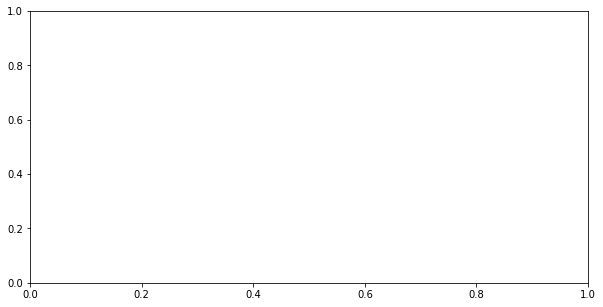

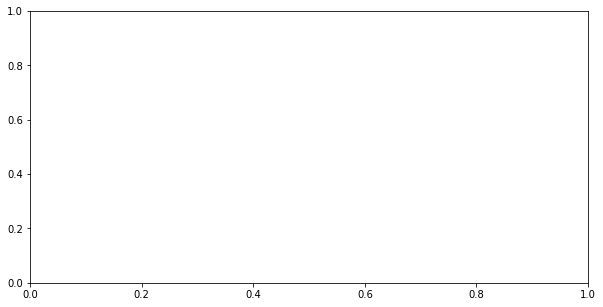

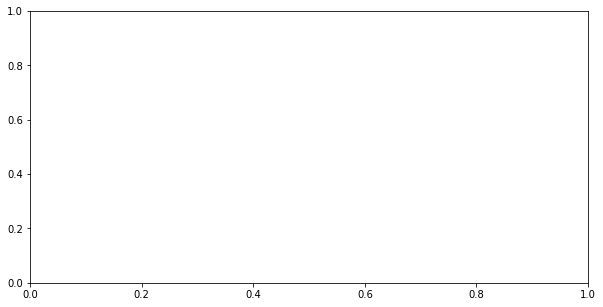

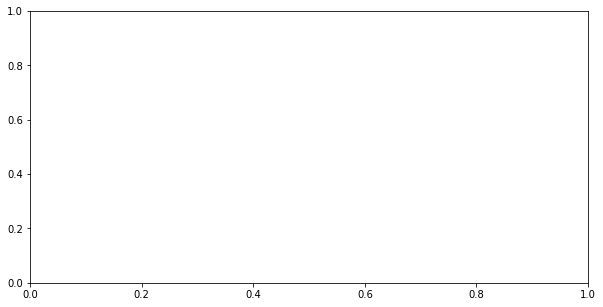

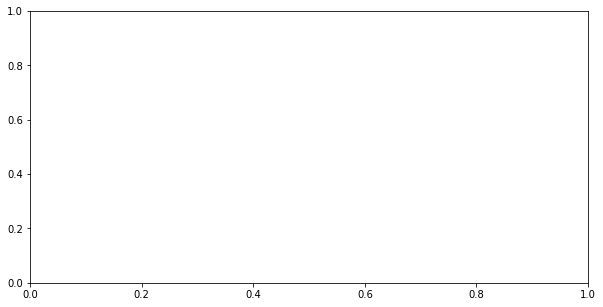

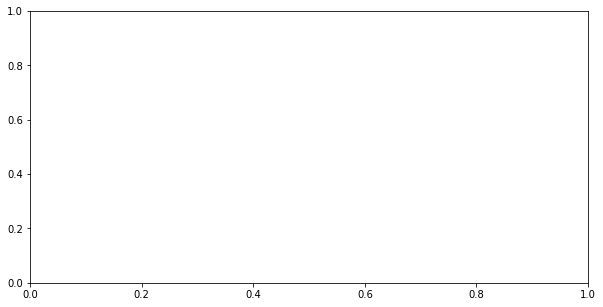

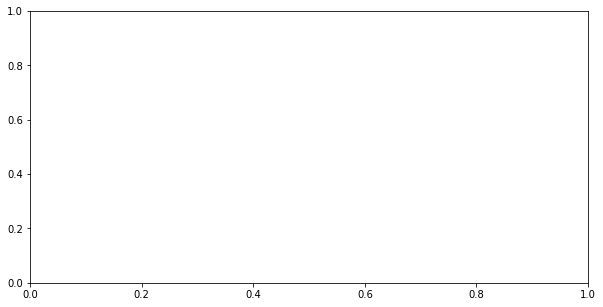

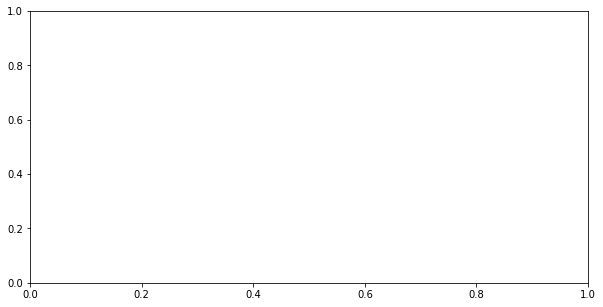

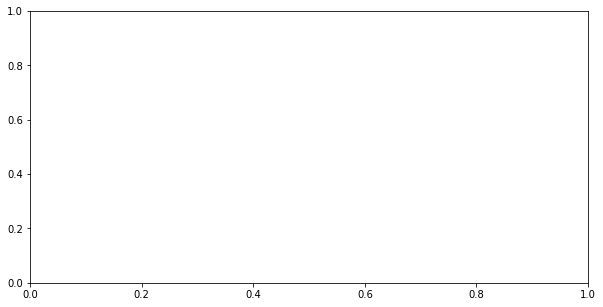

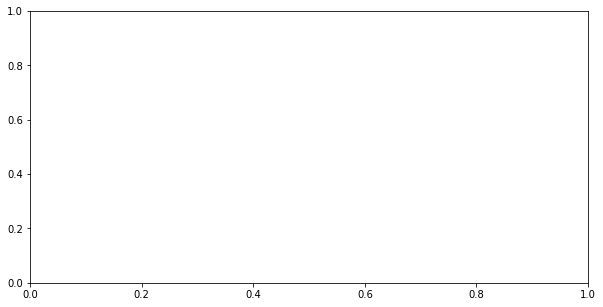

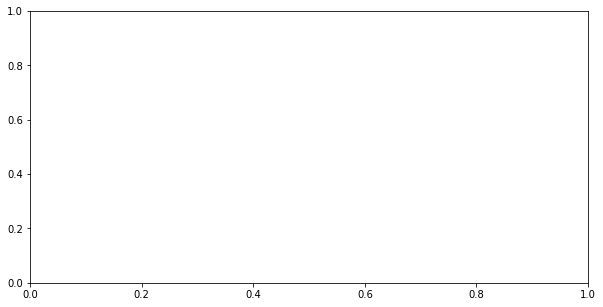

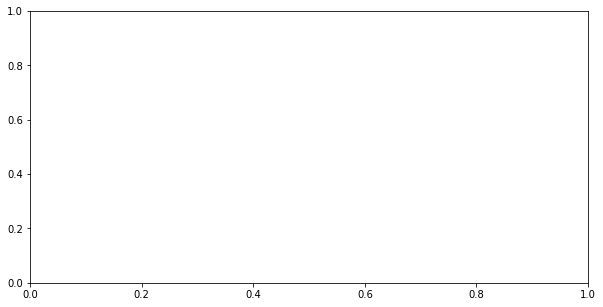

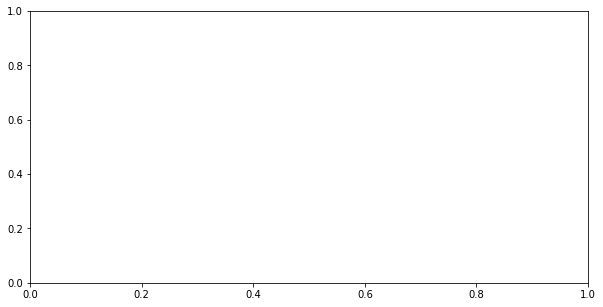

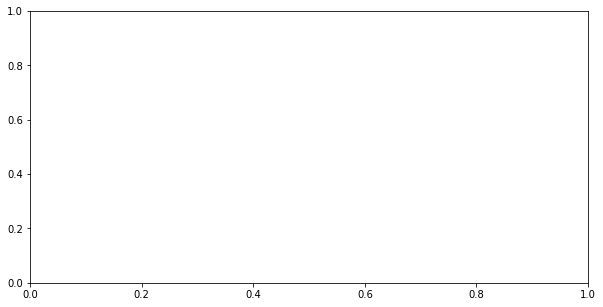

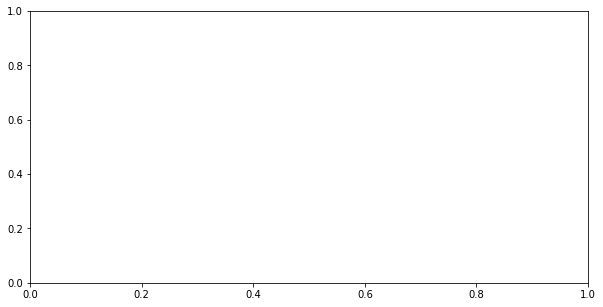

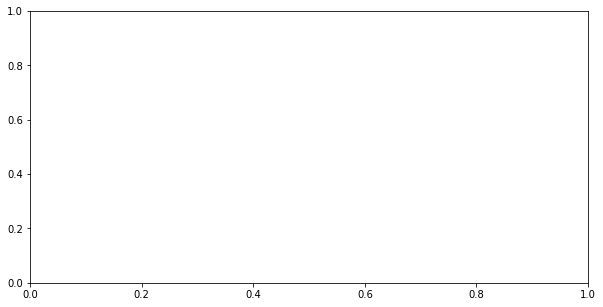

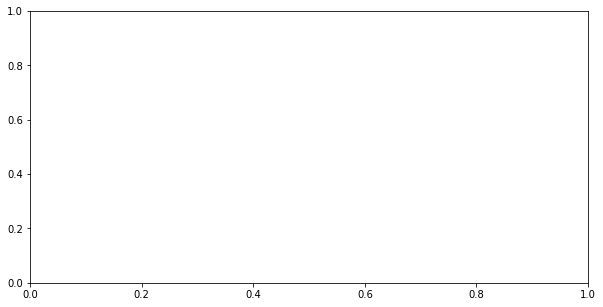

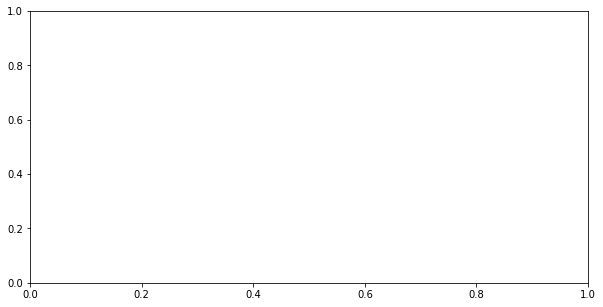

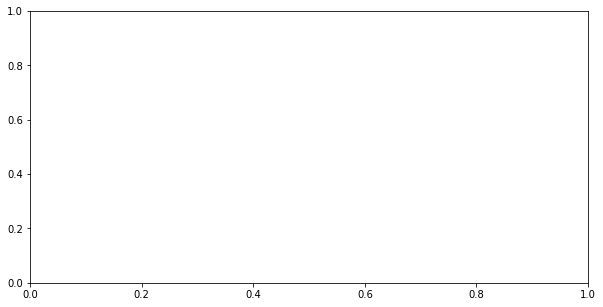

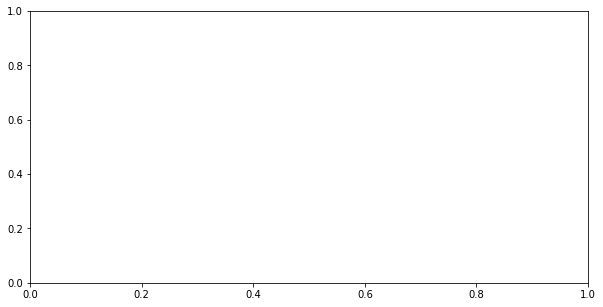

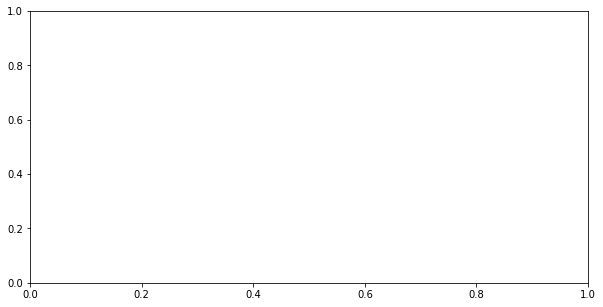

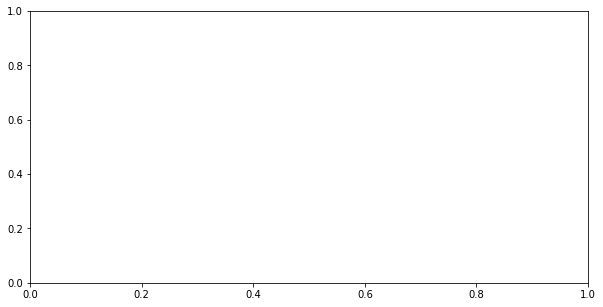

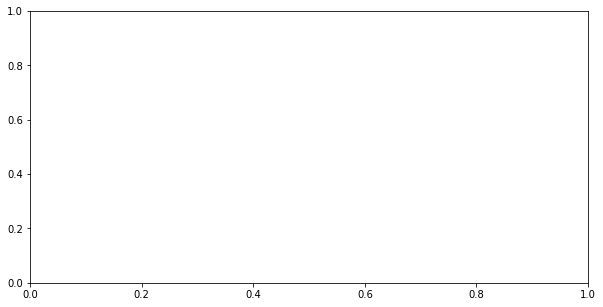

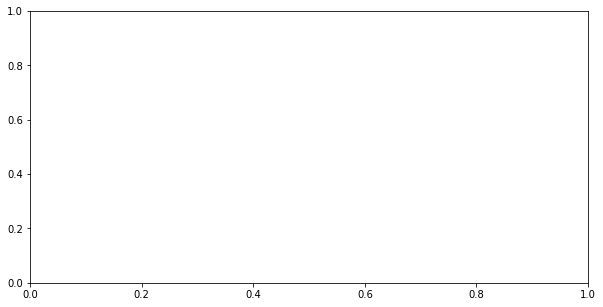

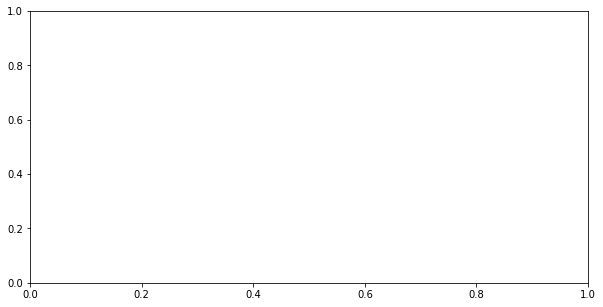

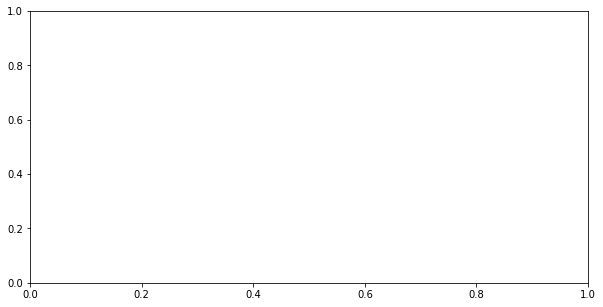

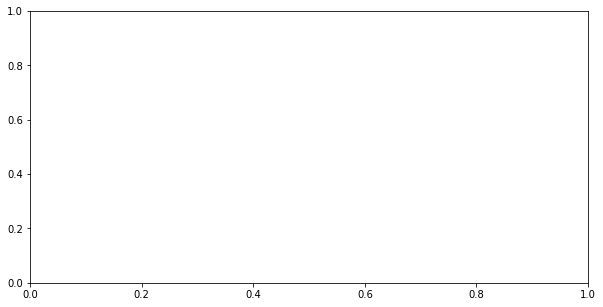

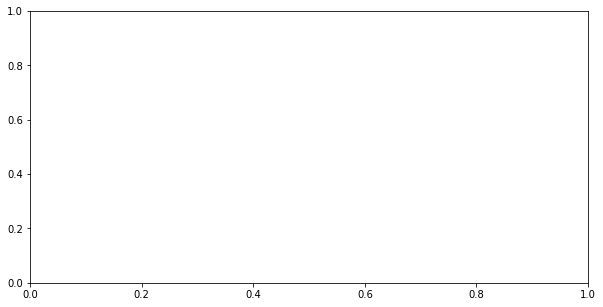

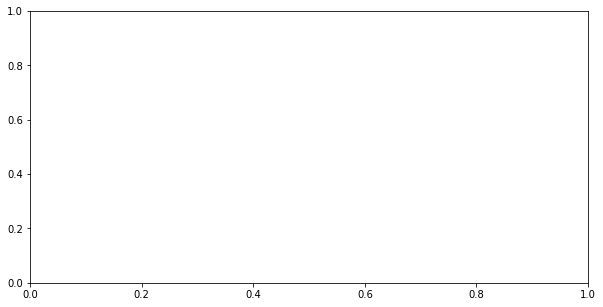

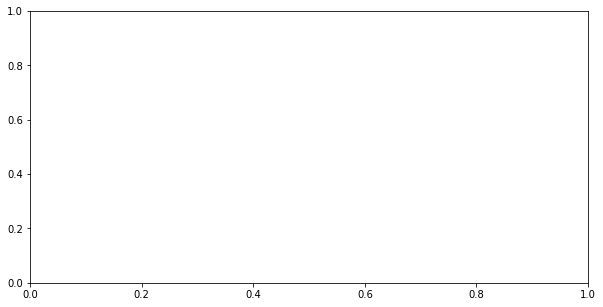

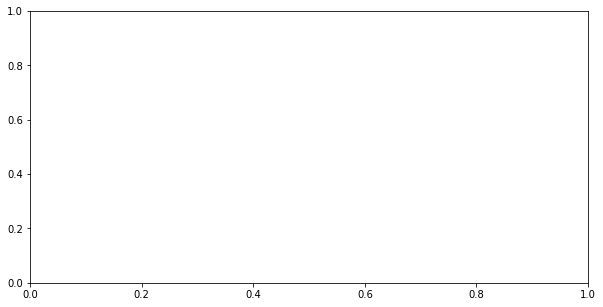

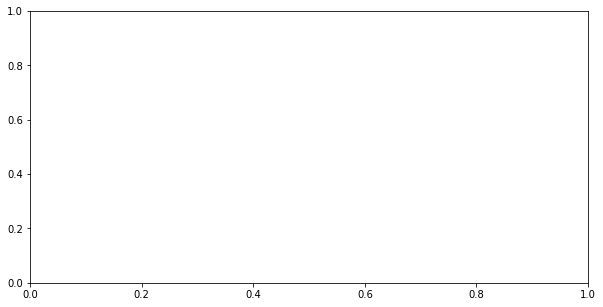

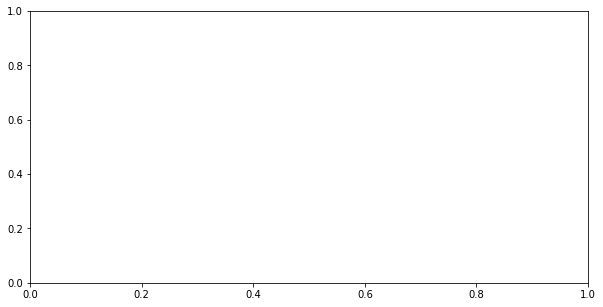

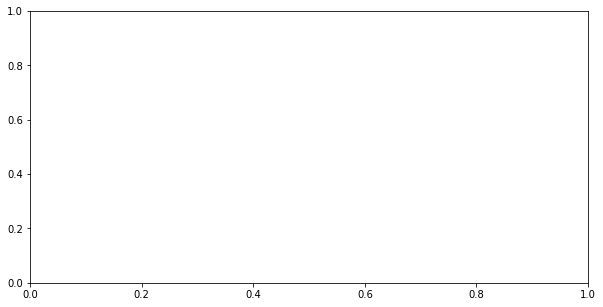

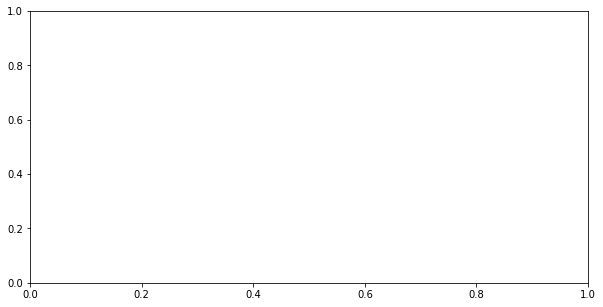

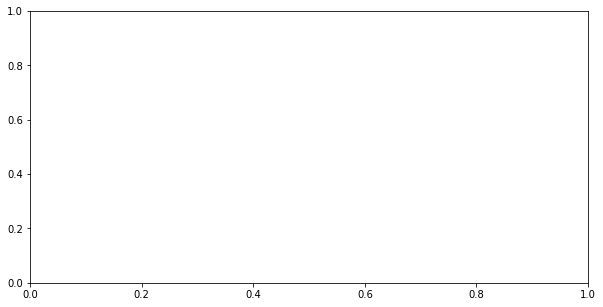

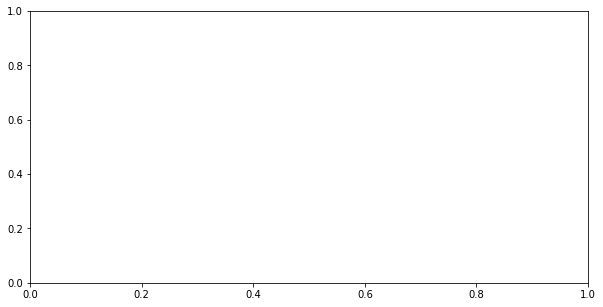

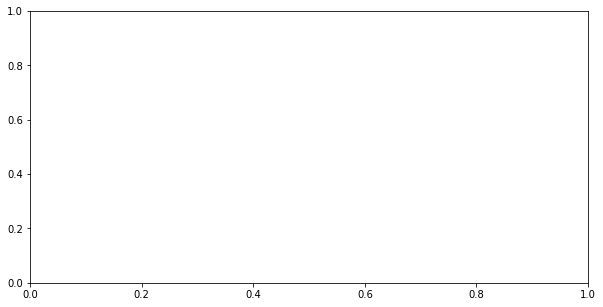

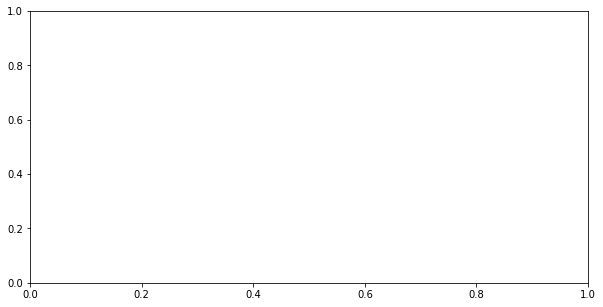

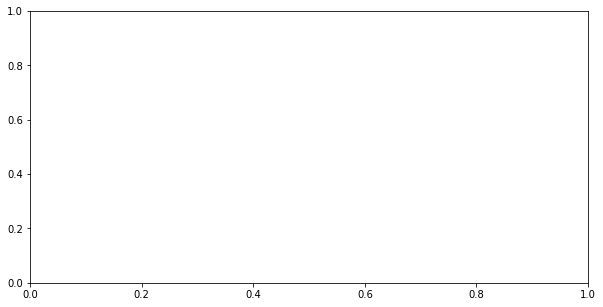

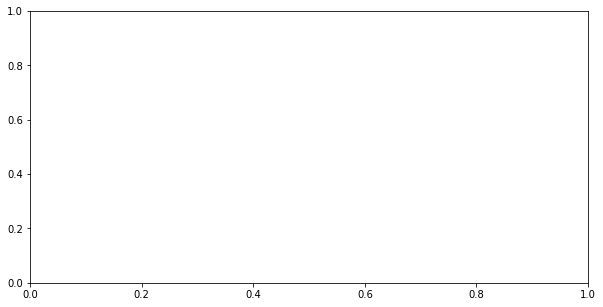

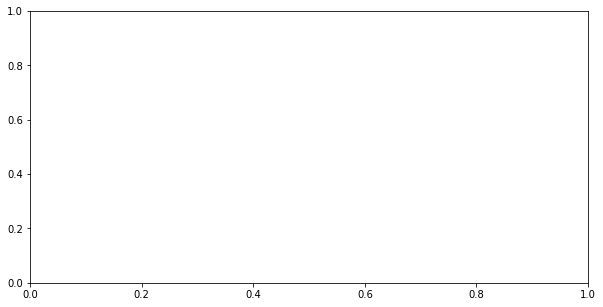

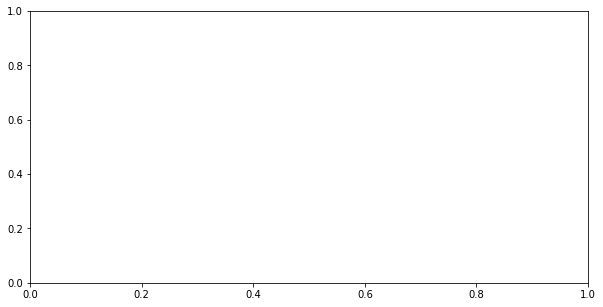

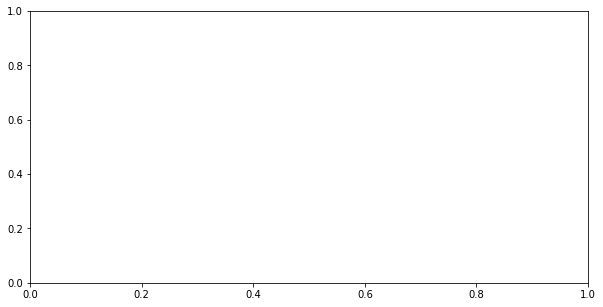

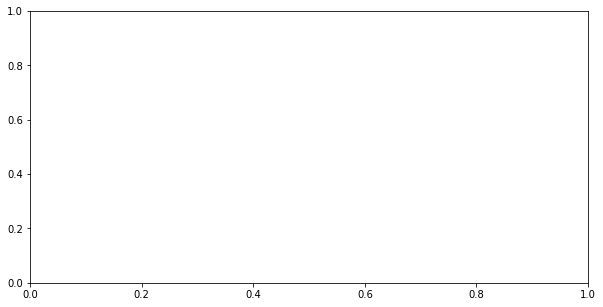

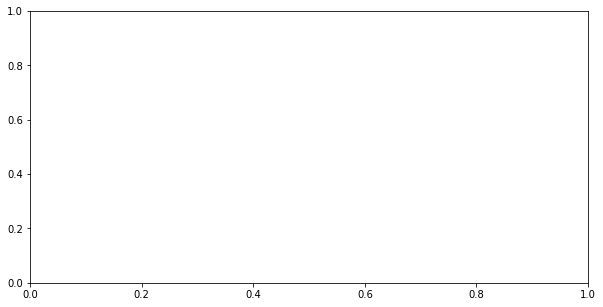

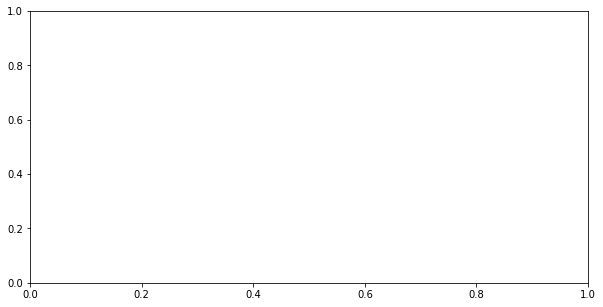

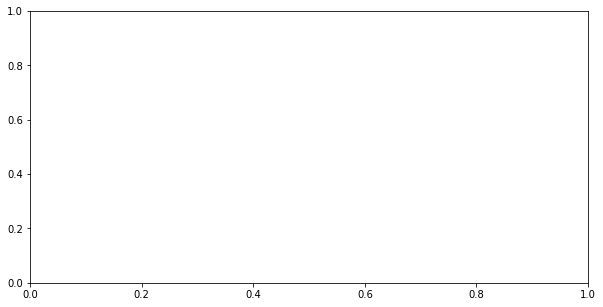

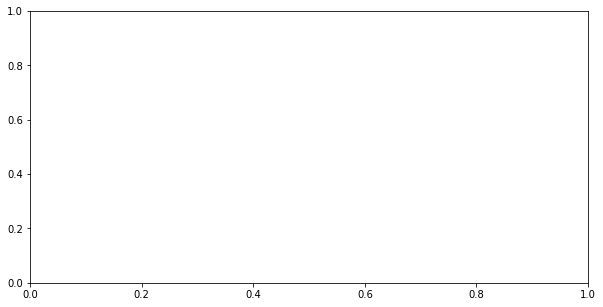

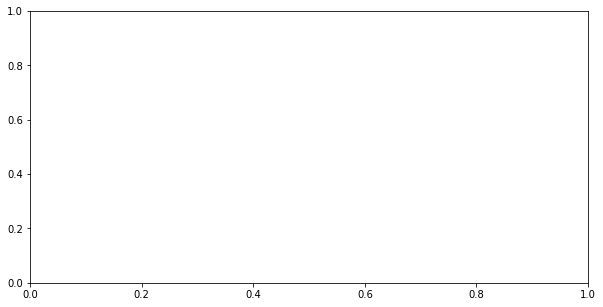

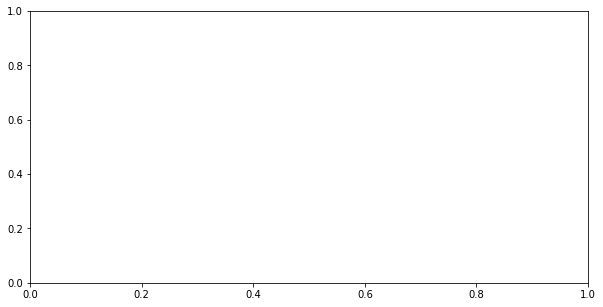

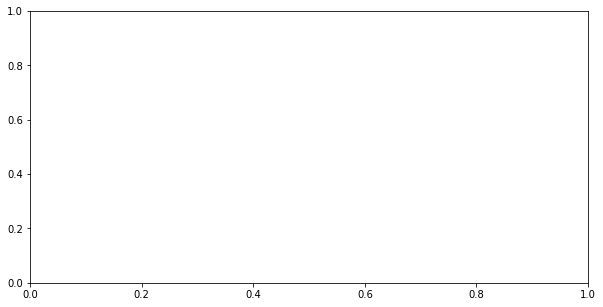

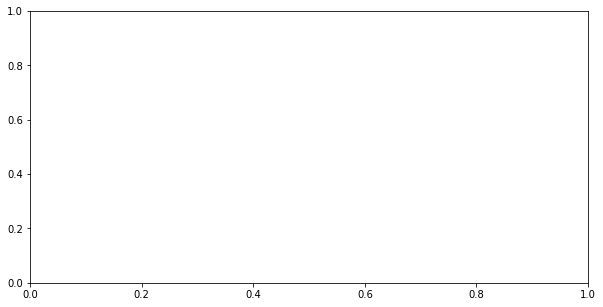

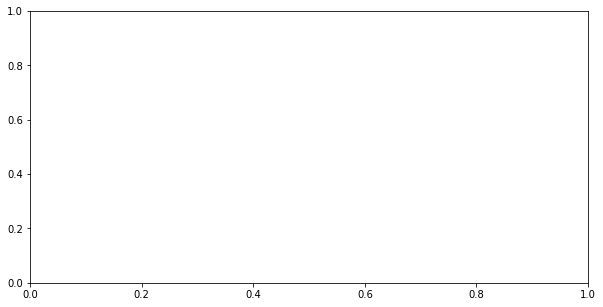

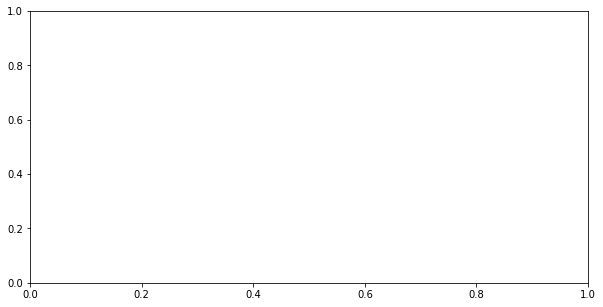

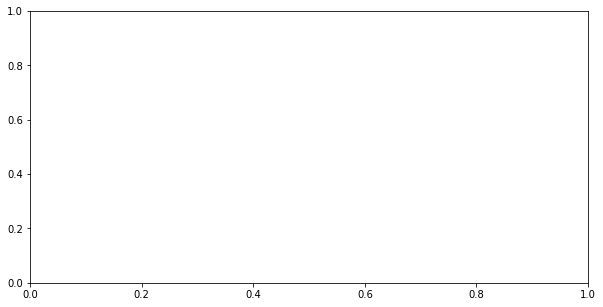

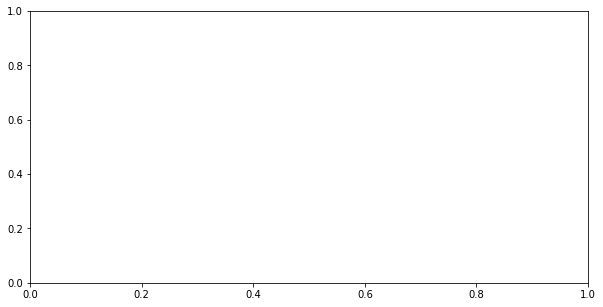

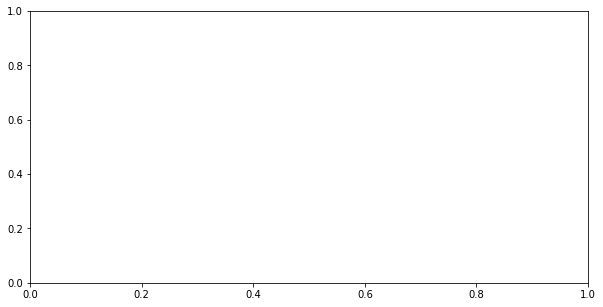

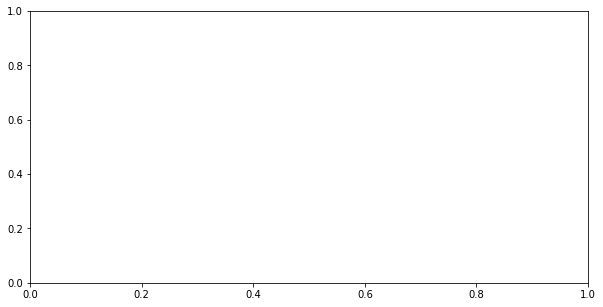

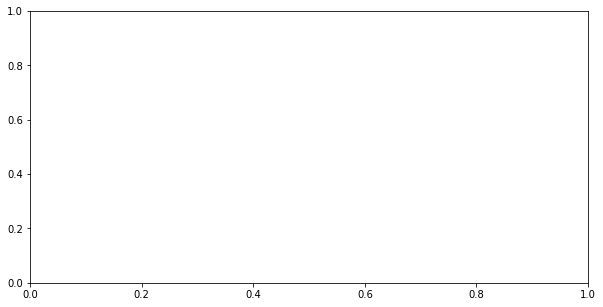

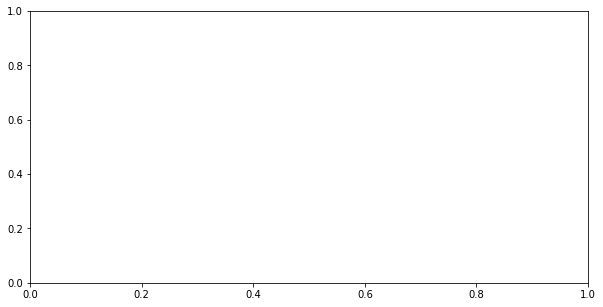

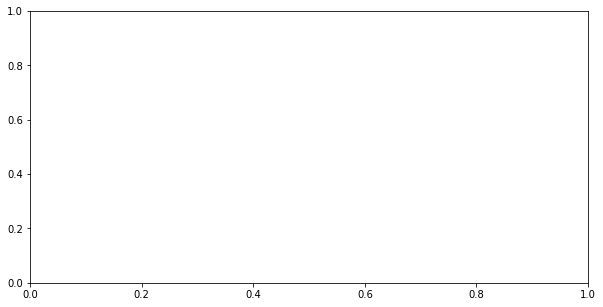

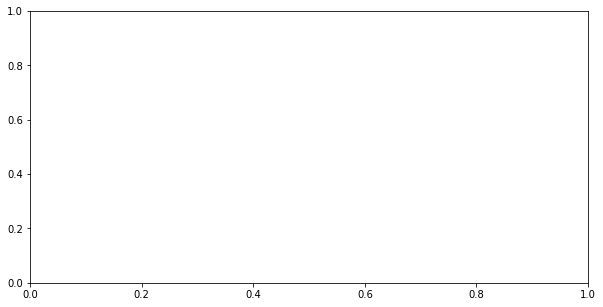

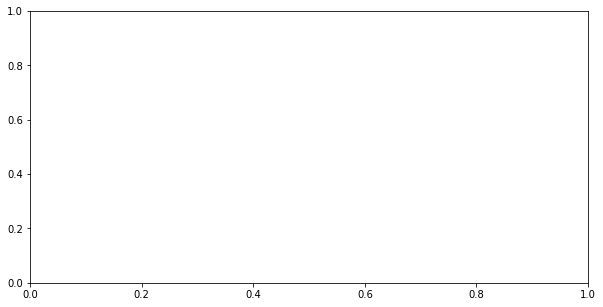

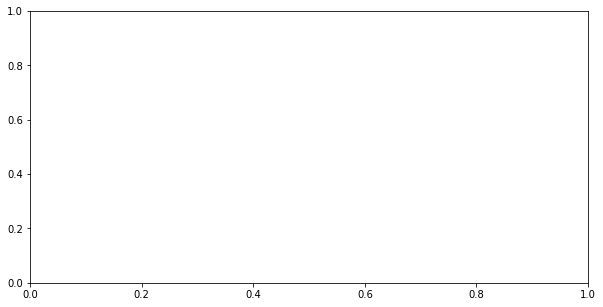

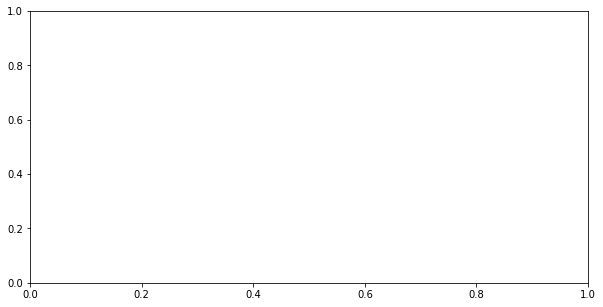

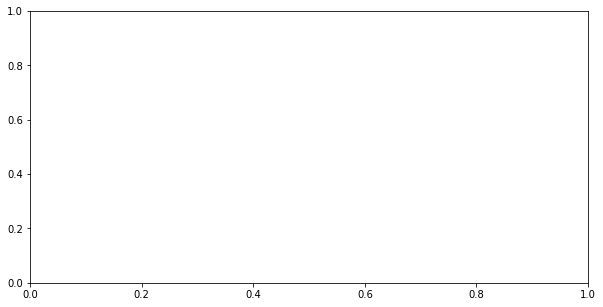

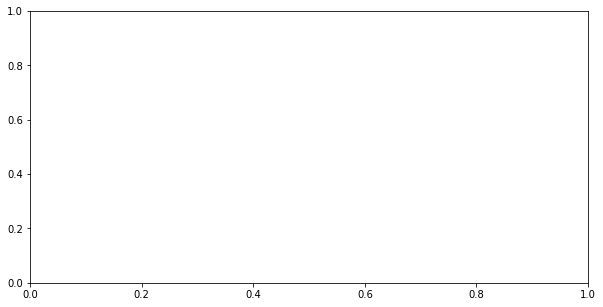

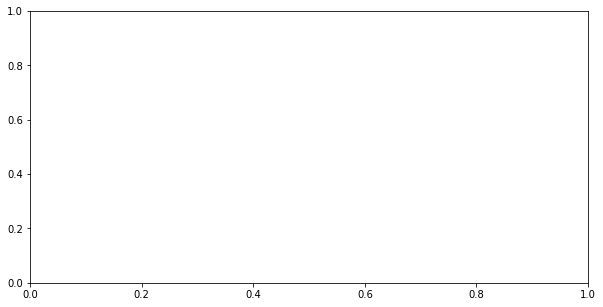

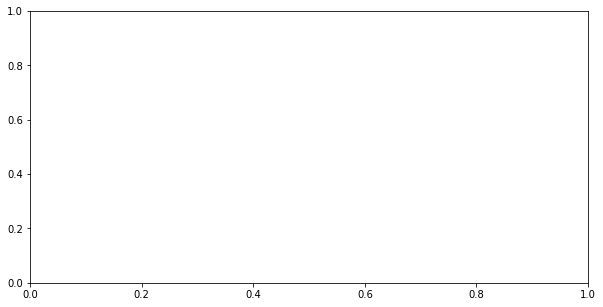

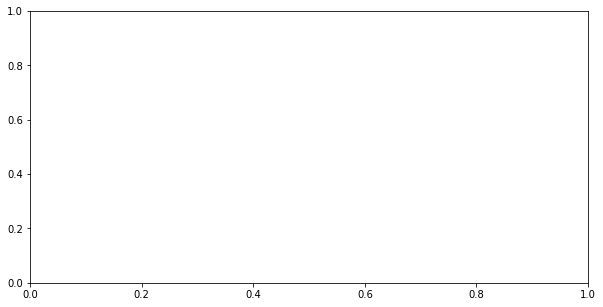

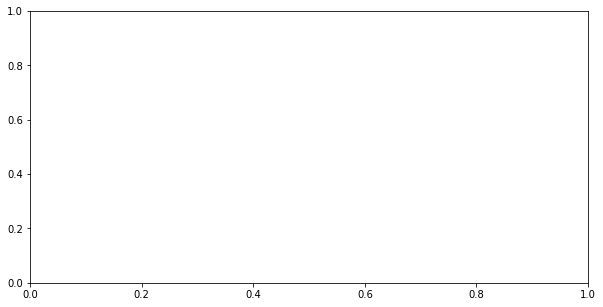

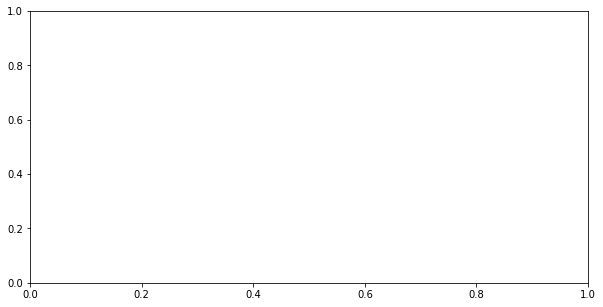

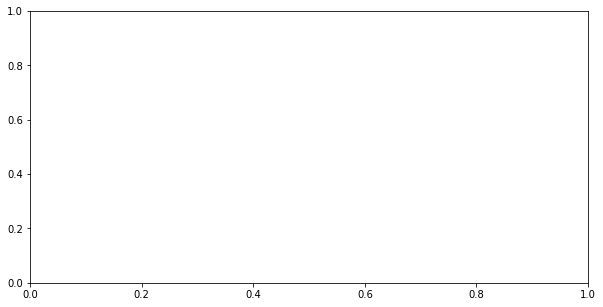

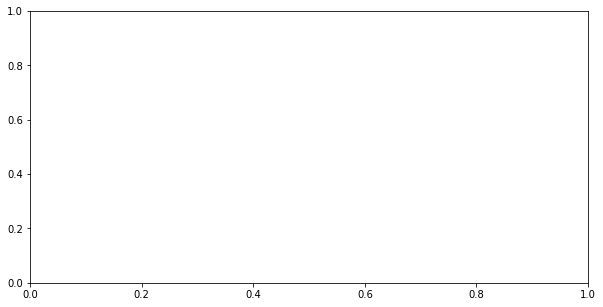

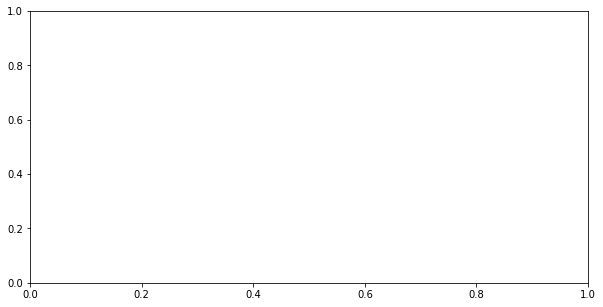

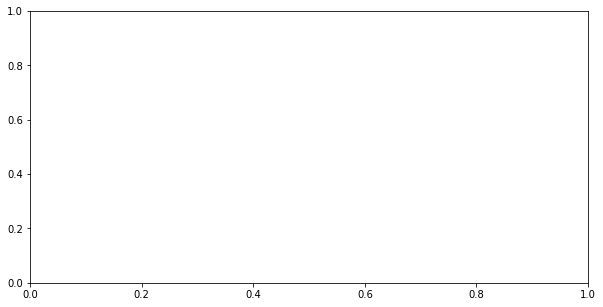

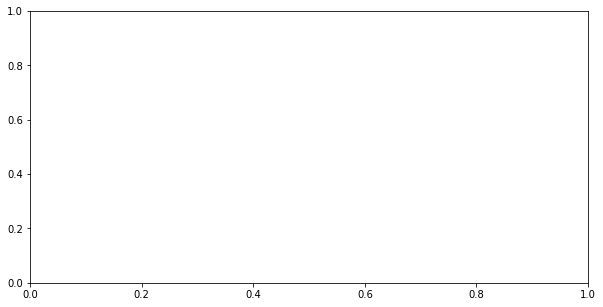

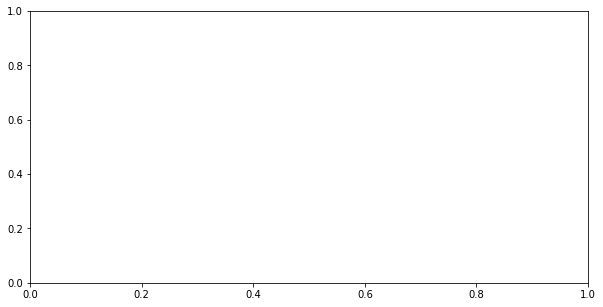

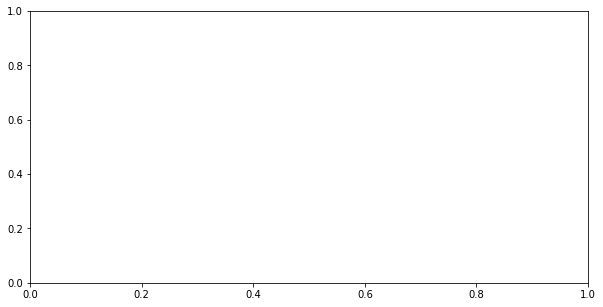

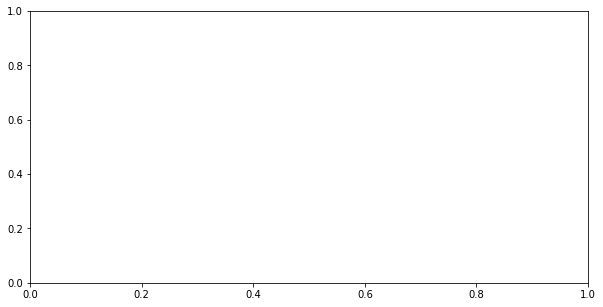

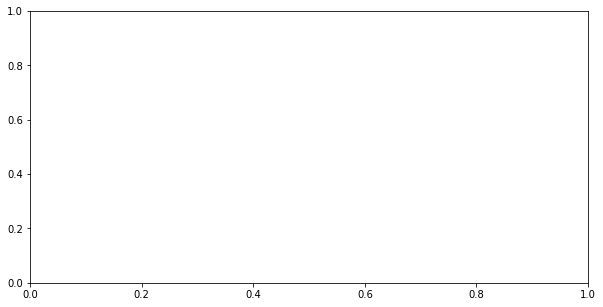

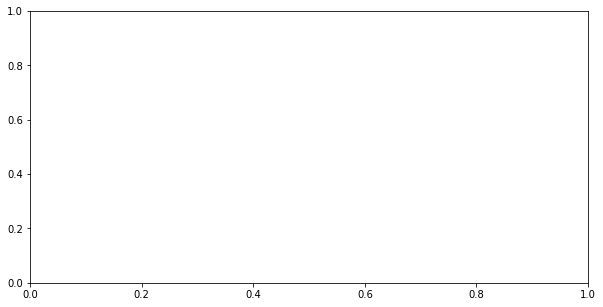

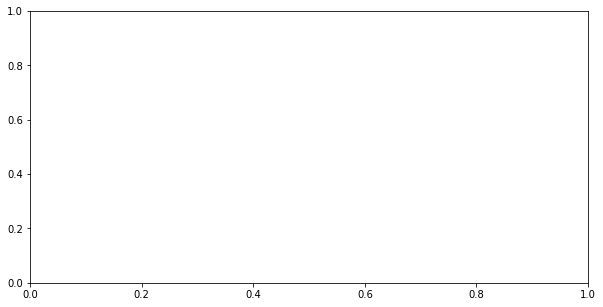

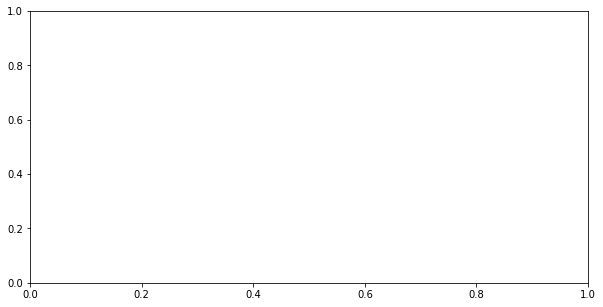

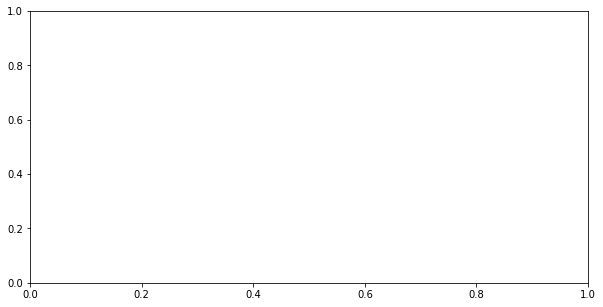

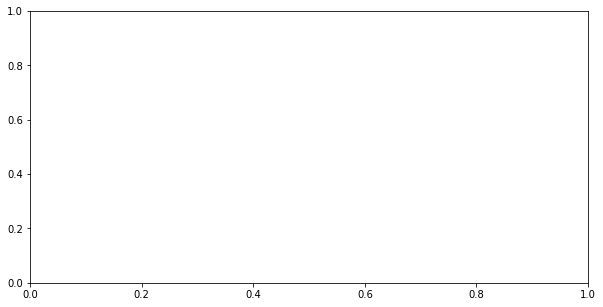

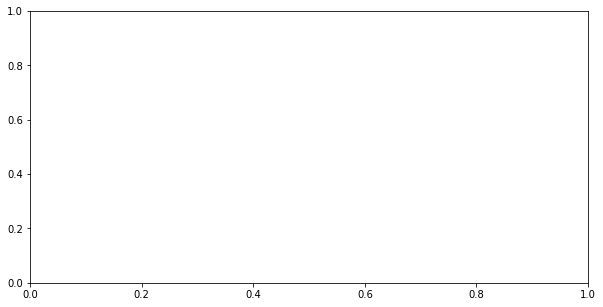

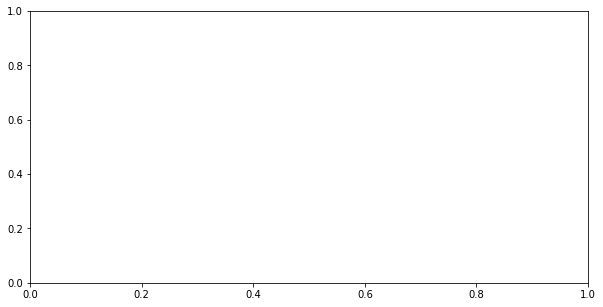

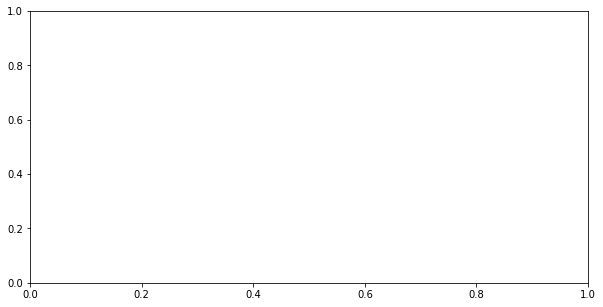

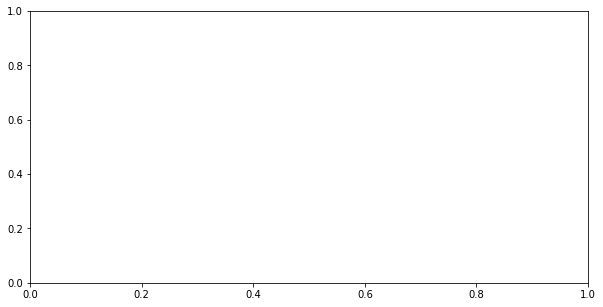

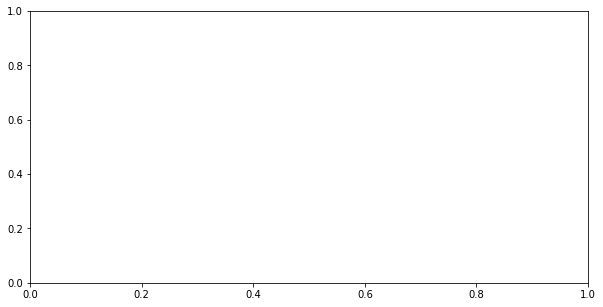

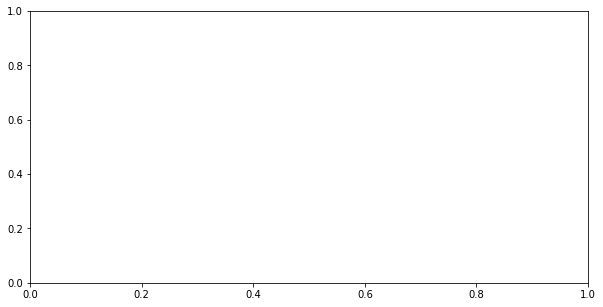

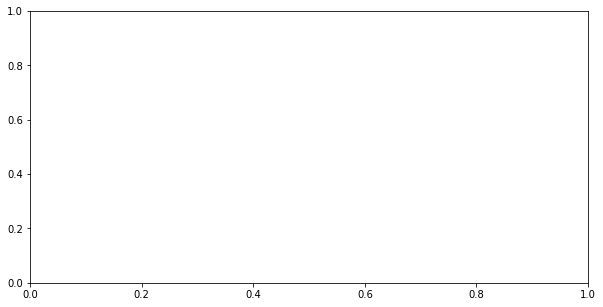

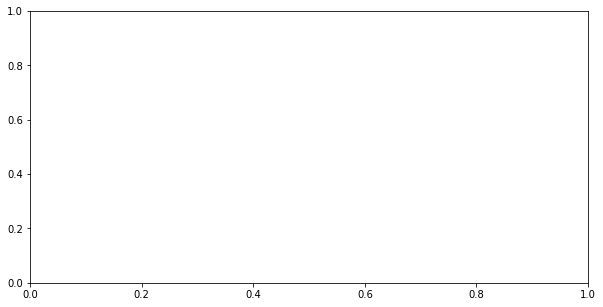

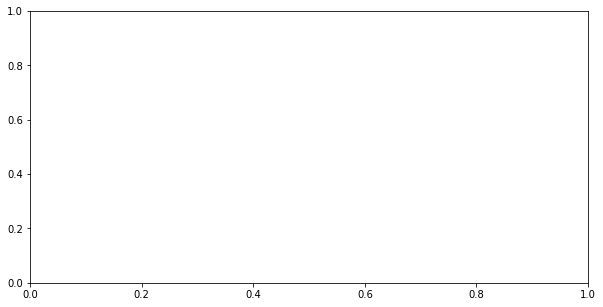

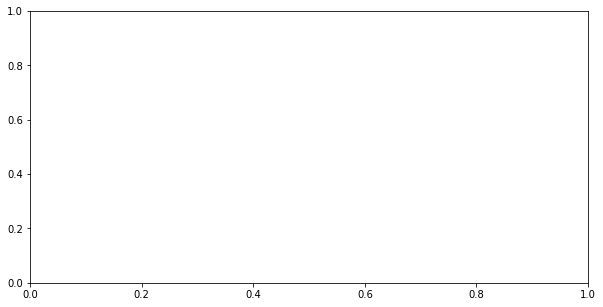

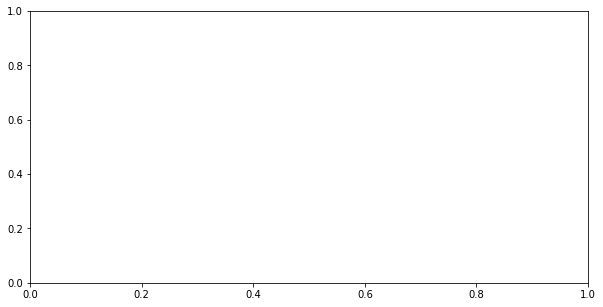

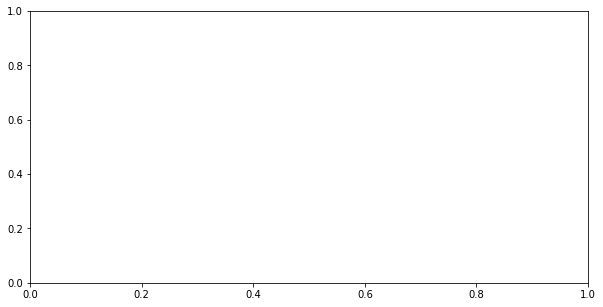

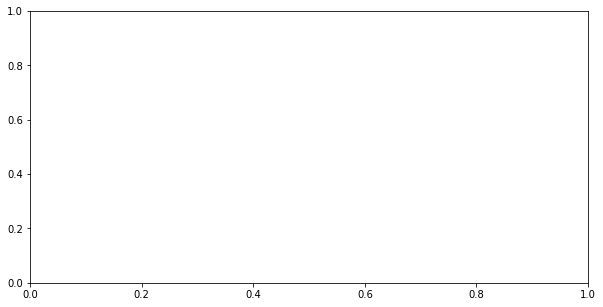

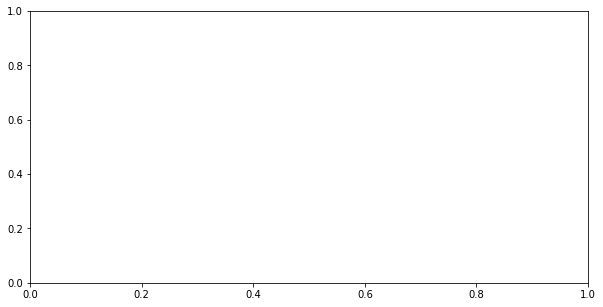

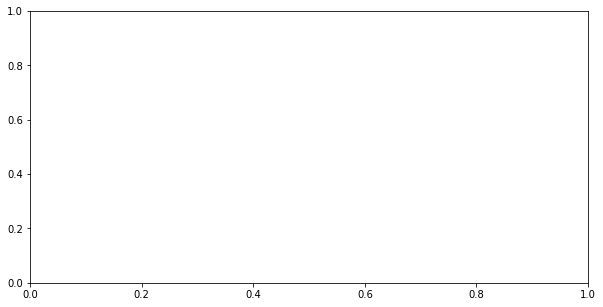

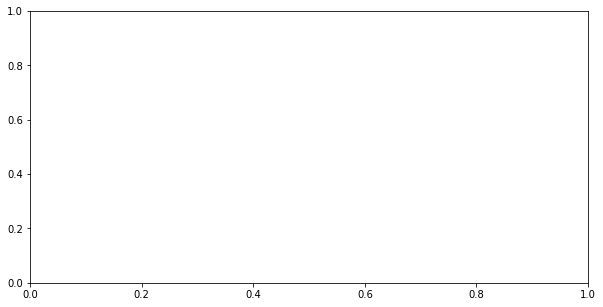

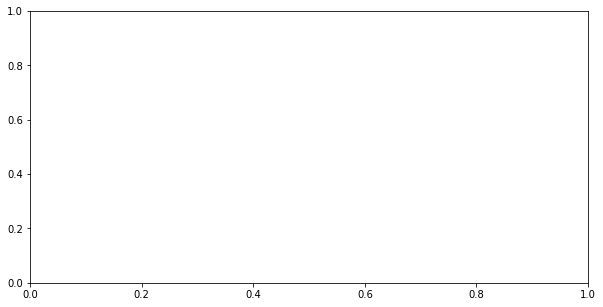

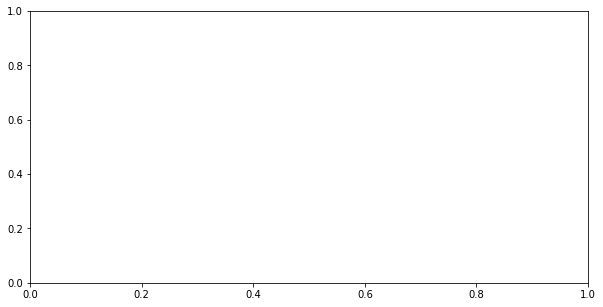

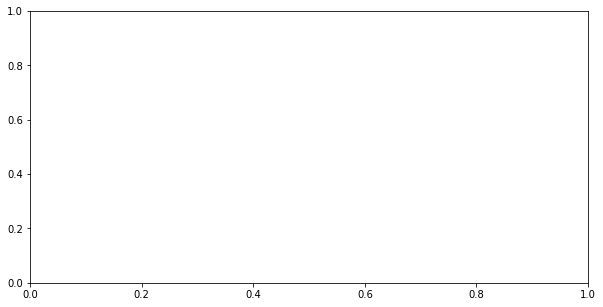

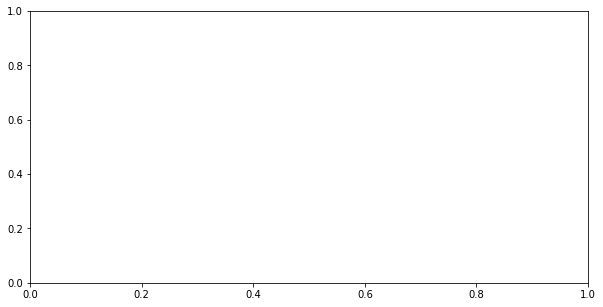

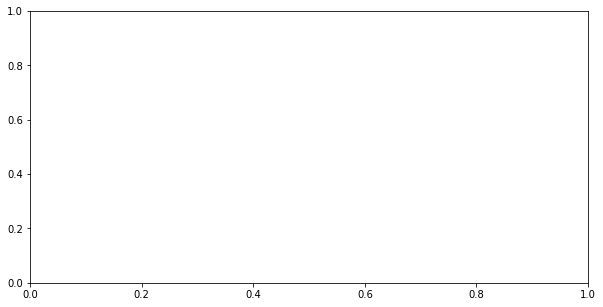

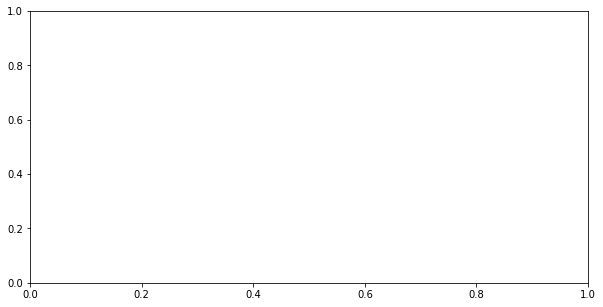

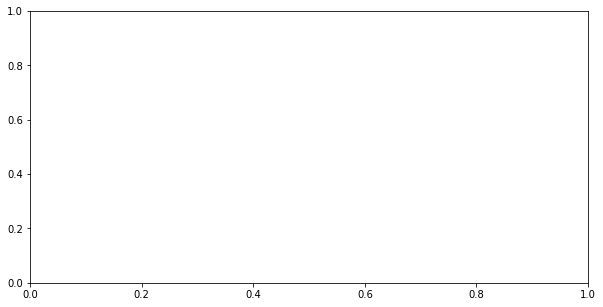

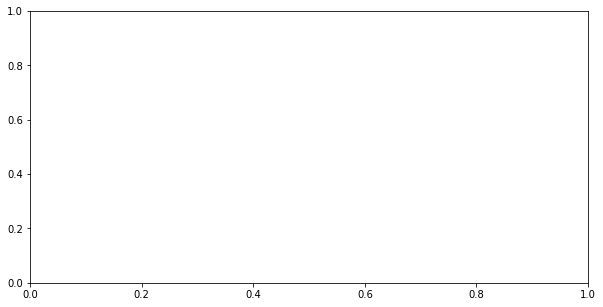

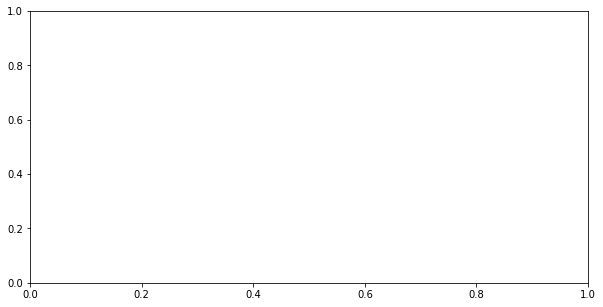

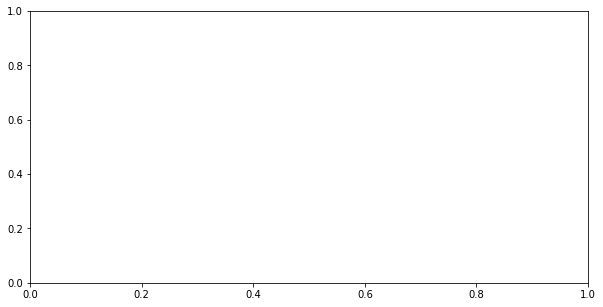

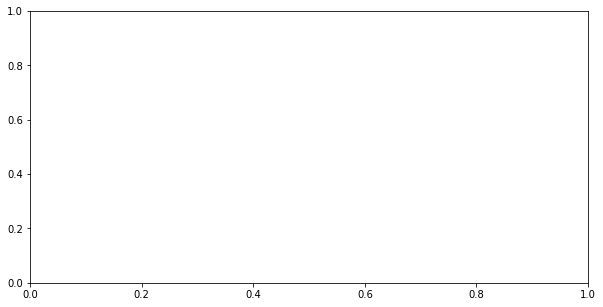

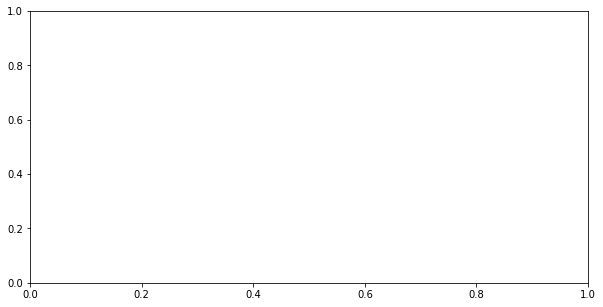

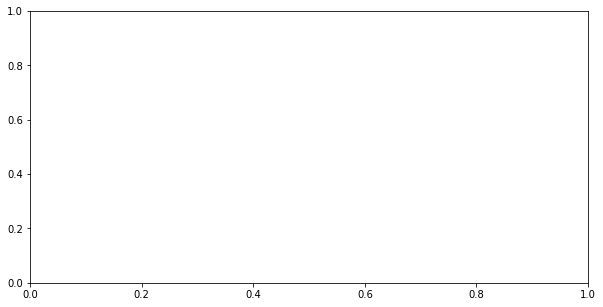

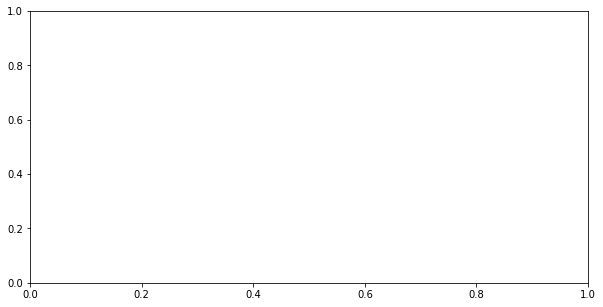

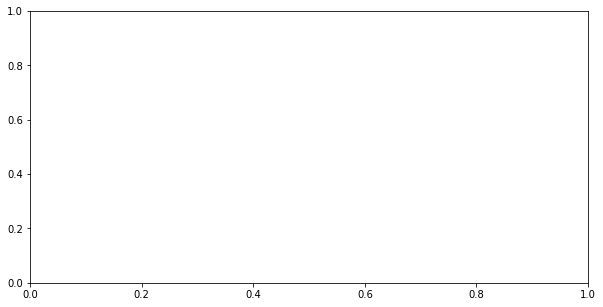

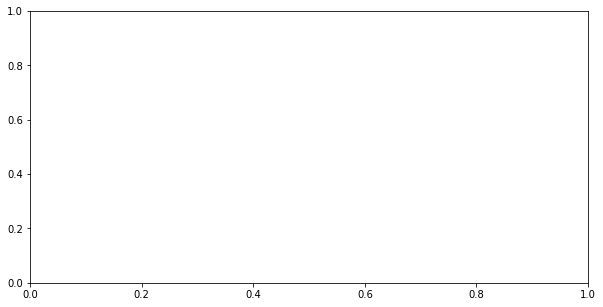

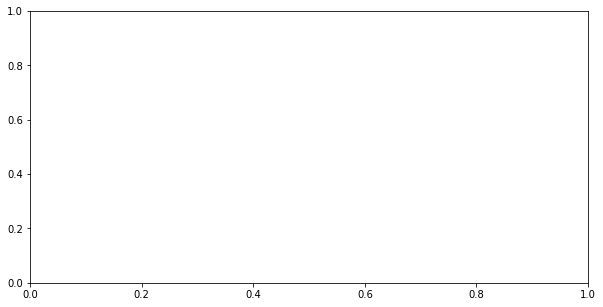

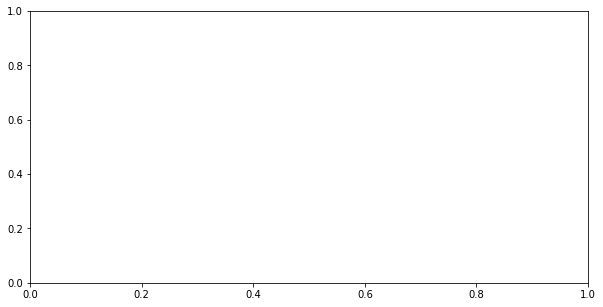

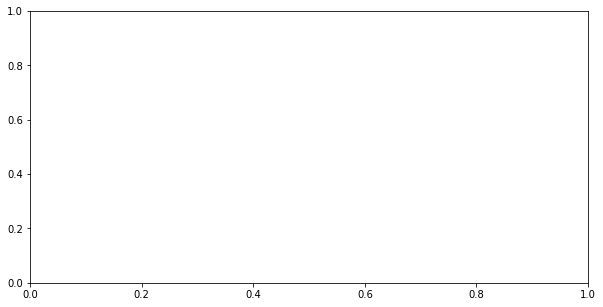

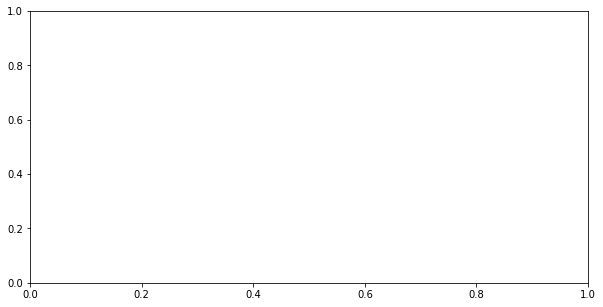

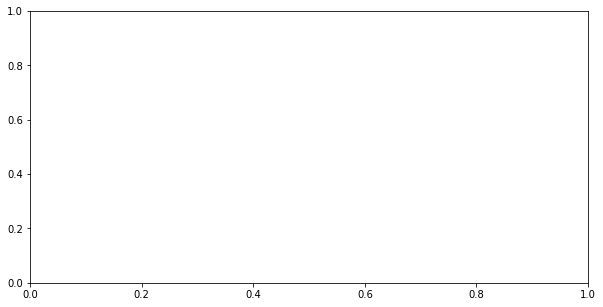

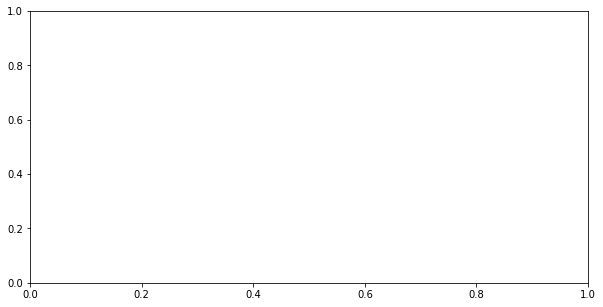

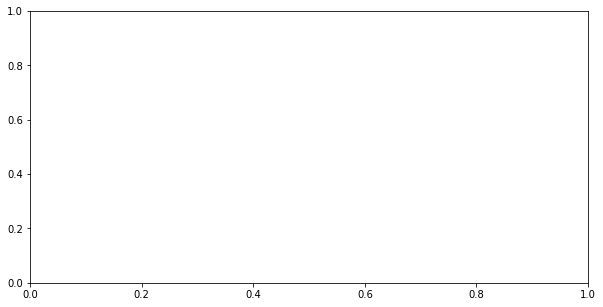

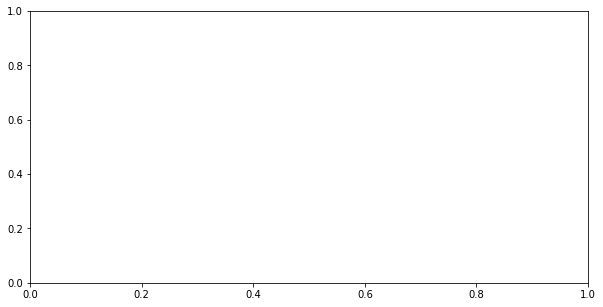

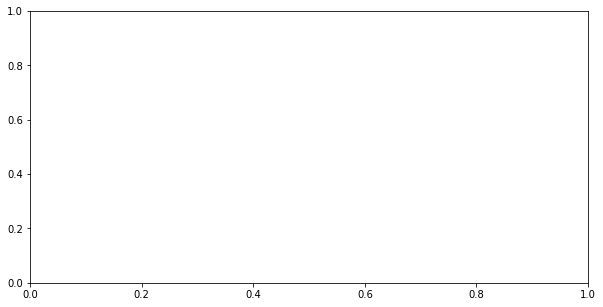

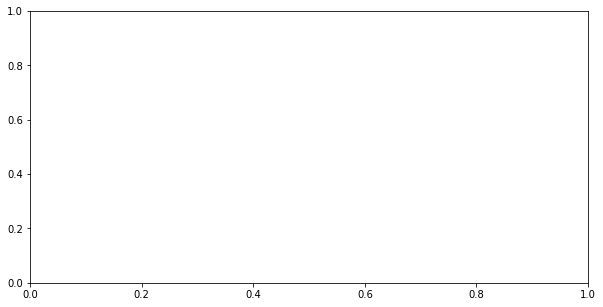

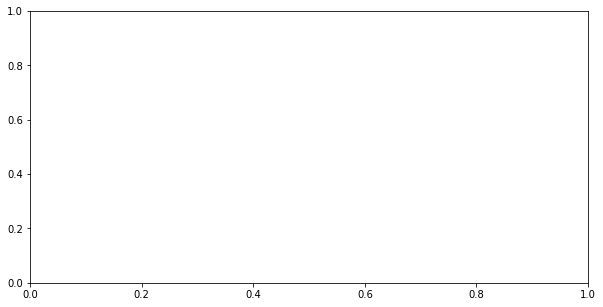

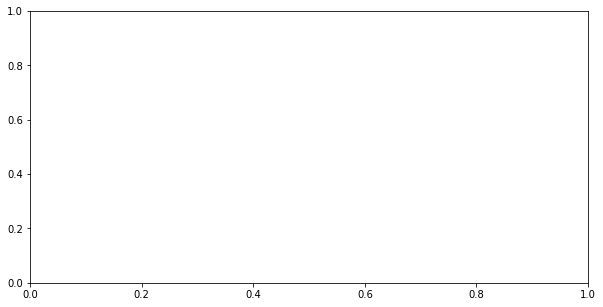

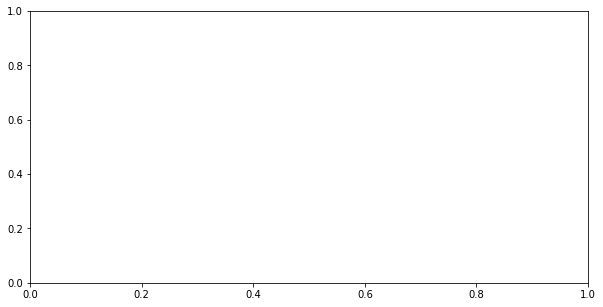

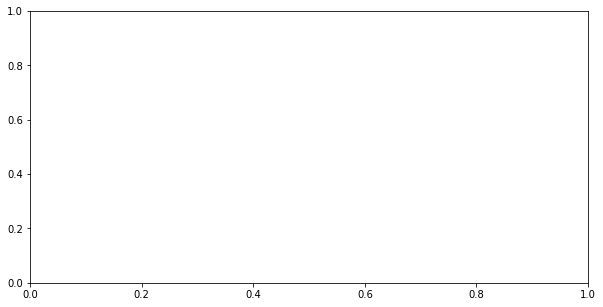

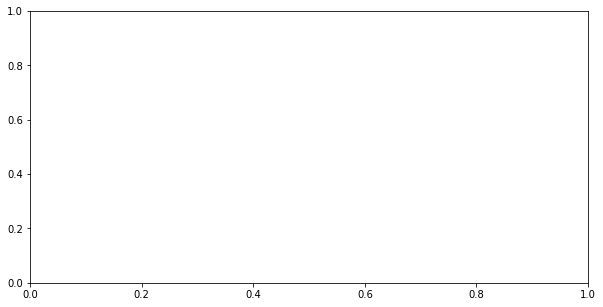

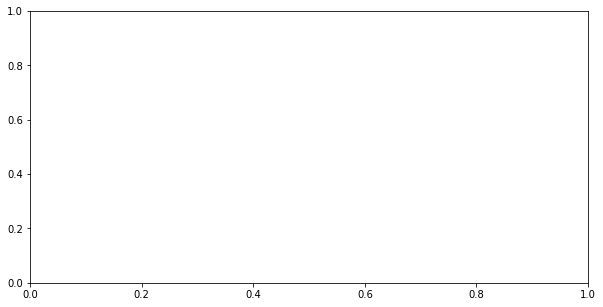

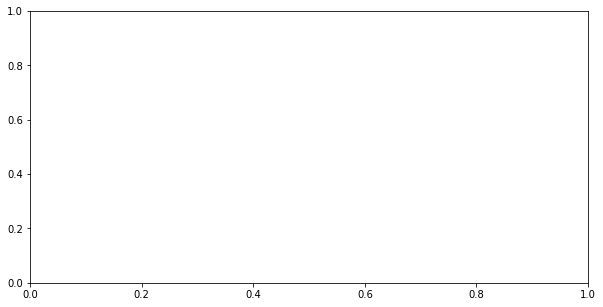

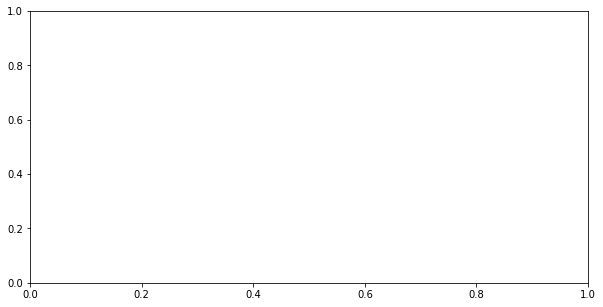

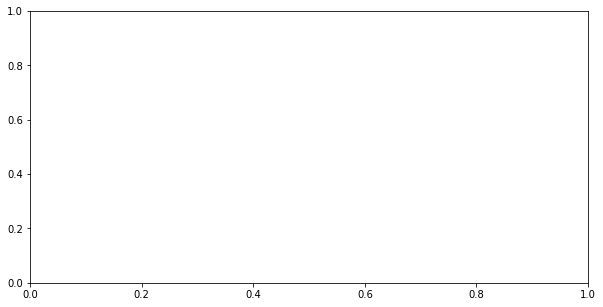

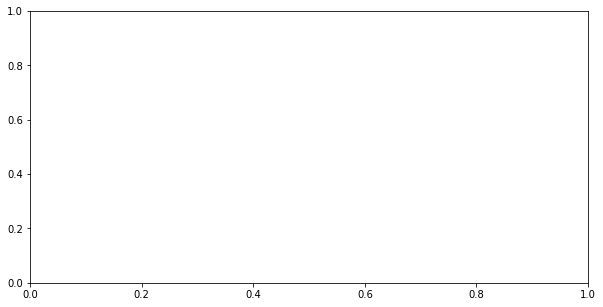

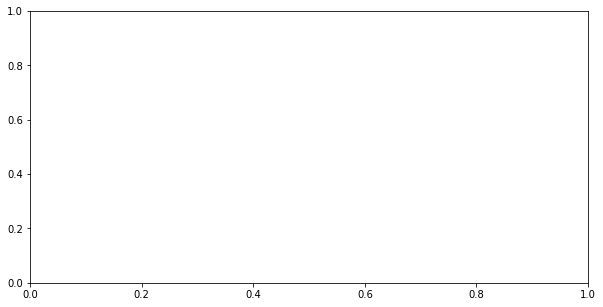

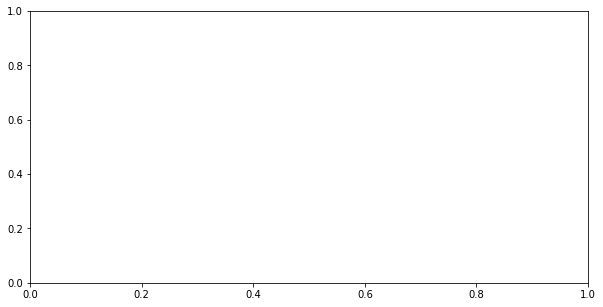

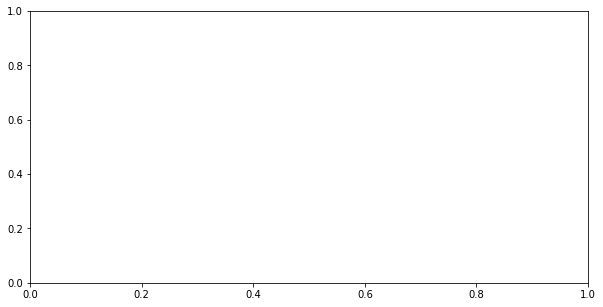

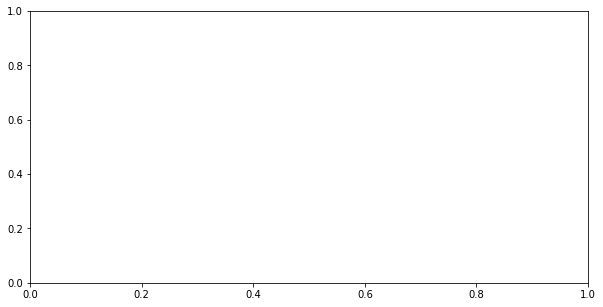

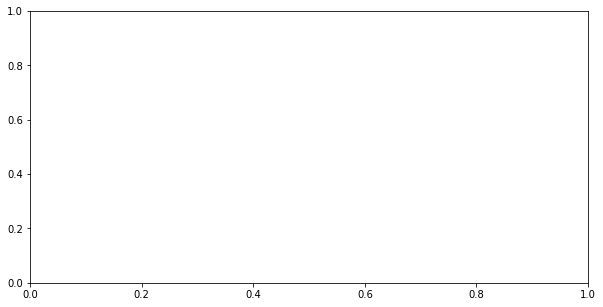

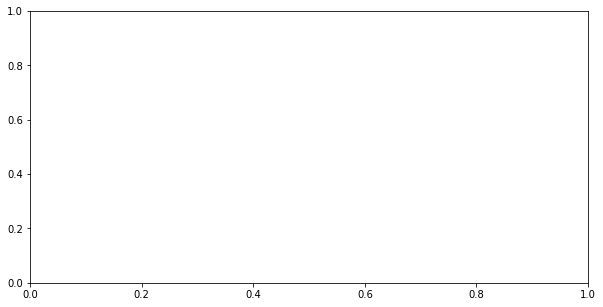

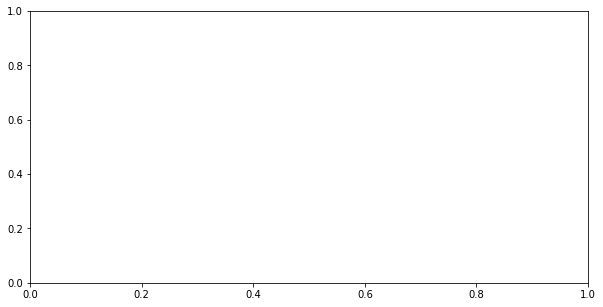

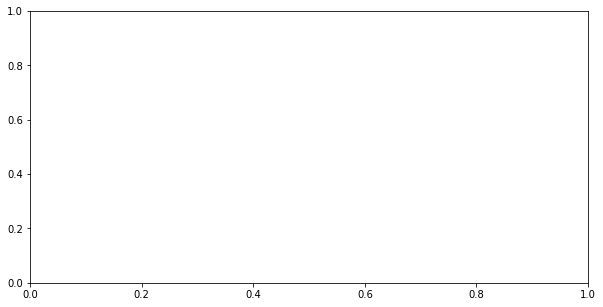

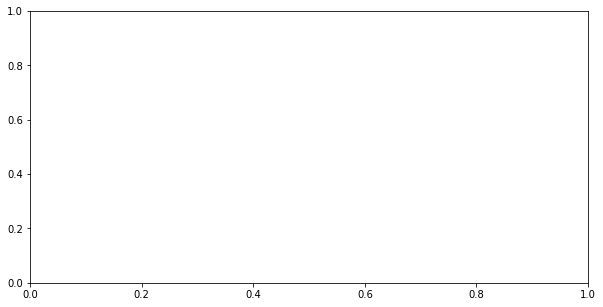

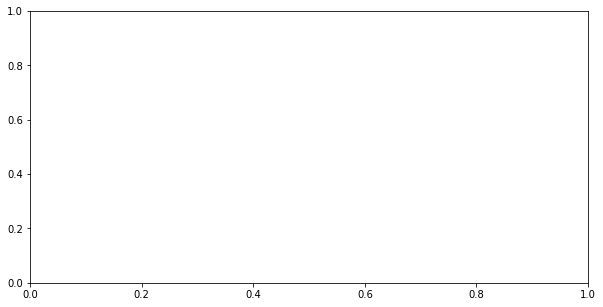

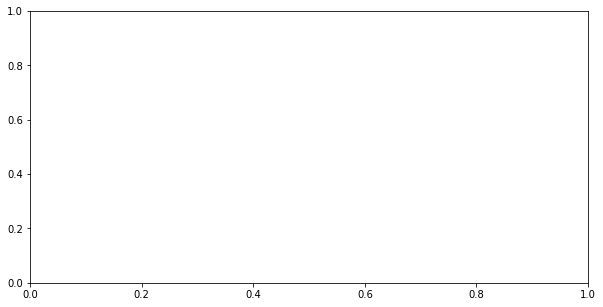

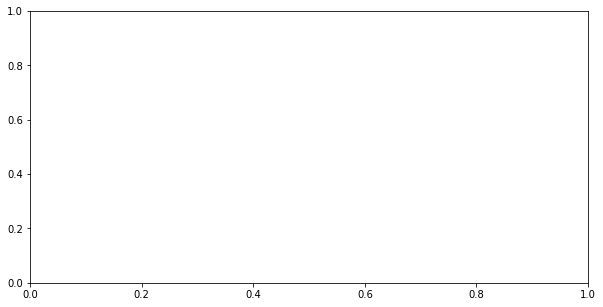

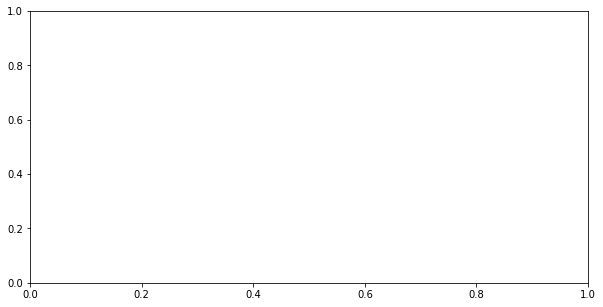

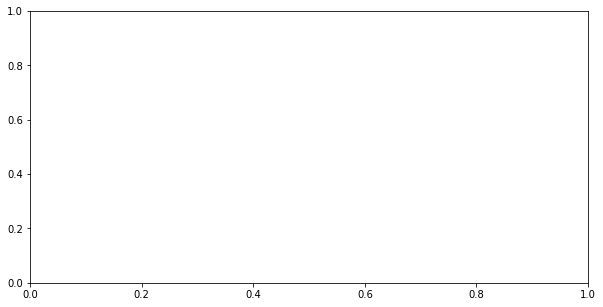

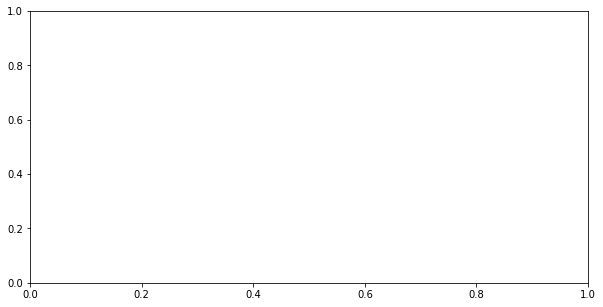

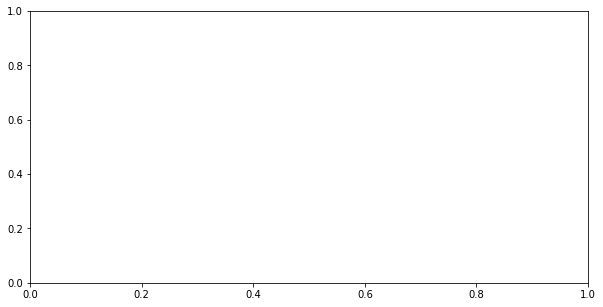

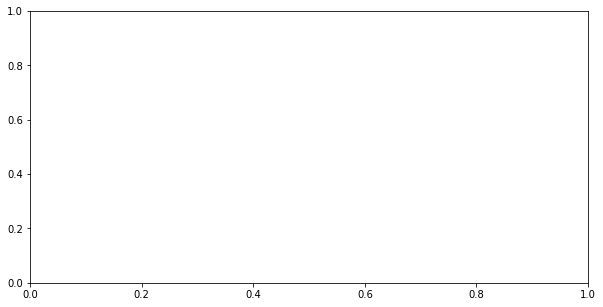

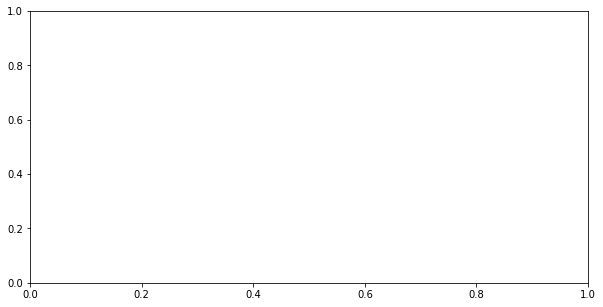

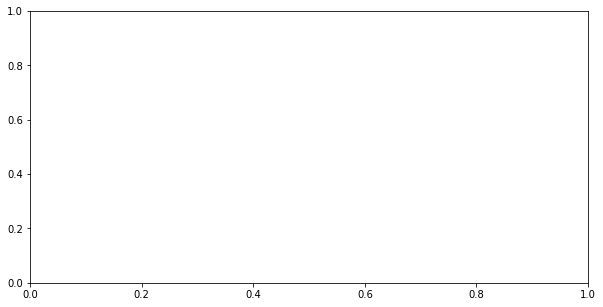

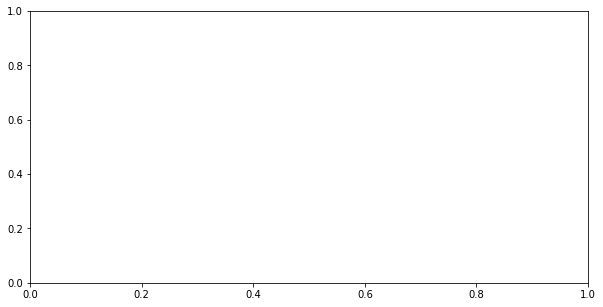

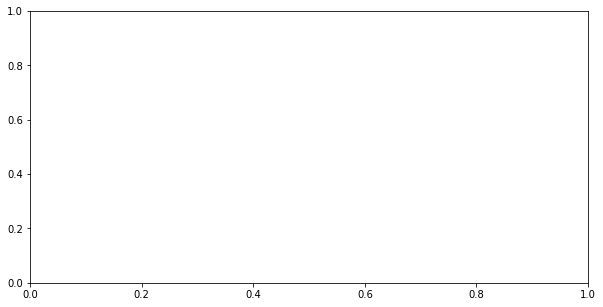

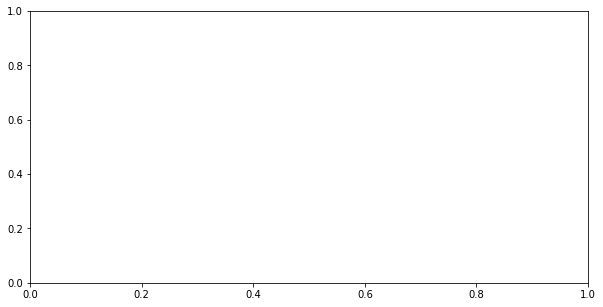

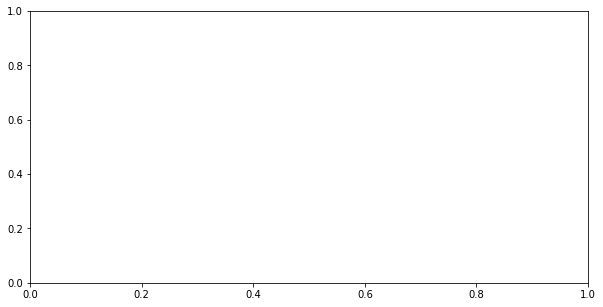

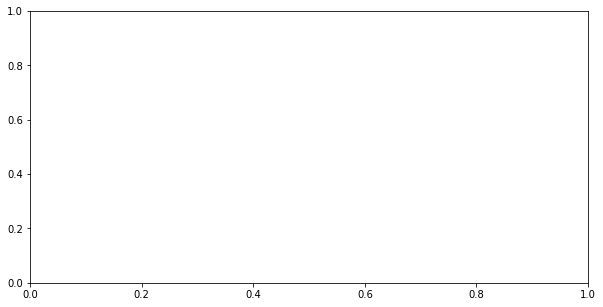

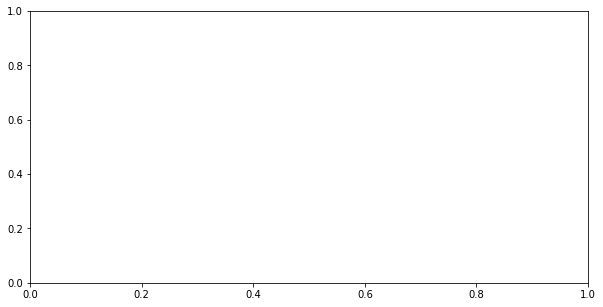

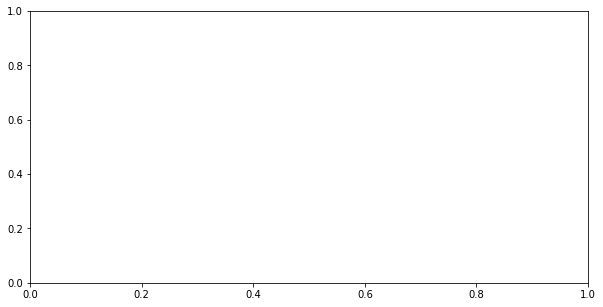

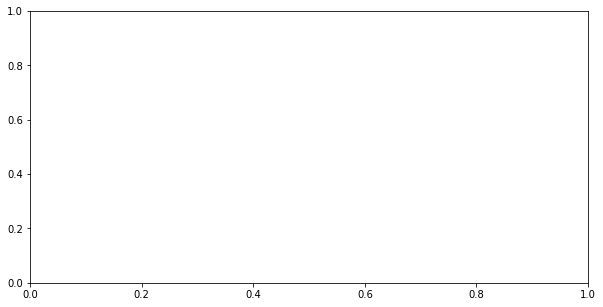

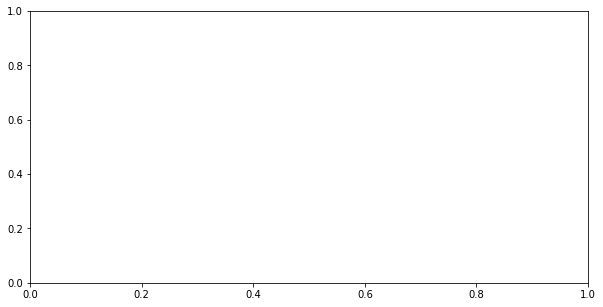

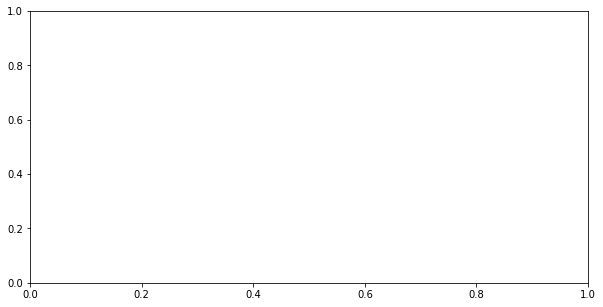

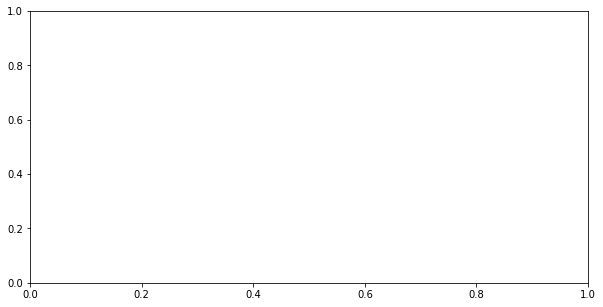

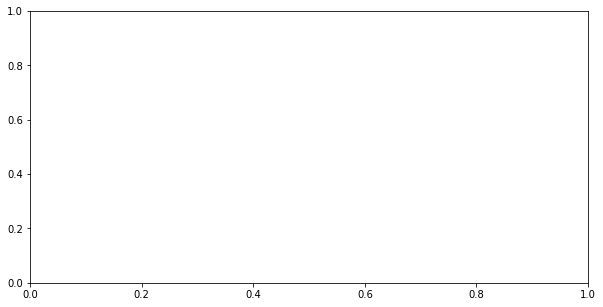

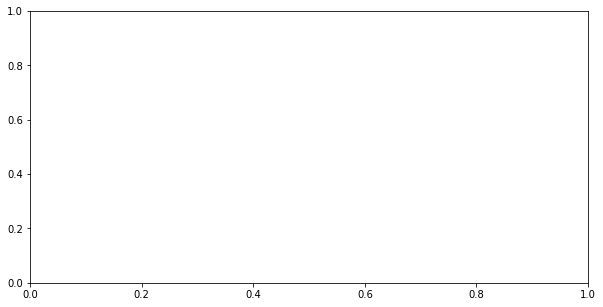

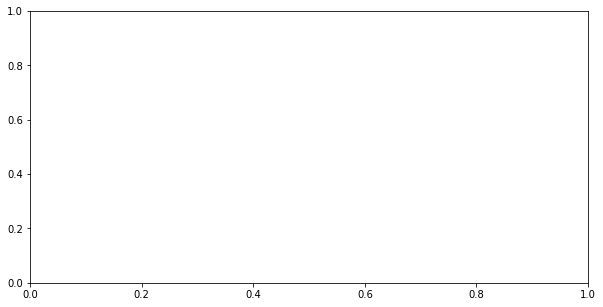

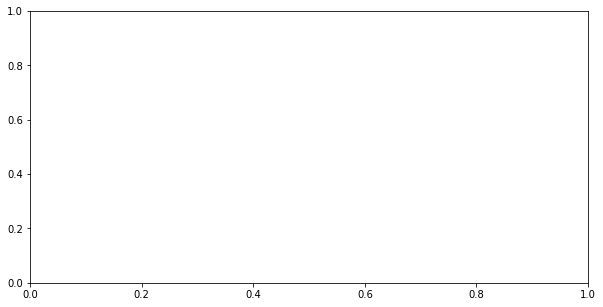

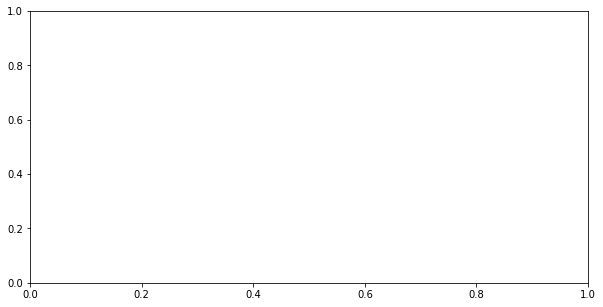

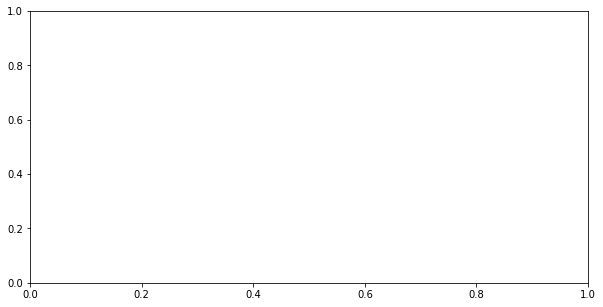

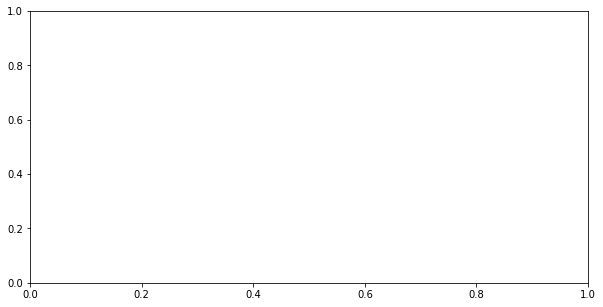

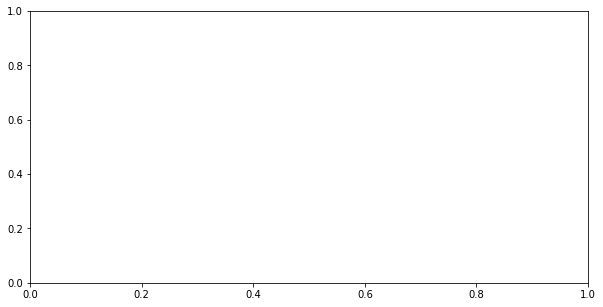

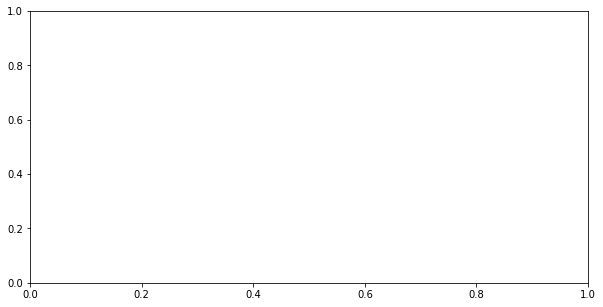

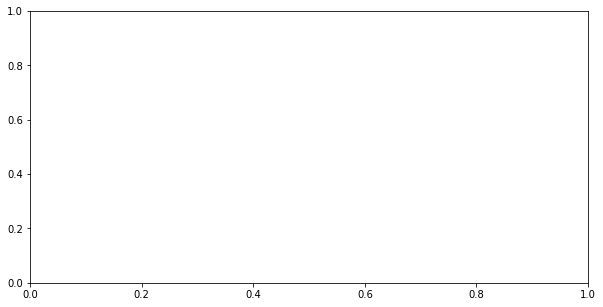

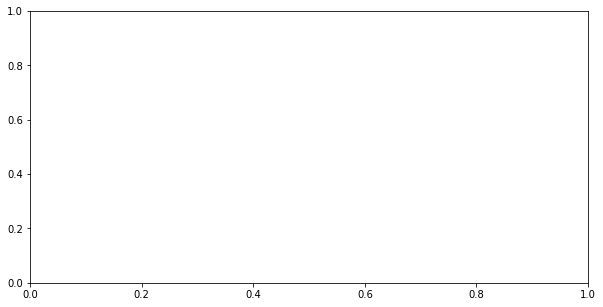

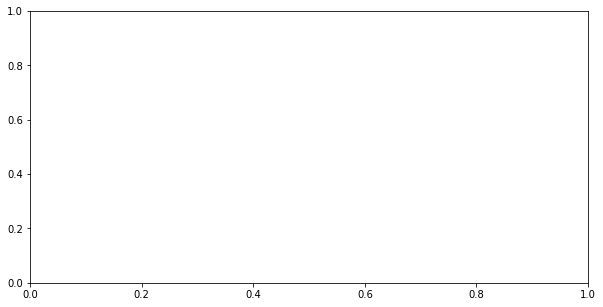

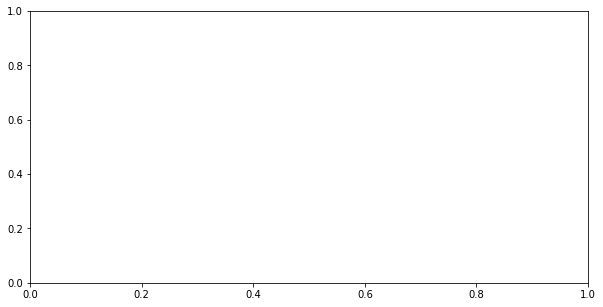

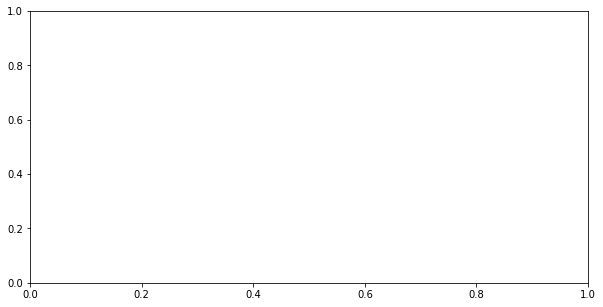

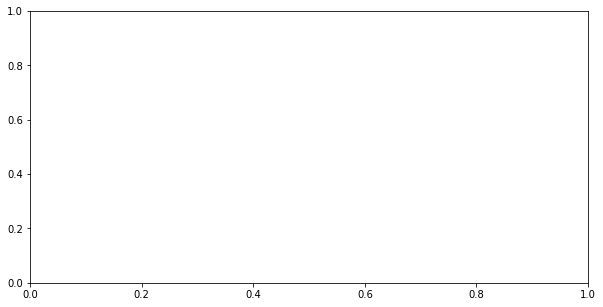

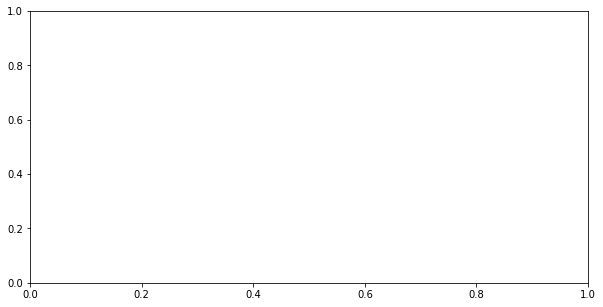

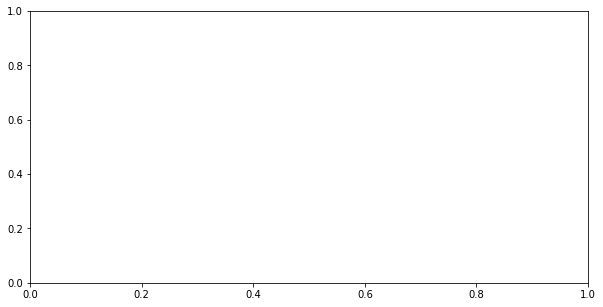

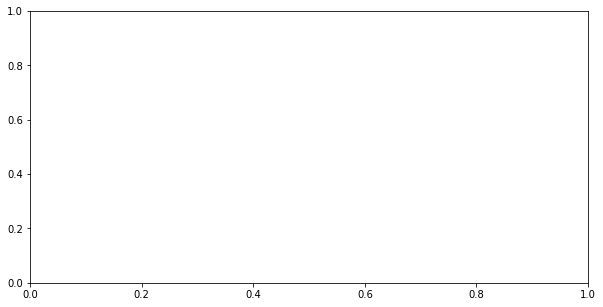

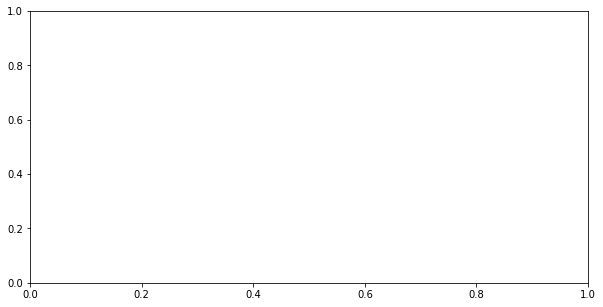

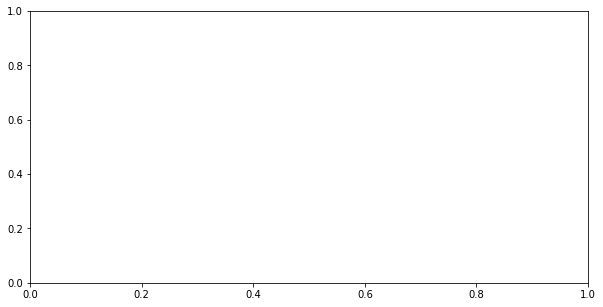

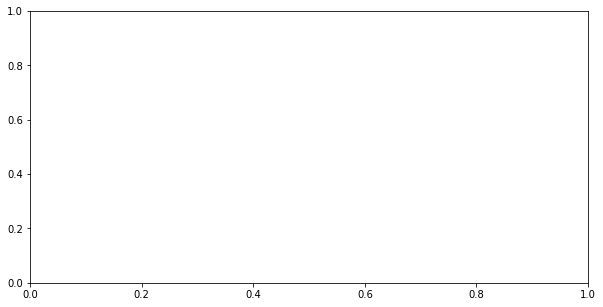

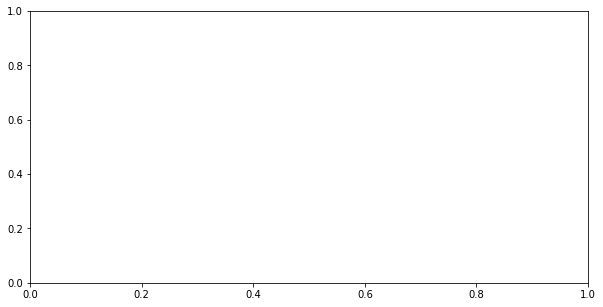

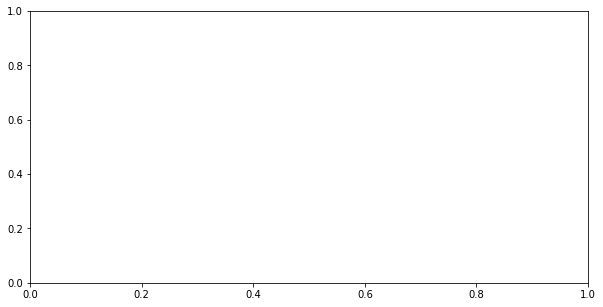

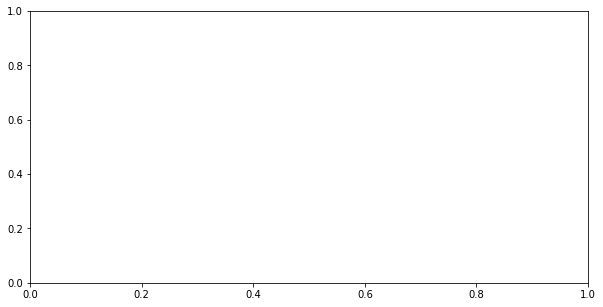

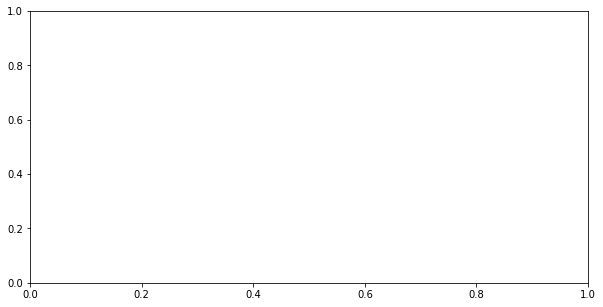

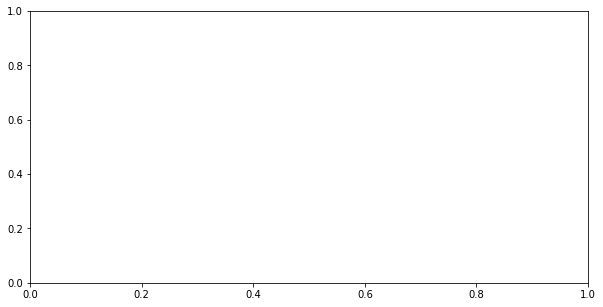

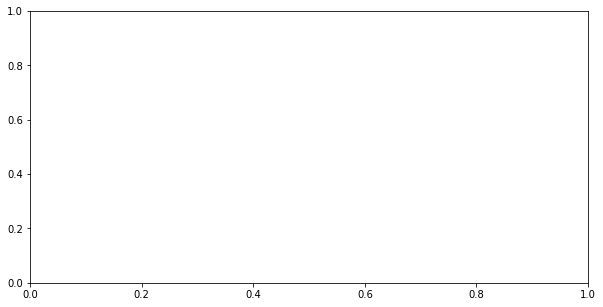

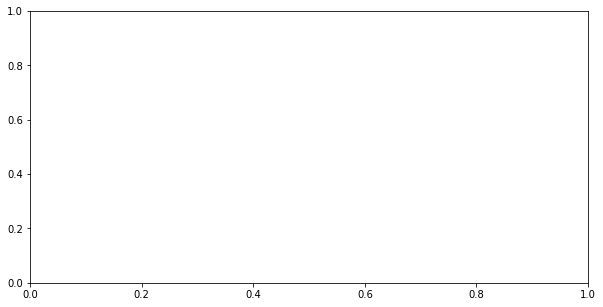

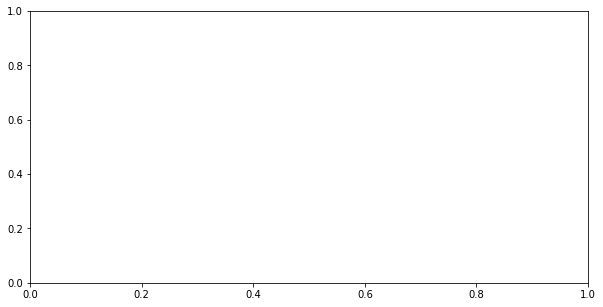

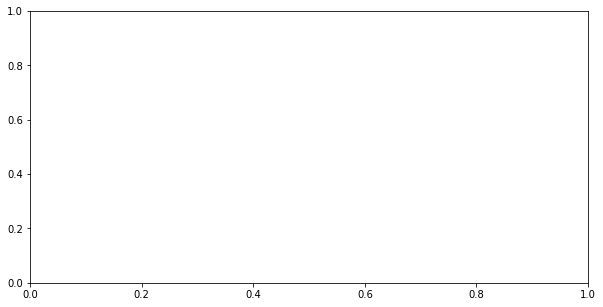

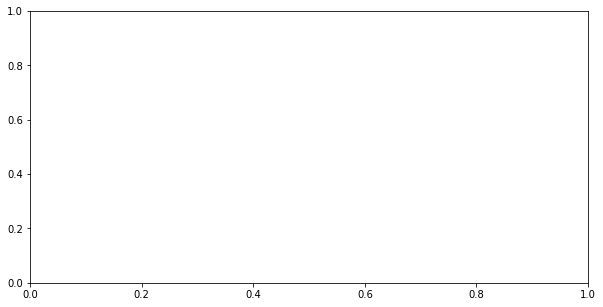

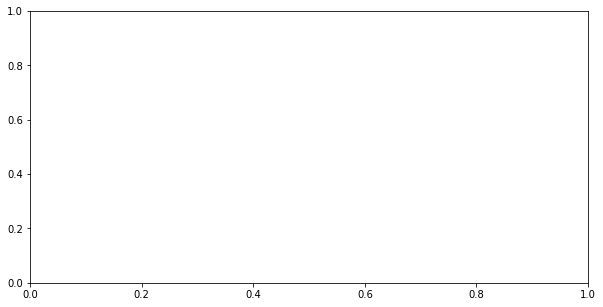

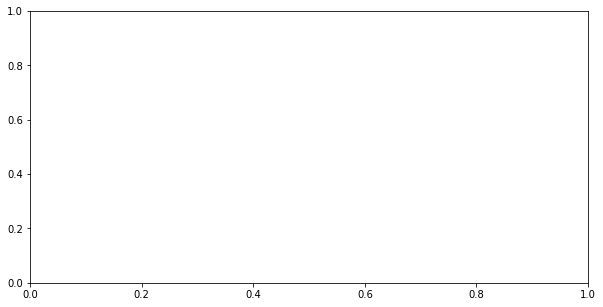

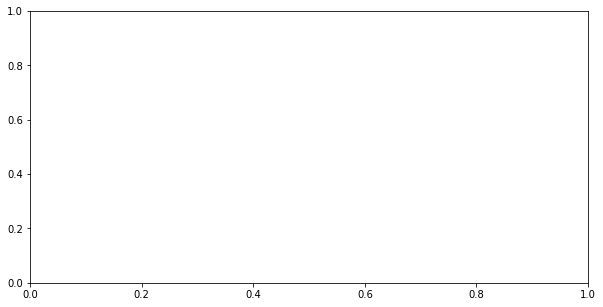

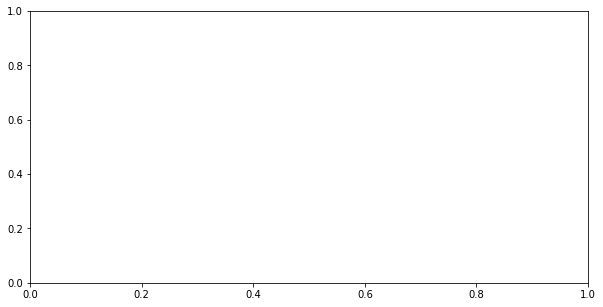

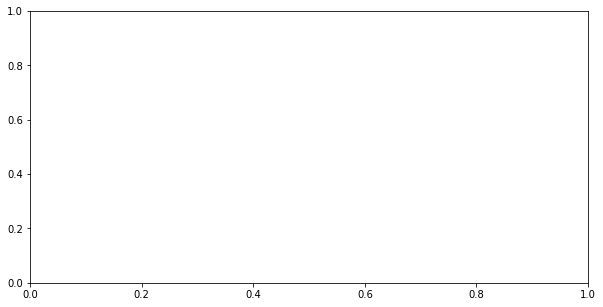

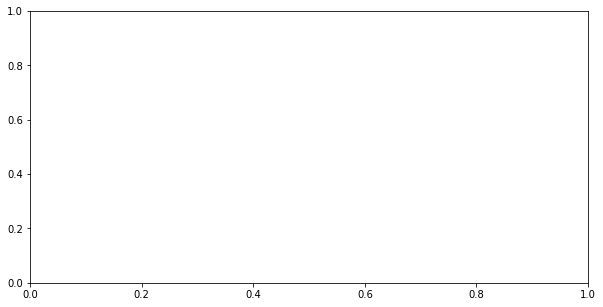

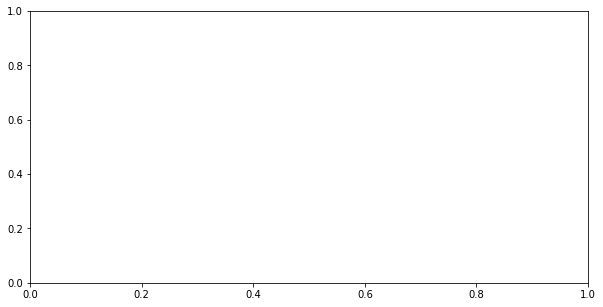

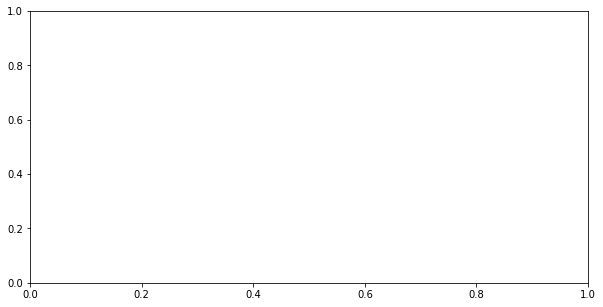

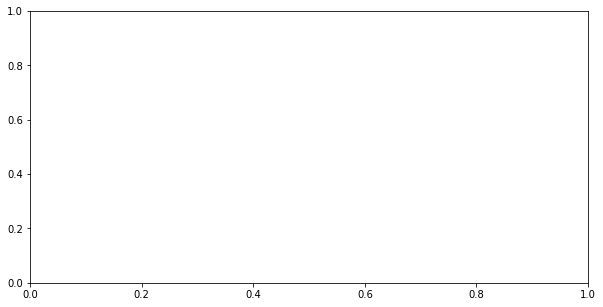

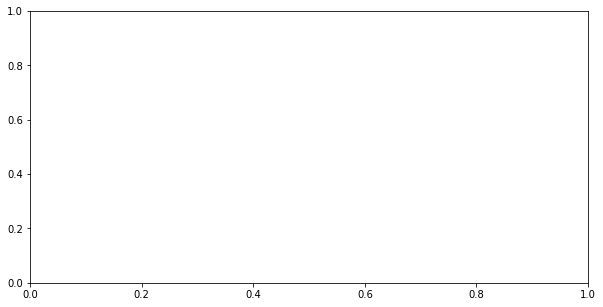

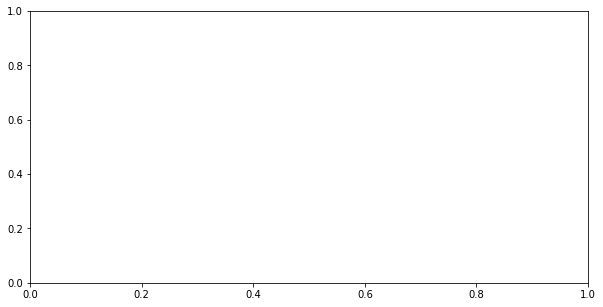

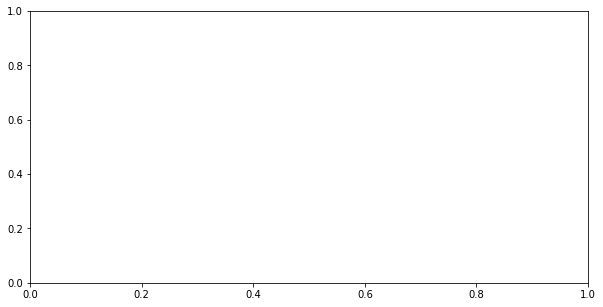

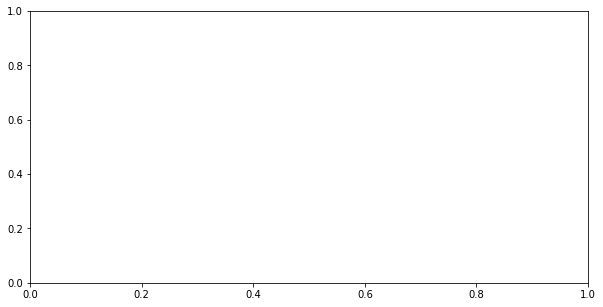

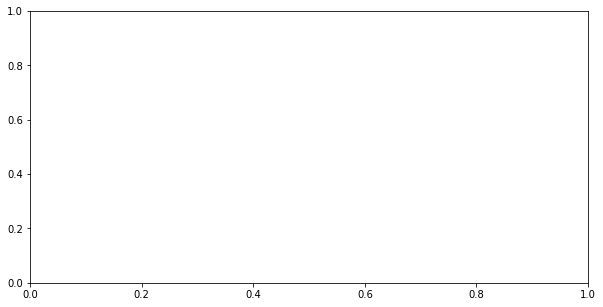

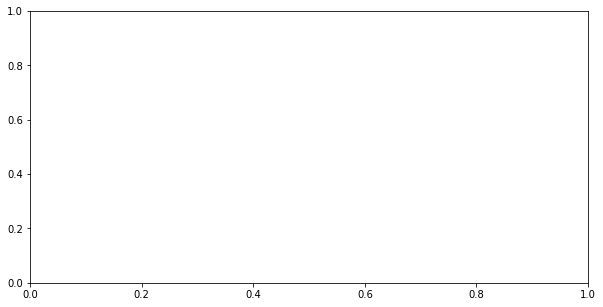

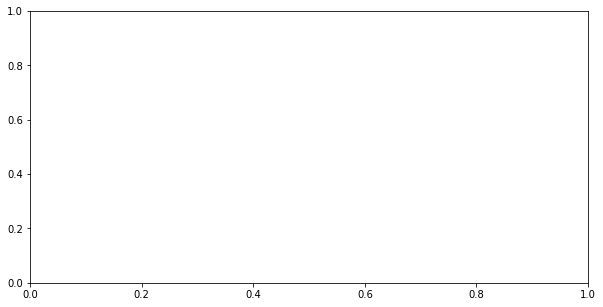

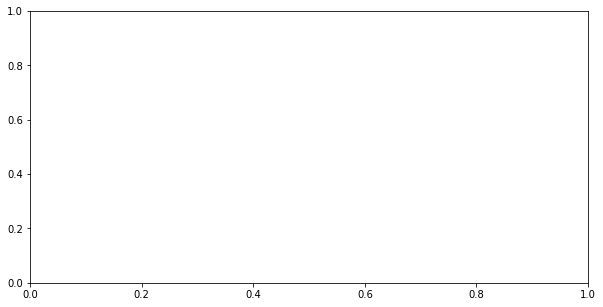

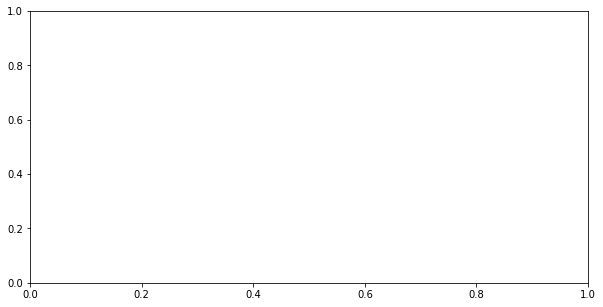

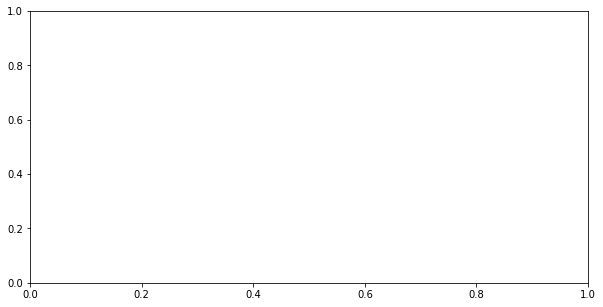

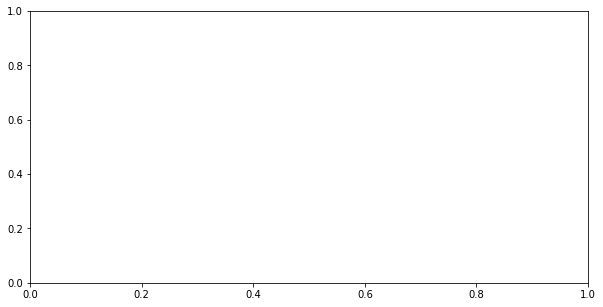

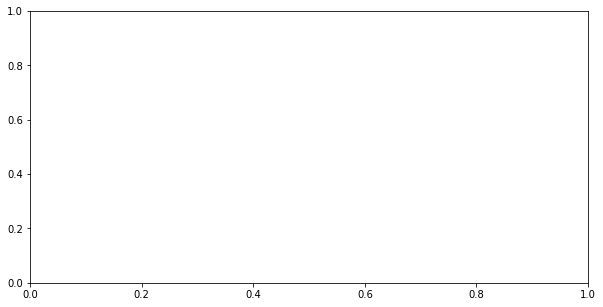

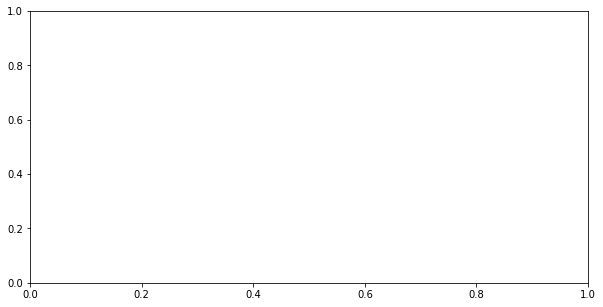

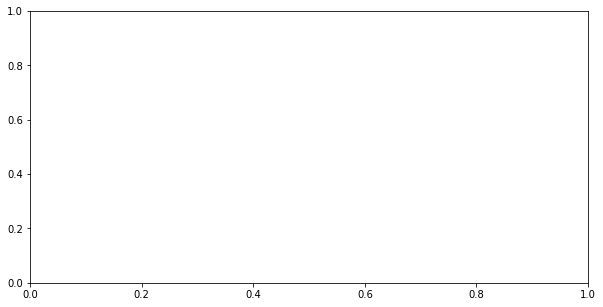

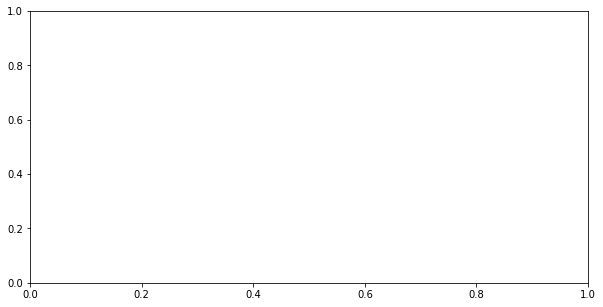

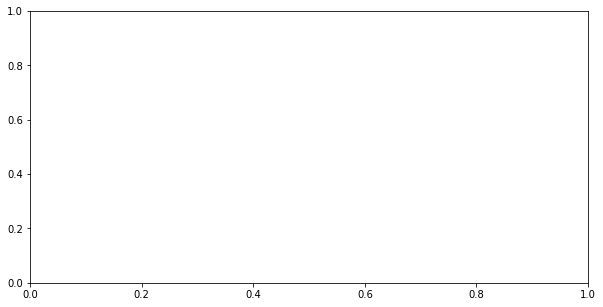

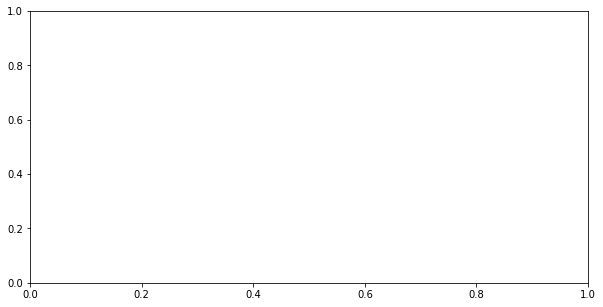

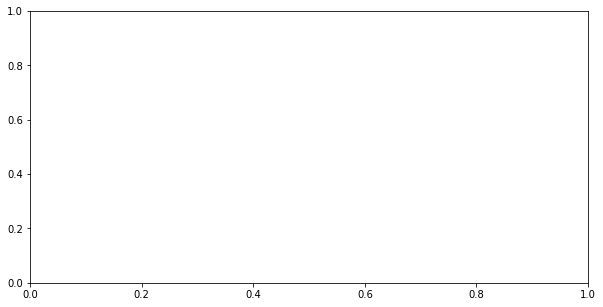

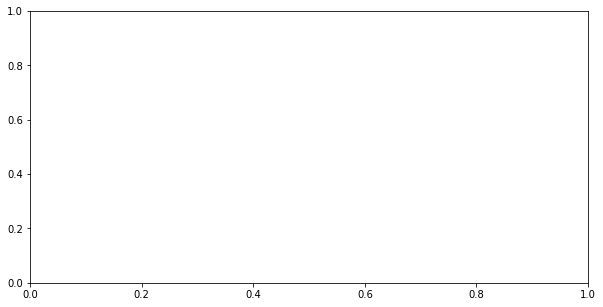

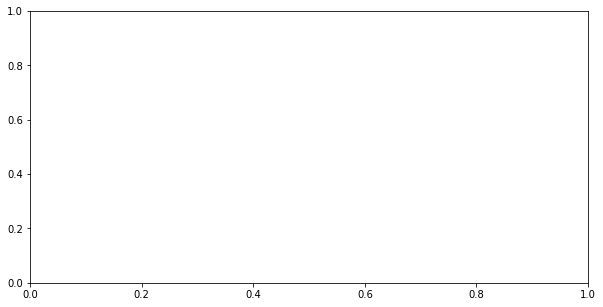

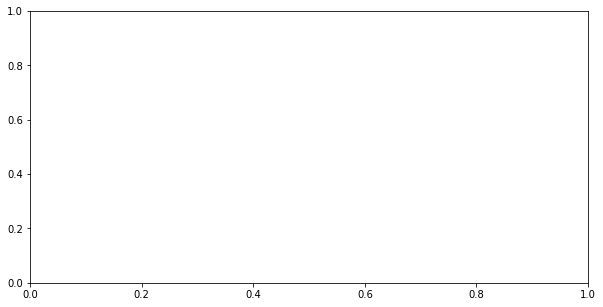

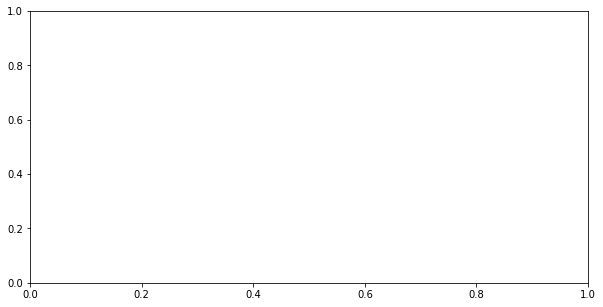

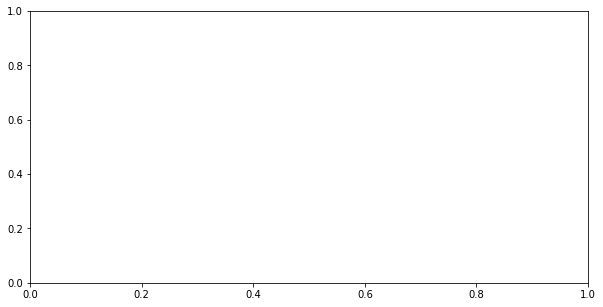

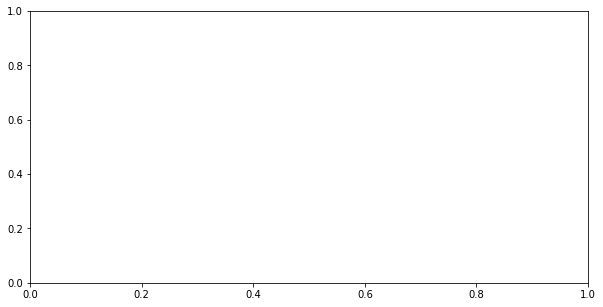

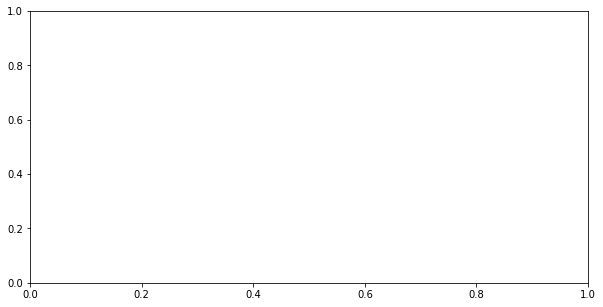

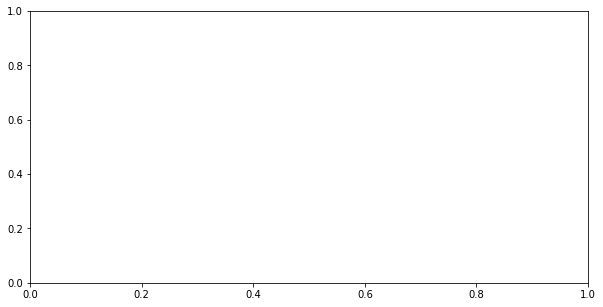

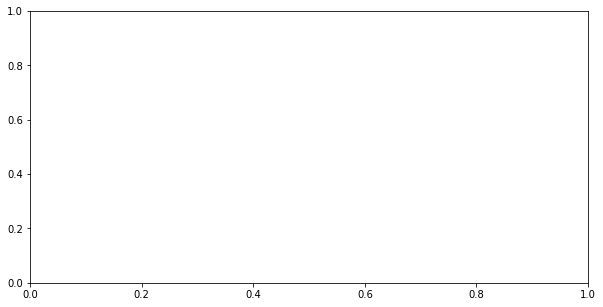

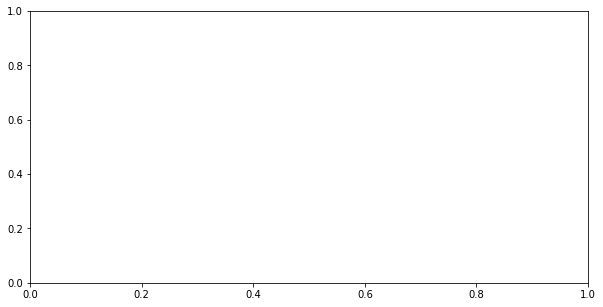

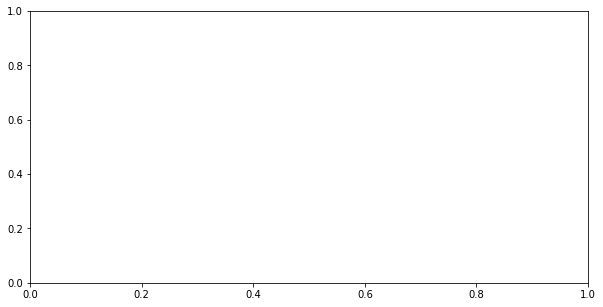

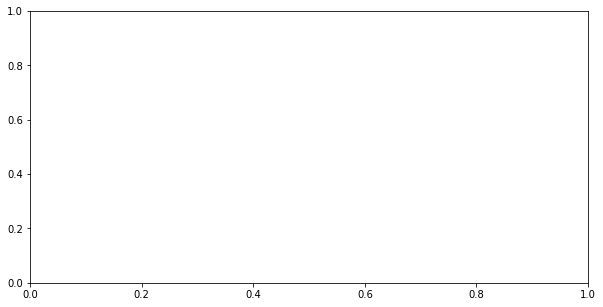

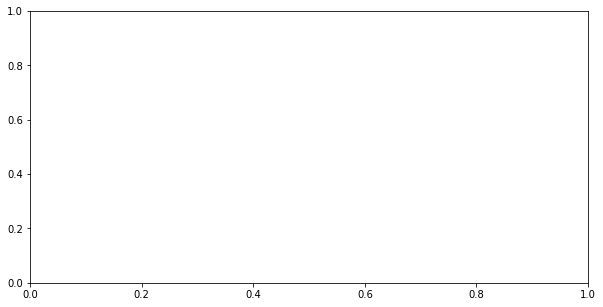

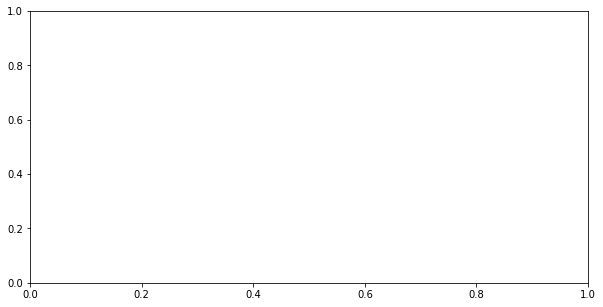

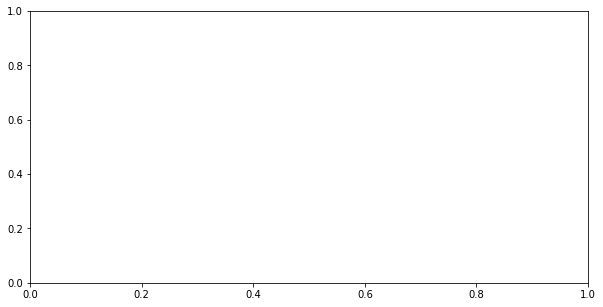

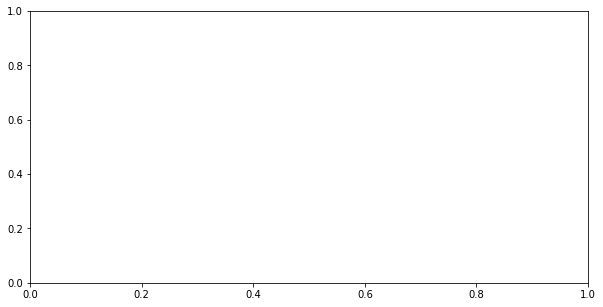

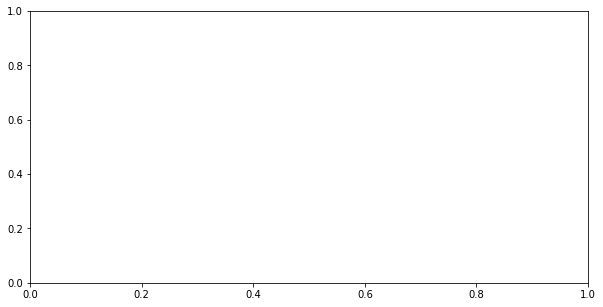

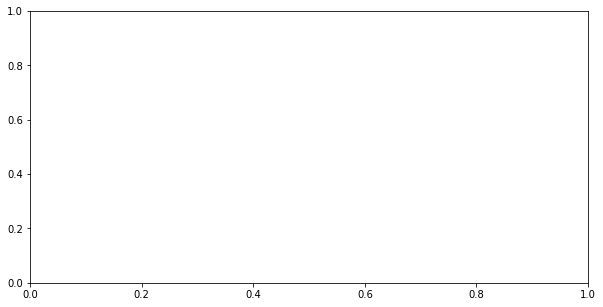

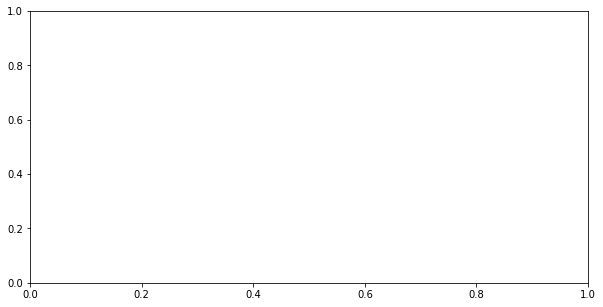

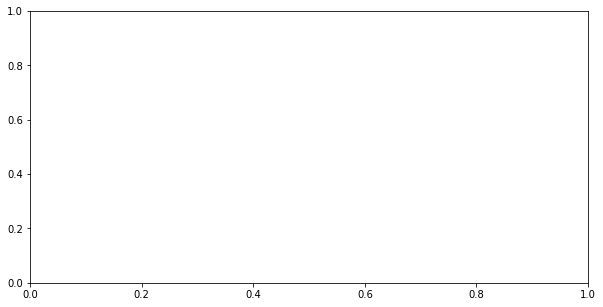

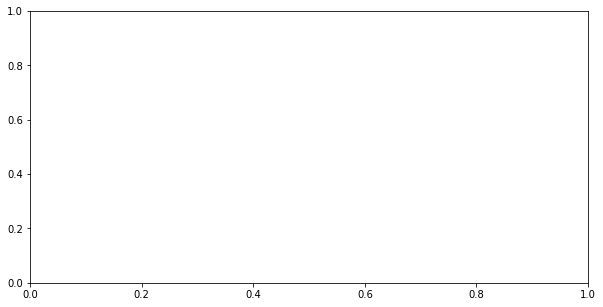

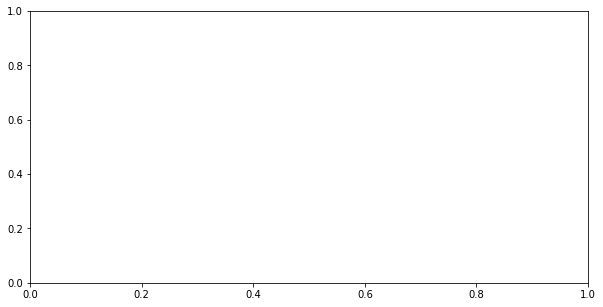

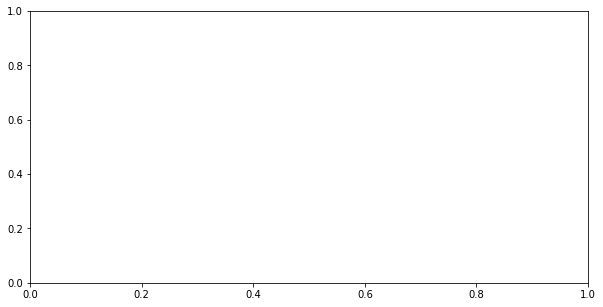

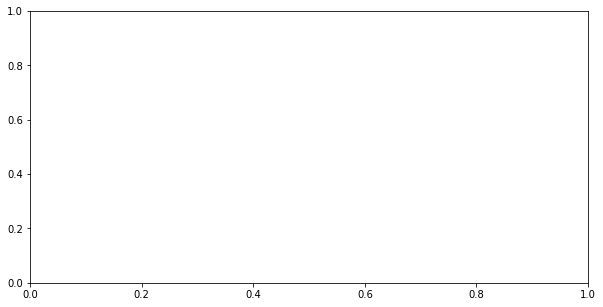

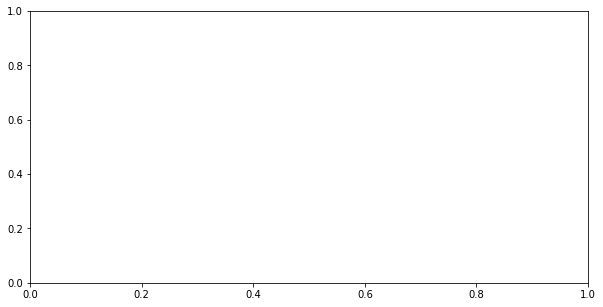

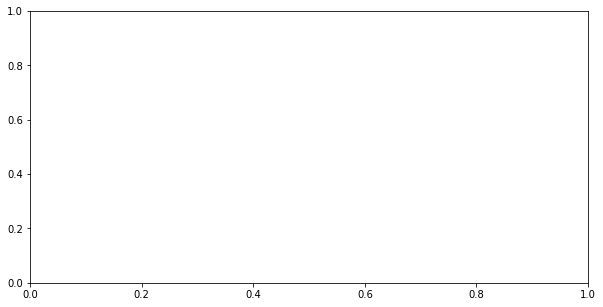

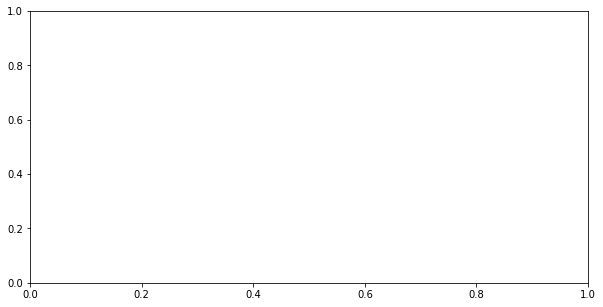

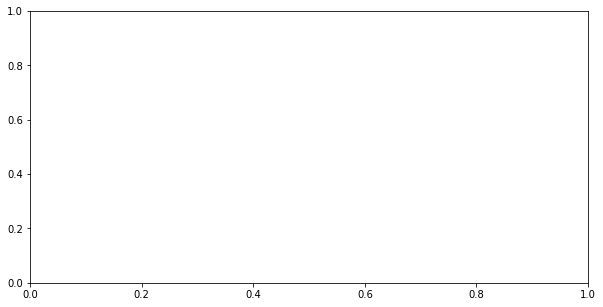

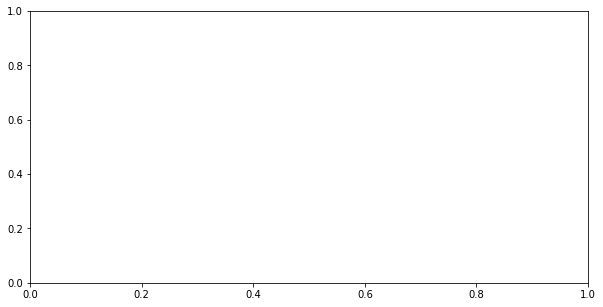

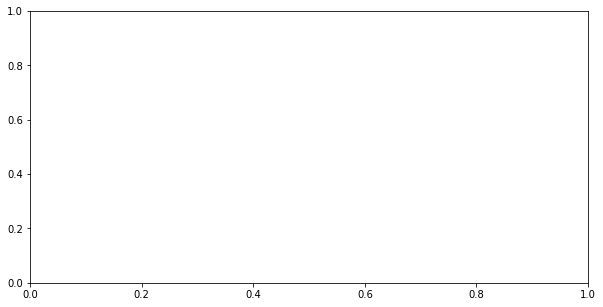

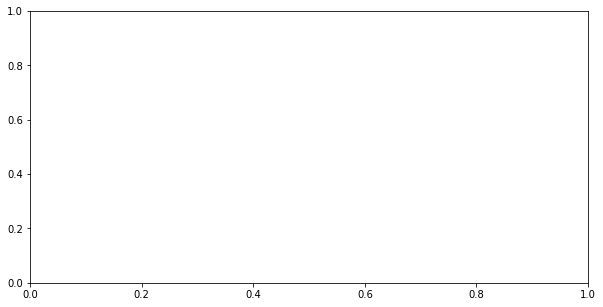

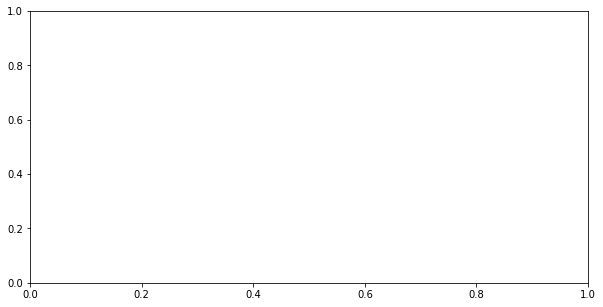

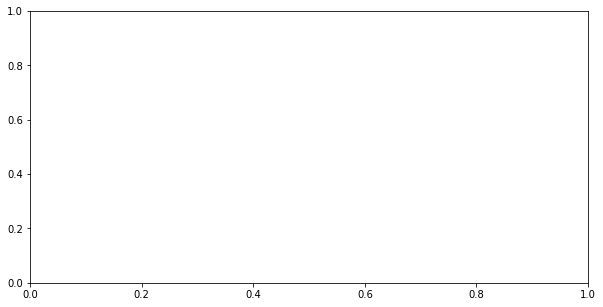

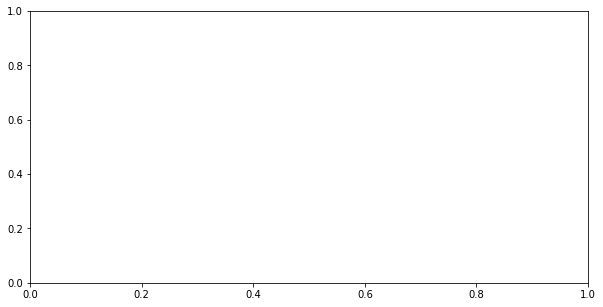

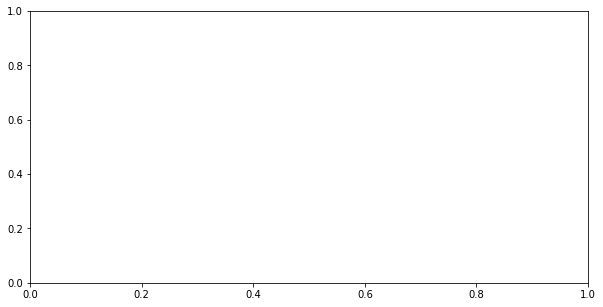

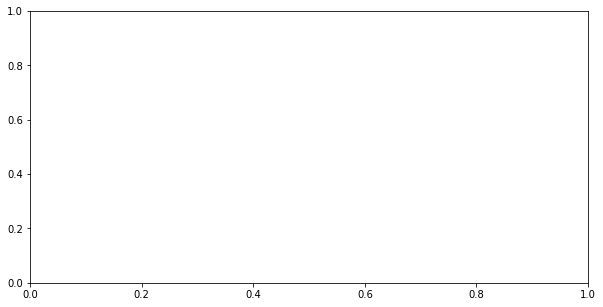

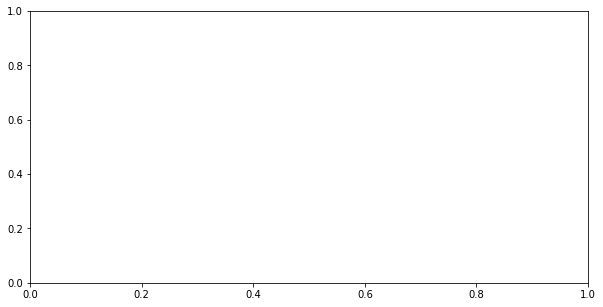

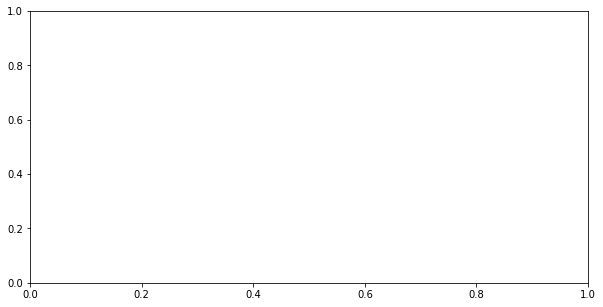

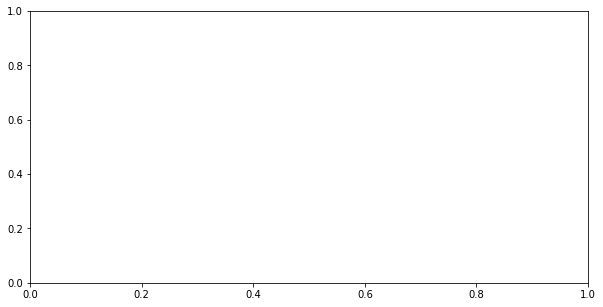

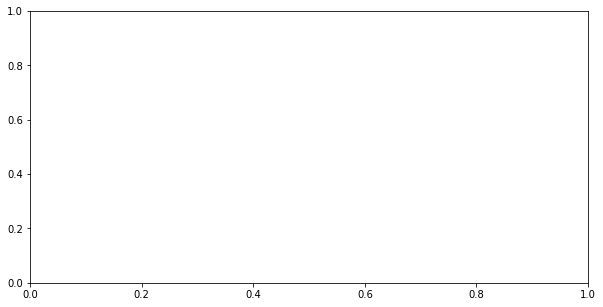

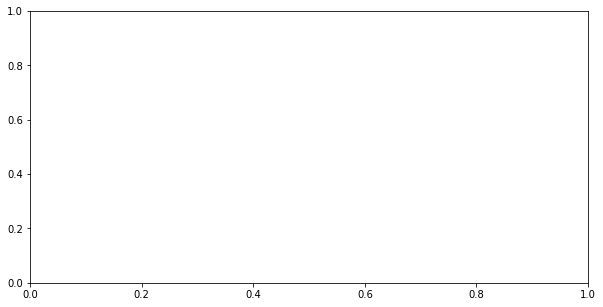

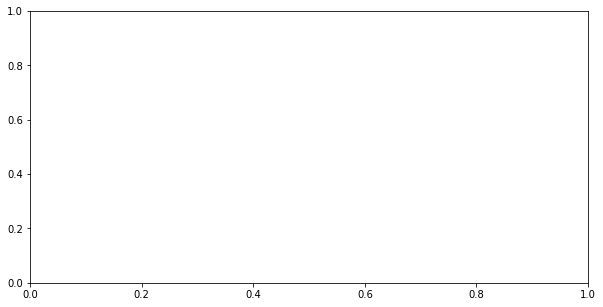

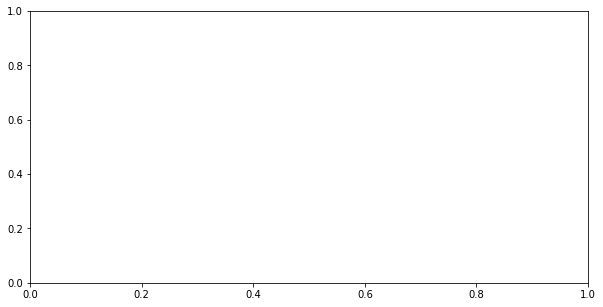

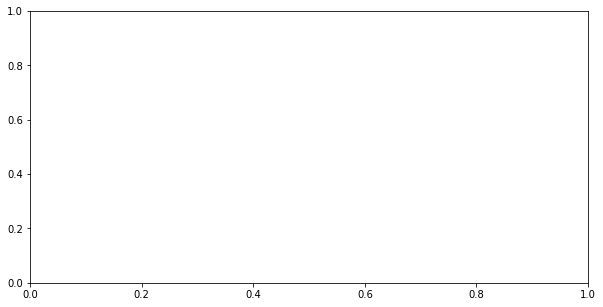

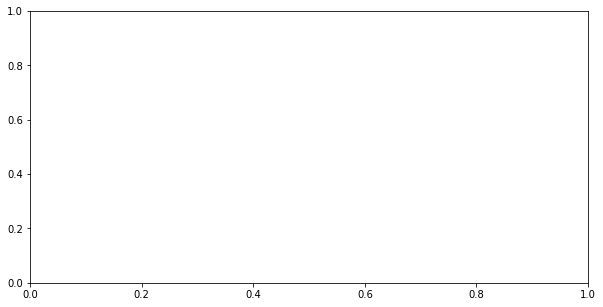

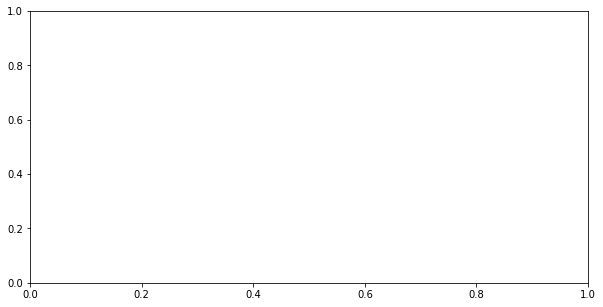

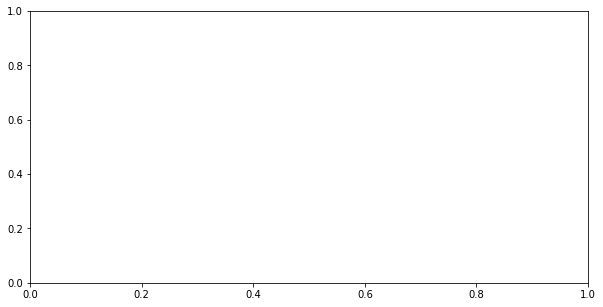

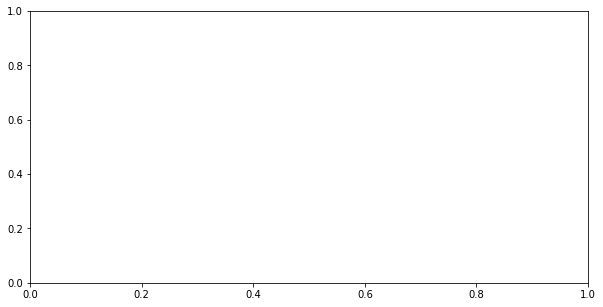

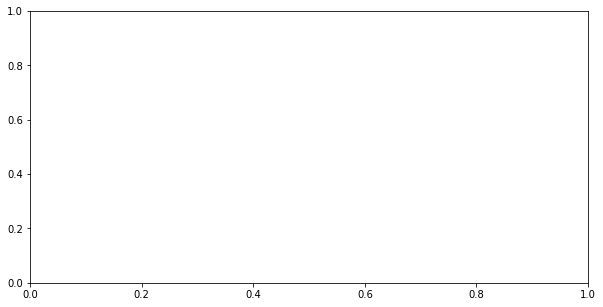

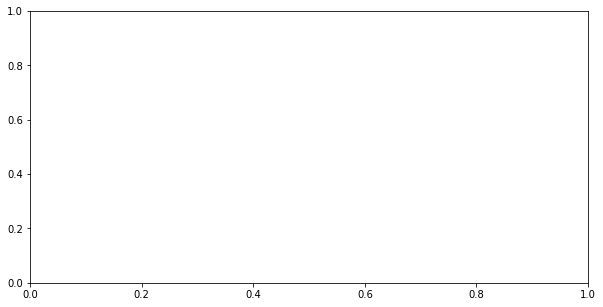

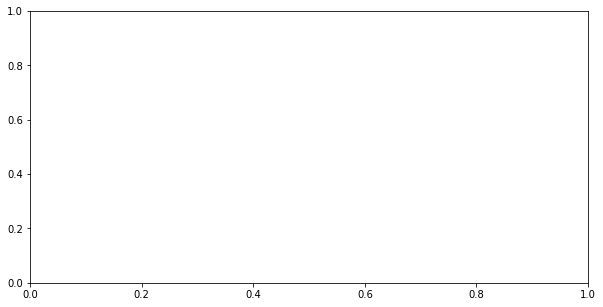

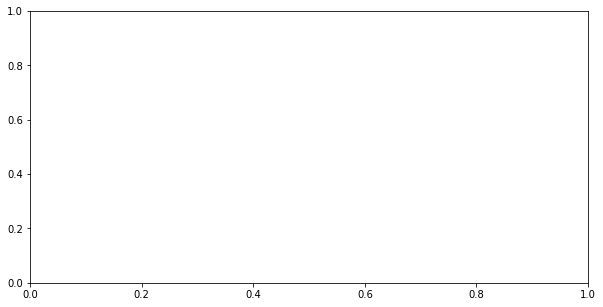

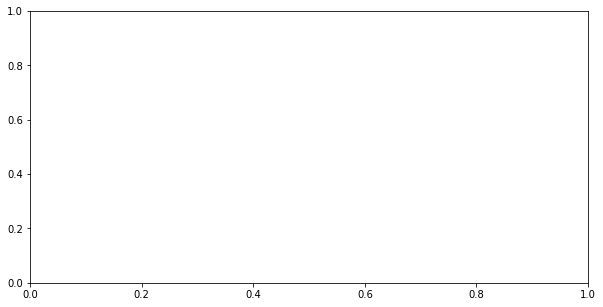

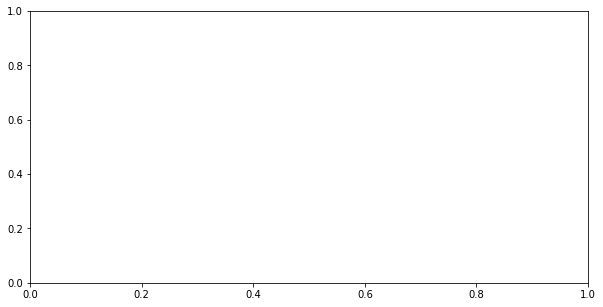

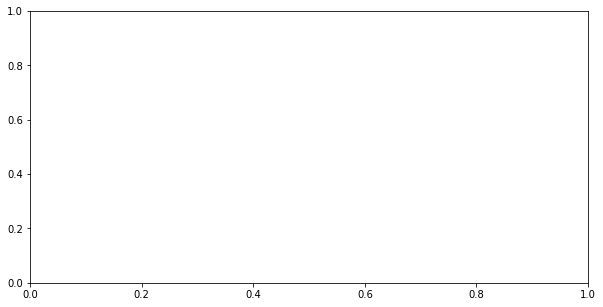

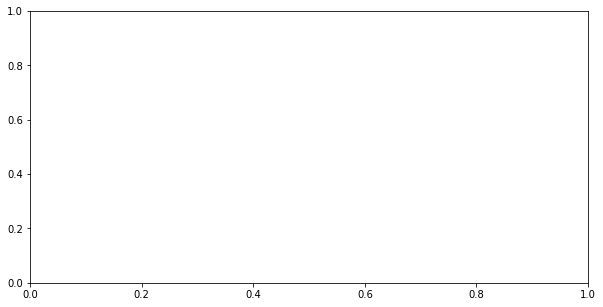

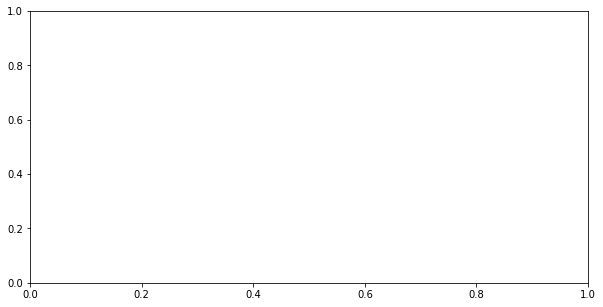

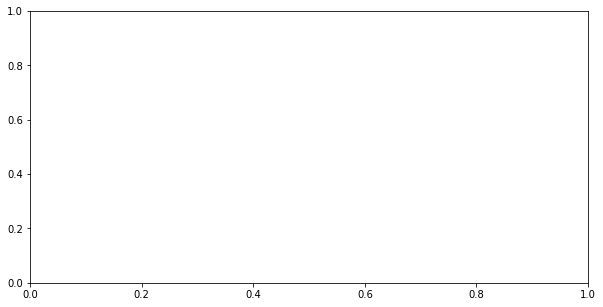

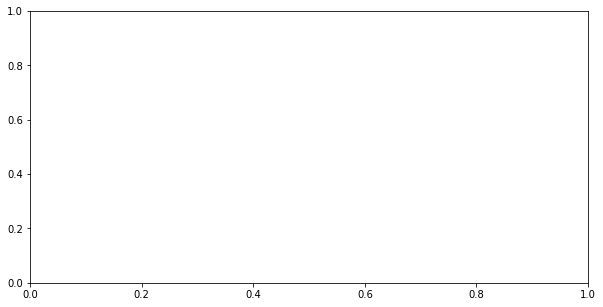

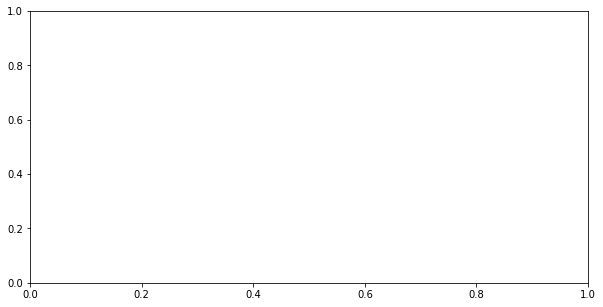

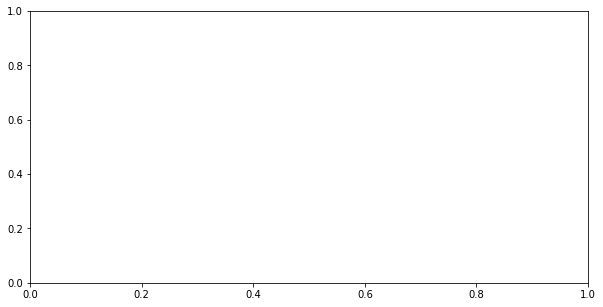

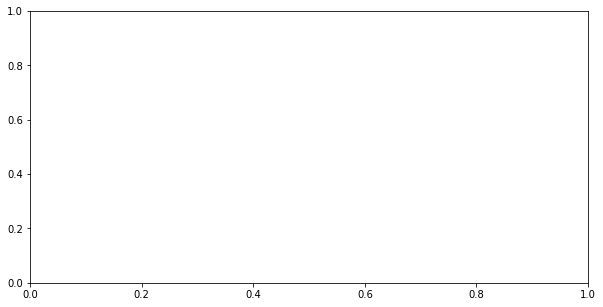

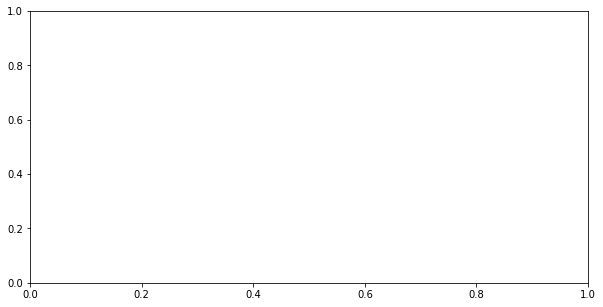

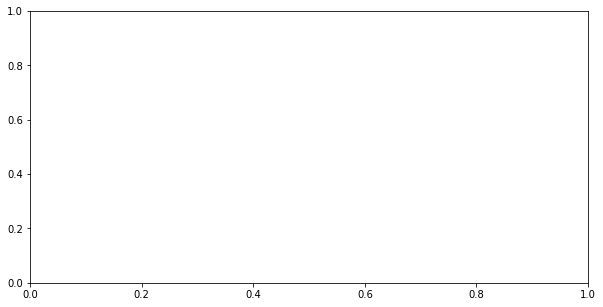

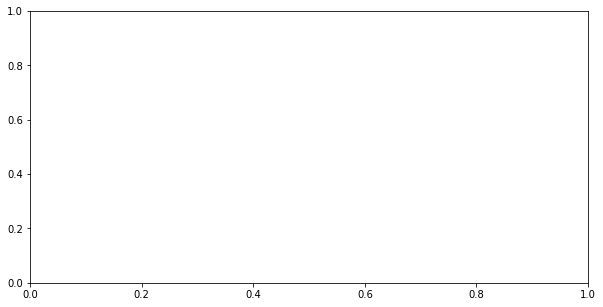

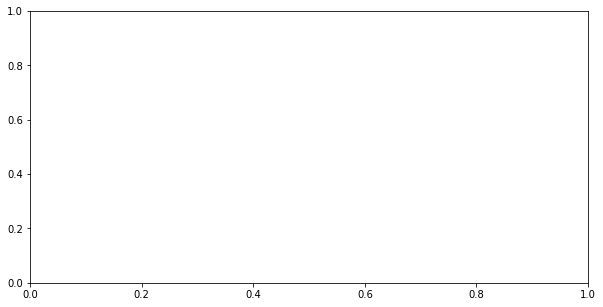

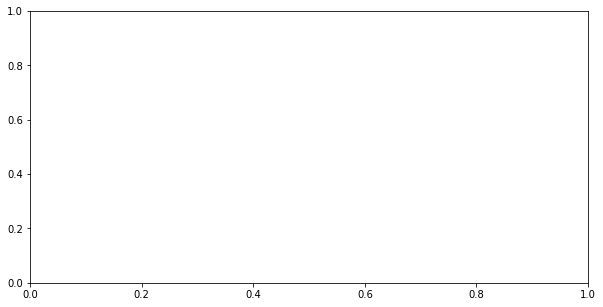

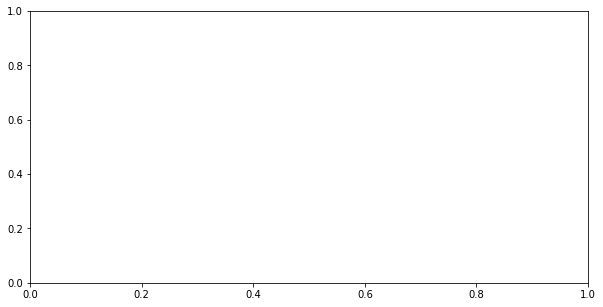

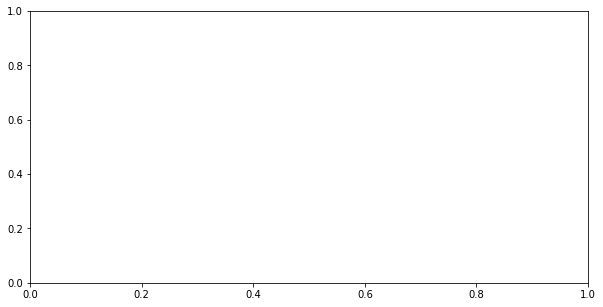

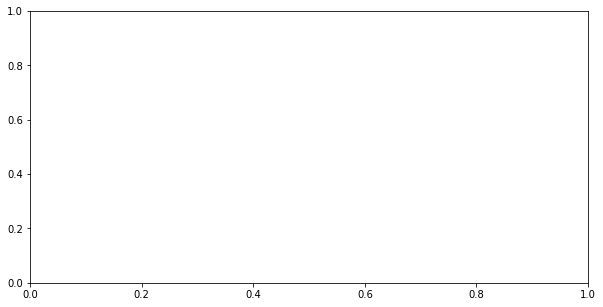

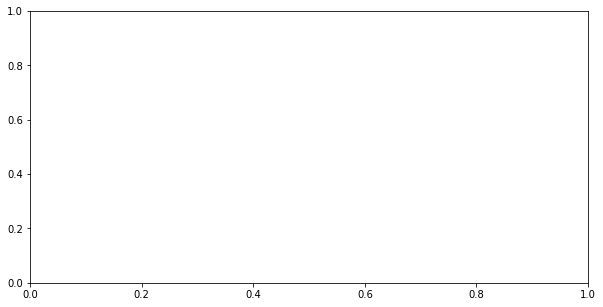

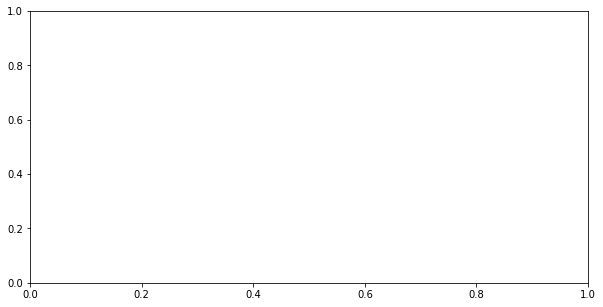

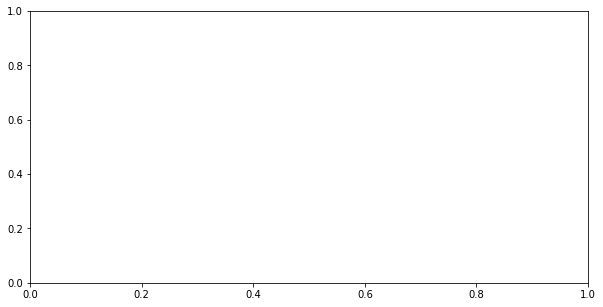

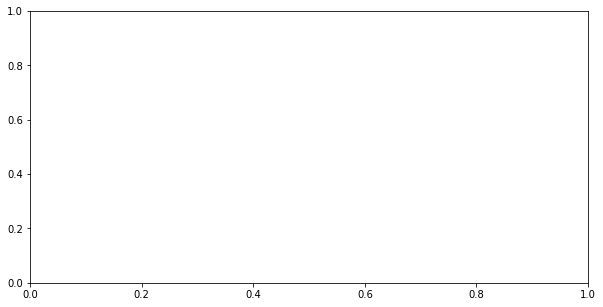

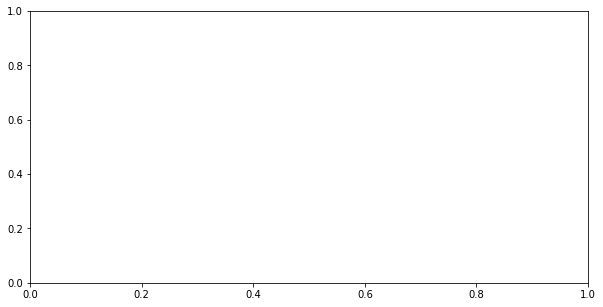

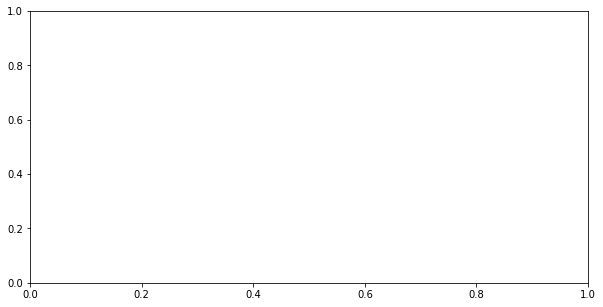

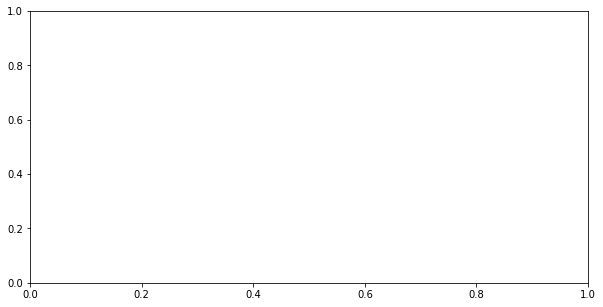

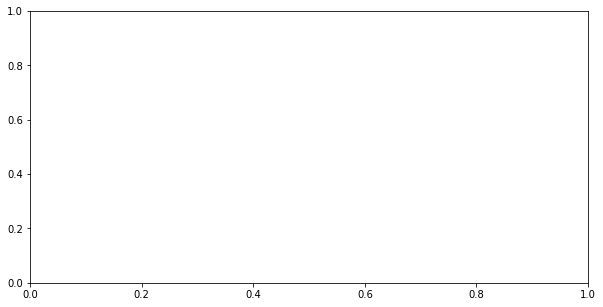

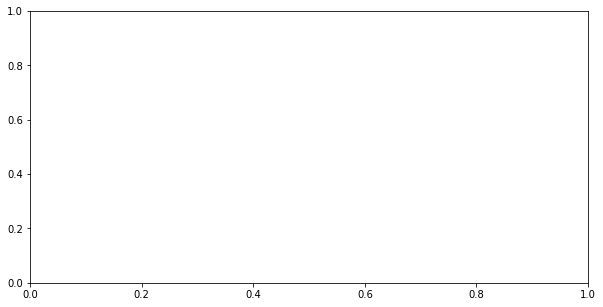

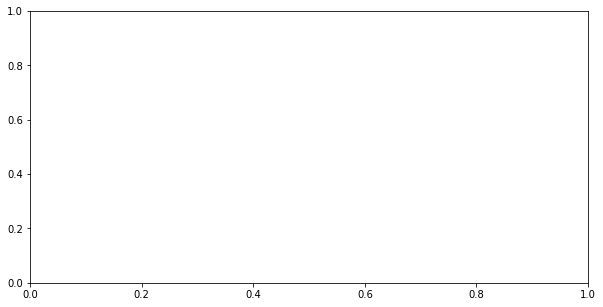

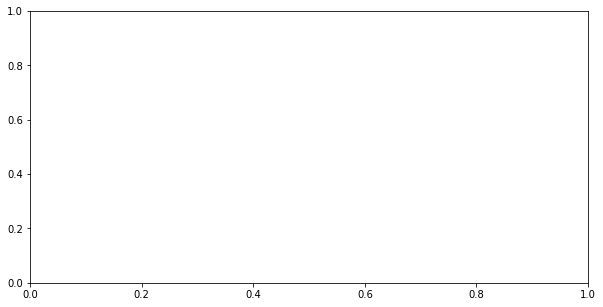

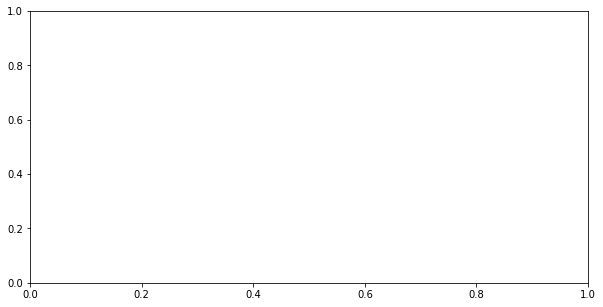

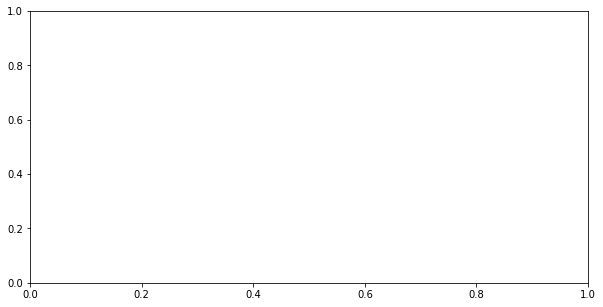

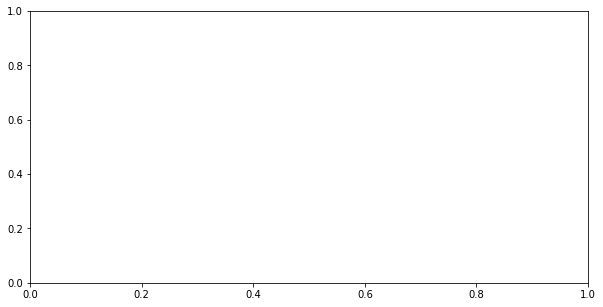

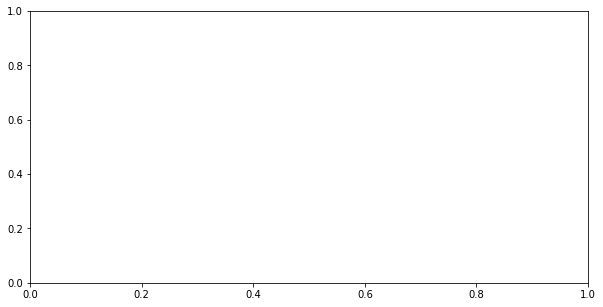

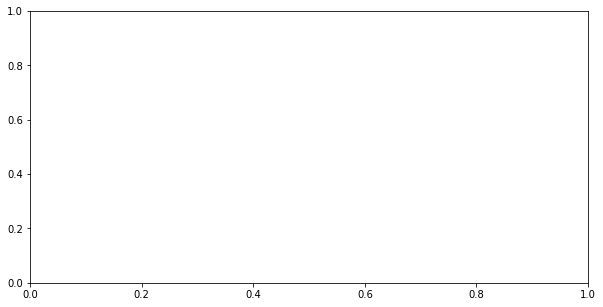

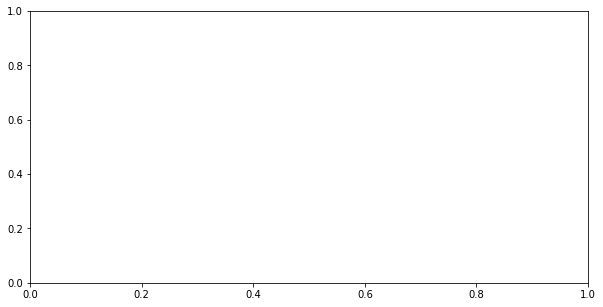

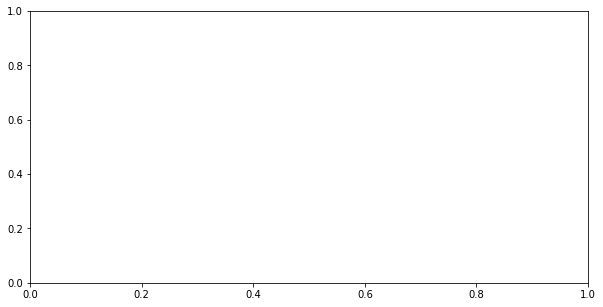

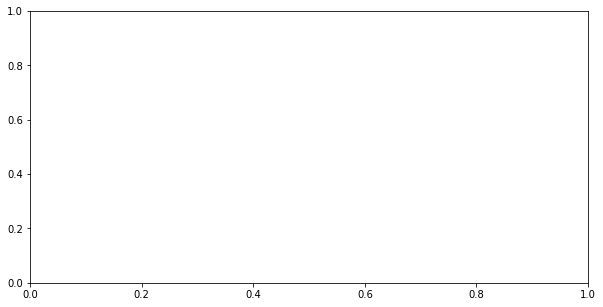

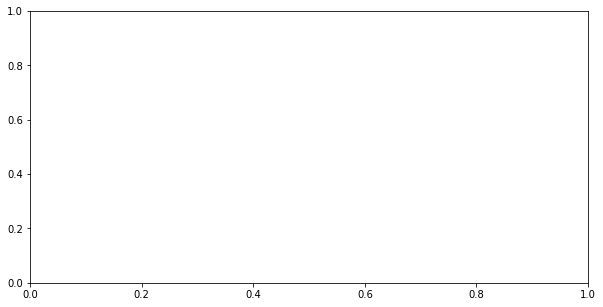

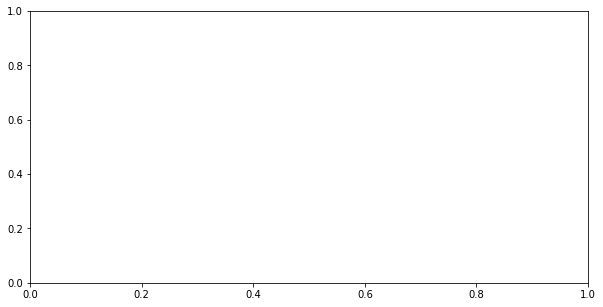

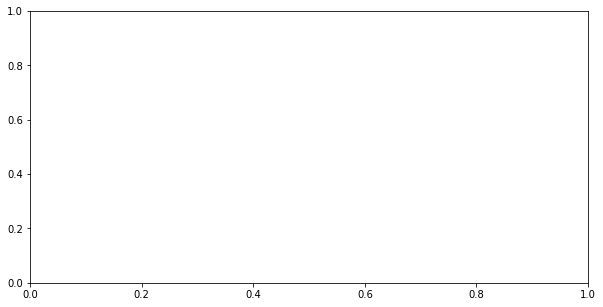

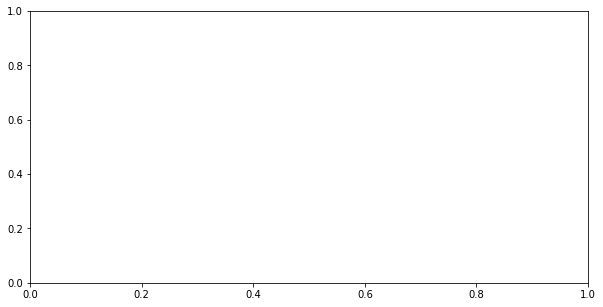

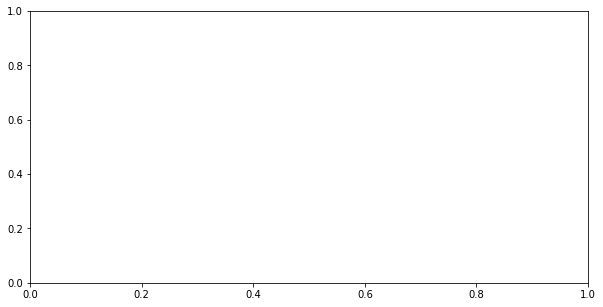

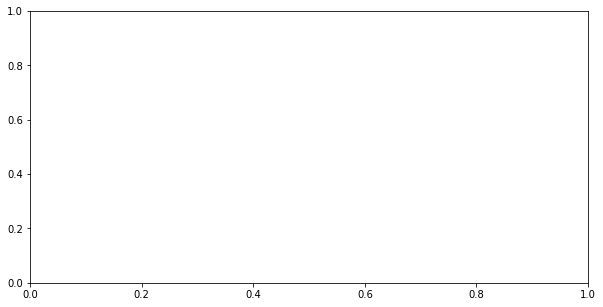

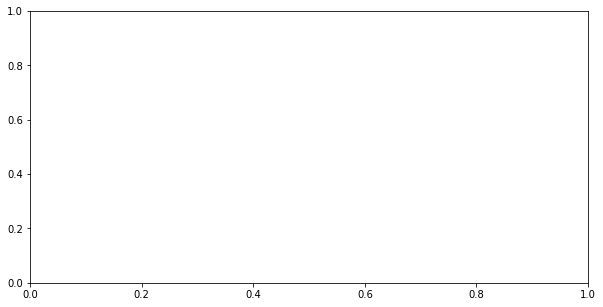

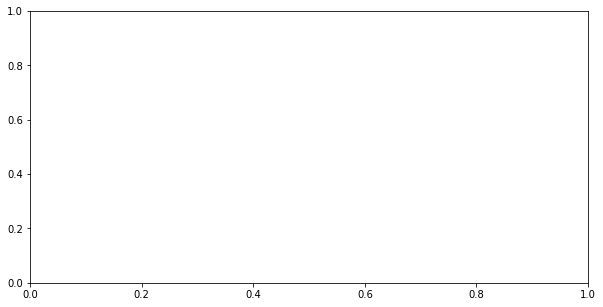

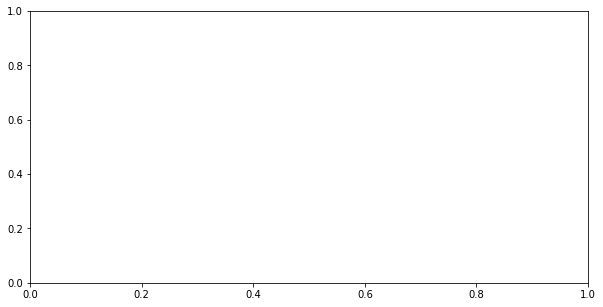

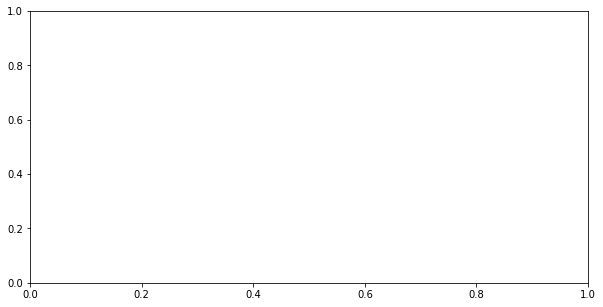

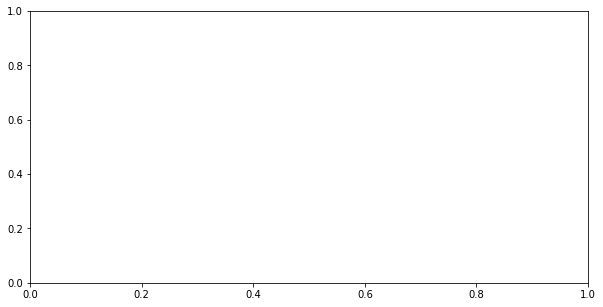

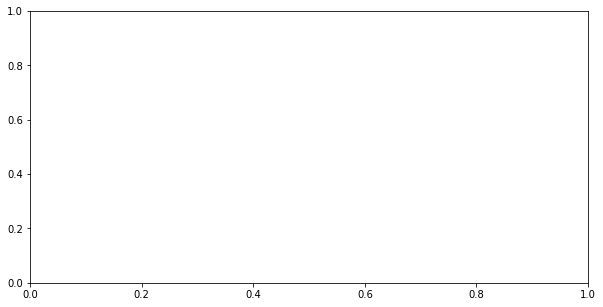

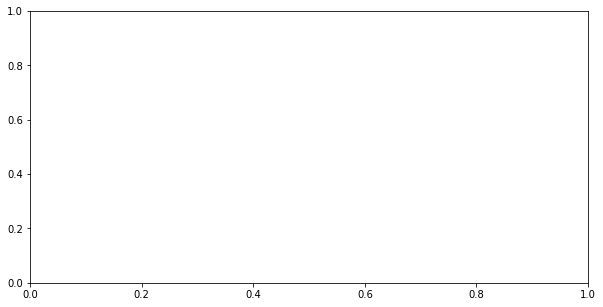

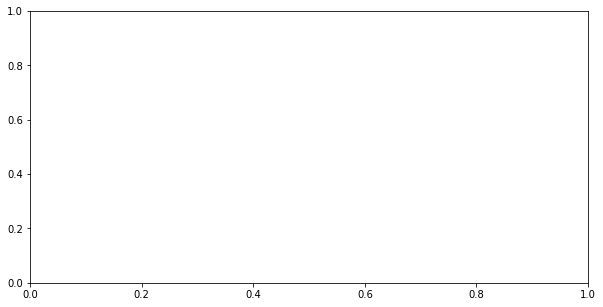

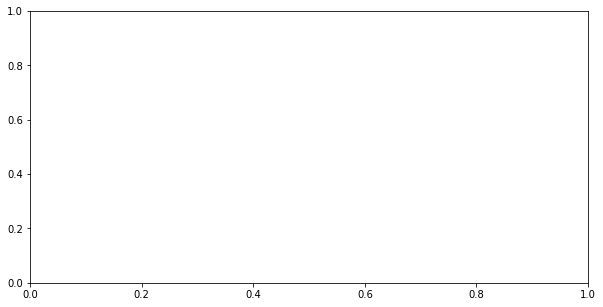

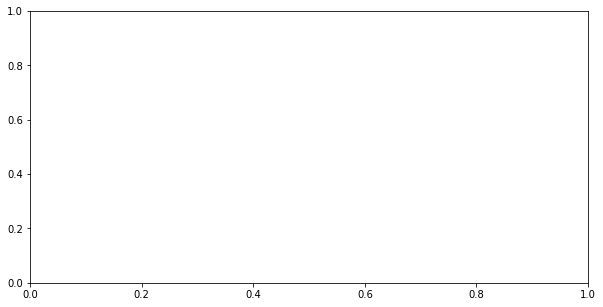

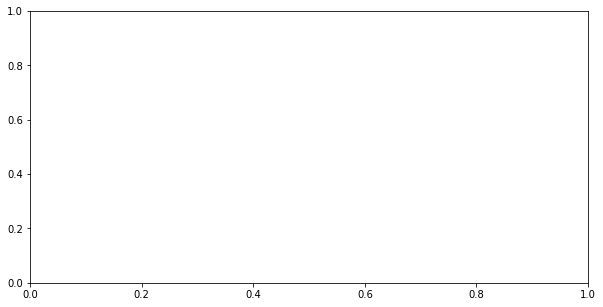

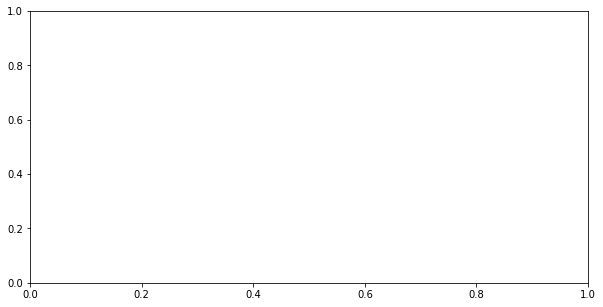

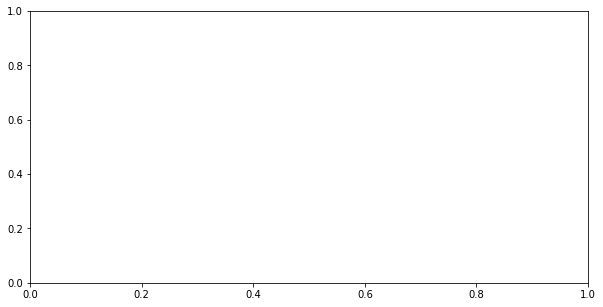

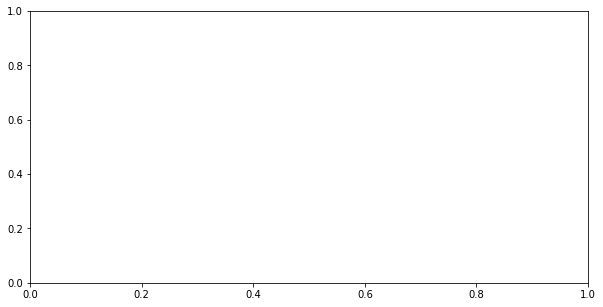

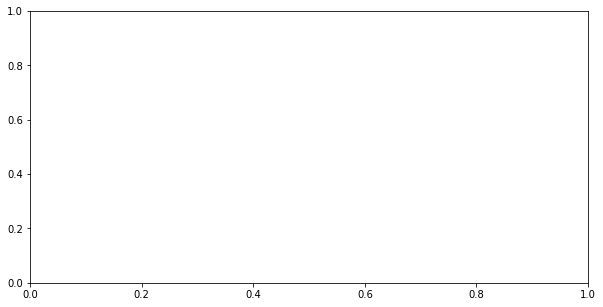

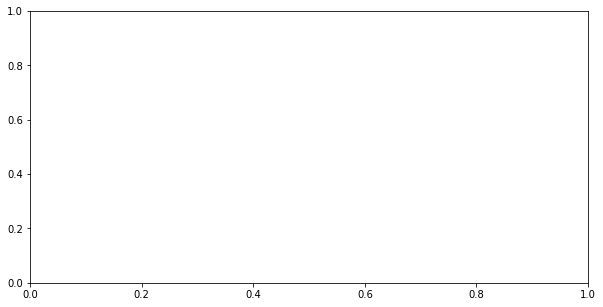

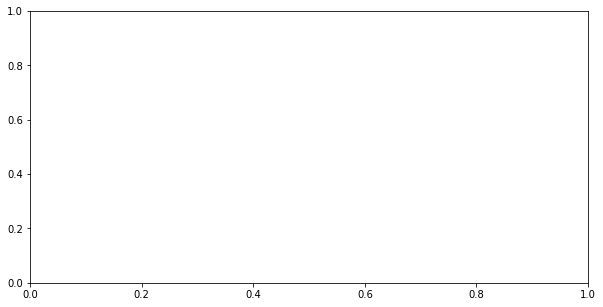

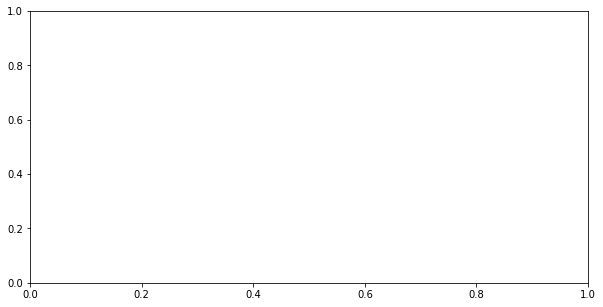

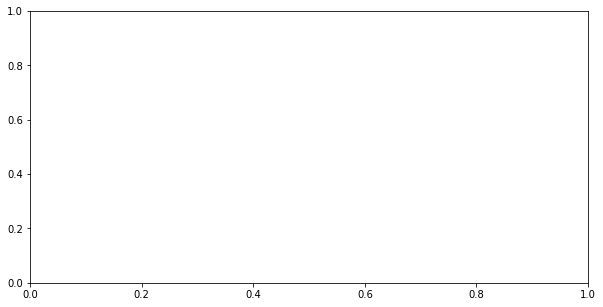

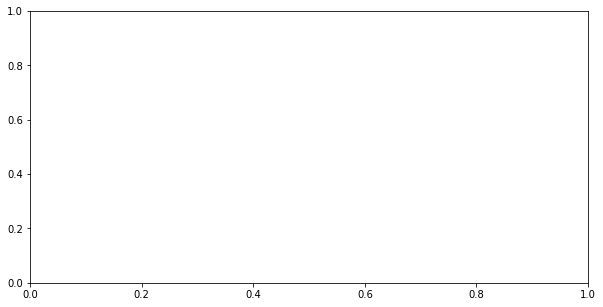

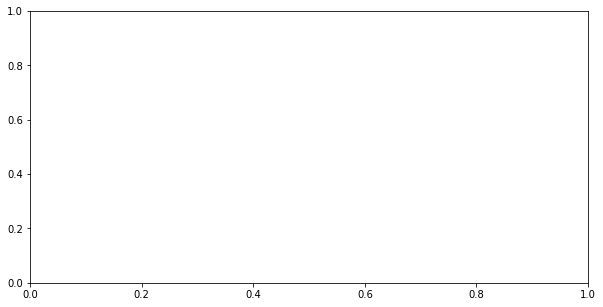

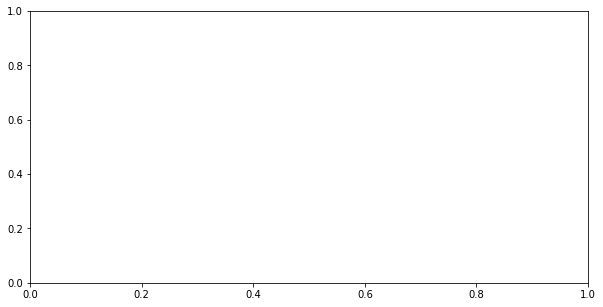

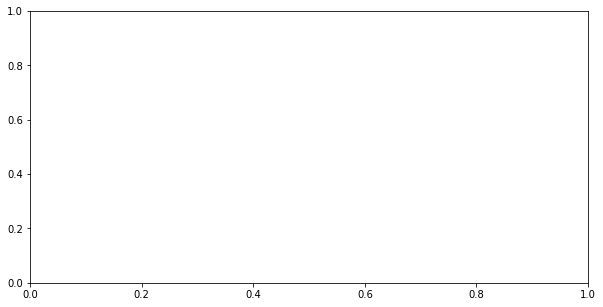

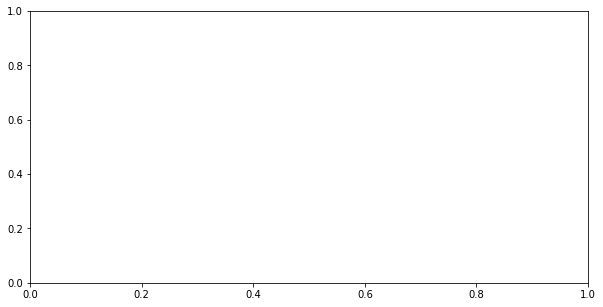

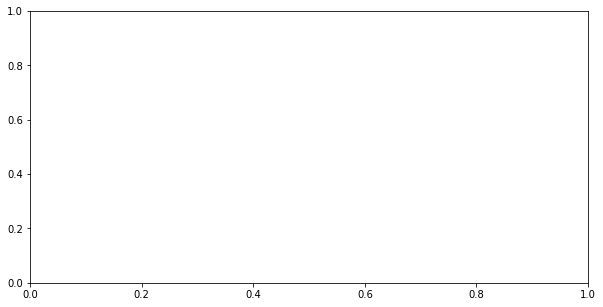

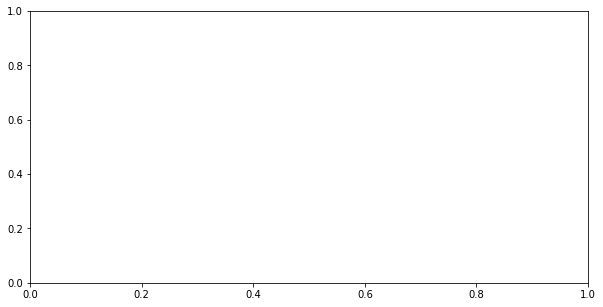

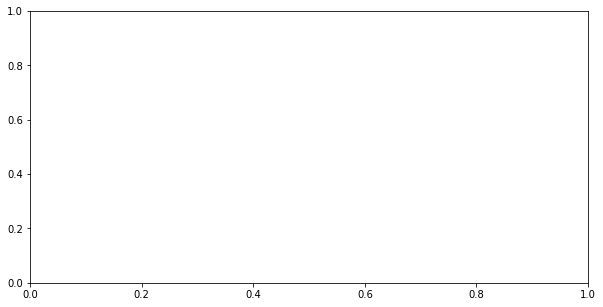

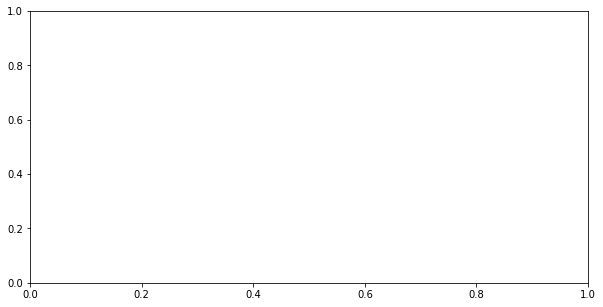

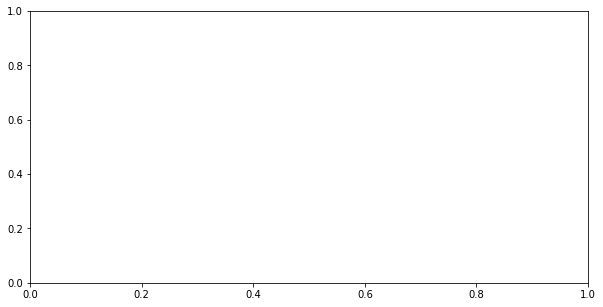

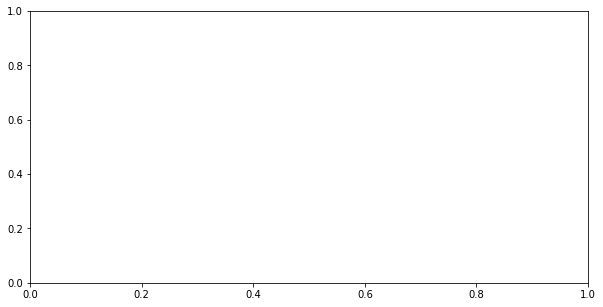

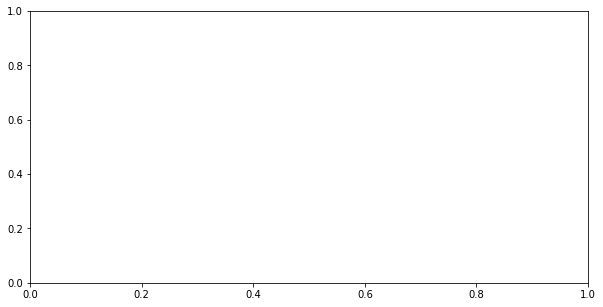

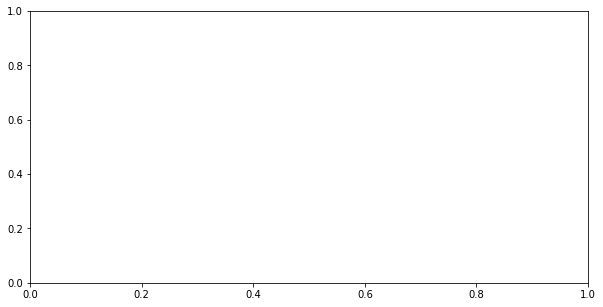

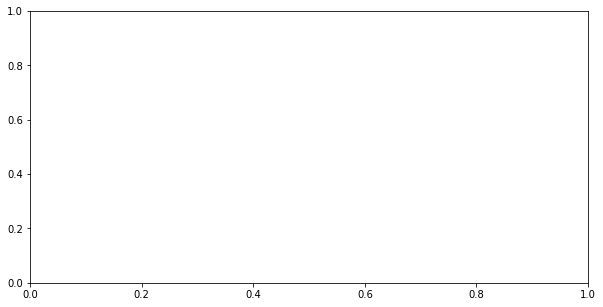

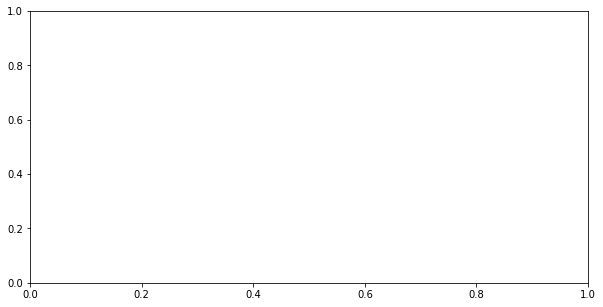

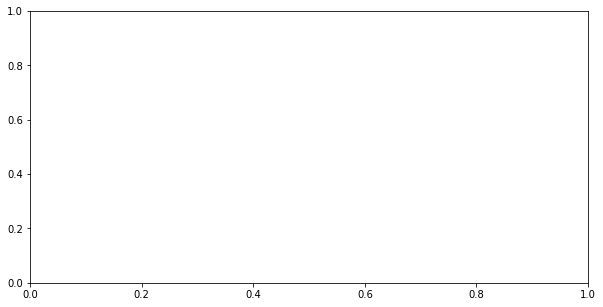

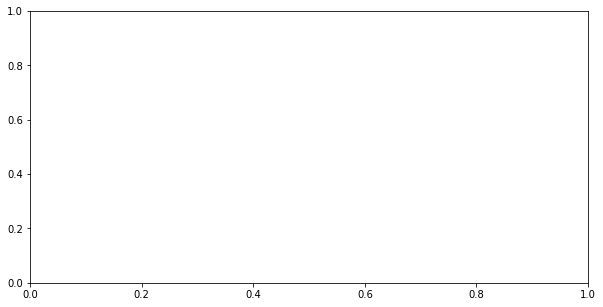

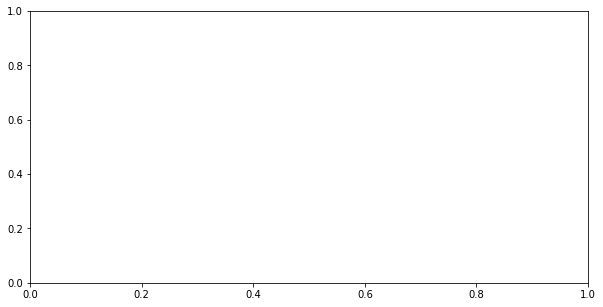

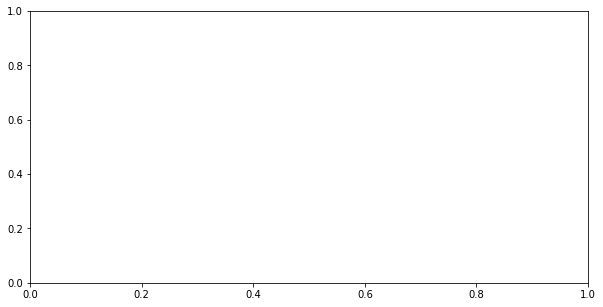

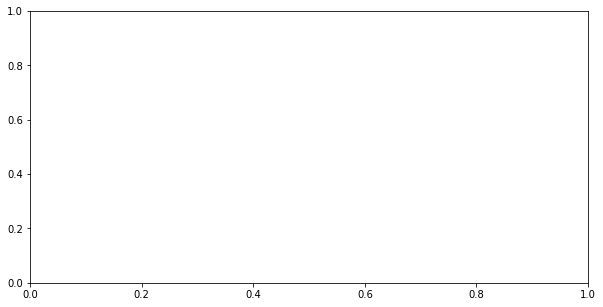

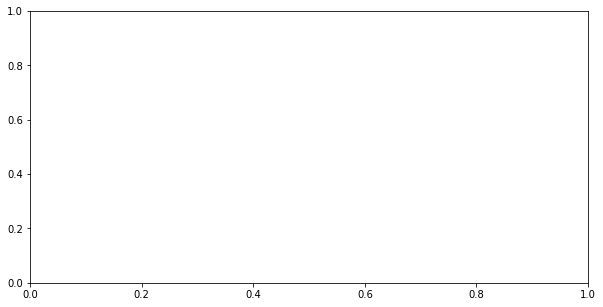

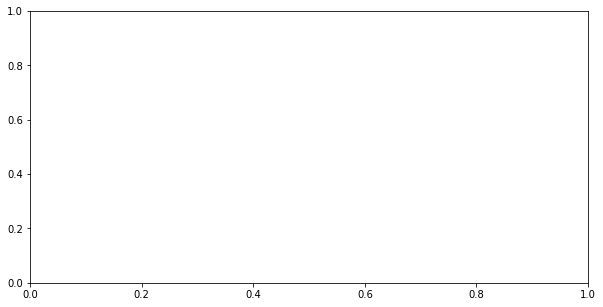

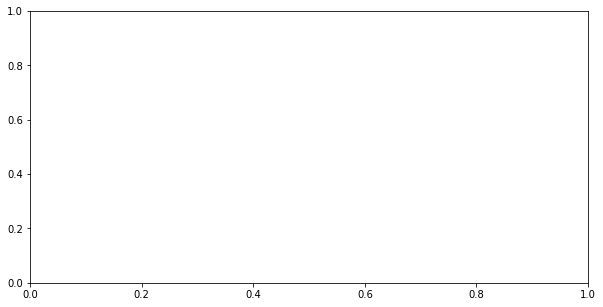

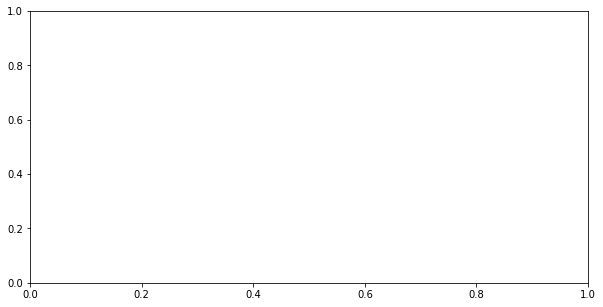

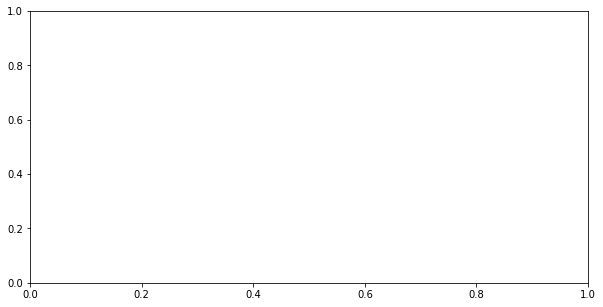

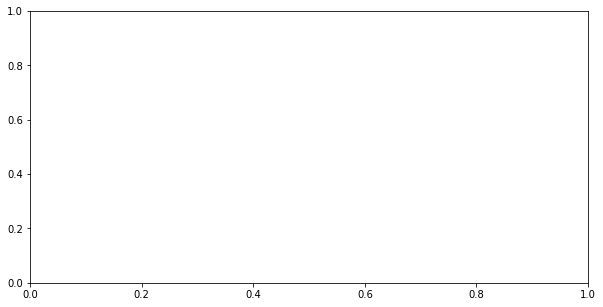

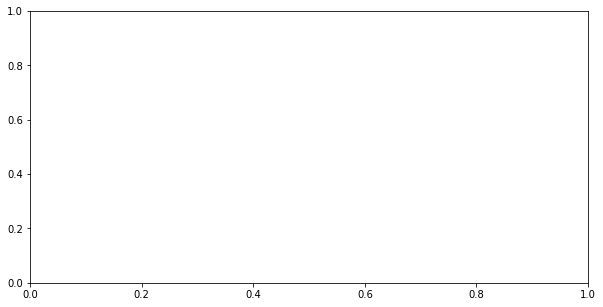

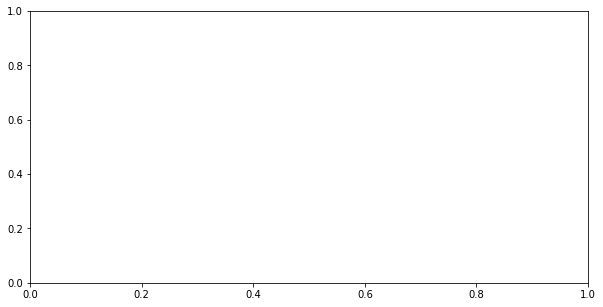

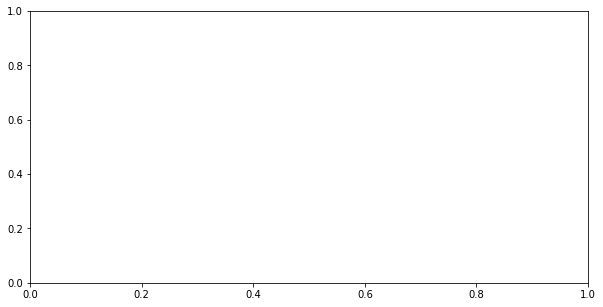

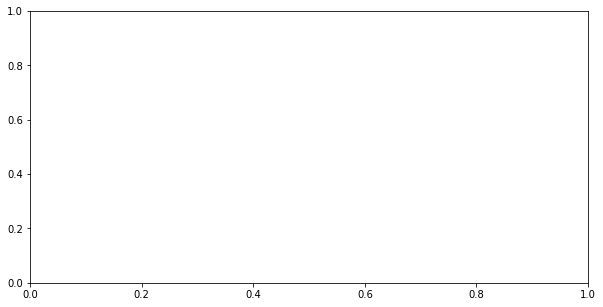

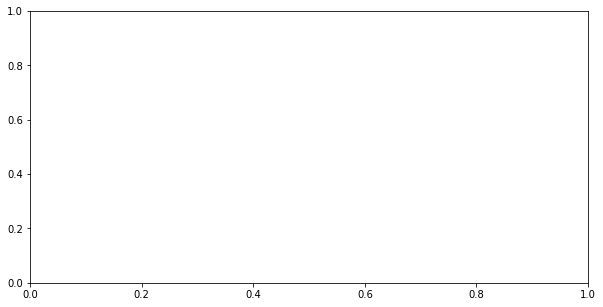

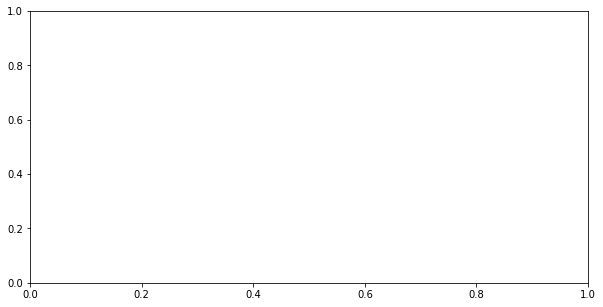

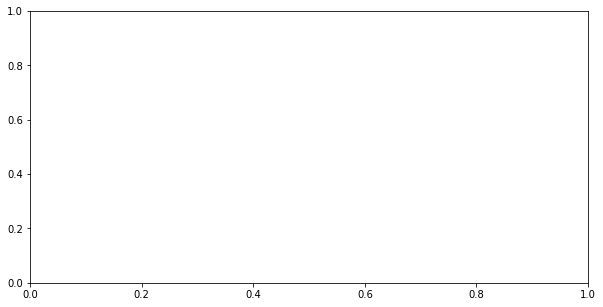

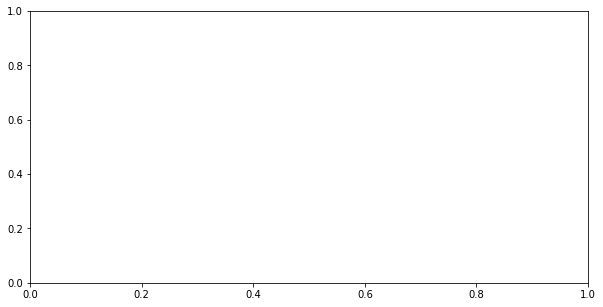

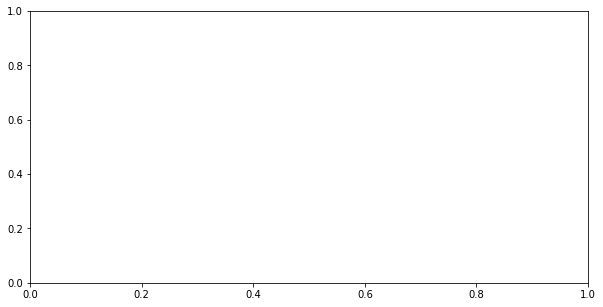

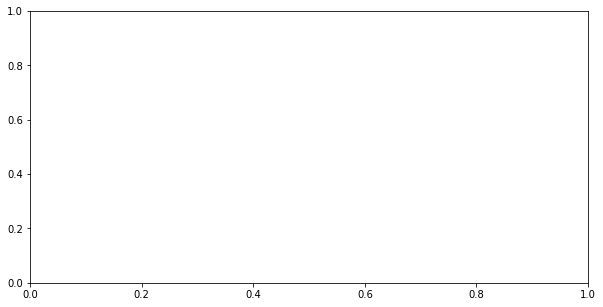

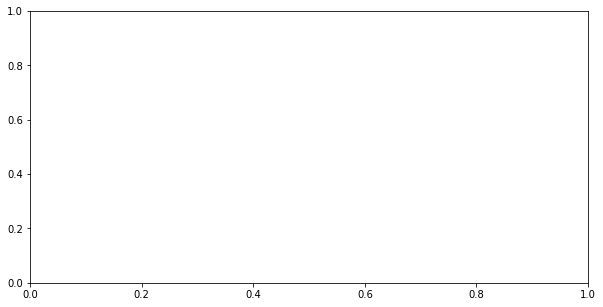

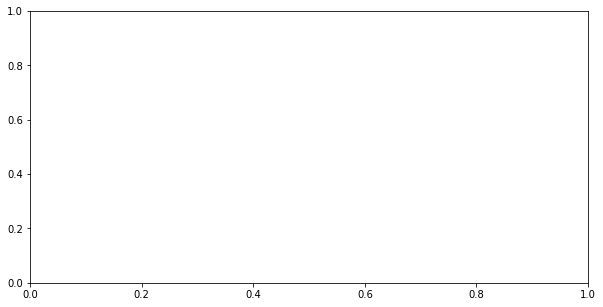

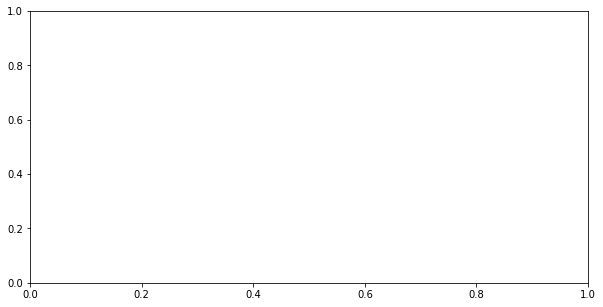

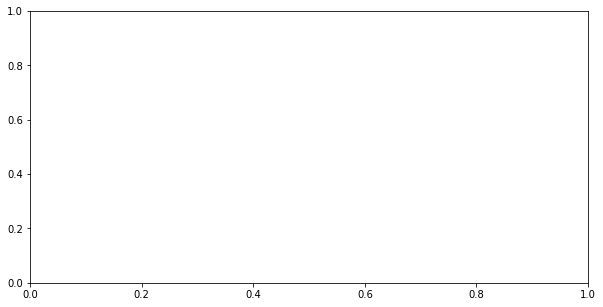

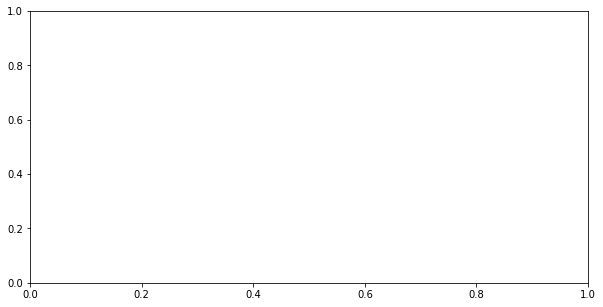

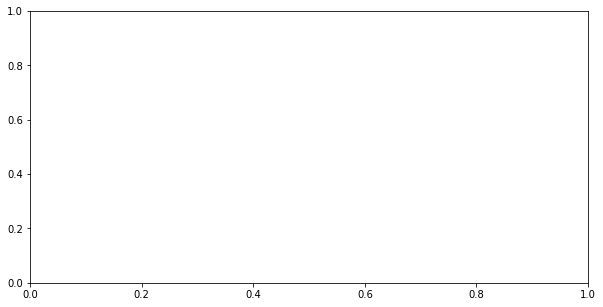

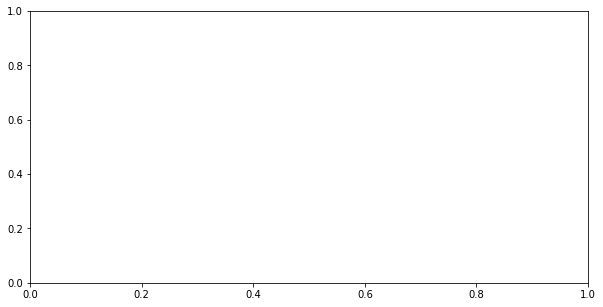

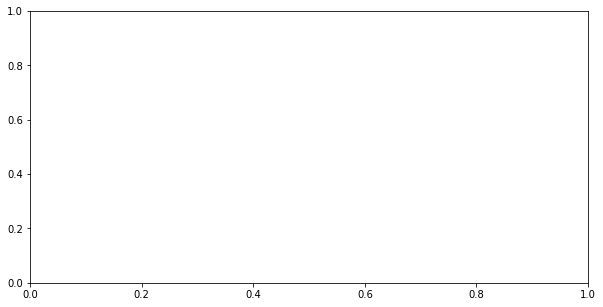

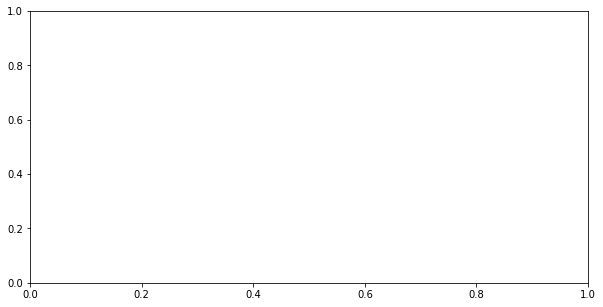

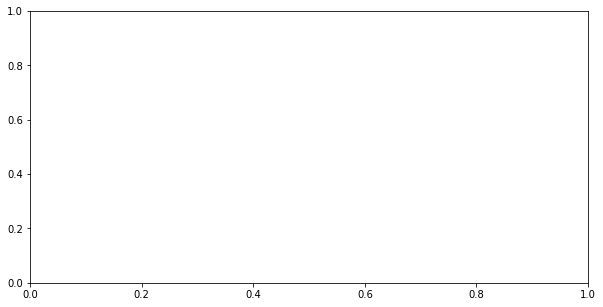

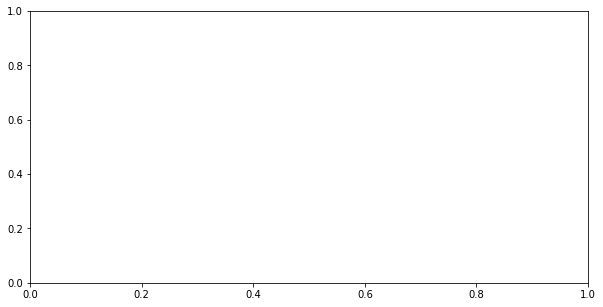

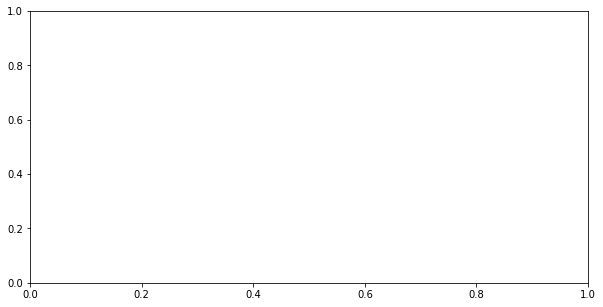

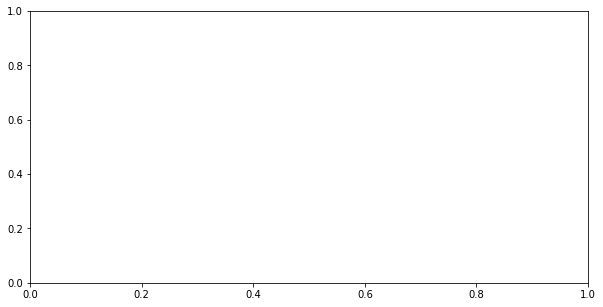

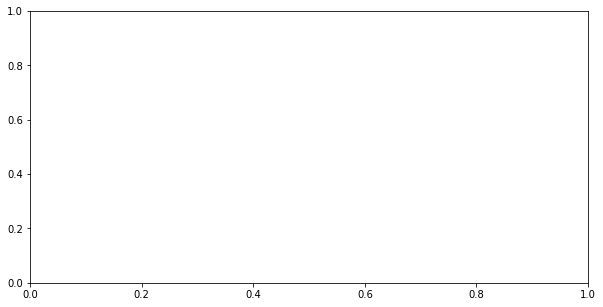

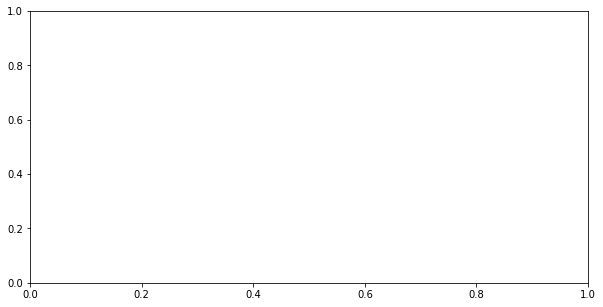

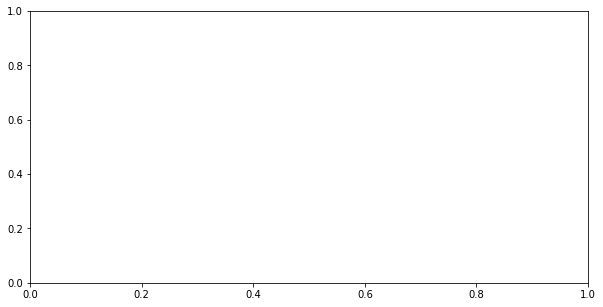

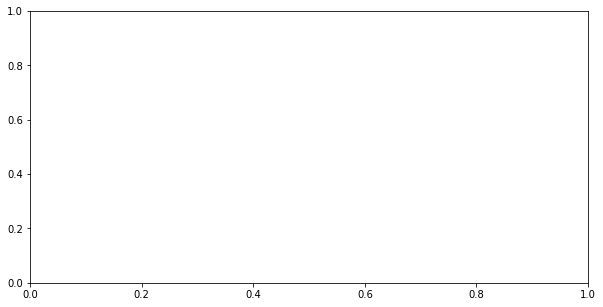

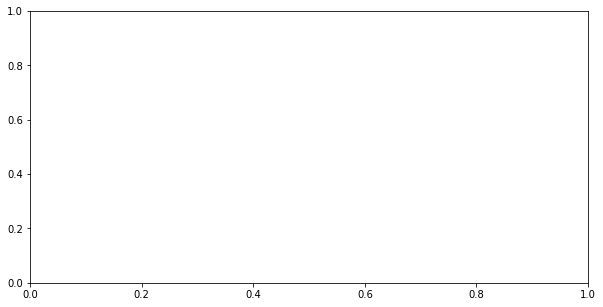

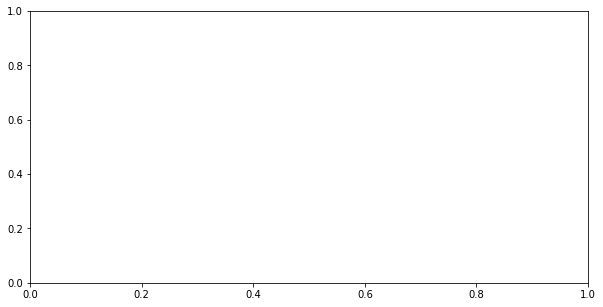

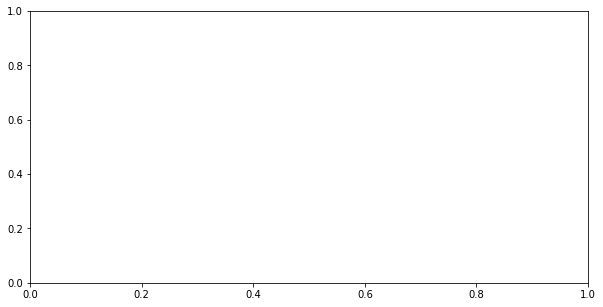

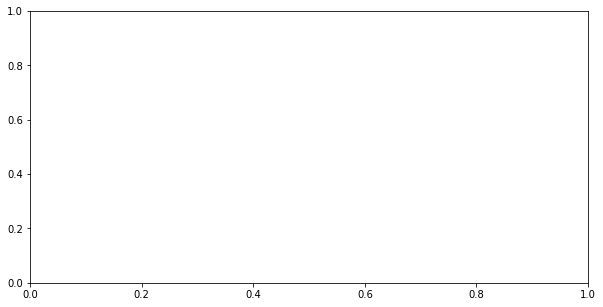

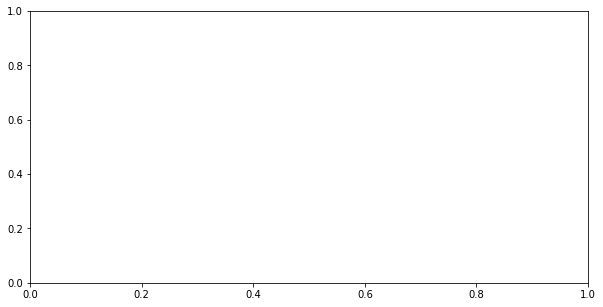

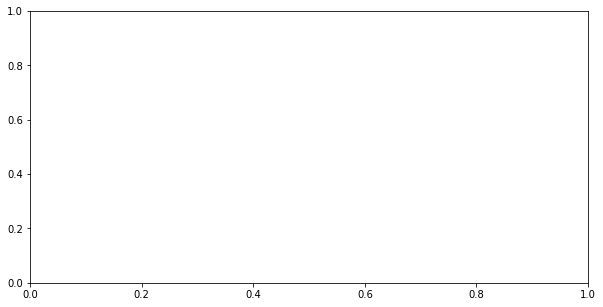

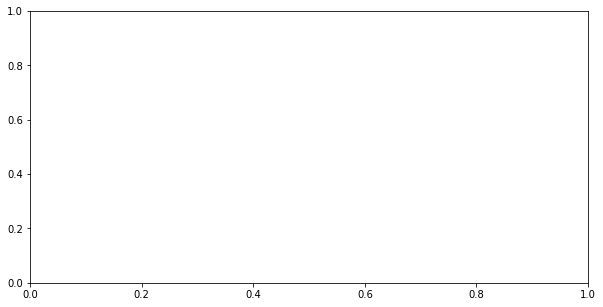

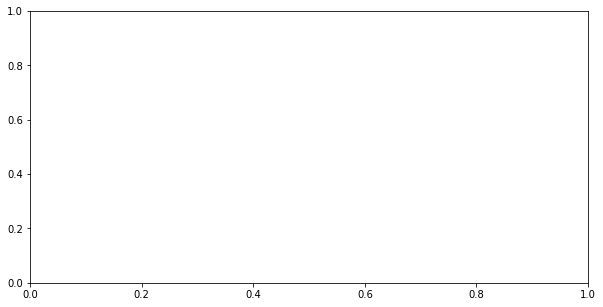

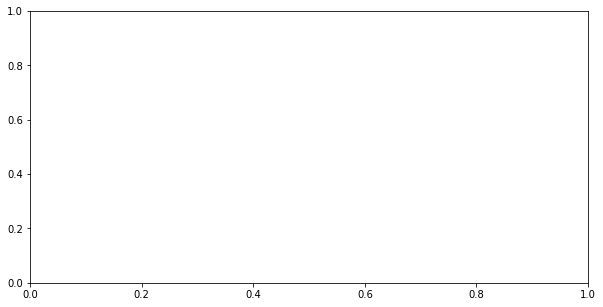

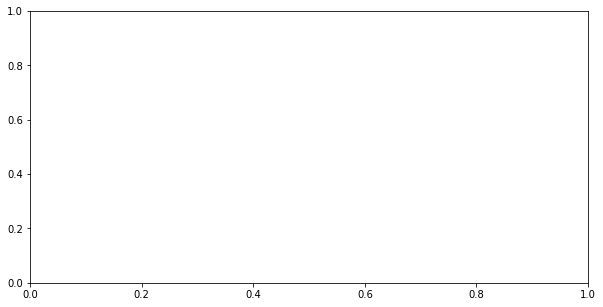

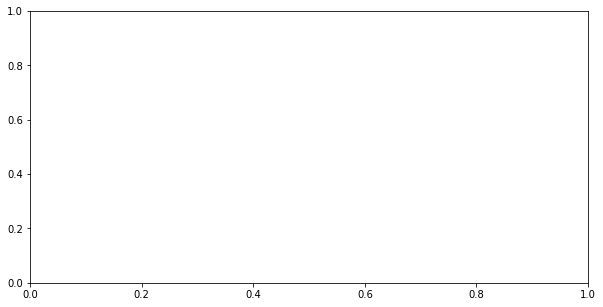

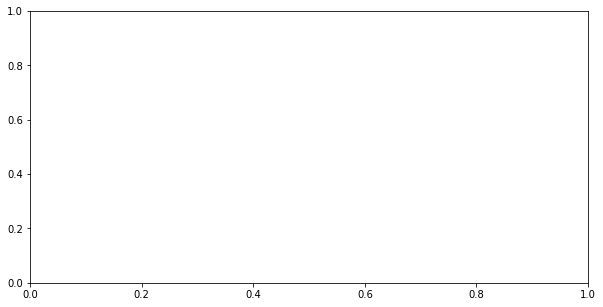

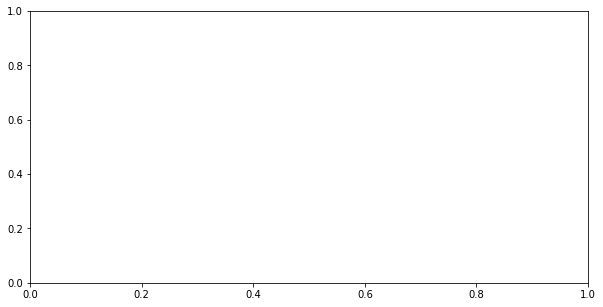

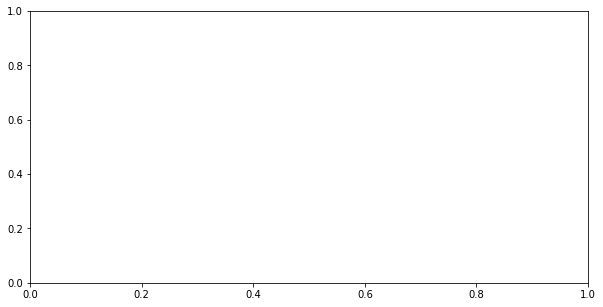

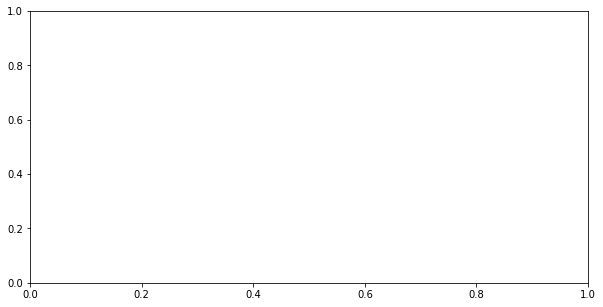

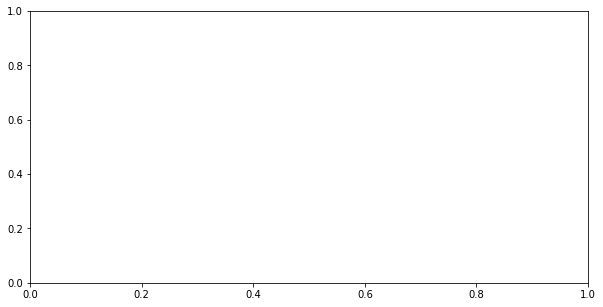

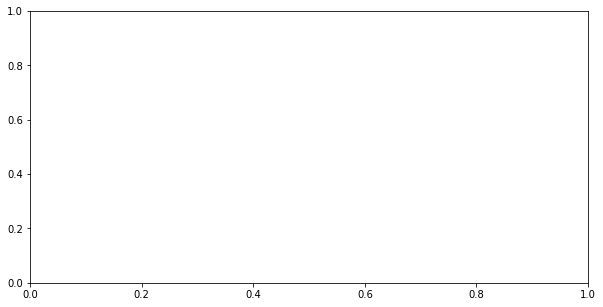

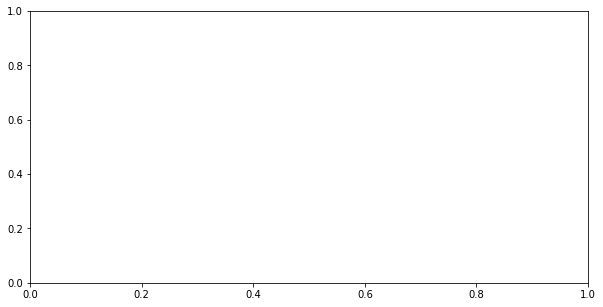

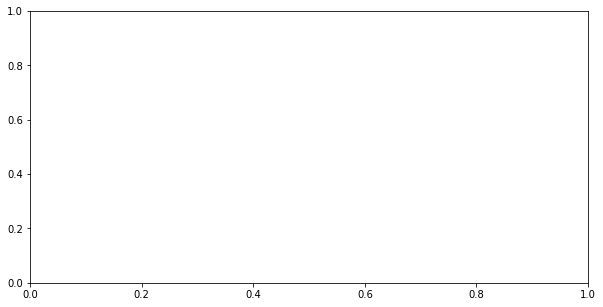

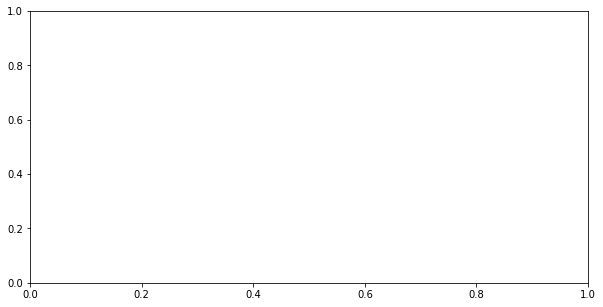

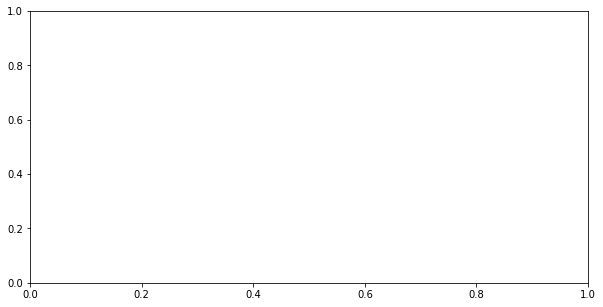

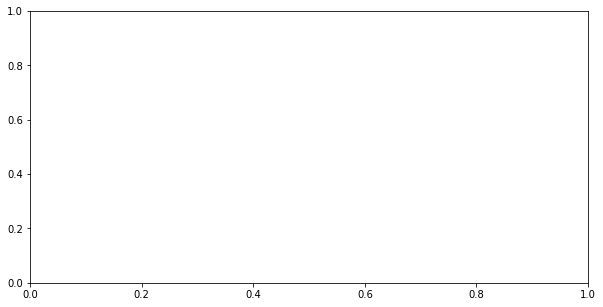

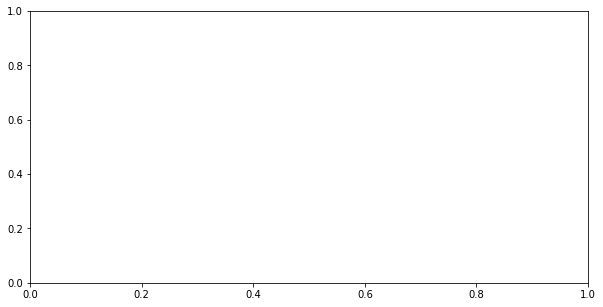

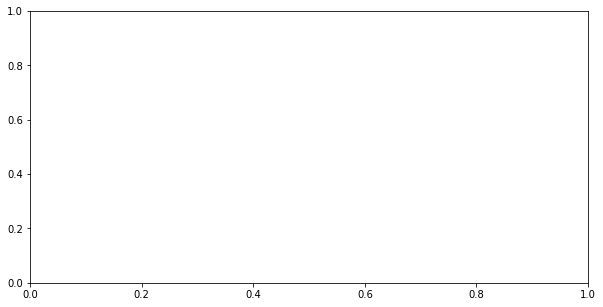

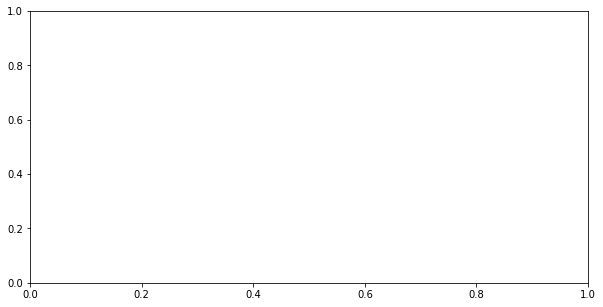

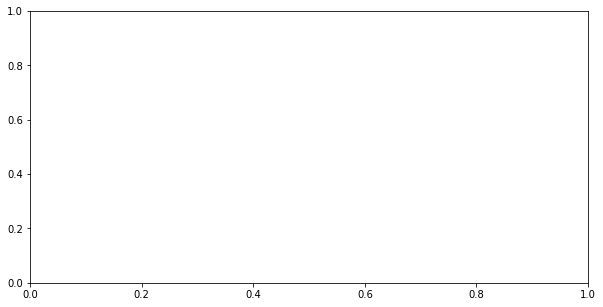

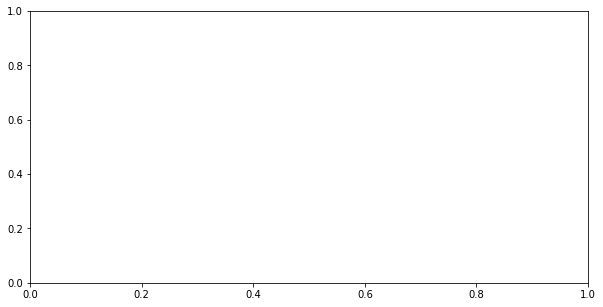

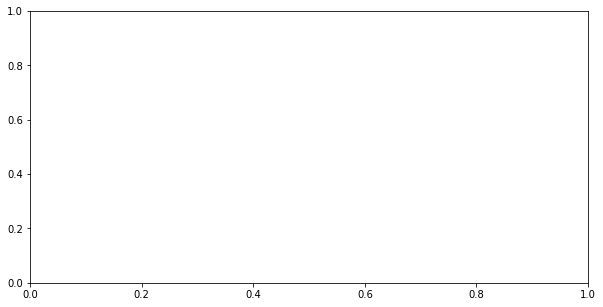

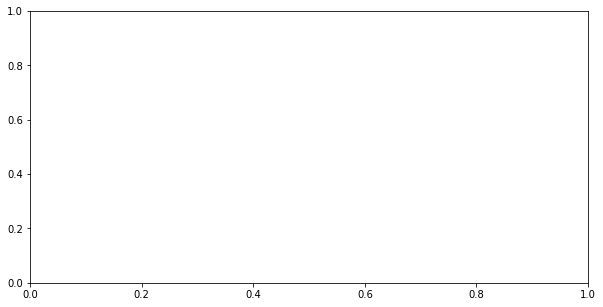

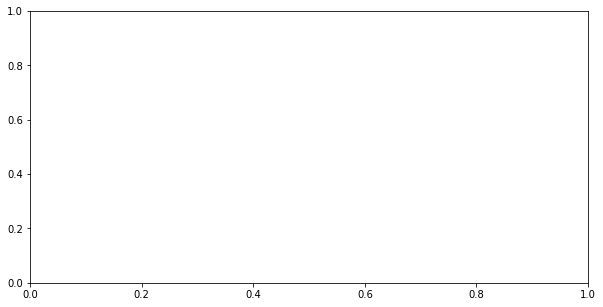

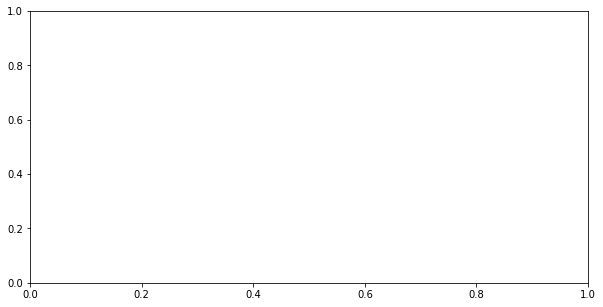

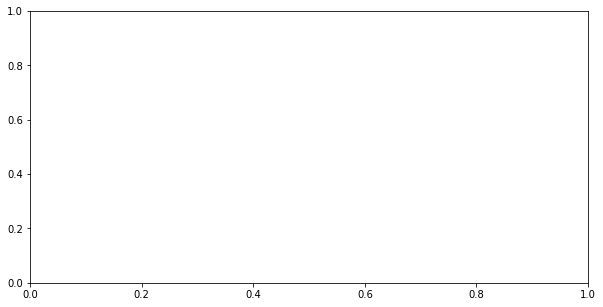

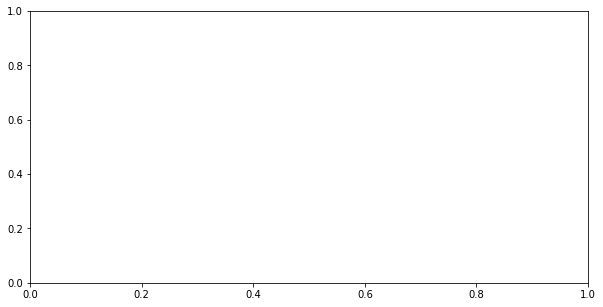

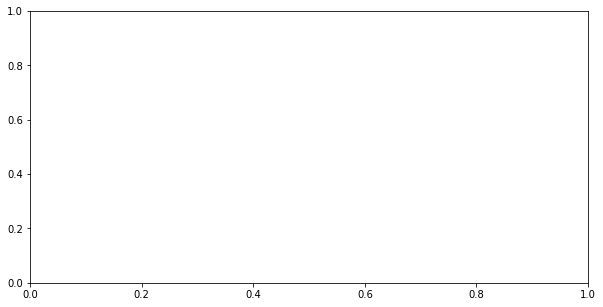

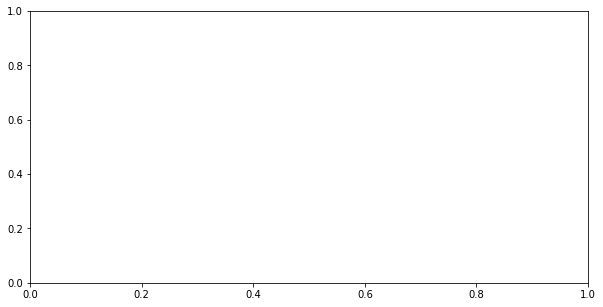

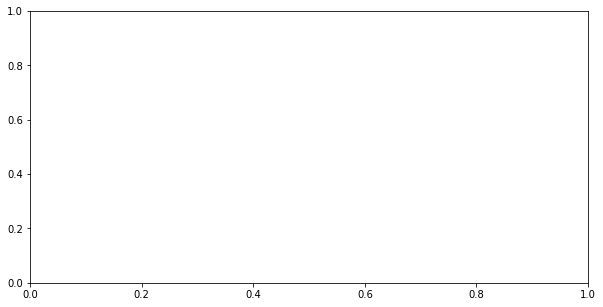

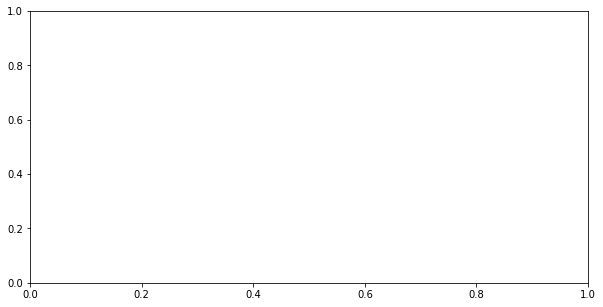

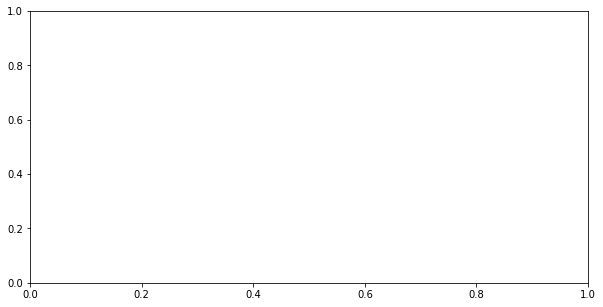

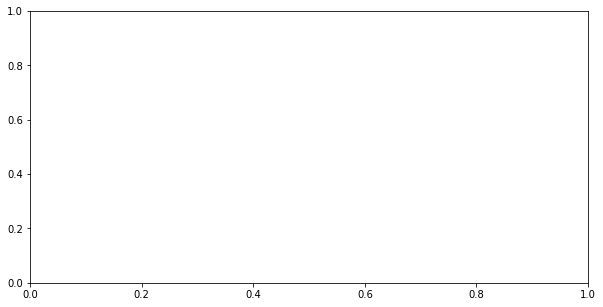

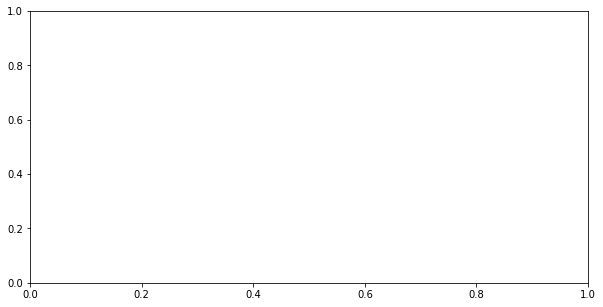

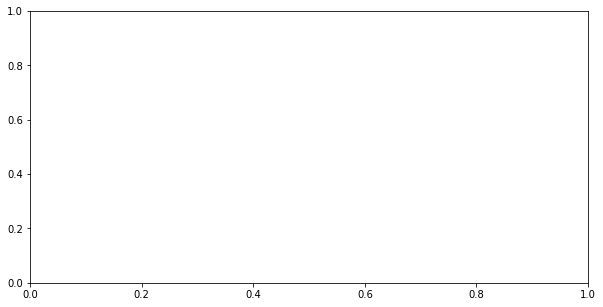

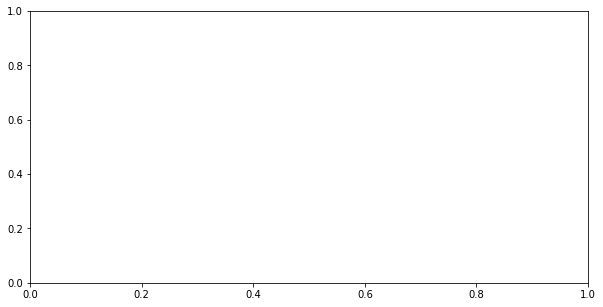

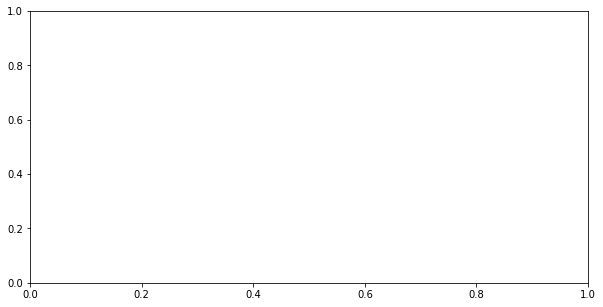

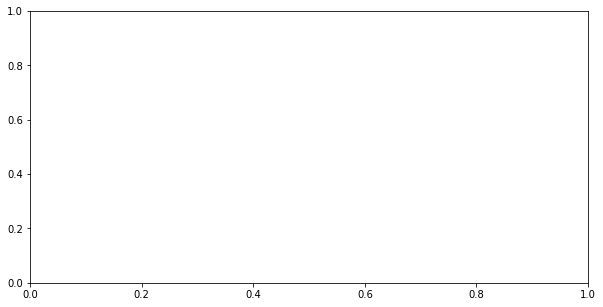

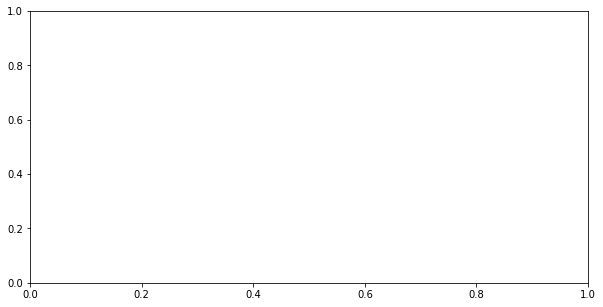

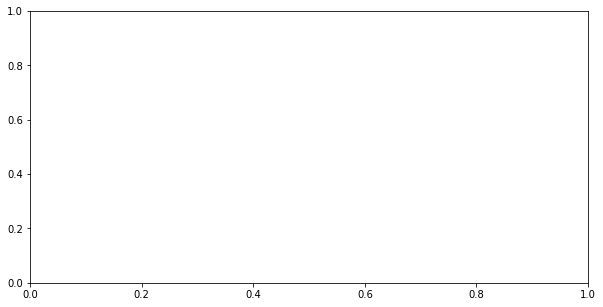

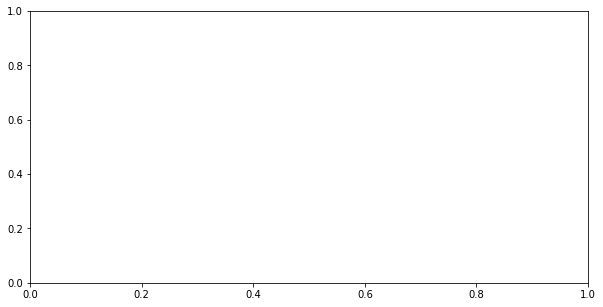

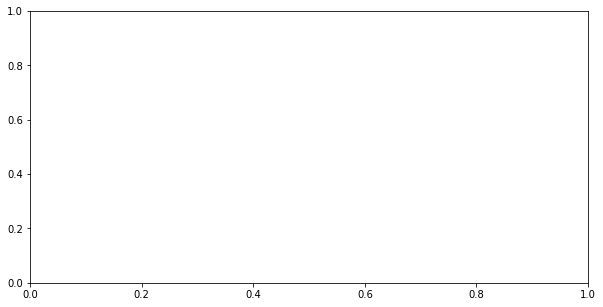

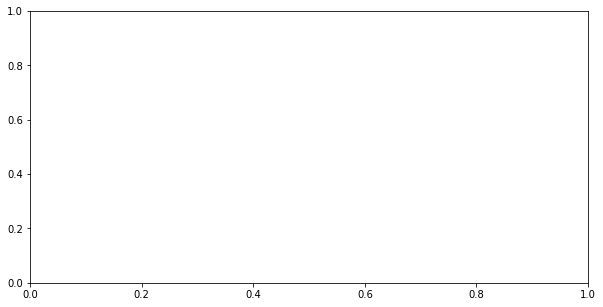

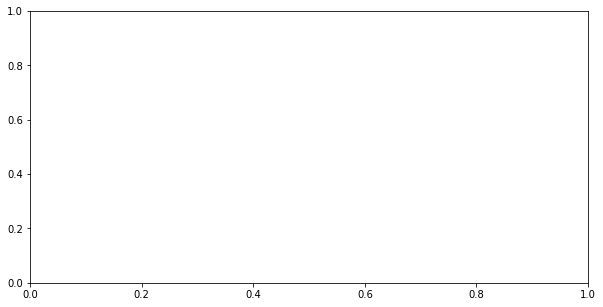

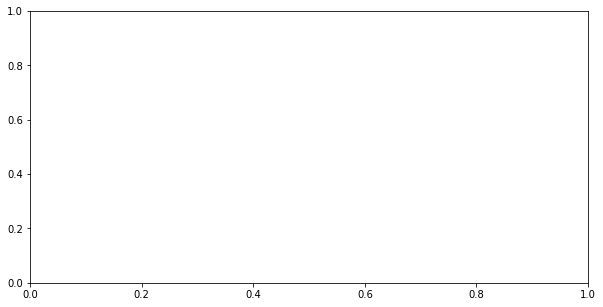

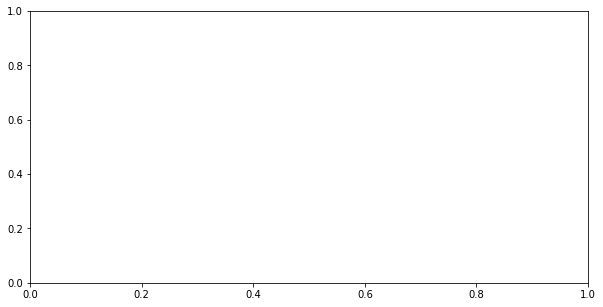

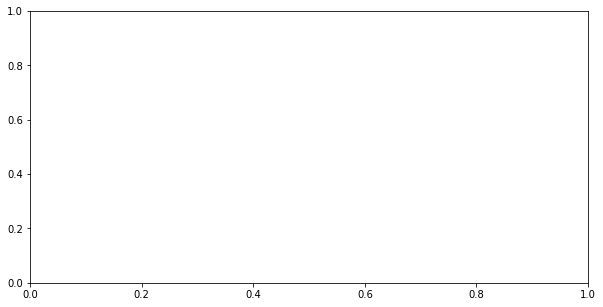

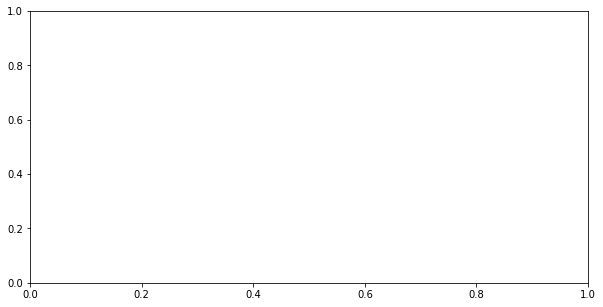

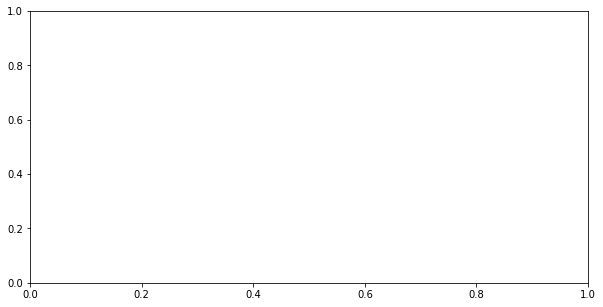

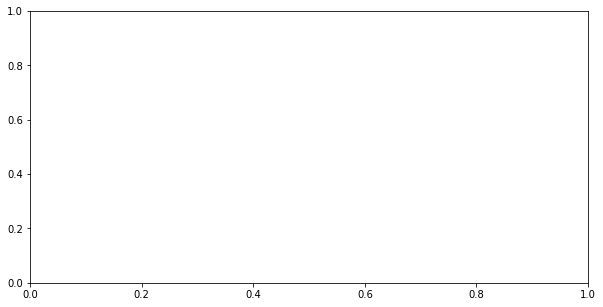

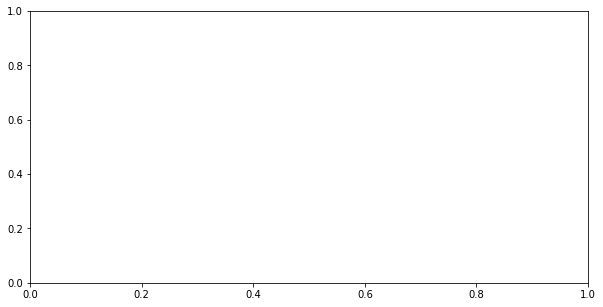

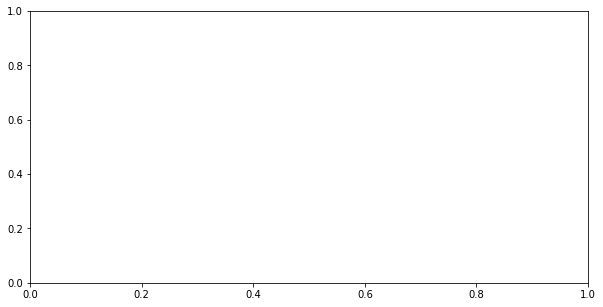

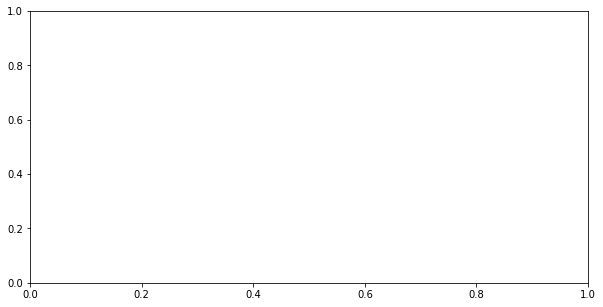

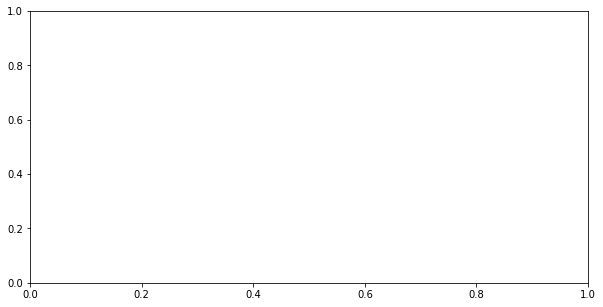

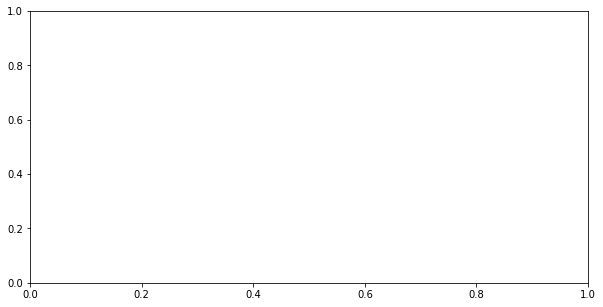

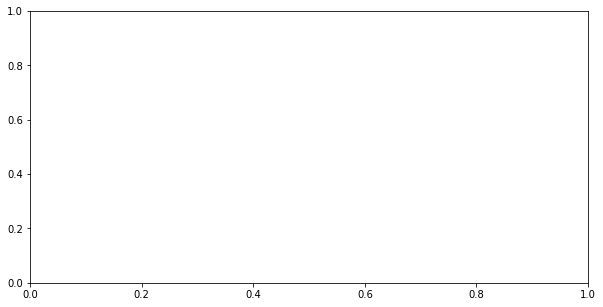

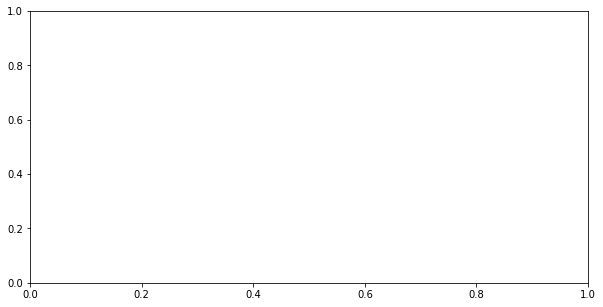

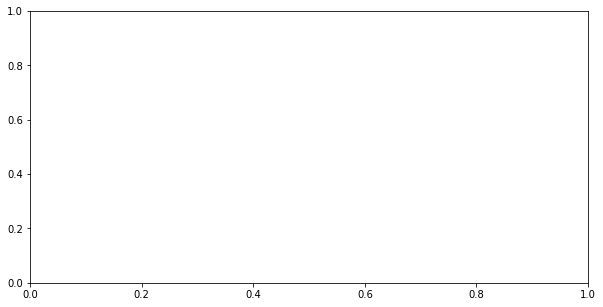

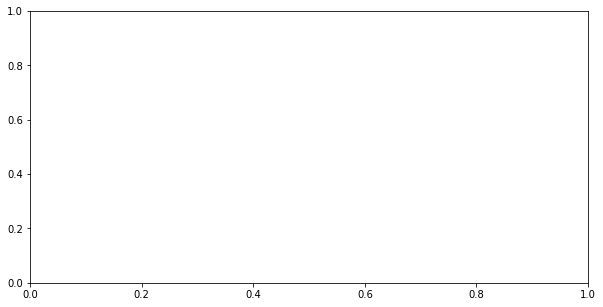

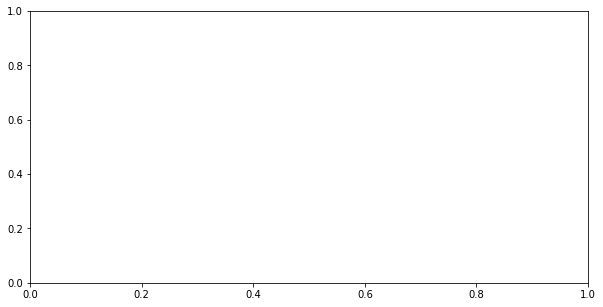

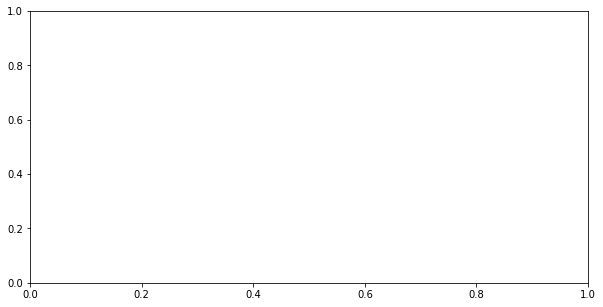

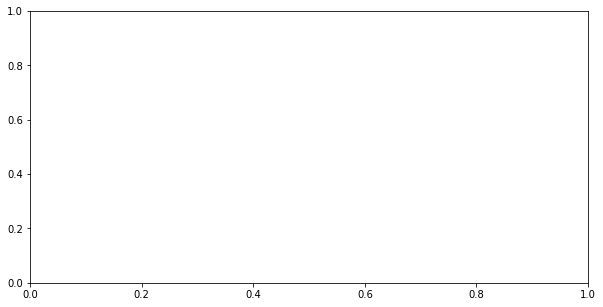

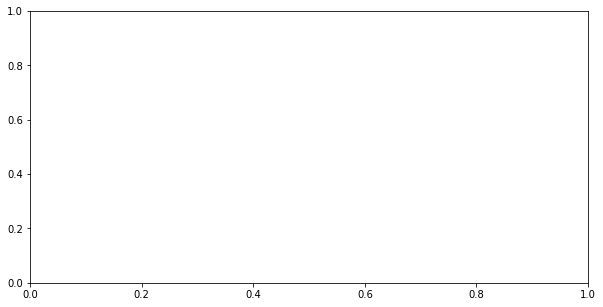

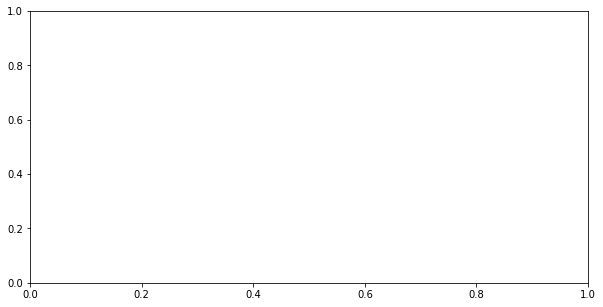

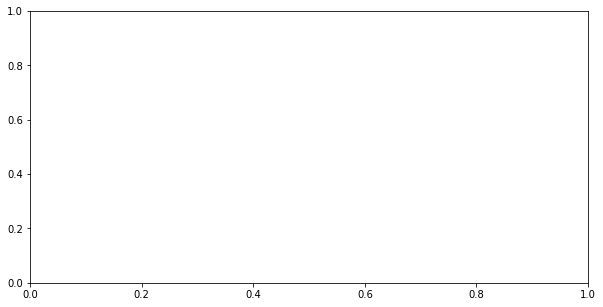

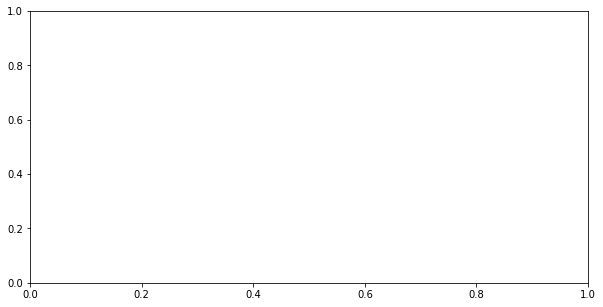

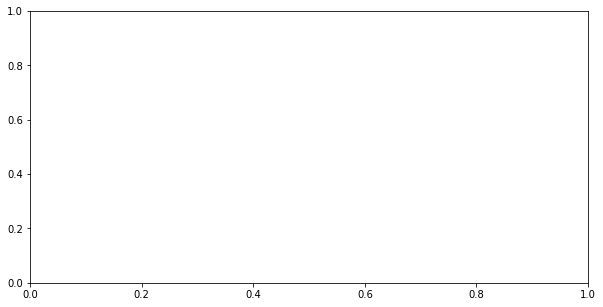

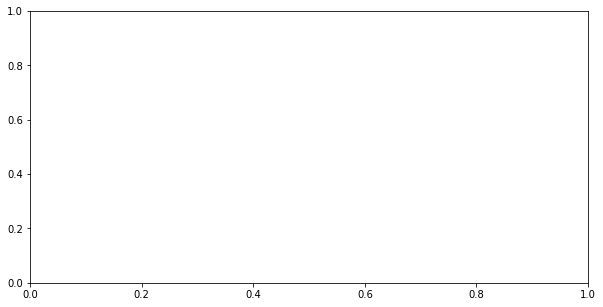

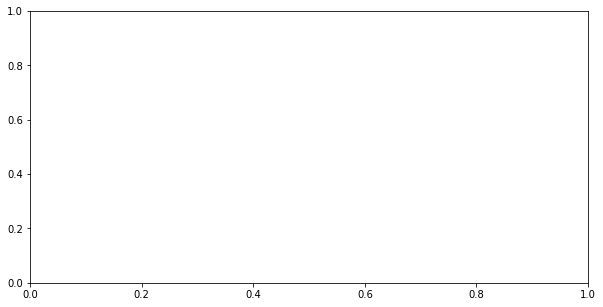

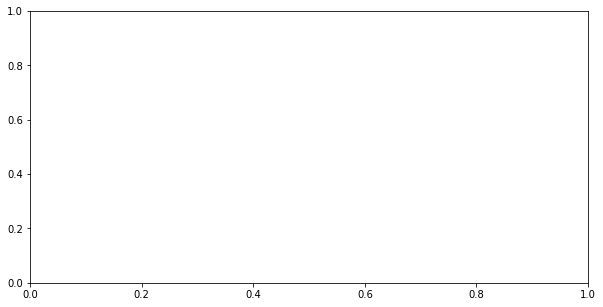

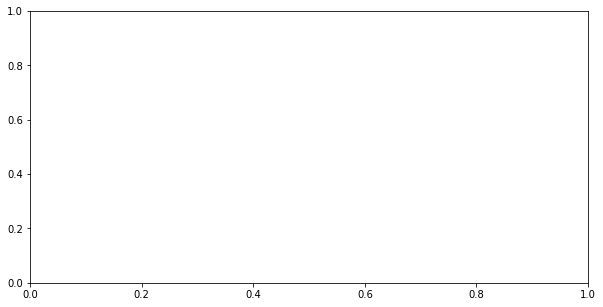

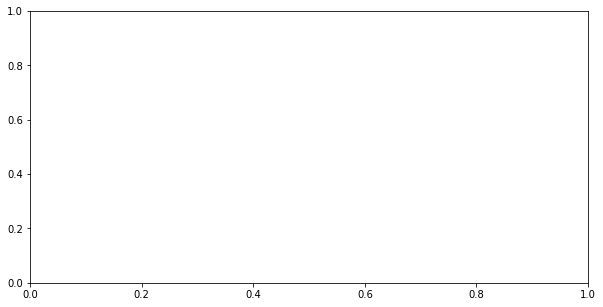

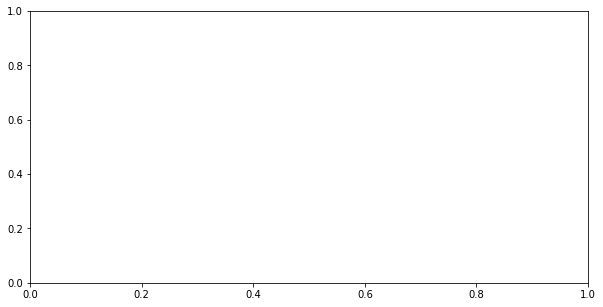

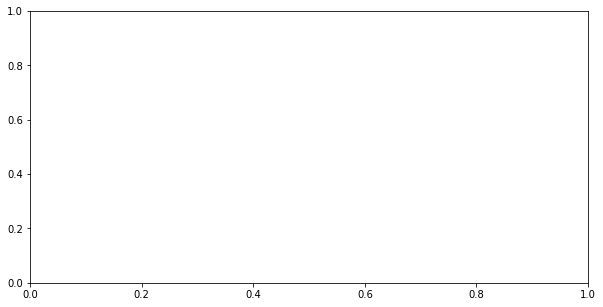

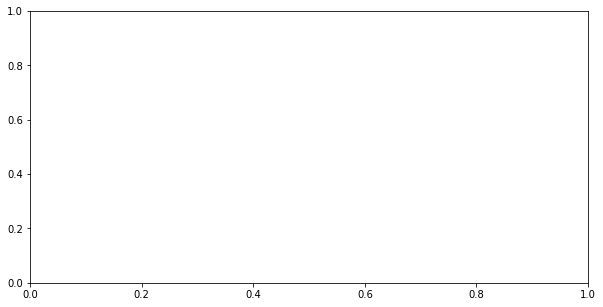

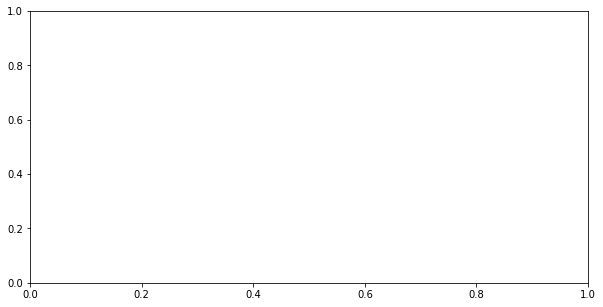

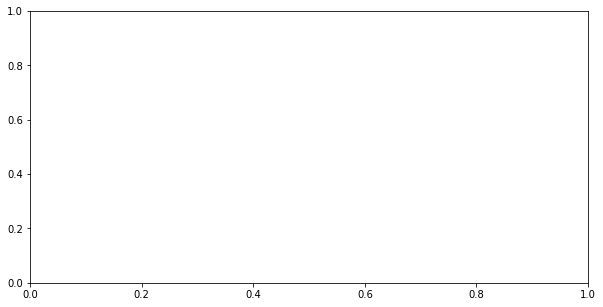

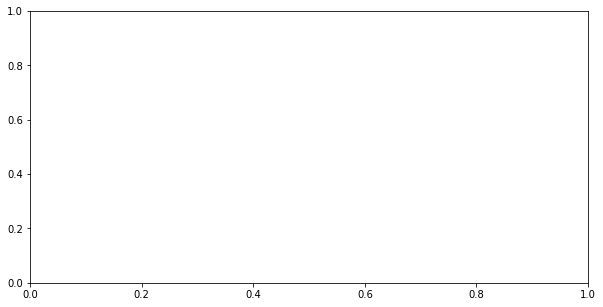

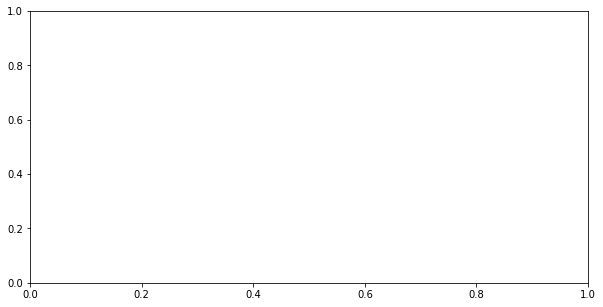

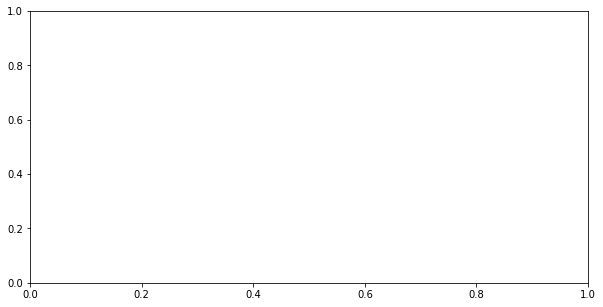

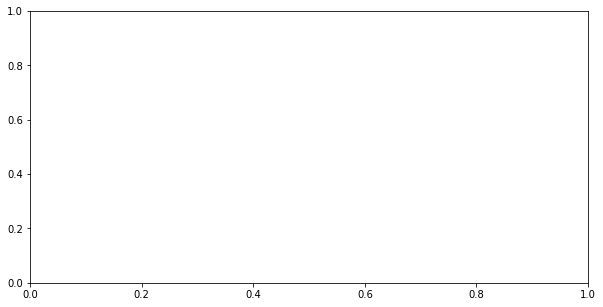

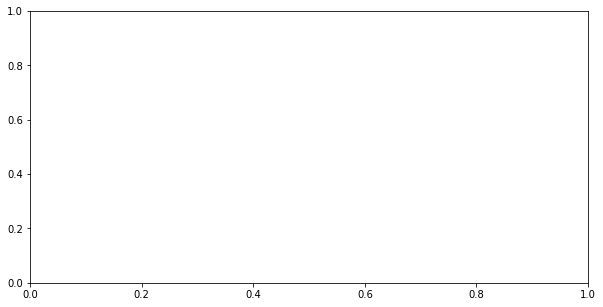

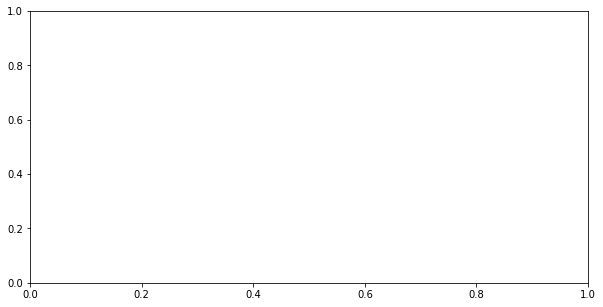

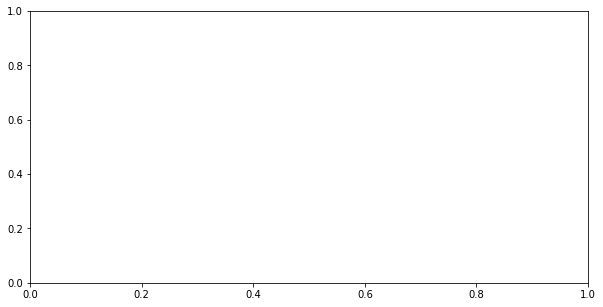

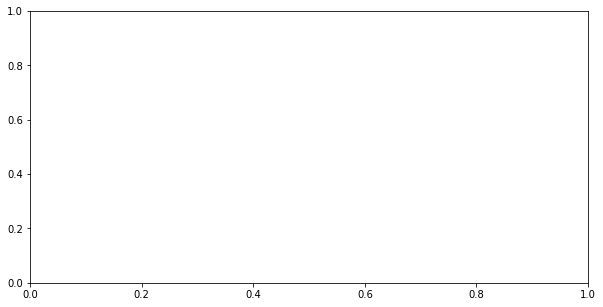

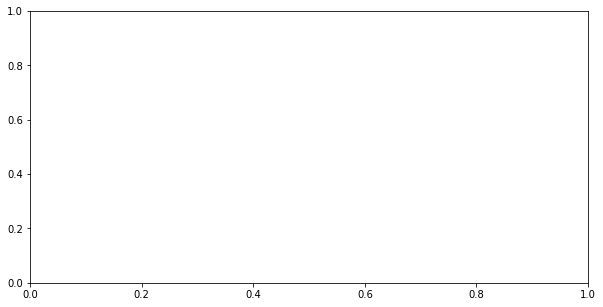

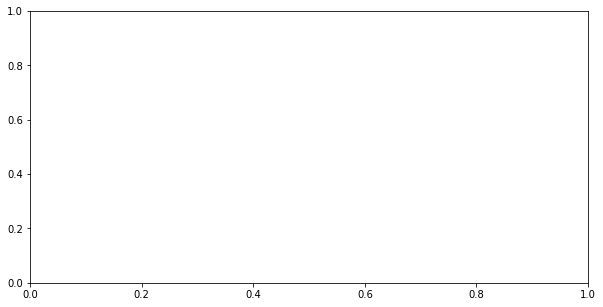

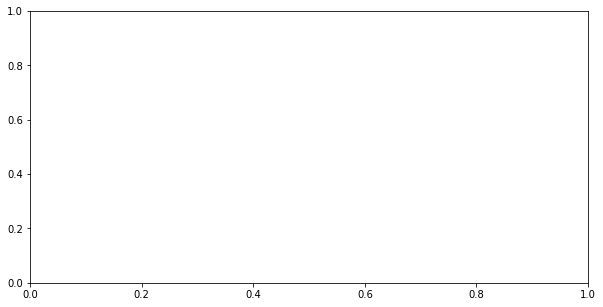

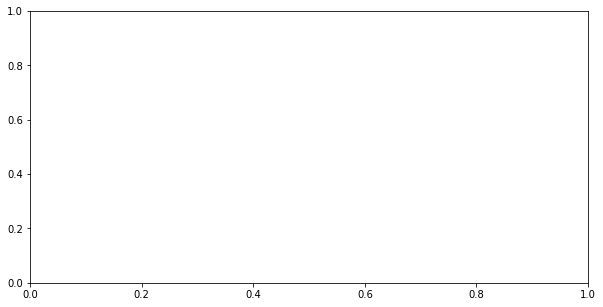

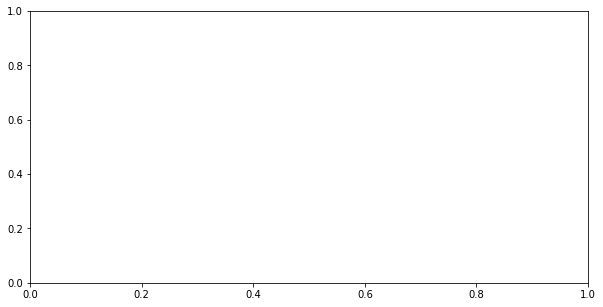

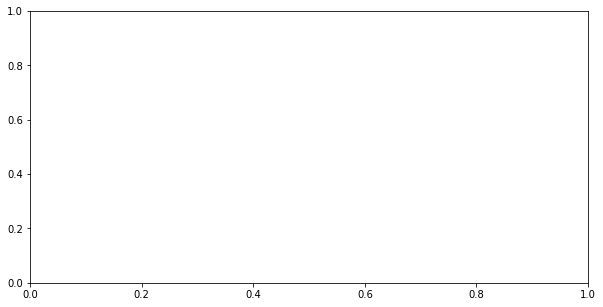

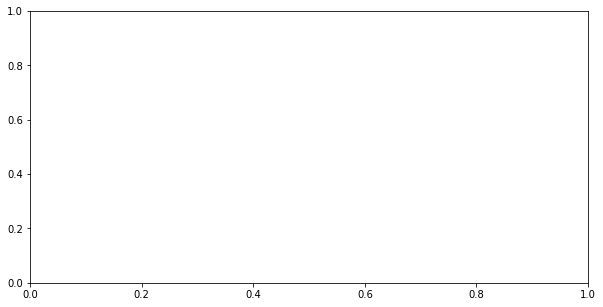

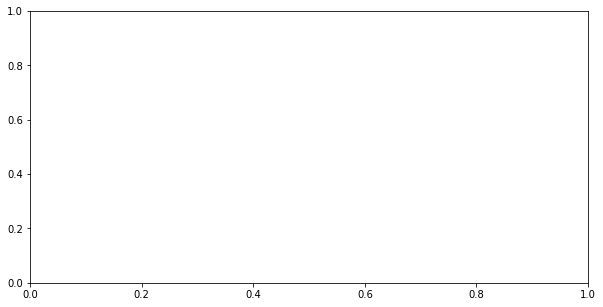

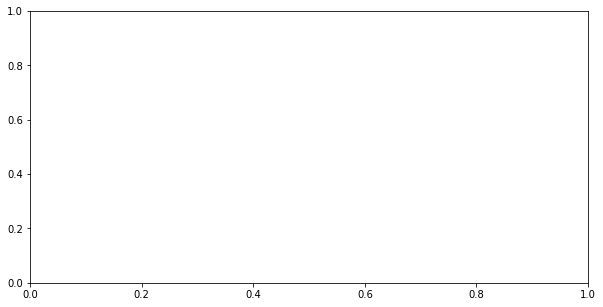

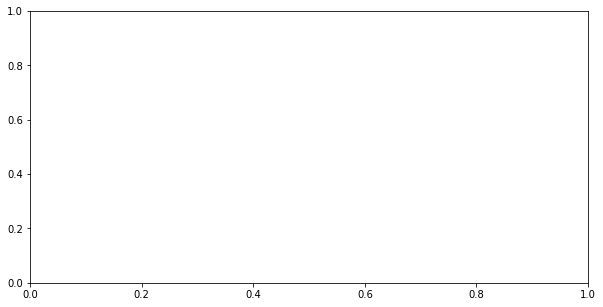

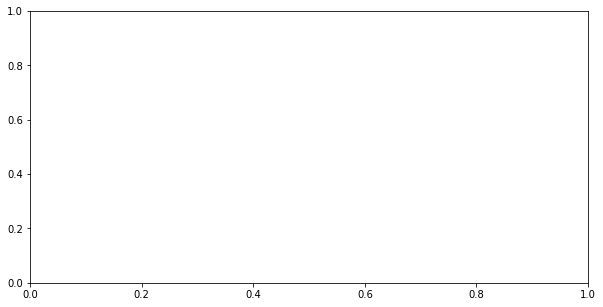

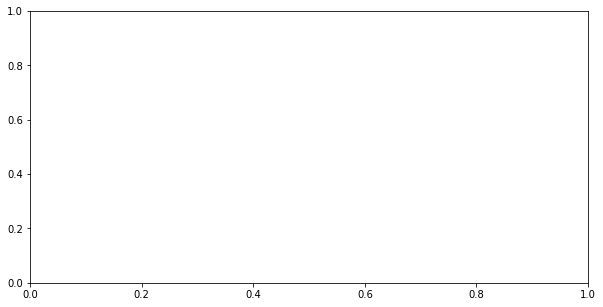

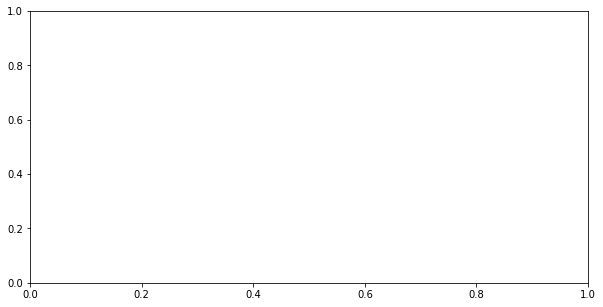

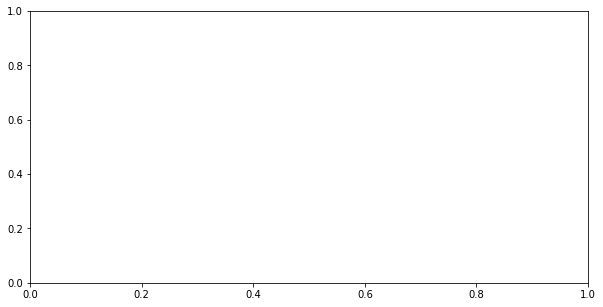

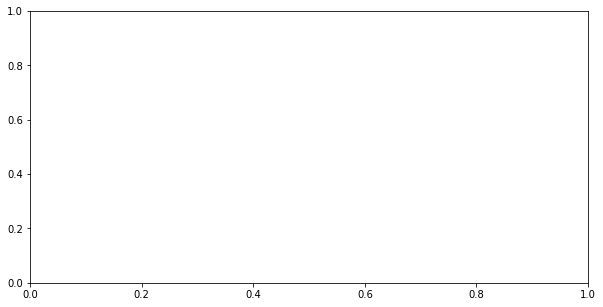

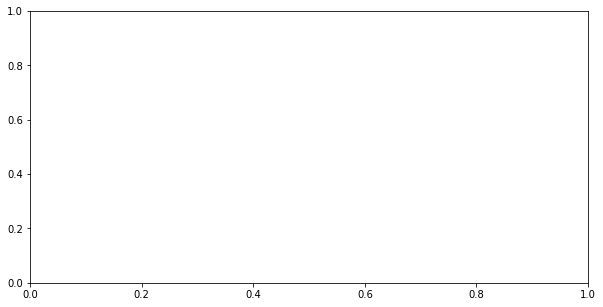

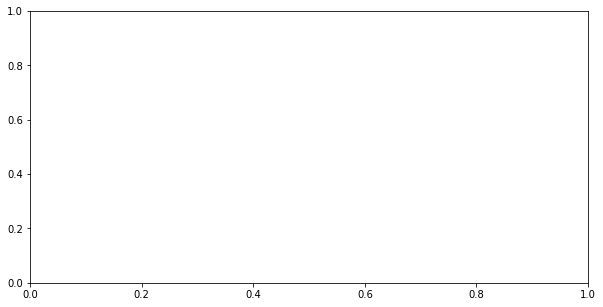

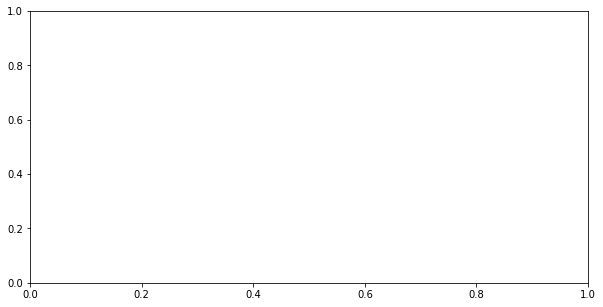

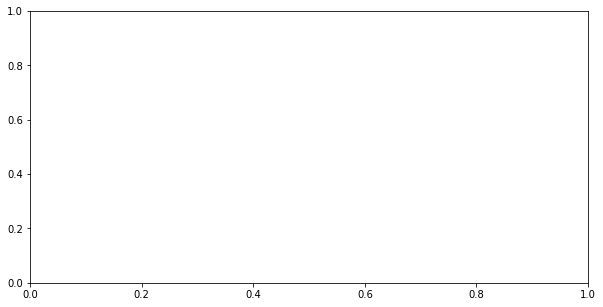

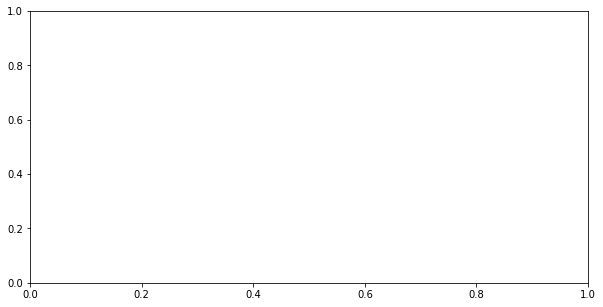

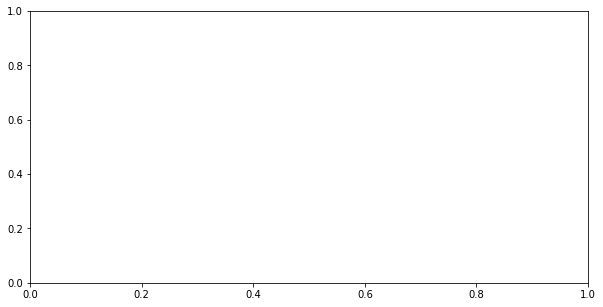

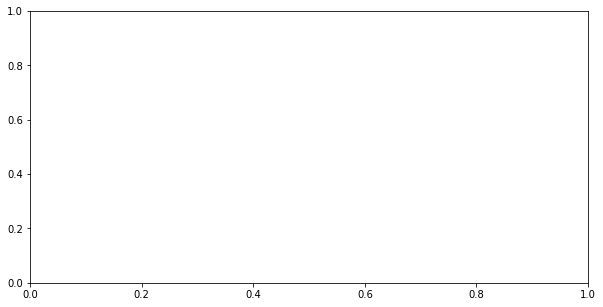

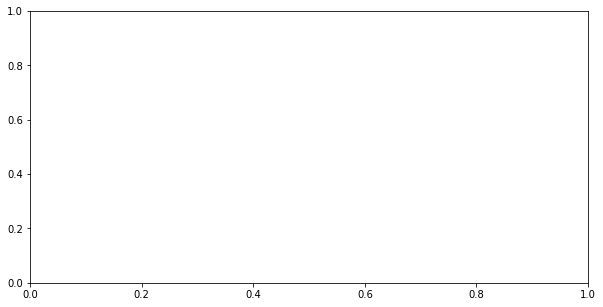

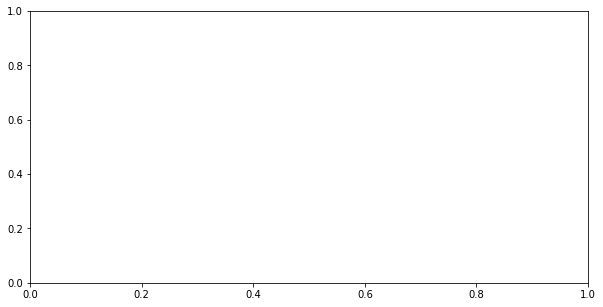

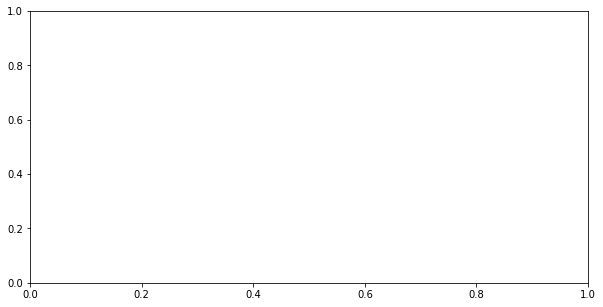

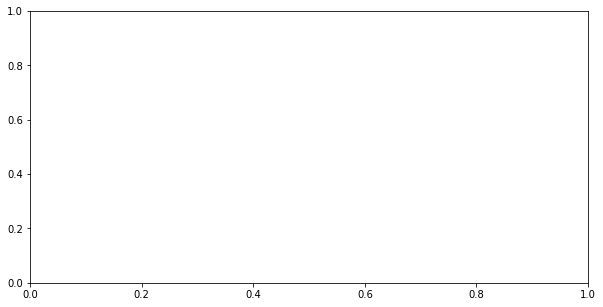

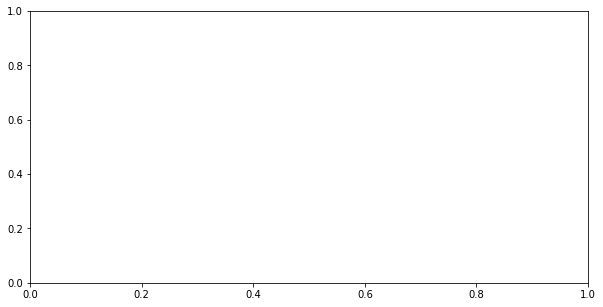

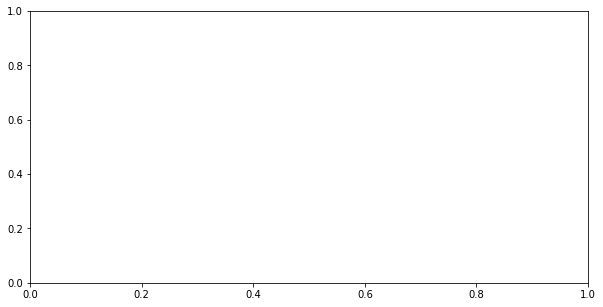

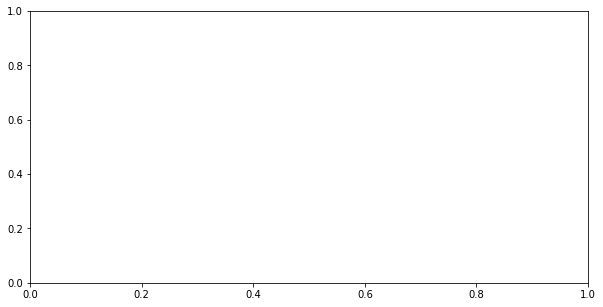

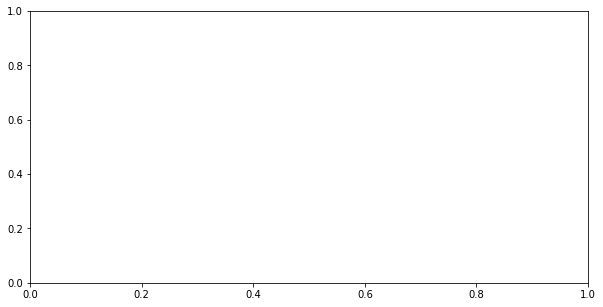

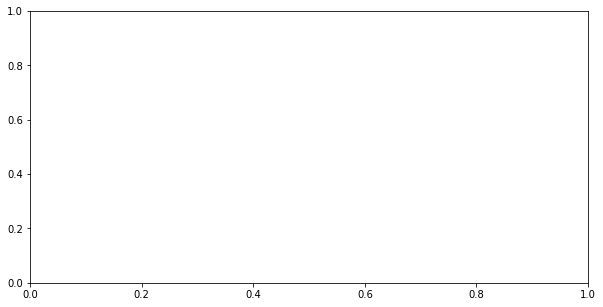

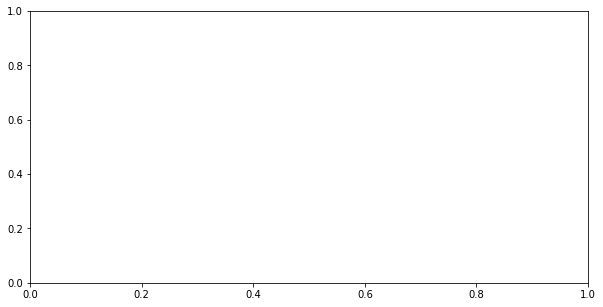

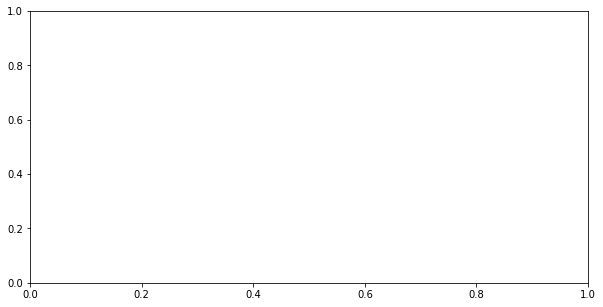

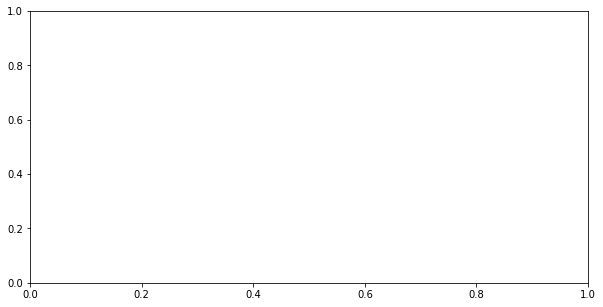

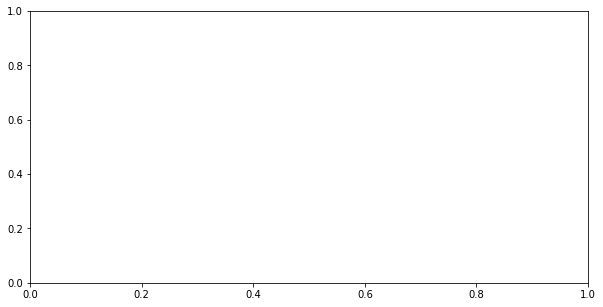

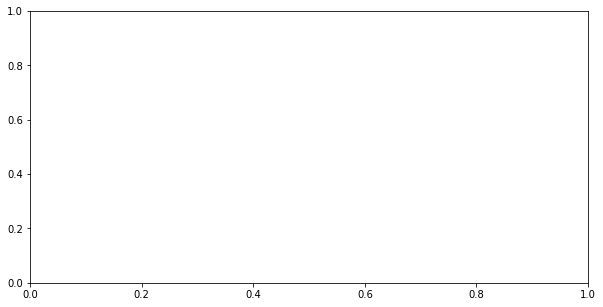

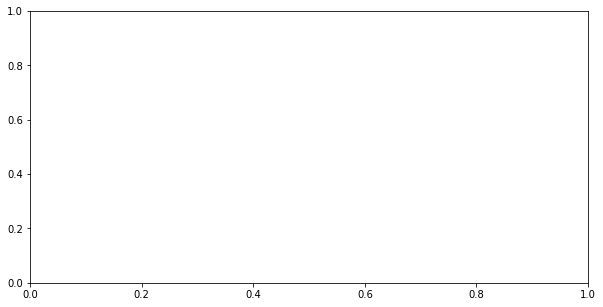

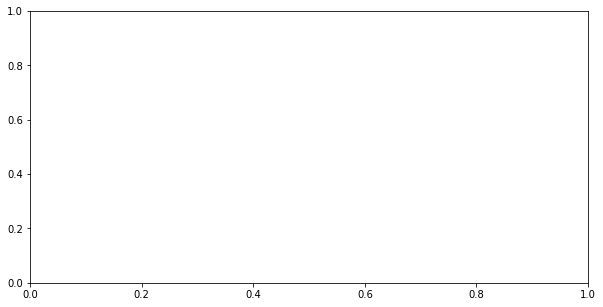

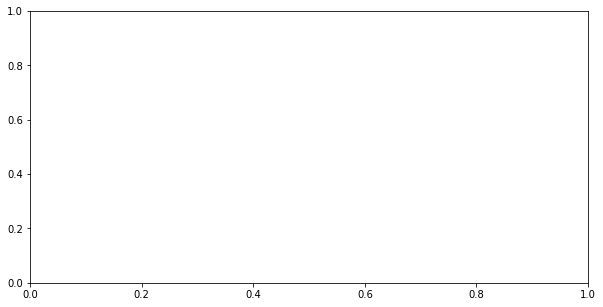

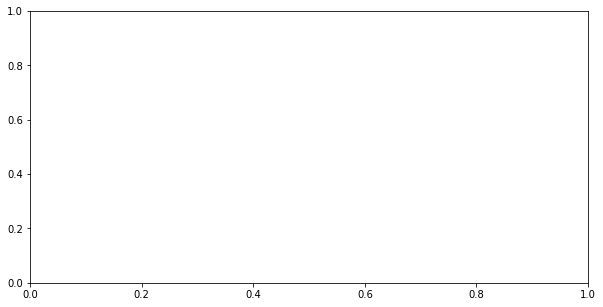

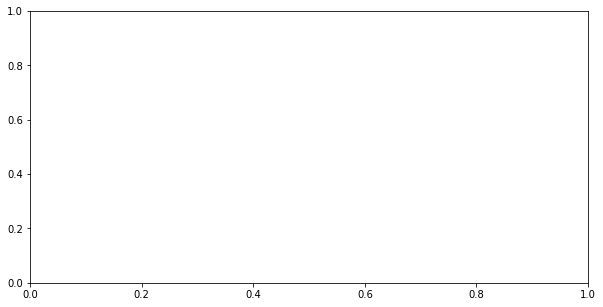

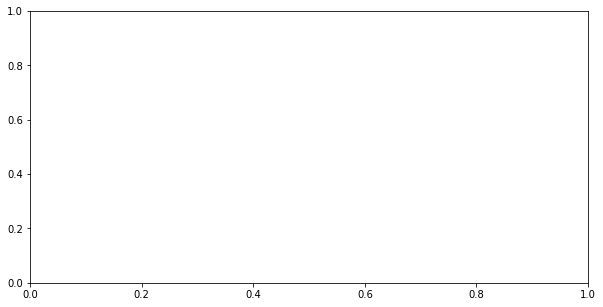

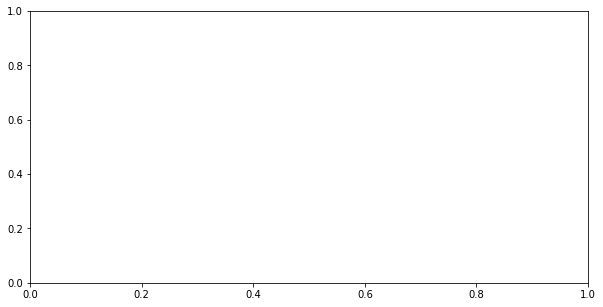

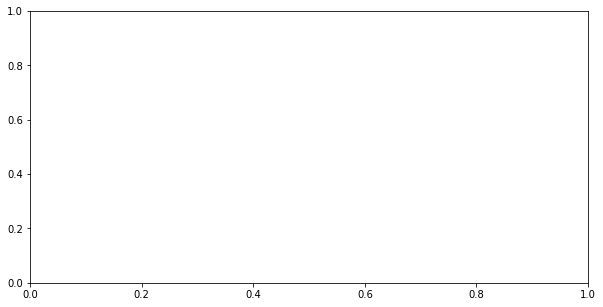

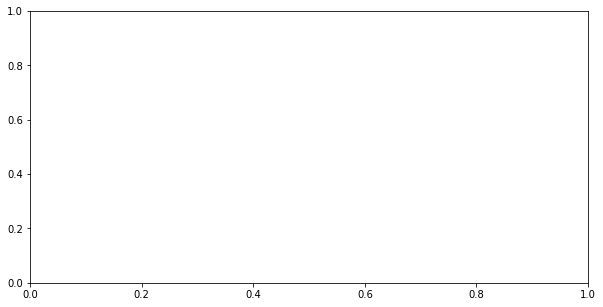

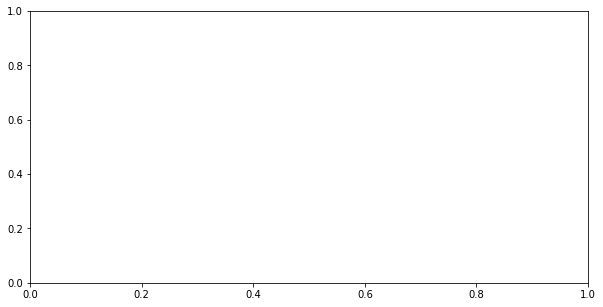

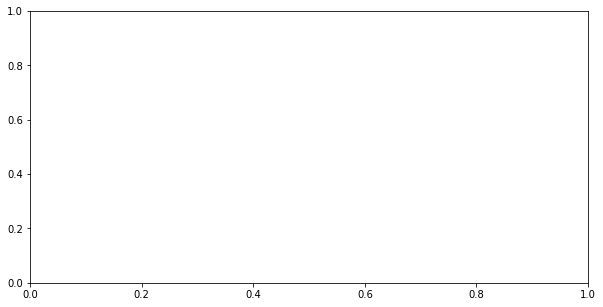

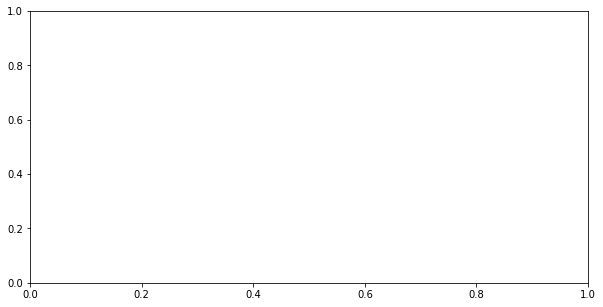

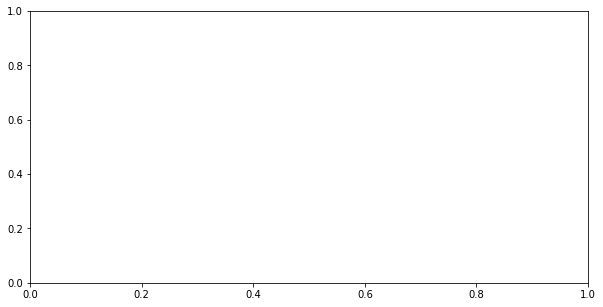

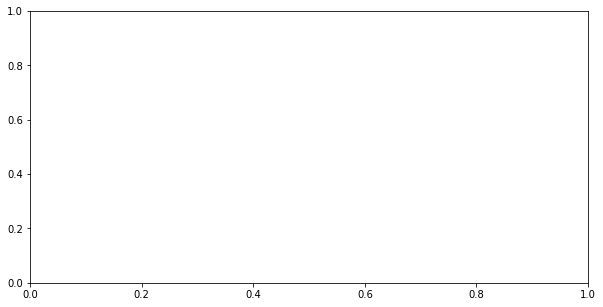

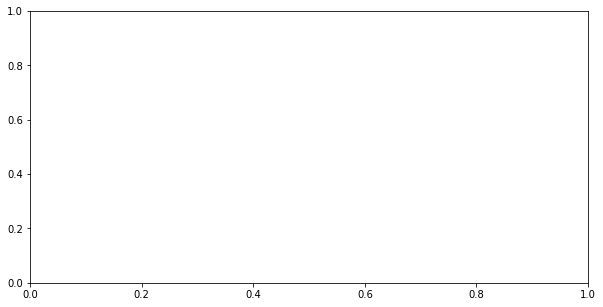

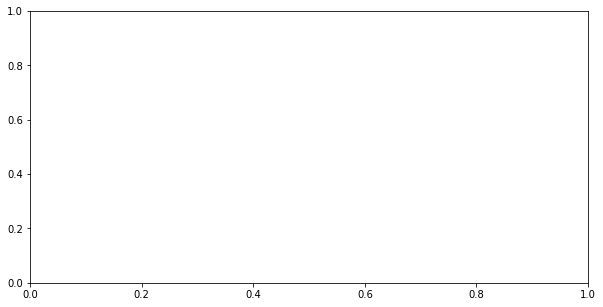

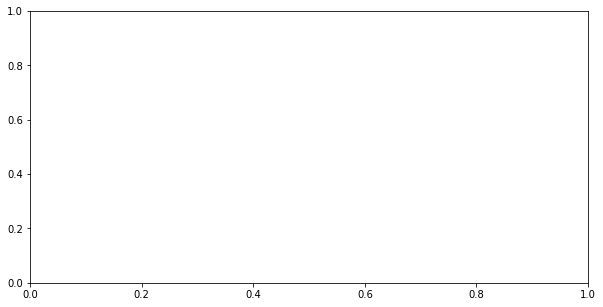

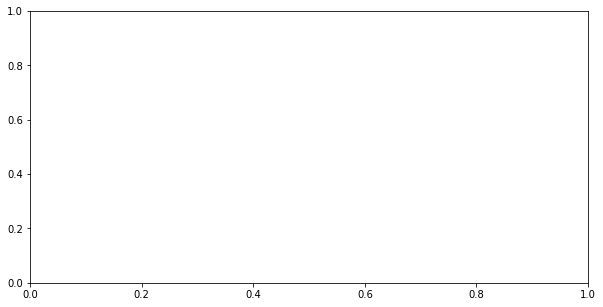

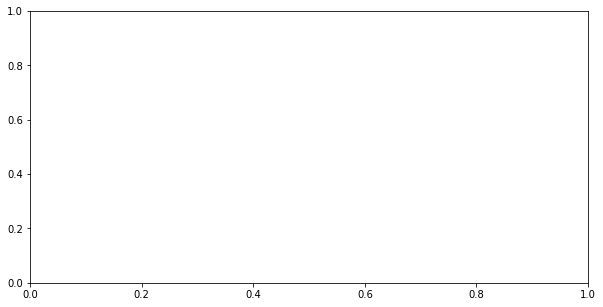

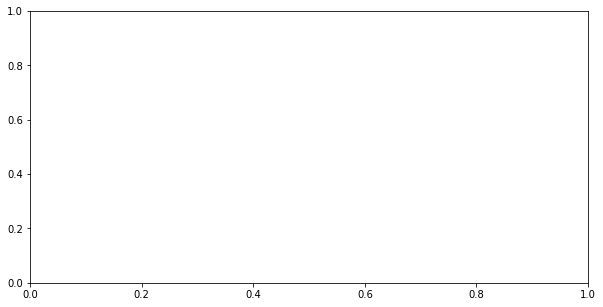

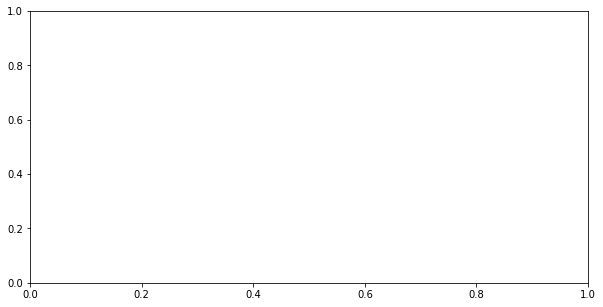

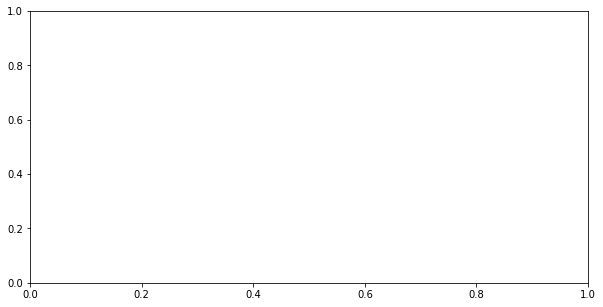

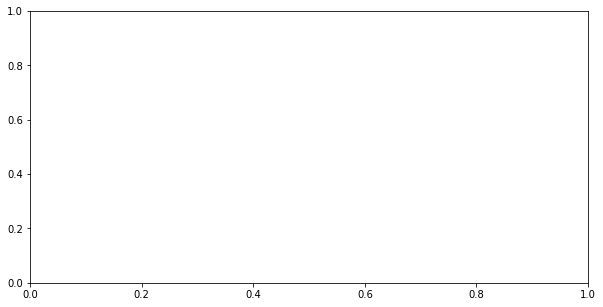

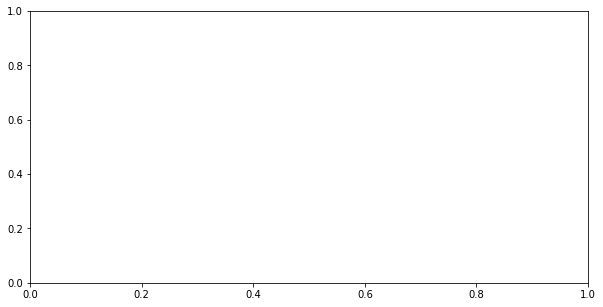

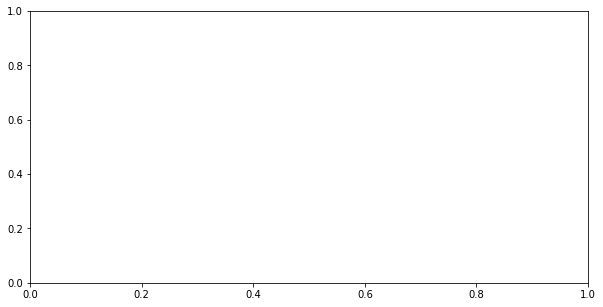

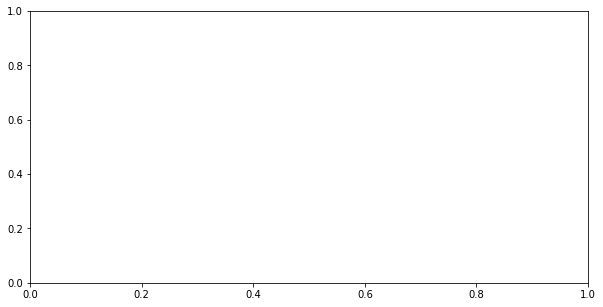

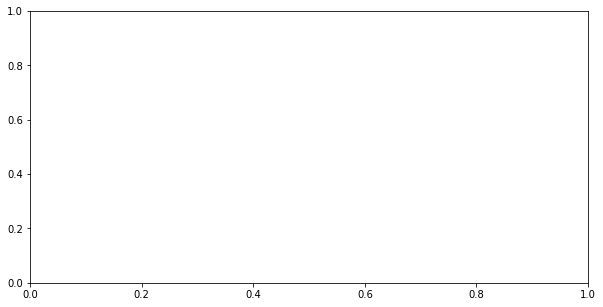

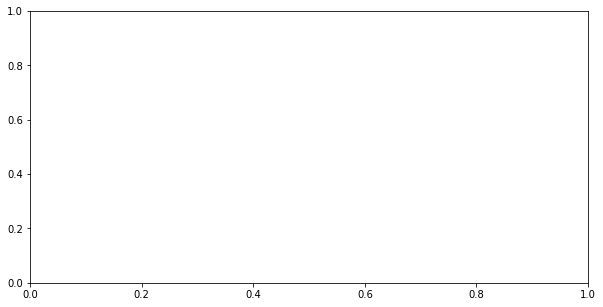

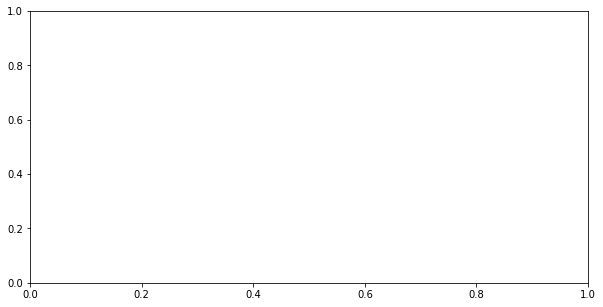

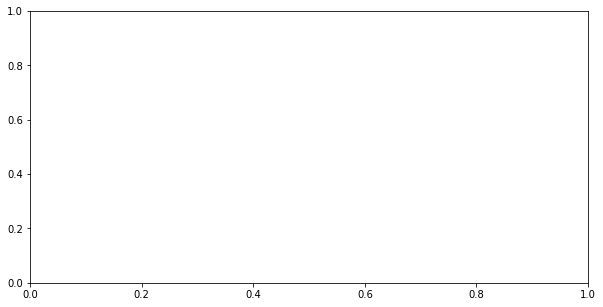

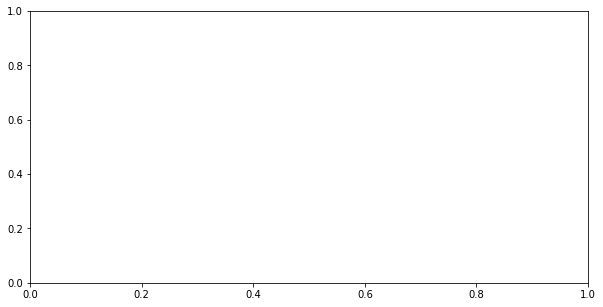

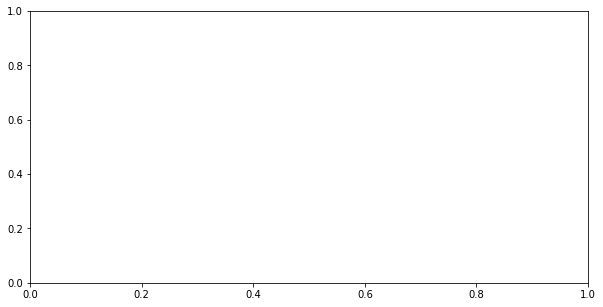

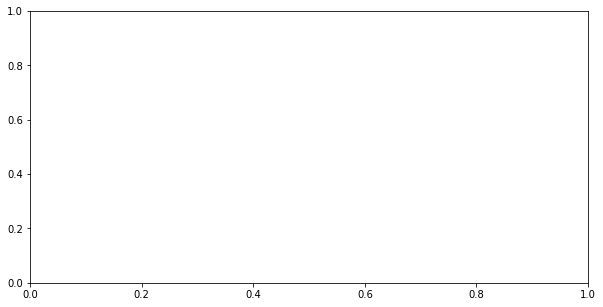

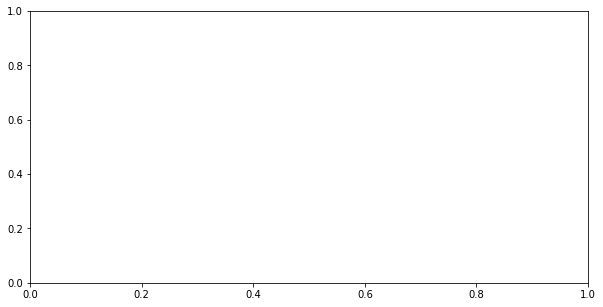

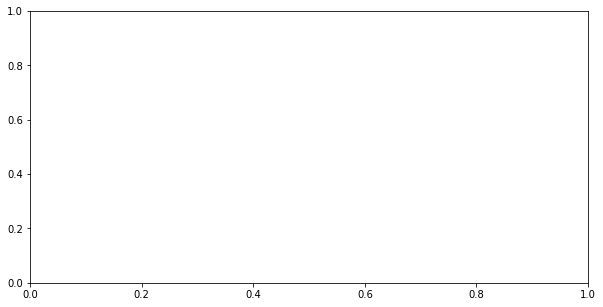

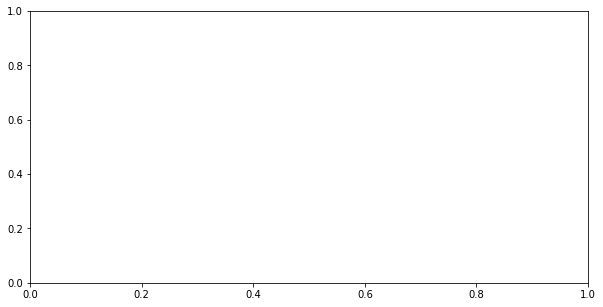

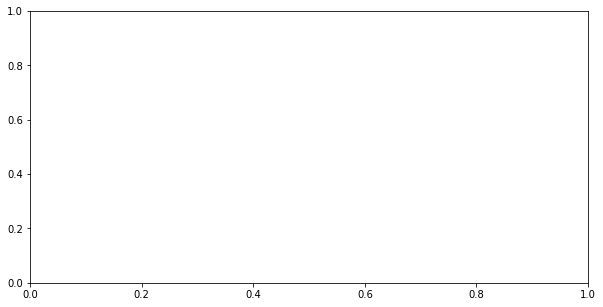

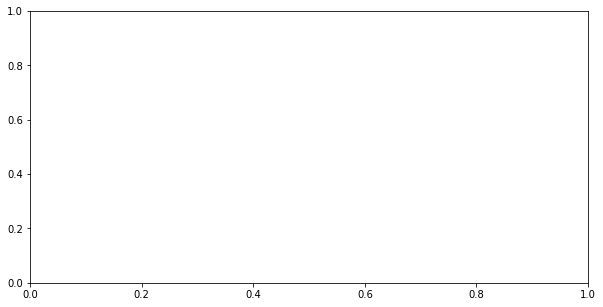

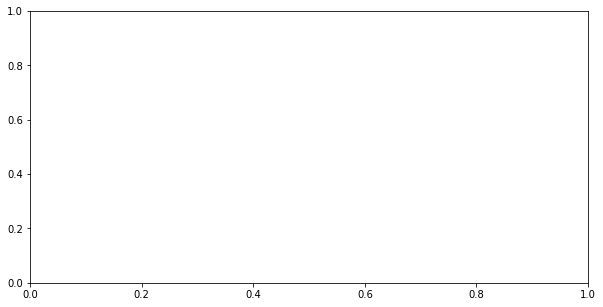

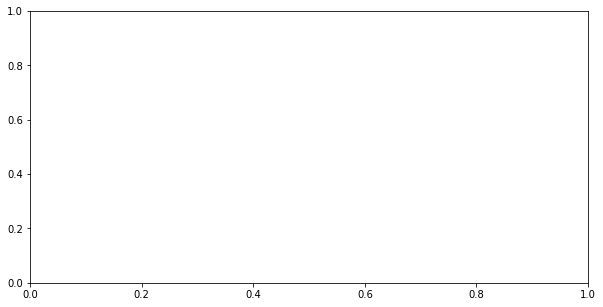

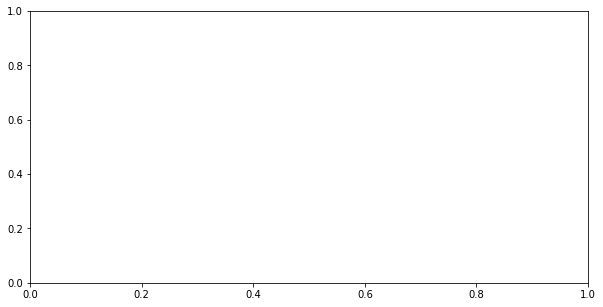

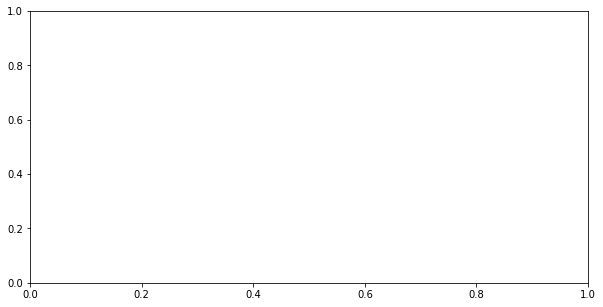

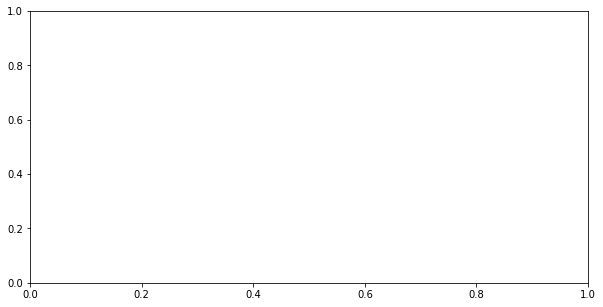

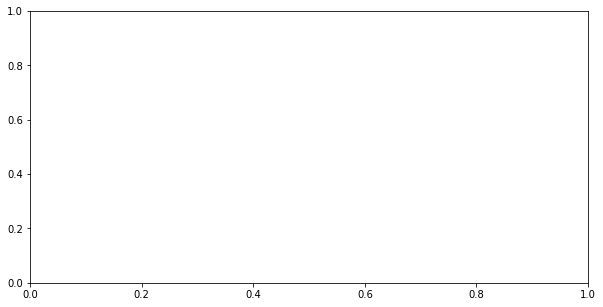

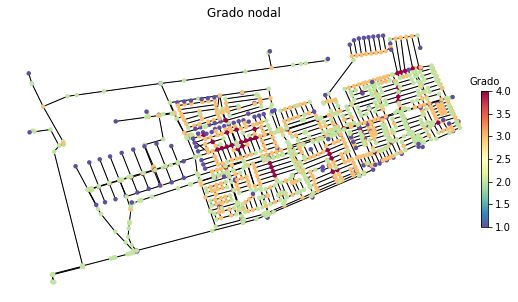

In [18]:
node_degree = G.degree()
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.grado = node_degree[node_name]
    fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Grado nodal', node_attribute='grado', node_colorbar_label='Grado',ax=ax2)

### Nodos terminales
Los nodos terminales son los de grado 1 (azules)

In [19]:
terminal_nodes = wntr.metrics.terminal_nodes(G)
print(len(terminal_nodes))

157


### Puntos de articulación

In [20]:
articulation_points = list(nx.articulation_points(uG))

### Puentes

In [21]:
bridges = wntr.metrics.bridges(G)

## Métricas hidráulicas
Requieren de la simulación hidráulica de la red.

In [ ]:
wn.options.hydraulic.demand_model = 'PDD'
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

Nodos y momentos en los que la presión (pressure) supera (np.greater) un umbral (threshold), utilizando los resultados de una simulación hidráulica.

In [ ]:
pressure = results.node['pressure']
threshold = 21.09 # 30 psi
pressure_above_threshold = wntr.metrics.query(pressure, np.greater,threshold)
print (pressure_above_threshold)

La poblacion la calcula como demanda_promedio_esperada / consumo per capita (R). Por default R=8.76157e-06 m3/s, esto se puede cambiar

In [ ]:
pop = wntr.metrics.population(wn)
wntr.graphics.plot_interactive_network(wn, node_attribute=pop,node_range=[0,500], filename='population.html', auto_open=True)

### Disponibilidad de servicio de agua
wsa = demanda / demanda esperada. Se puede calcular un promedio o calcular por cada nodo
Si la demanda esperad es cero, el resultado es indefinido (NaN)

In [ ]:
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand']
wsa = wntr.metrics.water_service_availability(expected_demand, demand)
print(wsa)

## Indice de Todini
El resultado se da en distintos momentos de tiempo

In [36]:
head = results.node['head']
pump_flowrate = results.link['flowrate'].loc[:,wn.pump_name_list]
todini = wntr.metrics.todini_index(head, pressure, demand, pump_flowrate, wn,threshold)
print(todini)

0        0.750227
3600     0.751810
7200     0.753340
10800    0.754800
14400    0.766471
18000    0.415395
21600    0.414843
25200    0.414231
28800    0.395831
32400    0.394830
36000    0.704603
39600    0.703722
43200    0.702903
46800    0.702238
50400    0.701382
54000    0.702439
57600    0.416643
61200    0.415318
64800    0.414158
68400    0.413006
72000    0.697799
75600    0.698361
79200    0.699322
82800    0.700475
86400    0.750227
dtype: float64


In [37]:
print(len(todini))

25


In [38]:
print(wn.pump_name_list)

['BOMBA14', 'BOMBA_4', 'BOMBA_6', 'BOMBA_7', 'BOMBA_8', 'BOMBA_1', 'BOMBA_2', 'BOMBA_3', 'BOMBA_9', 'BOMBA13', 'BOMBA_5']
